In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 100000
lstm_hidden_size = 64
epochs = 20
experiment_id = (
    "classification-max_training_samples-100000-lstm_hidden_size-64-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


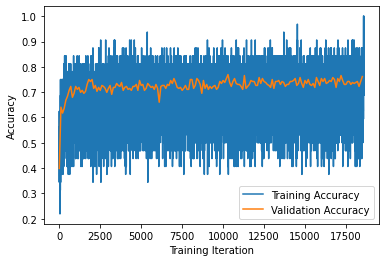

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.132 Validation Loss: 2.117 Accuracy: 0.383 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.133 Validation Loss: 2.117 Accuracy: 0.387 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.125 Validation Loss: 2.117 Accuracy: 0.414 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.125 Validation Loss: 2.117 Accuracy: 0.410 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.123 Validation Loss: 2.117 Accuracy: 0.425 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.123 Validation Loss: 2.117 Accuracy: 0.430 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.125 Validation Loss: 2.117 Accuracy: 0.429 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.122 Validation Loss: 2.117 Accuracy: 0.440 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.120 Validation Loss: 2.117 Accuracy: 0.447 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.119 Validation Loss: 2.117 Accuracy: 0.452 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.118 Validation Loss: 2.117 Accuracy: 0.464 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.117 Validation Loss: 2.117 Accuracy: 0.473 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.114 Validation Loss: 2.117 Accuracy: 0.476 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.114 Validation Loss: 2.117 Accuracy: 0.482 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.113 Validation Loss: 2.117 Accuracy: 0.480 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.112 Validation Loss: 2.117 Accuracy: 0.487 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.112 Validation Loss: 2.117 Accuracy: 0.496 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.112 Validation Loss: 2.117 Accuracy: 0.490 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.110 Validation Loss: 2.117 Accuracy: 0.495 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.109 Validation Loss: 2.117 Accuracy: 0.497 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.107 Validation Loss: 2.117 Accuracy: 0.494 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 21 Loss: 2.106 Validation Loss: 2.117 Accuracy: 0.495 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.106 Validation Loss: 2.117 Accuracy: 0.500 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 23 Loss: 2.104 Validation Loss: 2.117 Accuracy: 0.503 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 24 Loss: 2.103 Validation Loss: 2.117 Accuracy: 0.512 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 25 Loss: 2.103 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 26 Loss: 2.101 Validation Loss: 2.117 Accuracy: 0.501 Validation Accuracy: 0.465:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 26 Loss: 2.101 Validation Loss: 2.117 Accuracy: 0.501 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 27 Loss: 2.100 Validation Loss: 2.117 Accuracy: 0.502 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 28 Loss: 2.099 Validation Loss: 2.117 Accuracy: 0.496 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 29 Loss: 2.097 Validation Loss: 2.117 Accuracy: 0.503 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 30 Loss: 2.098 Validation Loss: 2.117 Accuracy: 0.499 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 31 Loss: 2.097 Validation Loss: 2.117 Accuracy: 0.494 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 32 Loss: 2.098 Validation Loss: 2.117 Accuracy: 0.491 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 33 Loss: 2.096 Validation Loss: 2.117 Accuracy: 0.493 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 34 Loss: 2.095 Validation Loss: 2.117 Accuracy: 0.487 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 35 Loss: 2.094 Validation Loss: 2.117 Accuracy: 0.496 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 36 Loss: 2.093 Validation Loss: 2.117 Accuracy: 0.503 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 37 Loss: 2.092 Validation Loss: 2.117 Accuracy: 0.503 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 38 Loss: 2.093 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 39 Loss: 2.092 Validation Loss: 2.117 Accuracy: 0.501 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 40 Loss: 2.090 Validation Loss: 2.117 Accuracy: 0.513 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 41 Loss: 2.089 Validation Loss: 2.117 Accuracy: 0.518 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 42 Loss: 2.087 Validation Loss: 2.117 Accuracy: 0.521 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

(100000, 10, 769)


Epoch: 0 Iteration: 43 Loss: 2.087 Validation Loss: 2.117 Accuracy: 0.516 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 44 Loss: 2.087 Validation Loss: 2.117 Accuracy: 0.512 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 45 Loss: 2.084 Validation Loss: 2.117 Accuracy: 0.510 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 46 Loss: 2.082 Validation Loss: 2.117 Accuracy: 0.510 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 47 Loss: 2.080 Validation Loss: 2.117 Accuracy: 0.516 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 48 Loss: 2.079 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 49 Loss: 2.079 Validation Loss: 2.117 Accuracy: 0.504 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 50 Loss: 2.077 Validation Loss: 2.117 Accuracy: 0.501 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 51 Loss: 2.076 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 52 Loss: 2.073 Validation Loss: 2.117 Accuracy: 0.505 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 53 Loss: 2.074 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   3%|▎         | 27/782 [00:00<00:02, 260.93it/s]

Epoch: 0 Iteration: 53 Loss: 2.074 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 54 Loss: 2.074 Validation Loss: 2.117 Accuracy: 0.516 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 55 Loss: 2.071 Validation Loss: 2.117 Accuracy: 0.520 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 56 Loss: 2.071 Validation Loss: 2.117 Accuracy: 0.515 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 57 Loss: 2.070 Validation Loss: 2.117 Accuracy: 0.509 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 58 Loss: 2.067 Validation Loss: 2.117 Accuracy: 0.513 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 59 Loss: 2.066 Validation Loss: 2.117 Accuracy: 0.520 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 60 Loss: 2.067 Validation Loss: 2.117 Accuracy: 0.522 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 61 Loss: 2.066 Validation Loss: 2.117 Accuracy: 0.520 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 62 Loss: 2.065 Validation Loss: 2.117 Accuracy: 0.523 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 63 Loss: 2.065 Validation Loss: 2.117 Accuracy: 0.527 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 64 Loss: 2.063 Validation Loss: 2.117 Accuracy: 0.537 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 65 Loss: 2.062 Validation Loss: 2.117 Accuracy: 0.536 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 66 Loss: 2.062 Validation Loss: 2.117 Accuracy: 0.541 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 67 Loss: 2.062 Validation Loss: 2.117 Accuracy: 0.552 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 68 Loss: 2.061 Validation Loss: 2.117 Accuracy: 0.557 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 69 Loss: 2.060 Validation Loss: 2.117 Accuracy: 0.562 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 70 Loss: 2.059 Validation Loss: 2.117 Accuracy: 0.565 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 71 Loss: 2.057 Validation Loss: 2.117 Accuracy: 0.563 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 72 Loss: 2.058 Validation Loss: 2.117 Accuracy: 0.568 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 73 Loss: 2.056 Validation Loss: 2.117 Accuracy: 0.571 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 74 Loss: 2.055 Validation Loss: 2.117 Accuracy: 0.562 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 75 Loss: 2.057 Validation Loss: 2.117 Accuracy: 0.555 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 76 Loss: 2.055 Validation Loss: 2.117 Accuracy: 0.566 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 77 Loss: 2.053 Validation Loss: 2.117 Accuracy: 0.566 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 78 Loss: 2.054 Validation Loss: 2.117 Accuracy: 0.567 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 79 Loss: 2.053 Validation Loss: 2.117 Accuracy: 0.568 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 80 Loss: 2.052 Validation Loss: 2.117 Accuracy: 0.560 Validation Accuracy: 0.465:   7%|▋         | 54/782 [00:00<00:02, 264.88it/s]

Epoch: 0 Iteration: 80 Loss: 2.052 Validation Loss: 2.117 Accuracy: 0.560 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 81 Loss: 2.050 Validation Loss: 2.117 Accuracy: 0.564 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 82 Loss: 2.049 Validation Loss: 2.117 Accuracy: 0.560 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 83 Loss: 2.047 Validation Loss: 2.117 Accuracy: 0.559 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 84 Loss: 2.045 Validation Loss: 2.117 Accuracy: 0.573 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 85 Loss: 2.045 Validation Loss: 2.117 Accuracy: 0.580 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 86 Loss: 2.042 Validation Loss: 2.117 Accuracy: 0.580 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 87 Loss: 2.040 Validation Loss: 2.117 Accuracy: 0.579 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 88 Loss: 2.037 Validation Loss: 2.117 Accuracy: 0.581 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 89 Loss: 2.037 Validation Loss: 2.117 Accuracy: 0.583 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 90 Loss: 2.037 Validation Loss: 2.117 Accuracy: 0.591 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 91 Loss: 2.035 Validation Loss: 2.117 Accuracy: 0.598 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 92 Loss: 2.032 Validation Loss: 2.117 Accuracy: 0.608 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 93 Loss: 2.031 Validation Loss: 2.117 Accuracy: 0.608 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 94 Loss: 2.028 Validation Loss: 2.117 Accuracy: 0.596 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 95 Loss: 2.026 Validation Loss: 2.117 Accuracy: 0.601 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 96 Loss: 2.024 Validation Loss: 2.117 Accuracy: 0.600 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 97 Loss: 2.024 Validation Loss: 2.117 Accuracy: 0.599 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 98 Loss: 2.023 Validation Loss: 2.117 Accuracy: 0.595 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 99 Loss: 2.021 Validation Loss: 2.117 Accuracy: 0.591 Validation Accuracy: 0.465:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 100 Loss: 2.019 Validation Loss: 2.026 Accuracy: 0.595 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 101 Loss: 2.019 Validation Loss: 2.026 Accuracy: 0.592 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 102 Loss: 2.017 Validation Loss: 2.026 Accuracy: 0.588 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 103 Loss: 2.017 Validation Loss: 2.026 Accuracy: 0.591 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 104 Loss: 2.017 Validation Loss: 2.026 Accuracy: 0.597 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 105 Loss: 2.016 Validation Loss: 2.026 Accuracy: 0.594 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 106 Loss: 2.016 Validation Loss: 2.026 Accuracy: 0.592 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 107 Loss: 2.016 Validation Loss: 2.026 Accuracy: 0.598 Validation Accuracy: 0.539:  10%|█         | 81/782 [00:00<00:02, 265.36it/s]

Epoch: 0 Iteration: 107 Loss: 2.016 Validation Loss: 2.026 Accuracy: 0.598 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 108 Loss: 2.017 Validation Loss: 2.026 Accuracy: 0.602 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 109 Loss: 2.013 Validation Loss: 2.026 Accuracy: 0.616 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 110 Loss: 2.012 Validation Loss: 2.026 Accuracy: 0.624 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 111 Loss: 2.013 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 112 Loss: 2.013 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 113 Loss: 2.011 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 114 Loss: 2.012 Validation Loss: 2.026 Accuracy: 0.620 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 115 Loss: 2.011 Validation Loss: 2.026 Accuracy: 0.620 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 116 Loss: 2.011 Validation Loss: 2.026 Accuracy: 0.629 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 117 Loss: 2.009 Validation Loss: 2.026 Accuracy: 0.635 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 118 Loss: 2.008 Validation Loss: 2.026 Accuracy: 0.642 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 119 Loss: 2.007 Validation Loss: 2.026 Accuracy: 0.631 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 120 Loss: 2.004 Validation Loss: 2.026 Accuracy: 0.629 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 121 Loss: 2.002 Validation Loss: 2.026 Accuracy: 0.632 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 122 Loss: 2.003 Validation Loss: 2.026 Accuracy: 0.634 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 123 Loss: 2.001 Validation Loss: 2.026 Accuracy: 0.632 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 124 Loss: 2.001 Validation Loss: 2.026 Accuracy: 0.640 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 125 Loss: 2.000 Validation Loss: 2.026 Accuracy: 0.642 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 126 Loss: 1.997 Validation Loss: 2.026 Accuracy: 0.642 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 127 Loss: 1.994 Validation Loss: 2.026 Accuracy: 0.636 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 128 Loss: 1.992 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 129 Loss: 1.993 Validation Loss: 2.026 Accuracy: 0.629 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 130 Loss: 1.992 Validation Loss: 2.026 Accuracy: 0.621 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 131 Loss: 1.991 Validation Loss: 2.026 Accuracy: 0.620 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 132 Loss: 1.990 Validation Loss: 2.026 Accuracy: 0.621 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 133 Loss: 1.991 Validation Loss: 2.026 Accuracy: 0.620 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 134 Loss: 1.987 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  14%|█▍        | 108/782 [00:00<00:02, 263.36it/s]

Epoch: 0 Iteration: 134 Loss: 1.987 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 135 Loss: 1.986 Validation Loss: 2.026 Accuracy: 0.626 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 136 Loss: 1.986 Validation Loss: 2.026 Accuracy: 0.614 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 137 Loss: 1.987 Validation Loss: 2.026 Accuracy: 0.618 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 138 Loss: 1.988 Validation Loss: 2.026 Accuracy: 0.618 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 139 Loss: 1.986 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 140 Loss: 1.989 Validation Loss: 2.026 Accuracy: 0.626 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 141 Loss: 1.989 Validation Loss: 2.026 Accuracy: 0.627 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 142 Loss: 1.988 Validation Loss: 2.026 Accuracy: 0.623 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 143 Loss: 1.987 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 144 Loss: 1.984 Validation Loss: 2.026 Accuracy: 0.618 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 145 Loss: 1.983 Validation Loss: 2.026 Accuracy: 0.614 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 146 Loss: 1.986 Validation Loss: 2.026 Accuracy: 0.623 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 147 Loss: 1.988 Validation Loss: 2.026 Accuracy: 0.616 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 148 Loss: 1.989 Validation Loss: 2.026 Accuracy: 0.614 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 149 Loss: 1.989 Validation Loss: 2.026 Accuracy: 0.616 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 150 Loss: 1.988 Validation Loss: 2.026 Accuracy: 0.612 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 151 Loss: 1.988 Validation Loss: 2.026 Accuracy: 0.613 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 152 Loss: 1.985 Validation Loss: 2.026 Accuracy: 0.624 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 153 Loss: 1.983 Validation Loss: 2.026 Accuracy: 0.627 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 154 Loss: 1.984 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 155 Loss: 1.983 Validation Loss: 2.026 Accuracy: 0.632 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 156 Loss: 1.981 Validation Loss: 2.026 Accuracy: 0.636 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 157 Loss: 1.981 Validation Loss: 2.026 Accuracy: 0.639 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 158 Loss: 1.979 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 159 Loss: 1.977 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 160 Loss: 1.976 Validation Loss: 2.026 Accuracy: 0.641 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 161 Loss: 1.977 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  17%|█▋        | 135/782 [00:00<00:02, 264.97it/s]

Epoch: 0 Iteration: 161 Loss: 1.977 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 162 Loss: 1.975 Validation Loss: 2.026 Accuracy: 0.629 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 163 Loss: 1.972 Validation Loss: 2.026 Accuracy: 0.633 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 164 Loss: 1.972 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 165 Loss: 1.969 Validation Loss: 2.026 Accuracy: 0.637 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 166 Loss: 1.967 Validation Loss: 2.026 Accuracy: 0.639 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 167 Loss: 1.965 Validation Loss: 2.026 Accuracy: 0.642 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 168 Loss: 1.963 Validation Loss: 2.026 Accuracy: 0.646 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 169 Loss: 1.961 Validation Loss: 2.026 Accuracy: 0.643 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 170 Loss: 1.961 Validation Loss: 2.026 Accuracy: 0.643 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 171 Loss: 1.960 Validation Loss: 2.026 Accuracy: 0.646 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 172 Loss: 1.961 Validation Loss: 2.026 Accuracy: 0.647 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 173 Loss: 1.959 Validation Loss: 2.026 Accuracy: 0.642 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 174 Loss: 1.958 Validation Loss: 2.026 Accuracy: 0.641 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 175 Loss: 1.958 Validation Loss: 2.026 Accuracy: 0.636 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 176 Loss: 1.957 Validation Loss: 2.026 Accuracy: 0.632 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 177 Loss: 1.956 Validation Loss: 2.026 Accuracy: 0.625 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 178 Loss: 1.954 Validation Loss: 2.026 Accuracy: 0.627 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 179 Loss: 1.959 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 180 Loss: 1.957 Validation Loss: 2.026 Accuracy: 0.621 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 181 Loss: 1.956 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 182 Loss: 1.958 Validation Loss: 2.026 Accuracy: 0.620 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 183 Loss: 1.958 Validation Loss: 2.026 Accuracy: 0.626 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 184 Loss: 1.959 Validation Loss: 2.026 Accuracy: 0.622 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 185 Loss: 1.959 Validation Loss: 2.026 Accuracy: 0.623 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 186 Loss: 1.957 Validation Loss: 2.026 Accuracy: 0.625 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 187 Loss: 1.954 Validation Loss: 2.026 Accuracy: 0.634 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 188 Loss: 1.954 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  21%|██        | 162/782 [00:00<00:02, 266.57it/s]

Epoch: 0 Iteration: 188 Loss: 1.954 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 189 Loss: 1.952 Validation Loss: 2.026 Accuracy: 0.625 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 190 Loss: 1.951 Validation Loss: 2.026 Accuracy: 0.632 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 191 Loss: 1.950 Validation Loss: 2.026 Accuracy: 0.629 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 192 Loss: 1.950 Validation Loss: 2.026 Accuracy: 0.630 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 193 Loss: 1.950 Validation Loss: 2.026 Accuracy: 0.626 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 194 Loss: 1.950 Validation Loss: 2.026 Accuracy: 0.621 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 195 Loss: 1.948 Validation Loss: 2.026 Accuracy: 0.621 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 196 Loss: 1.949 Validation Loss: 2.026 Accuracy: 0.614 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 197 Loss: 1.951 Validation Loss: 2.026 Accuracy: 0.603 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 198 Loss: 1.949 Validation Loss: 2.026 Accuracy: 0.605 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 199 Loss: 1.946 Validation Loss: 2.026 Accuracy: 0.613 Validation Accuracy: 0.539:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 200 Loss: 1.945 Validation Loss: 1.946 Accuracy: 0.612 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 201 Loss: 1.942 Validation Loss: 1.946 Accuracy: 0.614 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 202 Loss: 1.937 Validation Loss: 1.946 Accuracy: 0.620 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 203 Loss: 1.938 Validation Loss: 1.946 Accuracy: 0.616 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 204 Loss: 1.936 Validation Loss: 1.946 Accuracy: 0.623 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 205 Loss: 1.935 Validation Loss: 1.946 Accuracy: 0.626 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 206 Loss: 1.936 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 207 Loss: 1.939 Validation Loss: 1.946 Accuracy: 0.636 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 208 Loss: 1.937 Validation Loss: 1.946 Accuracy: 0.637 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 209 Loss: 1.937 Validation Loss: 1.946 Accuracy: 0.637 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 210 Loss: 1.938 Validation Loss: 1.946 Accuracy: 0.640 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 211 Loss: 1.938 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 212 Loss: 1.938 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 213 Loss: 1.937 Validation Loss: 1.946 Accuracy: 0.628 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 214 Loss: 1.935 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 215 Loss: 1.935 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  24%|██▍       | 189/782 [00:00<00:02, 265.76it/s]

Epoch: 0 Iteration: 215 Loss: 1.935 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 216 Loss: 1.934 Validation Loss: 1.946 Accuracy: 0.628 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 217 Loss: 1.932 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 218 Loss: 1.929 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 219 Loss: 1.927 Validation Loss: 1.946 Accuracy: 0.629 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 220 Loss: 1.923 Validation Loss: 1.946 Accuracy: 0.631 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 221 Loss: 1.925 Validation Loss: 1.946 Accuracy: 0.635 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 222 Loss: 1.926 Validation Loss: 1.946 Accuracy: 0.640 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 223 Loss: 1.926 Validation Loss: 1.946 Accuracy: 0.641 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 224 Loss: 1.928 Validation Loss: 1.946 Accuracy: 0.641 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 225 Loss: 1.927 Validation Loss: 1.946 Accuracy: 0.636 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 226 Loss: 1.928 Validation Loss: 1.946 Accuracy: 0.633 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 227 Loss: 1.925 Validation Loss: 1.946 Accuracy: 0.634 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 228 Loss: 1.923 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 229 Loss: 1.924 Validation Loss: 1.946 Accuracy: 0.629 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 230 Loss: 1.922 Validation Loss: 1.946 Accuracy: 0.626 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 231 Loss: 1.921 Validation Loss: 1.946 Accuracy: 0.628 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 232 Loss: 1.919 Validation Loss: 1.946 Accuracy: 0.621 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 233 Loss: 1.922 Validation Loss: 1.946 Accuracy: 0.614 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 234 Loss: 1.921 Validation Loss: 1.946 Accuracy: 0.620 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 235 Loss: 1.918 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 236 Loss: 1.917 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 237 Loss: 1.913 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 238 Loss: 1.915 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 239 Loss: 1.916 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 240 Loss: 1.917 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 241 Loss: 1.916 Validation Loss: 1.946 Accuracy: 0.623 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 242 Loss: 1.914 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  28%|██▊       | 216/782 [00:00<00:02, 263.53it/s]

Epoch: 0 Iteration: 242 Loss: 1.914 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 243 Loss: 1.913 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 244 Loss: 1.910 Validation Loss: 1.946 Accuracy: 0.625 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 245 Loss: 1.912 Validation Loss: 1.946 Accuracy: 0.623 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 246 Loss: 1.909 Validation Loss: 1.946 Accuracy: 0.633 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 247 Loss: 1.907 Validation Loss: 1.946 Accuracy: 0.631 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 248 Loss: 1.906 Validation Loss: 1.946 Accuracy: 0.643 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 249 Loss: 1.903 Validation Loss: 1.946 Accuracy: 0.640 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 250 Loss: 1.902 Validation Loss: 1.946 Accuracy: 0.648 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 251 Loss: 1.900 Validation Loss: 1.946 Accuracy: 0.652 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 252 Loss: 1.900 Validation Loss: 1.946 Accuracy: 0.650 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 253 Loss: 1.898 Validation Loss: 1.946 Accuracy: 0.650 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 254 Loss: 1.898 Validation Loss: 1.946 Accuracy: 0.652 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 255 Loss: 1.900 Validation Loss: 1.946 Accuracy: 0.652 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 256 Loss: 1.901 Validation Loss: 1.946 Accuracy: 0.642 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 257 Loss: 1.902 Validation Loss: 1.946 Accuracy: 0.641 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 258 Loss: 1.903 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 259 Loss: 1.899 Validation Loss: 1.946 Accuracy: 0.638 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 260 Loss: 1.897 Validation Loss: 1.946 Accuracy: 0.637 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 261 Loss: 1.894 Validation Loss: 1.946 Accuracy: 0.637 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 262 Loss: 1.897 Validation Loss: 1.946 Accuracy: 0.639 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 263 Loss: 1.892 Validation Loss: 1.946 Accuracy: 0.648 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 264 Loss: 1.891 Validation Loss: 1.946 Accuracy: 0.640 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:00<00:02, 262.70it/s]

Epoch: 0 Iteration: 265 Loss: 1.887 Validation Loss: 1.946 Accuracy: 0.644 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 266 Loss: 1.888 Validation Loss: 1.946 Accuracy: 0.651 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 267 Loss: 1.886 Validation Loss: 1.946 Accuracy: 0.653 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 268 Loss: 1.885 Validation Loss: 1.946 Accuracy: 0.670 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 269 Loss: 1.884 Validation Loss: 1.946 Accuracy: 0.662 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 270 Loss: 1.885 Validation Loss: 1.946 Accuracy: 0.659 Validation Accuracy: 0.574:  31%|███       | 243/782 [00:01<00:02, 262.70it/s]

Epoch: 0 Iteration: 270 Loss: 1.885 Validation Loss: 1.946 Accuracy: 0.659 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 271 Loss: 1.884 Validation Loss: 1.946 Accuracy: 0.661 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 272 Loss: 1.883 Validation Loss: 1.946 Accuracy: 0.656 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 273 Loss: 1.881 Validation Loss: 1.946 Accuracy: 0.649 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 274 Loss: 1.878 Validation Loss: 1.946 Accuracy: 0.660 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 275 Loss: 1.876 Validation Loss: 1.946 Accuracy: 0.663 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 276 Loss: 1.872 Validation Loss: 1.946 Accuracy: 0.670 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 277 Loss: 1.872 Validation Loss: 1.946 Accuracy: 0.663 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 278 Loss: 1.869 Validation Loss: 1.946 Accuracy: 0.658 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 279 Loss: 1.865 Validation Loss: 1.946 Accuracy: 0.664 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 280 Loss: 1.866 Validation Loss: 1.946 Accuracy: 0.662 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 281 Loss: 1.868 Validation Loss: 1.946 Accuracy: 0.657 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 282 Loss: 1.866 Validation Loss: 1.946 Accuracy: 0.664 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 283 Loss: 1.867 Validation Loss: 1.946 Accuracy: 0.666 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 284 Loss: 1.866 Validation Loss: 1.946 Accuracy: 0.655 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 285 Loss: 1.866 Validation Loss: 1.946 Accuracy: 0.649 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 286 Loss: 1.868 Validation Loss: 1.946 Accuracy: 0.638 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 287 Loss: 1.869 Validation Loss: 1.946 Accuracy: 0.634 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 288 Loss: 1.873 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 289 Loss: 1.872 Validation Loss: 1.946 Accuracy: 0.621 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 290 Loss: 1.871 Validation Loss: 1.946 Accuracy: 0.623 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 291 Loss: 1.870 Validation Loss: 1.946 Accuracy: 0.627 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 292 Loss: 1.868 Validation Loss: 1.946 Accuracy: 0.623 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 293 Loss: 1.862 Validation Loss: 1.946 Accuracy: 0.630 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 294 Loss: 1.863 Validation Loss: 1.946 Accuracy: 0.636 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 295 Loss: 1.862 Validation Loss: 1.946 Accuracy: 0.647 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 296 Loss: 1.859 Validation Loss: 1.946 Accuracy: 0.656 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 297 Loss: 1.856 Validation Loss: 1.946 Accuracy: 0.659 Validation Accuracy: 0.574:  35%|███▍      | 271/782 [00:01<00:01, 266.85it/s]

Epoch: 0 Iteration: 297 Loss: 1.856 Validation Loss: 1.946 Accuracy: 0.659 Validation Accuracy: 0.574:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 298 Loss: 1.855 Validation Loss: 1.946 Accuracy: 0.664 Validation Accuracy: 0.574:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 299 Loss: 1.854 Validation Loss: 1.946 Accuracy: 0.670 Validation Accuracy: 0.574:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 300 Loss: 1.854 Validation Loss: 1.870 Accuracy: 0.676 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 301 Loss: 1.851 Validation Loss: 1.870 Accuracy: 0.680 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 302 Loss: 1.851 Validation Loss: 1.870 Accuracy: 0.683 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 303 Loss: 1.851 Validation Loss: 1.870 Accuracy: 0.670 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 304 Loss: 1.851 Validation Loss: 1.870 Accuracy: 0.671 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 305 Loss: 1.851 Validation Loss: 1.870 Accuracy: 0.663 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 306 Loss: 1.849 Validation Loss: 1.870 Accuracy: 0.659 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 307 Loss: 1.849 Validation Loss: 1.870 Accuracy: 0.659 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 308 Loss: 1.845 Validation Loss: 1.870 Accuracy: 0.655 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 309 Loss: 1.844 Validation Loss: 1.870 Accuracy: 0.658 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 310 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.659 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 311 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.655 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 312 Loss: 1.837 Validation Loss: 1.870 Accuracy: 0.657 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 313 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.656 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 314 Loss: 1.839 Validation Loss: 1.870 Accuracy: 0.651 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 315 Loss: 1.839 Validation Loss: 1.870 Accuracy: 0.647 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 316 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.641 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 317 Loss: 1.839 Validation Loss: 1.870 Accuracy: 0.648 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 318 Loss: 1.843 Validation Loss: 1.870 Accuracy: 0.640 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 319 Loss: 1.842 Validation Loss: 1.870 Accuracy: 0.640 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 320 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 321 Loss: 1.838 Validation Loss: 1.870 Accuracy: 0.639 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 322 Loss: 1.834 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 323 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.631 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 324 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  38%|███▊      | 298/782 [00:01<00:01, 265.21it/s]

Epoch: 0 Iteration: 324 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 325 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.632 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 326 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 327 Loss: 1.836 Validation Loss: 1.870 Accuracy: 0.635 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 328 Loss: 1.836 Validation Loss: 1.870 Accuracy: 0.638 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 329 Loss: 1.834 Validation Loss: 1.870 Accuracy: 0.633 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 330 Loss: 1.838 Validation Loss: 1.870 Accuracy: 0.626 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 331 Loss: 1.838 Validation Loss: 1.870 Accuracy: 0.626 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 332 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 333 Loss: 1.838 Validation Loss: 1.870 Accuracy: 0.641 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 334 Loss: 1.837 Validation Loss: 1.870 Accuracy: 0.647 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 335 Loss: 1.836 Validation Loss: 1.870 Accuracy: 0.656 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 336 Loss: 1.830 Validation Loss: 1.870 Accuracy: 0.662 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 337 Loss: 1.834 Validation Loss: 1.870 Accuracy: 0.652 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 338 Loss: 1.832 Validation Loss: 1.870 Accuracy: 0.652 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 339 Loss: 1.834 Validation Loss: 1.870 Accuracy: 0.654 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 340 Loss: 1.834 Validation Loss: 1.870 Accuracy: 0.655 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 341 Loss: 1.837 Validation Loss: 1.870 Accuracy: 0.652 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 342 Loss: 1.838 Validation Loss: 1.870 Accuracy: 0.641 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 343 Loss: 1.840 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 344 Loss: 1.839 Validation Loss: 1.870 Accuracy: 0.627 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 345 Loss: 1.835 Validation Loss: 1.870 Accuracy: 0.618 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 346 Loss: 1.833 Validation Loss: 1.870 Accuracy: 0.612 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 347 Loss: 1.826 Validation Loss: 1.870 Accuracy: 0.627 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 348 Loss: 1.825 Validation Loss: 1.870 Accuracy: 0.636 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 349 Loss: 1.826 Validation Loss: 1.870 Accuracy: 0.624 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 350 Loss: 1.821 Validation Loss: 1.870 Accuracy: 0.629 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 351 Loss: 1.820 Validation Loss: 1.870 Accuracy: 0.630 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 352 Loss: 1.825 Validation Loss: 1.870 Accuracy: 0.631 Validation Accuracy: 0.593:  42%|████▏     | 325/782 [00:01<00:01, 262.12it/s]

Epoch: 0 Iteration: 352 Loss: 1.825 Validation Loss: 1.870 Accuracy: 0.631 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 353 Loss: 1.822 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 354 Loss: 1.822 Validation Loss: 1.870 Accuracy: 0.644 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 355 Loss: 1.825 Validation Loss: 1.870 Accuracy: 0.643 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 356 Loss: 1.831 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 357 Loss: 1.826 Validation Loss: 1.870 Accuracy: 0.626 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 358 Loss: 1.823 Validation Loss: 1.870 Accuracy: 0.621 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 359 Loss: 1.823 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 360 Loss: 1.822 Validation Loss: 1.870 Accuracy: 0.630 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 361 Loss: 1.819 Validation Loss: 1.870 Accuracy: 0.630 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 362 Loss: 1.816 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 363 Loss: 1.812 Validation Loss: 1.870 Accuracy: 0.639 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 364 Loss: 1.811 Validation Loss: 1.870 Accuracy: 0.636 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 365 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.639 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 366 Loss: 1.809 Validation Loss: 1.870 Accuracy: 0.646 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 367 Loss: 1.812 Validation Loss: 1.870 Accuracy: 0.644 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 368 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.647 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 369 Loss: 1.807 Validation Loss: 1.870 Accuracy: 0.649 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 370 Loss: 1.806 Validation Loss: 1.870 Accuracy: 0.648 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 371 Loss: 1.808 Validation Loss: 1.870 Accuracy: 0.639 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 372 Loss: 1.806 Validation Loss: 1.870 Accuracy: 0.632 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 373 Loss: 1.803 Validation Loss: 1.870 Accuracy: 0.633 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 374 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.638 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 375 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.632 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 376 Loss: 1.792 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 377 Loss: 1.793 Validation Loss: 1.870 Accuracy: 0.634 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 378 Loss: 1.790 Validation Loss: 1.870 Accuracy: 0.635 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 379 Loss: 1.789 Validation Loss: 1.870 Accuracy: 0.630 Validation Accuracy: 0.593:  45%|████▌     | 353/782 [00:01<00:01, 265.52it/s]

Epoch: 0 Iteration: 379 Loss: 1.789 Validation Loss: 1.870 Accuracy: 0.630 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 380 Loss: 1.786 Validation Loss: 1.870 Accuracy: 0.635 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 381 Loss: 1.783 Validation Loss: 1.870 Accuracy: 0.647 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 382 Loss: 1.780 Validation Loss: 1.870 Accuracy: 0.650 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 383 Loss: 1.779 Validation Loss: 1.870 Accuracy: 0.647 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 384 Loss: 1.777 Validation Loss: 1.870 Accuracy: 0.643 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 385 Loss: 1.774 Validation Loss: 1.870 Accuracy: 0.651 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 386 Loss: 1.772 Validation Loss: 1.870 Accuracy: 0.645 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 387 Loss: 1.772 Validation Loss: 1.870 Accuracy: 0.652 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 388 Loss: 1.776 Validation Loss: 1.870 Accuracy: 0.646 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 389 Loss: 1.775 Validation Loss: 1.870 Accuracy: 0.646 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 390 Loss: 1.775 Validation Loss: 1.870 Accuracy: 0.643 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 391 Loss: 1.771 Validation Loss: 1.870 Accuracy: 0.640 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 392 Loss: 1.769 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 393 Loss: 1.772 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 394 Loss: 1.772 Validation Loss: 1.870 Accuracy: 0.633 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 395 Loss: 1.771 Validation Loss: 1.870 Accuracy: 0.633 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 396 Loss: 1.774 Validation Loss: 1.870 Accuracy: 0.637 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 397 Loss: 1.768 Validation Loss: 1.870 Accuracy: 0.641 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 398 Loss: 1.770 Validation Loss: 1.870 Accuracy: 0.639 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 399 Loss: 1.768 Validation Loss: 1.870 Accuracy: 0.642 Validation Accuracy: 0.593:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 400 Loss: 1.768 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 401 Loss: 1.769 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 402 Loss: 1.770 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 403 Loss: 1.770 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 404 Loss: 1.770 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 405 Loss: 1.768 Validation Loss: 1.795 Accuracy: 0.647 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 406 Loss: 1.770 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  49%|████▊     | 380/782 [00:01<00:01, 263.04it/s]

Epoch: 0 Iteration: 406 Loss: 1.770 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 407 Loss: 1.769 Validation Loss: 1.795 Accuracy: 0.638 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 408 Loss: 1.764 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 409 Loss: 1.764 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 410 Loss: 1.765 Validation Loss: 1.795 Accuracy: 0.634 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 411 Loss: 1.763 Validation Loss: 1.795 Accuracy: 0.637 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 412 Loss: 1.768 Validation Loss: 1.795 Accuracy: 0.632 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 413 Loss: 1.766 Validation Loss: 1.795 Accuracy: 0.633 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 414 Loss: 1.765 Validation Loss: 1.795 Accuracy: 0.633 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 415 Loss: 1.766 Validation Loss: 1.795 Accuracy: 0.626 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 416 Loss: 1.764 Validation Loss: 1.795 Accuracy: 0.625 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 417 Loss: 1.764 Validation Loss: 1.795 Accuracy: 0.632 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 418 Loss: 1.759 Validation Loss: 1.795 Accuracy: 0.624 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 419 Loss: 1.760 Validation Loss: 1.795 Accuracy: 0.623 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 420 Loss: 1.763 Validation Loss: 1.795 Accuracy: 0.628 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 421 Loss: 1.762 Validation Loss: 1.795 Accuracy: 0.622 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 422 Loss: 1.761 Validation Loss: 1.795 Accuracy: 0.633 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 423 Loss: 1.758 Validation Loss: 1.795 Accuracy: 0.636 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 424 Loss: 1.754 Validation Loss: 1.795 Accuracy: 0.639 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 425 Loss: 1.755 Validation Loss: 1.795 Accuracy: 0.642 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 426 Loss: 1.755 Validation Loss: 1.795 Accuracy: 0.638 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 427 Loss: 1.755 Validation Loss: 1.795 Accuracy: 0.627 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 428 Loss: 1.754 Validation Loss: 1.795 Accuracy: 0.631 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 429 Loss: 1.754 Validation Loss: 1.795 Accuracy: 0.634 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 430 Loss: 1.749 Validation Loss: 1.795 Accuracy: 0.641 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 431 Loss: 1.749 Validation Loss: 1.795 Accuracy: 0.642 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 432 Loss: 1.741 Validation Loss: 1.795 Accuracy: 0.636 Validation Accuracy: 0.605:  52%|█████▏    | 407/782 [00:01<00:01, 259.18it/s]

Epoch: 0 Iteration: 432 Loss: 1.741 Validation Loss: 1.795 Accuracy: 0.636 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 433 Loss: 1.738 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 434 Loss: 1.735 Validation Loss: 1.795 Accuracy: 0.650 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 435 Loss: 1.737 Validation Loss: 1.795 Accuracy: 0.644 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 436 Loss: 1.736 Validation Loss: 1.795 Accuracy: 0.654 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 437 Loss: 1.738 Validation Loss: 1.795 Accuracy: 0.658 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 438 Loss: 1.743 Validation Loss: 1.795 Accuracy: 0.658 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 439 Loss: 1.743 Validation Loss: 1.795 Accuracy: 0.652 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 440 Loss: 1.739 Validation Loss: 1.795 Accuracy: 0.654 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 441 Loss: 1.736 Validation Loss: 1.795 Accuracy: 0.659 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 442 Loss: 1.740 Validation Loss: 1.795 Accuracy: 0.649 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 443 Loss: 1.740 Validation Loss: 1.795 Accuracy: 0.643 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 444 Loss: 1.744 Validation Loss: 1.795 Accuracy: 0.637 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 445 Loss: 1.747 Validation Loss: 1.795 Accuracy: 0.643 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 446 Loss: 1.742 Validation Loss: 1.795 Accuracy: 0.641 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 447 Loss: 1.739 Validation Loss: 1.795 Accuracy: 0.644 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 448 Loss: 1.738 Validation Loss: 1.795 Accuracy: 0.641 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 449 Loss: 1.737 Validation Loss: 1.795 Accuracy: 0.647 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 450 Loss: 1.742 Validation Loss: 1.795 Accuracy: 0.636 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 451 Loss: 1.744 Validation Loss: 1.795 Accuracy: 0.637 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 452 Loss: 1.742 Validation Loss: 1.795 Accuracy: 0.652 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 453 Loss: 1.744 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 454 Loss: 1.749 Validation Loss: 1.795 Accuracy: 0.647 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 455 Loss: 1.741 Validation Loss: 1.795 Accuracy: 0.650 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 456 Loss: 1.739 Validation Loss: 1.795 Accuracy: 0.651 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 457 Loss: 1.736 Validation Loss: 1.795 Accuracy: 0.646 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 458 Loss: 1.732 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  55%|█████▌    | 433/782 [00:01<00:01, 253.99it/s]

Epoch: 0 Iteration: 458 Loss: 1.732 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 459 Loss: 1.733 Validation Loss: 1.795 Accuracy: 0.634 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 460 Loss: 1.731 Validation Loss: 1.795 Accuracy: 0.650 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 461 Loss: 1.734 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 462 Loss: 1.727 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 463 Loss: 1.727 Validation Loss: 1.795 Accuracy: 0.659 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 464 Loss: 1.726 Validation Loss: 1.795 Accuracy: 0.657 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 465 Loss: 1.725 Validation Loss: 1.795 Accuracy: 0.653 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 466 Loss: 1.727 Validation Loss: 1.795 Accuracy: 0.648 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 467 Loss: 1.725 Validation Loss: 1.795 Accuracy: 0.652 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 468 Loss: 1.722 Validation Loss: 1.795 Accuracy: 0.658 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 469 Loss: 1.717 Validation Loss: 1.795 Accuracy: 0.672 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 470 Loss: 1.709 Validation Loss: 1.795 Accuracy: 0.670 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 471 Loss: 1.706 Validation Loss: 1.795 Accuracy: 0.671 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 472 Loss: 1.710 Validation Loss: 1.795 Accuracy: 0.671 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 473 Loss: 1.703 Validation Loss: 1.795 Accuracy: 0.670 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 474 Loss: 1.692 Validation Loss: 1.795 Accuracy: 0.682 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 475 Loss: 1.695 Validation Loss: 1.795 Accuracy: 0.685 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 476 Loss: 1.696 Validation Loss: 1.795 Accuracy: 0.687 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 477 Loss: 1.696 Validation Loss: 1.795 Accuracy: 0.686 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 478 Loss: 1.696 Validation Loss: 1.795 Accuracy: 0.684 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 479 Loss: 1.692 Validation Loss: 1.795 Accuracy: 0.672 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 480 Loss: 1.695 Validation Loss: 1.795 Accuracy: 0.665 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 481 Loss: 1.690 Validation Loss: 1.795 Accuracy: 0.670 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 482 Loss: 1.692 Validation Loss: 1.795 Accuracy: 0.661 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 483 Loss: 1.687 Validation Loss: 1.795 Accuracy: 0.650 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 484 Loss: 1.680 Validation Loss: 1.795 Accuracy: 0.644 Validation Accuracy: 0.605:  59%|█████▊    | 459/782 [00:01<00:01, 250.92it/s]

Epoch: 0 Iteration: 484 Loss: 1.680 Validation Loss: 1.795 Accuracy: 0.644 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 485 Loss: 1.681 Validation Loss: 1.795 Accuracy: 0.641 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 486 Loss: 1.678 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 487 Loss: 1.682 Validation Loss: 1.795 Accuracy: 0.643 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 488 Loss: 1.684 Validation Loss: 1.795 Accuracy: 0.645 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 489 Loss: 1.685 Validation Loss: 1.795 Accuracy: 0.651 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 490 Loss: 1.692 Validation Loss: 1.795 Accuracy: 0.647 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 491 Loss: 1.691 Validation Loss: 1.795 Accuracy: 0.641 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 492 Loss: 1.687 Validation Loss: 1.795 Accuracy: 0.647 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 493 Loss: 1.691 Validation Loss: 1.795 Accuracy: 0.651 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 494 Loss: 1.696 Validation Loss: 1.795 Accuracy: 0.651 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 495 Loss: 1.691 Validation Loss: 1.795 Accuracy: 0.655 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 496 Loss: 1.691 Validation Loss: 1.795 Accuracy: 0.652 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 497 Loss: 1.692 Validation Loss: 1.795 Accuracy: 0.653 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 498 Loss: 1.687 Validation Loss: 1.795 Accuracy: 0.659 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 499 Loss: 1.685 Validation Loss: 1.795 Accuracy: 0.655 Validation Accuracy: 0.605:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 500 Loss: 1.684 Validation Loss: 1.717 Accuracy: 0.655 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 501 Loss: 1.691 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 502 Loss: 1.685 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 503 Loss: 1.688 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 504 Loss: 1.689 Validation Loss: 1.717 Accuracy: 0.650 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 505 Loss: 1.686 Validation Loss: 1.717 Accuracy: 0.649 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 506 Loss: 1.686 Validation Loss: 1.717 Accuracy: 0.657 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 507 Loss: 1.685 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 508 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.648 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 509 Loss: 1.686 Validation Loss: 1.717 Accuracy: 0.643 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 510 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.646 Validation Accuracy: 0.615:  62%|██████▏   | 485/782 [00:01<00:01, 250.51it/s]

Epoch: 0 Iteration: 510 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.646 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 511 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 512 Loss: 1.684 Validation Loss: 1.717 Accuracy: 0.641 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 513 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.642 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 514 Loss: 1.688 Validation Loss: 1.717 Accuracy: 0.639 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 515 Loss: 1.688 Validation Loss: 1.717 Accuracy: 0.641 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 516 Loss: 1.680 Validation Loss: 1.717 Accuracy: 0.639 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 517 Loss: 1.679 Validation Loss: 1.717 Accuracy: 0.631 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 518 Loss: 1.684 Validation Loss: 1.717 Accuracy: 0.632 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 519 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:01<00:01, 252.67it/s]

Epoch: 0 Iteration: 520 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.648 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 521 Loss: 1.680 Validation Loss: 1.717 Accuracy: 0.649 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 522 Loss: 1.679 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 523 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 524 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 525 Loss: 1.678 Validation Loss: 1.717 Accuracy: 0.651 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 526 Loss: 1.681 Validation Loss: 1.717 Accuracy: 0.643 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 527 Loss: 1.679 Validation Loss: 1.717 Accuracy: 0.650 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 528 Loss: 1.680 Validation Loss: 1.717 Accuracy: 0.646 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 529 Loss: 1.679 Validation Loss: 1.717 Accuracy: 0.642 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 530 Loss: 1.682 Validation Loss: 1.717 Accuracy: 0.643 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 531 Loss: 1.682 Validation Loss: 1.717 Accuracy: 0.650 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 532 Loss: 1.682 Validation Loss: 1.717 Accuracy: 0.637 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 533 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.640 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 534 Loss: 1.671 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 535 Loss: 1.675 Validation Loss: 1.717 Accuracy: 0.645 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 536 Loss: 1.680 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  65%|██████▌   | 511/782 [00:02<00:01, 252.67it/s]

Epoch: 0 Iteration: 536 Loss: 1.680 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 537 Loss: 1.688 Validation Loss: 1.717 Accuracy: 0.634 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 538 Loss: 1.684 Validation Loss: 1.717 Accuracy: 0.641 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 539 Loss: 1.688 Validation Loss: 1.717 Accuracy: 0.631 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 540 Loss: 1.687 Validation Loss: 1.717 Accuracy: 0.627 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 541 Loss: 1.678 Validation Loss: 1.717 Accuracy: 0.626 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 542 Loss: 1.683 Validation Loss: 1.717 Accuracy: 0.632 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 543 Loss: 1.676 Validation Loss: 1.717 Accuracy: 0.638 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 544 Loss: 1.673 Validation Loss: 1.717 Accuracy: 0.635 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 545 Loss: 1.675 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 546 Loss: 1.670 Validation Loss: 1.717 Accuracy: 0.649 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 547 Loss: 1.673 Validation Loss: 1.717 Accuracy: 0.655 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 548 Loss: 1.666 Validation Loss: 1.717 Accuracy: 0.666 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 549 Loss: 1.667 Validation Loss: 1.717 Accuracy: 0.670 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 550 Loss: 1.660 Validation Loss: 1.717 Accuracy: 0.673 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 551 Loss: 1.657 Validation Loss: 1.717 Accuracy: 0.671 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 552 Loss: 1.655 Validation Loss: 1.717 Accuracy: 0.679 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 553 Loss: 1.655 Validation Loss: 1.717 Accuracy: 0.667 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 554 Loss: 1.659 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 555 Loss: 1.656 Validation Loss: 1.717 Accuracy: 0.660 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 556 Loss: 1.658 Validation Loss: 1.717 Accuracy: 0.650 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 557 Loss: 1.645 Validation Loss: 1.717 Accuracy: 0.662 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 558 Loss: 1.647 Validation Loss: 1.717 Accuracy: 0.651 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 559 Loss: 1.639 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 560 Loss: 1.635 Validation Loss: 1.717 Accuracy: 0.658 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 561 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 562 Loss: 1.641 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  69%|██████▊   | 537/782 [00:02<00:00, 251.46it/s]

Epoch: 0 Iteration: 562 Loss: 1.641 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 563 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.662 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 564 Loss: 1.646 Validation Loss: 1.717 Accuracy: 0.665 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 565 Loss: 1.648 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 566 Loss: 1.648 Validation Loss: 1.717 Accuracy: 0.670 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 567 Loss: 1.641 Validation Loss: 1.717 Accuracy: 0.657 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 568 Loss: 1.648 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 569 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.655 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 570 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.655 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 571 Loss: 1.643 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 572 Loss: 1.645 Validation Loss: 1.717 Accuracy: 0.644 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 573 Loss: 1.643 Validation Loss: 1.717 Accuracy: 0.638 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 574 Loss: 1.646 Validation Loss: 1.717 Accuracy: 0.636 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 575 Loss: 1.645 Validation Loss: 1.717 Accuracy: 0.640 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 576 Loss: 1.644 Validation Loss: 1.717 Accuracy: 0.637 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 577 Loss: 1.646 Validation Loss: 1.717 Accuracy: 0.640 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 578 Loss: 1.640 Validation Loss: 1.717 Accuracy: 0.647 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 579 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.648 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 580 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.645 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 581 Loss: 1.641 Validation Loss: 1.717 Accuracy: 0.650 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 582 Loss: 1.640 Validation Loss: 1.717 Accuracy: 0.653 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 583 Loss: 1.644 Validation Loss: 1.717 Accuracy: 0.652 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 584 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.656 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 585 Loss: 1.641 Validation Loss: 1.717 Accuracy: 0.654 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 586 Loss: 1.640 Validation Loss: 1.717 Accuracy: 0.657 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 587 Loss: 1.642 Validation Loss: 1.717 Accuracy: 0.658 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 588 Loss: 1.639 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 589 Loss: 1.639 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  72%|███████▏  | 563/782 [00:02<00:00, 249.98it/s]

Epoch: 0 Iteration: 589 Loss: 1.639 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 590 Loss: 1.639 Validation Loss: 1.717 Accuracy: 0.656 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 591 Loss: 1.637 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 592 Loss: 1.628 Validation Loss: 1.717 Accuracy: 0.666 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 593 Loss: 1.619 Validation Loss: 1.717 Accuracy: 0.672 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 594 Loss: 1.613 Validation Loss: 1.717 Accuracy: 0.670 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 595 Loss: 1.614 Validation Loss: 1.717 Accuracy: 0.672 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 596 Loss: 1.609 Validation Loss: 1.717 Accuracy: 0.670 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 597 Loss: 1.608 Validation Loss: 1.717 Accuracy: 0.662 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 598 Loss: 1.614 Validation Loss: 1.717 Accuracy: 0.659 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 599 Loss: 1.612 Validation Loss: 1.717 Accuracy: 0.664 Validation Accuracy: 0.615:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 600 Loss: 1.607 Validation Loss: 1.638 Accuracy: 0.669 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 601 Loss: 1.605 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 602 Loss: 1.599 Validation Loss: 1.638 Accuracy: 0.673 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 603 Loss: 1.595 Validation Loss: 1.638 Accuracy: 0.674 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 604 Loss: 1.592 Validation Loss: 1.638 Accuracy: 0.672 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 605 Loss: 1.586 Validation Loss: 1.638 Accuracy: 0.667 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 606 Loss: 1.582 Validation Loss: 1.638 Accuracy: 0.676 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 607 Loss: 1.578 Validation Loss: 1.638 Accuracy: 0.684 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 608 Loss: 1.580 Validation Loss: 1.638 Accuracy: 0.680 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 609 Loss: 1.583 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 610 Loss: 1.582 Validation Loss: 1.638 Accuracy: 0.665 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 611 Loss: 1.579 Validation Loss: 1.638 Accuracy: 0.663 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 612 Loss: 1.581 Validation Loss: 1.638 Accuracy: 0.662 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 613 Loss: 1.580 Validation Loss: 1.638 Accuracy: 0.665 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 614 Loss: 1.584 Validation Loss: 1.638 Accuracy: 0.665 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 615 Loss: 1.581 Validation Loss: 1.638 Accuracy: 0.668 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 616 Loss: 1.577 Validation Loss: 1.638 Accuracy: 0.668 Validation Accuracy: 0.622:  75%|███████▌  | 590/782 [00:02<00:00, 254.20it/s]

Epoch: 0 Iteration: 616 Loss: 1.577 Validation Loss: 1.638 Accuracy: 0.668 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 617 Loss: 1.575 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 618 Loss: 1.572 Validation Loss: 1.638 Accuracy: 0.668 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 619 Loss: 1.574 Validation Loss: 1.638 Accuracy: 0.668 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 620 Loss: 1.579 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 621 Loss: 1.577 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 622 Loss: 1.582 Validation Loss: 1.638 Accuracy: 0.654 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 623 Loss: 1.585 Validation Loss: 1.638 Accuracy: 0.639 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 624 Loss: 1.581 Validation Loss: 1.638 Accuracy: 0.642 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 625 Loss: 1.580 Validation Loss: 1.638 Accuracy: 0.640 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 626 Loss: 1.579 Validation Loss: 1.638 Accuracy: 0.642 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 627 Loss: 1.581 Validation Loss: 1.638 Accuracy: 0.648 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 628 Loss: 1.572 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 629 Loss: 1.572 Validation Loss: 1.638 Accuracy: 0.663 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 630 Loss: 1.576 Validation Loss: 1.638 Accuracy: 0.656 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 631 Loss: 1.577 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 632 Loss: 1.575 Validation Loss: 1.638 Accuracy: 0.667 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 633 Loss: 1.581 Validation Loss: 1.638 Accuracy: 0.673 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 634 Loss: 1.585 Validation Loss: 1.638 Accuracy: 0.662 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 635 Loss: 1.586 Validation Loss: 1.638 Accuracy: 0.660 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 636 Loss: 1.586 Validation Loss: 1.638 Accuracy: 0.652 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 637 Loss: 1.588 Validation Loss: 1.638 Accuracy: 0.645 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 638 Loss: 1.592 Validation Loss: 1.638 Accuracy: 0.632 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 639 Loss: 1.590 Validation Loss: 1.638 Accuracy: 0.631 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 640 Loss: 1.590 Validation Loss: 1.638 Accuracy: 0.634 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 641 Loss: 1.592 Validation Loss: 1.638 Accuracy: 0.630 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 642 Loss: 1.595 Validation Loss: 1.638 Accuracy: 0.620 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 643 Loss: 1.595 Validation Loss: 1.638 Accuracy: 0.613 Validation Accuracy: 0.622:  79%|███████▉  | 617/782 [00:02<00:00, 256.43it/s]

Epoch: 0 Iteration: 643 Loss: 1.595 Validation Loss: 1.638 Accuracy: 0.613 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 644 Loss: 1.598 Validation Loss: 1.638 Accuracy: 0.622 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 645 Loss: 1.597 Validation Loss: 1.638 Accuracy: 0.626 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 646 Loss: 1.600 Validation Loss: 1.638 Accuracy: 0.626 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 647 Loss: 1.600 Validation Loss: 1.638 Accuracy: 0.626 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 648 Loss: 1.604 Validation Loss: 1.638 Accuracy: 0.633 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 649 Loss: 1.605 Validation Loss: 1.638 Accuracy: 0.633 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 650 Loss: 1.599 Validation Loss: 1.638 Accuracy: 0.642 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 651 Loss: 1.598 Validation Loss: 1.638 Accuracy: 0.646 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 652 Loss: 1.598 Validation Loss: 1.638 Accuracy: 0.652 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 653 Loss: 1.600 Validation Loss: 1.638 Accuracy: 0.656 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 654 Loss: 1.591 Validation Loss: 1.638 Accuracy: 0.657 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 655 Loss: 1.590 Validation Loss: 1.638 Accuracy: 0.652 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 656 Loss: 1.594 Validation Loss: 1.638 Accuracy: 0.652 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 657 Loss: 1.595 Validation Loss: 1.638 Accuracy: 0.655 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 658 Loss: 1.588 Validation Loss: 1.638 Accuracy: 0.651 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 659 Loss: 1.587 Validation Loss: 1.638 Accuracy: 0.655 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 660 Loss: 1.582 Validation Loss: 1.638 Accuracy: 0.658 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 661 Loss: 1.583 Validation Loss: 1.638 Accuracy: 0.649 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 662 Loss: 1.569 Validation Loss: 1.638 Accuracy: 0.660 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 663 Loss: 1.570 Validation Loss: 1.638 Accuracy: 0.661 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 664 Loss: 1.571 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 665 Loss: 1.570 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 666 Loss: 1.569 Validation Loss: 1.638 Accuracy: 0.662 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 667 Loss: 1.561 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 668 Loss: 1.555 Validation Loss: 1.638 Accuracy: 0.679 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 669 Loss: 1.552 Validation Loss: 1.638 Accuracy: 0.675 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 670 Loss: 1.555 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  82%|████████▏ | 644/782 [00:02<00:00, 258.54it/s]

Epoch: 0 Iteration: 670 Loss: 1.555 Validation Loss: 1.638 Accuracy: 0.666 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 671 Loss: 1.554 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 672 Loss: 1.559 Validation Loss: 1.638 Accuracy: 0.654 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 673 Loss: 1.556 Validation Loss: 1.638 Accuracy: 0.655 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 674 Loss: 1.559 Validation Loss: 1.638 Accuracy: 0.656 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 675 Loss: 1.557 Validation Loss: 1.638 Accuracy: 0.653 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 676 Loss: 1.560 Validation Loss: 1.638 Accuracy: 0.651 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 677 Loss: 1.564 Validation Loss: 1.638 Accuracy: 0.636 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 678 Loss: 1.562 Validation Loss: 1.638 Accuracy: 0.631 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 679 Loss: 1.563 Validation Loss: 1.638 Accuracy: 0.637 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 680 Loss: 1.568 Validation Loss: 1.638 Accuracy: 0.641 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 681 Loss: 1.561 Validation Loss: 1.638 Accuracy: 0.646 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 682 Loss: 1.565 Validation Loss: 1.638 Accuracy: 0.649 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 683 Loss: 1.561 Validation Loss: 1.638 Accuracy: 0.654 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 684 Loss: 1.556 Validation Loss: 1.638 Accuracy: 0.658 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 685 Loss: 1.552 Validation Loss: 1.638 Accuracy: 0.671 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 686 Loss: 1.557 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 687 Loss: 1.564 Validation Loss: 1.638 Accuracy: 0.677 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 688 Loss: 1.569 Validation Loss: 1.638 Accuracy: 0.670 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 689 Loss: 1.565 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 690 Loss: 1.564 Validation Loss: 1.638 Accuracy: 0.655 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 691 Loss: 1.562 Validation Loss: 1.638 Accuracy: 0.662 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 692 Loss: 1.566 Validation Loss: 1.638 Accuracy: 0.655 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 693 Loss: 1.557 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 694 Loss: 1.554 Validation Loss: 1.638 Accuracy: 0.659 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 695 Loss: 1.555 Validation Loss: 1.638 Accuracy: 0.648 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 696 Loss: 1.547 Validation Loss: 1.638 Accuracy: 0.658 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 697 Loss: 1.539 Validation Loss: 1.638 Accuracy: 0.657 Validation Accuracy: 0.622:  86%|████████▌ | 671/782 [00:02<00:00, 260.18it/s]

Epoch: 0 Iteration: 697 Loss: 1.539 Validation Loss: 1.638 Accuracy: 0.657 Validation Accuracy: 0.622:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 698 Loss: 1.542 Validation Loss: 1.638 Accuracy: 0.665 Validation Accuracy: 0.622:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 699 Loss: 1.542 Validation Loss: 1.638 Accuracy: 0.673 Validation Accuracy: 0.622:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 700 Loss: 1.542 Validation Loss: 1.557 Accuracy: 0.673 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 701 Loss: 1.546 Validation Loss: 1.557 Accuracy: 0.662 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 702 Loss: 1.546 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 703 Loss: 1.542 Validation Loss: 1.557 Accuracy: 0.668 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 704 Loss: 1.540 Validation Loss: 1.557 Accuracy: 0.673 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 705 Loss: 1.548 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 706 Loss: 1.542 Validation Loss: 1.557 Accuracy: 0.672 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 707 Loss: 1.536 Validation Loss: 1.557 Accuracy: 0.674 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 708 Loss: 1.537 Validation Loss: 1.557 Accuracy: 0.668 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 709 Loss: 1.538 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 710 Loss: 1.538 Validation Loss: 1.557 Accuracy: 0.664 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 711 Loss: 1.539 Validation Loss: 1.557 Accuracy: 0.667 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 712 Loss: 1.528 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 713 Loss: 1.531 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 714 Loss: 1.533 Validation Loss: 1.557 Accuracy: 0.665 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 715 Loss: 1.525 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 716 Loss: 1.526 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 717 Loss: 1.521 Validation Loss: 1.557 Accuracy: 0.669 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 718 Loss: 1.518 Validation Loss: 1.557 Accuracy: 0.673 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 719 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.675 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 720 Loss: 1.506 Validation Loss: 1.557 Accuracy: 0.682 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 721 Loss: 1.505 Validation Loss: 1.557 Accuracy: 0.684 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 722 Loss: 1.510 Validation Loss: 1.557 Accuracy: 0.676 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 723 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 724 Loss: 1.517 Validation Loss: 1.557 Accuracy: 0.664 Validation Accuracy: 0.626:  89%|████████▉ | 698/782 [00:02<00:00, 261.49it/s]

Epoch: 0 Iteration: 724 Loss: 1.517 Validation Loss: 1.557 Accuracy: 0.664 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 725 Loss: 1.512 Validation Loss: 1.557 Accuracy: 0.664 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 726 Loss: 1.508 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 727 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 728 Loss: 1.506 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 729 Loss: 1.509 Validation Loss: 1.557 Accuracy: 0.665 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 730 Loss: 1.503 Validation Loss: 1.557 Accuracy: 0.662 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 731 Loss: 1.509 Validation Loss: 1.557 Accuracy: 0.649 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 732 Loss: 1.511 Validation Loss: 1.557 Accuracy: 0.656 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 733 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.661 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 734 Loss: 1.508 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 735 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 736 Loss: 1.517 Validation Loss: 1.557 Accuracy: 0.659 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 737 Loss: 1.514 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 738 Loss: 1.515 Validation Loss: 1.557 Accuracy: 0.664 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 739 Loss: 1.518 Validation Loss: 1.557 Accuracy: 0.668 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 740 Loss: 1.519 Validation Loss: 1.557 Accuracy: 0.669 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 741 Loss: 1.520 Validation Loss: 1.557 Accuracy: 0.683 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 742 Loss: 1.505 Validation Loss: 1.557 Accuracy: 0.689 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 743 Loss: 1.497 Validation Loss: 1.557 Accuracy: 0.697 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 744 Loss: 1.491 Validation Loss: 1.557 Accuracy: 0.696 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 745 Loss: 1.491 Validation Loss: 1.557 Accuracy: 0.702 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 746 Loss: 1.493 Validation Loss: 1.557 Accuracy: 0.705 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 747 Loss: 1.488 Validation Loss: 1.557 Accuracy: 0.697 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 748 Loss: 1.493 Validation Loss: 1.557 Accuracy: 0.689 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 749 Loss: 1.489 Validation Loss: 1.557 Accuracy: 0.689 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 750 Loss: 1.491 Validation Loss: 1.557 Accuracy: 0.687 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 751 Loss: 1.484 Validation Loss: 1.557 Accuracy: 0.682 Validation Accuracy: 0.626:  93%|█████████▎| 725/782 [00:02<00:00, 260.87it/s]

Epoch: 0 Iteration: 751 Loss: 1.484 Validation Loss: 1.557 Accuracy: 0.682 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 752 Loss: 1.485 Validation Loss: 1.557 Accuracy: 0.677 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 753 Loss: 1.480 Validation Loss: 1.557 Accuracy: 0.668 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 754 Loss: 1.485 Validation Loss: 1.557 Accuracy: 0.667 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 755 Loss: 1.482 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 756 Loss: 1.480 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 757 Loss: 1.486 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 758 Loss: 1.486 Validation Loss: 1.557 Accuracy: 0.667 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 759 Loss: 1.483 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 760 Loss: 1.483 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 761 Loss: 1.479 Validation Loss: 1.557 Accuracy: 0.677 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 762 Loss: 1.484 Validation Loss: 1.557 Accuracy: 0.678 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 763 Loss: 1.488 Validation Loss: 1.557 Accuracy: 0.674 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 764 Loss: 1.489 Validation Loss: 1.557 Accuracy: 0.674 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 765 Loss: 1.493 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 766 Loss: 1.492 Validation Loss: 1.557 Accuracy: 0.668 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 767 Loss: 1.492 Validation Loss: 1.557 Accuracy: 0.673 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 768 Loss: 1.485 Validation Loss: 1.557 Accuracy: 0.678 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 769 Loss: 1.484 Validation Loss: 1.557 Accuracy: 0.677 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 770 Loss: 1.481 Validation Loss: 1.557 Accuracy: 0.677 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 771 Loss: 1.478 Validation Loss: 1.557 Accuracy: 0.675 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 772 Loss: 1.476 Validation Loss: 1.557 Accuracy: 0.670 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 773 Loss: 1.478 Validation Loss: 1.557 Accuracy: 0.674 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 774 Loss: 1.478 Validation Loss: 1.557 Accuracy: 0.667 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 775 Loss: 1.480 Validation Loss: 1.557 Accuracy: 0.667 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 776 Loss: 1.476 Validation Loss: 1.557 Accuracy: 0.669 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 777 Loss: 1.471 Validation Loss: 1.557 Accuracy: 0.666 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 778 Loss: 1.467 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626:  96%|█████████▌| 752/782 [00:02<00:00, 261.73it/s]

Epoch: 0 Iteration: 778 Loss: 1.467 Validation Loss: 1.557 Accuracy: 0.671 Validation Accuracy: 0.626: 100%|█████████▉| 779/782 [00:02<00:00, 262.48it/s]

Epoch: 0 Iteration: 779 Loss: 1.469 Validation Loss: 1.557 Accuracy: 0.665 Validation Accuracy: 0.626: 100%|█████████▉| 779/782 [00:02<00:00, 262.48it/s]

Epoch: 0 Iteration: 780 Loss: 1.461 Validation Loss: 1.557 Accuracy: 0.673 Validation Accuracy: 0.626: 100%|█████████▉| 779/782 [00:03<00:00, 262.48it/s]

Epoch: 0 Iteration: 781 Loss: 1.471 Validation Loss: 1.557 Accuracy: 0.650 Validation Accuracy: 0.626: 100%|█████████▉| 779/782 [00:03<00:00, 262.48it/s]

Epoch: 0 Iteration: 781 Loss: 1.471 Validation Loss: 1.557 Accuracy: 0.650 Validation Accuracy: 0.626: 100%|██████████| 782/782 [00:03<00:00, 260.09it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 1.477 Validation Loss: 1.491 Accuracy: 0.643 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 1.474 Validation Loss: 1.491 Accuracy: 0.648 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 1.473 Validation Loss: 1.491 Accuracy: 0.654 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 1.466 Validation Loss: 1.491 Accuracy: 0.658 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 1.471 Validation Loss: 1.491 Accuracy: 0.654 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 1.471 Validation Loss: 1.491 Accuracy: 0.657 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 1.475 Validation Loss: 1.491 Accuracy: 0.650 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 1.471 Validation Loss: 1.491 Accuracy: 0.658 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 1.473 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 1.474 Validation Loss: 1.491 Accuracy: 0.670 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 1.472 Validation Loss: 1.491 Accuracy: 0.676 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 1.473 Validation Loss: 1.491 Accuracy: 0.668 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 1.477 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 1.472 Validation Loss: 1.491 Accuracy: 0.657 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 1.477 Validation Loss: 1.491 Accuracy: 0.658 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 1.481 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 1.483 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 1.480 Validation Loss: 1.491 Accuracy: 0.651 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 1.484 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 1.476 Validation Loss: 1.491 Accuracy: 0.650 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 1.475 Validation Loss: 1.491 Accuracy: 0.649 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 1.476 Validation Loss: 1.491 Accuracy: 0.654 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 1.484 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 1.481 Validation Loss: 1.491 Accuracy: 0.658 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 1.475 Validation Loss: 1.491 Accuracy: 0.656 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 25 Loss: 1.473 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 26 Loss: 1.474 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 26 Loss: 1.474 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 27 Loss: 1.480 Validation Loss: 1.491 Accuracy: 0.656 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 28 Loss: 1.481 Validation Loss: 1.491 Accuracy: 0.645 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 29 Loss: 1.479 Validation Loss: 1.491 Accuracy: 0.651 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 30 Loss: 1.478 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 31 Loss: 1.479 Validation Loss: 1.491 Accuracy: 0.650 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 32 Loss: 1.474 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 33 Loss: 1.470 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 34 Loss: 1.463 Validation Loss: 1.491 Accuracy: 0.668 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 35 Loss: 1.462 Validation Loss: 1.491 Accuracy: 0.665 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 36 Loss: 1.459 Validation Loss: 1.491 Accuracy: 0.668 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 37 Loss: 1.452 Validation Loss: 1.491 Accuracy: 0.672 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 38 Loss: 1.452 Validation Loss: 1.491 Accuracy: 0.680 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 39 Loss: 1.453 Validation Loss: 1.491 Accuracy: 0.677 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 40 Loss: 1.448 Validation Loss: 1.491 Accuracy: 0.669 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 41 Loss: 1.444 Validation Loss: 1.491 Accuracy: 0.682 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 42 Loss: 1.434 Validation Loss: 1.491 Accuracy: 0.690 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 43 Loss: 1.435 Validation Loss: 1.491 Accuracy: 0.685 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 44 Loss: 1.437 Validation Loss: 1.491 Accuracy: 0.680 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 45 Loss: 1.435 Validation Loss: 1.491 Accuracy: 0.680 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 46 Loss: 1.433 Validation Loss: 1.491 Accuracy: 0.676 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 47 Loss: 1.426 Validation Loss: 1.491 Accuracy: 0.678 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 48 Loss: 1.424 Validation Loss: 1.491 Accuracy: 0.673 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 49 Loss: 1.422 Validation Loss: 1.491 Accuracy: 0.676 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 50 Loss: 1.423 Validation Loss: 1.491 Accuracy: 0.683 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 51 Loss: 1.422 Validation Loss: 1.491 Accuracy: 0.670 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 52 Loss: 1.416 Validation Loss: 1.491 Accuracy: 0.664 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 53 Loss: 1.415 Validation Loss: 1.491 Accuracy: 0.665 Validation Accuracy: 0.631:   3%|▎         | 27/782 [00:00<00:02, 260.53it/s]

Epoch: 1 Iteration: 53 Loss: 1.415 Validation Loss: 1.491 Accuracy: 0.665 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 54 Loss: 1.416 Validation Loss: 1.491 Accuracy: 0.663 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 55 Loss: 1.418 Validation Loss: 1.491 Accuracy: 0.662 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 56 Loss: 1.422 Validation Loss: 1.491 Accuracy: 0.653 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 57 Loss: 1.427 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 58 Loss: 1.432 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 59 Loss: 1.425 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 60 Loss: 1.422 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 61 Loss: 1.427 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 62 Loss: 1.439 Validation Loss: 1.491 Accuracy: 0.649 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 63 Loss: 1.439 Validation Loss: 1.491 Accuracy: 0.645 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 64 Loss: 1.428 Validation Loss: 1.491 Accuracy: 0.648 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 65 Loss: 1.429 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 66 Loss: 1.429 Validation Loss: 1.491 Accuracy: 0.665 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 67 Loss: 1.428 Validation Loss: 1.491 Accuracy: 0.666 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 68 Loss: 1.426 Validation Loss: 1.491 Accuracy: 0.667 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 69 Loss: 1.425 Validation Loss: 1.491 Accuracy: 0.672 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 70 Loss: 1.422 Validation Loss: 1.491 Accuracy: 0.673 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 71 Loss: 1.416 Validation Loss: 1.491 Accuracy: 0.678 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 72 Loss: 1.419 Validation Loss: 1.491 Accuracy: 0.685 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 73 Loss: 1.419 Validation Loss: 1.491 Accuracy: 0.695 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 74 Loss: 1.414 Validation Loss: 1.491 Accuracy: 0.698 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 75 Loss: 1.405 Validation Loss: 1.491 Accuracy: 0.701 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 76 Loss: 1.400 Validation Loss: 1.491 Accuracy: 0.702 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 77 Loss: 1.403 Validation Loss: 1.491 Accuracy: 0.697 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 78 Loss: 1.401 Validation Loss: 1.491 Accuracy: 0.696 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 79 Loss: 1.403 Validation Loss: 1.491 Accuracy: 0.688 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 80 Loss: 1.398 Validation Loss: 1.491 Accuracy: 0.691 Validation Accuracy: 0.631:   7%|▋         | 54/782 [00:00<00:02, 263.08it/s]

Epoch: 1 Iteration: 80 Loss: 1.398 Validation Loss: 1.491 Accuracy: 0.691 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 81 Loss: 1.392 Validation Loss: 1.491 Accuracy: 0.697 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 82 Loss: 1.383 Validation Loss: 1.491 Accuracy: 0.699 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 83 Loss: 1.383 Validation Loss: 1.491 Accuracy: 0.690 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 84 Loss: 1.390 Validation Loss: 1.491 Accuracy: 0.684 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 85 Loss: 1.386 Validation Loss: 1.491 Accuracy: 0.687 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 86 Loss: 1.393 Validation Loss: 1.491 Accuracy: 0.676 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 87 Loss: 1.396 Validation Loss: 1.491 Accuracy: 0.675 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 88 Loss: 1.393 Validation Loss: 1.491 Accuracy: 0.680 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 89 Loss: 1.396 Validation Loss: 1.491 Accuracy: 0.681 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 90 Loss: 1.396 Validation Loss: 1.491 Accuracy: 0.674 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 91 Loss: 1.398 Validation Loss: 1.491 Accuracy: 0.666 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 92 Loss: 1.400 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 93 Loss: 1.406 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 94 Loss: 1.413 Validation Loss: 1.491 Accuracy: 0.655 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 95 Loss: 1.416 Validation Loss: 1.491 Accuracy: 0.652 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 96 Loss: 1.418 Validation Loss: 1.491 Accuracy: 0.656 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 97 Loss: 1.412 Validation Loss: 1.491 Accuracy: 0.660 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 98 Loss: 1.410 Validation Loss: 1.491 Accuracy: 0.659 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 99 Loss: 1.412 Validation Loss: 1.491 Accuracy: 0.656 Validation Accuracy: 0.631:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 100 Loss: 1.420 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 101 Loss: 1.423 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 102 Loss: 1.420 Validation Loss: 1.412 Accuracy: 0.664 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 103 Loss: 1.423 Validation Loss: 1.412 Accuracy: 0.665 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 104 Loss: 1.419 Validation Loss: 1.412 Accuracy: 0.673 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 105 Loss: 1.421 Validation Loss: 1.412 Accuracy: 0.671 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 106 Loss: 1.412 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 107 Loss: 1.413 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  10%|█         | 81/782 [00:00<00:02, 263.45it/s]

Epoch: 1 Iteration: 107 Loss: 1.413 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 108 Loss: 1.414 Validation Loss: 1.412 Accuracy: 0.670 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 109 Loss: 1.416 Validation Loss: 1.412 Accuracy: 0.670 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 110 Loss: 1.418 Validation Loss: 1.412 Accuracy: 0.670 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 111 Loss: 1.413 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 112 Loss: 1.413 Validation Loss: 1.412 Accuracy: 0.665 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 113 Loss: 1.407 Validation Loss: 1.412 Accuracy: 0.671 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 114 Loss: 1.405 Validation Loss: 1.412 Accuracy: 0.667 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 115 Loss: 1.400 Validation Loss: 1.412 Accuracy: 0.669 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 116 Loss: 1.400 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 117 Loss: 1.397 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 118 Loss: 1.400 Validation Loss: 1.412 Accuracy: 0.665 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 119 Loss: 1.402 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 120 Loss: 1.402 Validation Loss: 1.412 Accuracy: 0.659 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 121 Loss: 1.404 Validation Loss: 1.412 Accuracy: 0.652 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 122 Loss: 1.410 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 123 Loss: 1.409 Validation Loss: 1.412 Accuracy: 0.650 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 124 Loss: 1.411 Validation Loss: 1.412 Accuracy: 0.648 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 125 Loss: 1.413 Validation Loss: 1.412 Accuracy: 0.645 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 126 Loss: 1.419 Validation Loss: 1.412 Accuracy: 0.645 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 127 Loss: 1.410 Validation Loss: 1.412 Accuracy: 0.646 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 128 Loss: 1.409 Validation Loss: 1.412 Accuracy: 0.654 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 129 Loss: 1.399 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 130 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.673 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 131 Loss: 1.397 Validation Loss: 1.412 Accuracy: 0.680 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 132 Loss: 1.389 Validation Loss: 1.412 Accuracy: 0.683 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 133 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.677 Validation Accuracy: 0.634:  14%|█▍        | 108/782 [00:00<00:02, 257.16it/s]

Epoch: 1 Iteration: 133 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.677 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 134 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 135 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.678 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 136 Loss: 1.390 Validation Loss: 1.412 Accuracy: 0.684 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 137 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.678 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 138 Loss: 1.394 Validation Loss: 1.412 Accuracy: 0.667 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 139 Loss: 1.389 Validation Loss: 1.412 Accuracy: 0.657 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 140 Loss: 1.384 Validation Loss: 1.412 Accuracy: 0.659 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 141 Loss: 1.380 Validation Loss: 1.412 Accuracy: 0.653 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 142 Loss: 1.378 Validation Loss: 1.412 Accuracy: 0.648 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 143 Loss: 1.380 Validation Loss: 1.412 Accuracy: 0.649 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 144 Loss: 1.381 Validation Loss: 1.412 Accuracy: 0.648 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 145 Loss: 1.377 Validation Loss: 1.412 Accuracy: 0.643 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 146 Loss: 1.372 Validation Loss: 1.412 Accuracy: 0.647 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 147 Loss: 1.375 Validation Loss: 1.412 Accuracy: 0.648 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 148 Loss: 1.371 Validation Loss: 1.412 Accuracy: 0.660 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 149 Loss: 1.378 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 150 Loss: 1.376 Validation Loss: 1.412 Accuracy: 0.663 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 151 Loss: 1.377 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 152 Loss: 1.376 Validation Loss: 1.412 Accuracy: 0.675 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 153 Loss: 1.367 Validation Loss: 1.412 Accuracy: 0.688 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 154 Loss: 1.361 Validation Loss: 1.412 Accuracy: 0.691 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 155 Loss: 1.360 Validation Loss: 1.412 Accuracy: 0.696 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 156 Loss: 1.364 Validation Loss: 1.412 Accuracy: 0.688 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 157 Loss: 1.367 Validation Loss: 1.412 Accuracy: 0.686 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 158 Loss: 1.356 Validation Loss: 1.412 Accuracy: 0.688 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 159 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.696 Validation Accuracy: 0.634:  17%|█▋        | 134/782 [00:00<00:02, 250.16it/s]

Epoch: 1 Iteration: 159 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.696 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 160 Loss: 1.356 Validation Loss: 1.412 Accuracy: 0.685 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 161 Loss: 1.357 Validation Loss: 1.412 Accuracy: 0.686 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 162 Loss: 1.357 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 163 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 164 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 165 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 166 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.664 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 167 Loss: 1.344 Validation Loss: 1.412 Accuracy: 0.673 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 168 Loss: 1.348 Validation Loss: 1.412 Accuracy: 0.665 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 169 Loss: 1.348 Validation Loss: 1.412 Accuracy: 0.656 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 170 Loss: 1.353 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 171 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.659 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 172 Loss: 1.355 Validation Loss: 1.412 Accuracy: 0.668 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 173 Loss: 1.354 Validation Loss: 1.412 Accuracy: 0.677 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 174 Loss: 1.358 Validation Loss: 1.412 Accuracy: 0.677 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 175 Loss: 1.360 Validation Loss: 1.412 Accuracy: 0.683 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 176 Loss: 1.355 Validation Loss: 1.412 Accuracy: 0.689 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 177 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.683 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 178 Loss: 1.356 Validation Loss: 1.412 Accuracy: 0.682 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 179 Loss: 1.361 Validation Loss: 1.412 Accuracy: 0.679 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 180 Loss: 1.355 Validation Loss: 1.412 Accuracy: 0.676 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 181 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.680 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 182 Loss: 1.346 Validation Loss: 1.412 Accuracy: 0.677 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 183 Loss: 1.346 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 184 Loss: 1.346 Validation Loss: 1.412 Accuracy: 0.671 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 185 Loss: 1.343 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  20%|██        | 160/782 [00:00<00:02, 250.32it/s]

Epoch: 1 Iteration: 185 Loss: 1.343 Validation Loss: 1.412 Accuracy: 0.662 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 186 Loss: 1.344 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 187 Loss: 1.356 Validation Loss: 1.412 Accuracy: 0.647 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 188 Loss: 1.355 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 189 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.663 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 190 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.655 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 191 Loss: 1.349 Validation Loss: 1.412 Accuracy: 0.658 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 192 Loss: 1.349 Validation Loss: 1.412 Accuracy: 0.659 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 193 Loss: 1.352 Validation Loss: 1.412 Accuracy: 0.652 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 194 Loss: 1.350 Validation Loss: 1.412 Accuracy: 0.652 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 195 Loss: 1.351 Validation Loss: 1.412 Accuracy: 0.661 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 196 Loss: 1.345 Validation Loss: 1.412 Accuracy: 0.672 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 197 Loss: 1.347 Validation Loss: 1.412 Accuracy: 0.674 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 198 Loss: 1.346 Validation Loss: 1.412 Accuracy: 0.670 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 199 Loss: 1.341 Validation Loss: 1.412 Accuracy: 0.666 Validation Accuracy: 0.634:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 200 Loss: 1.347 Validation Loss: 1.337 Accuracy: 0.667 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 201 Loss: 1.346 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 202 Loss: 1.345 Validation Loss: 1.337 Accuracy: 0.663 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 203 Loss: 1.343 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 204 Loss: 1.337 Validation Loss: 1.337 Accuracy: 0.672 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 205 Loss: 1.341 Validation Loss: 1.337 Accuracy: 0.663 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 206 Loss: 1.338 Validation Loss: 1.337 Accuracy: 0.662 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 207 Loss: 1.333 Validation Loss: 1.337 Accuracy: 0.663 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 208 Loss: 1.330 Validation Loss: 1.337 Accuracy: 0.669 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 209 Loss: 1.325 Validation Loss: 1.337 Accuracy: 0.669 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 210 Loss: 1.320 Validation Loss: 1.337 Accuracy: 0.684 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 211 Loss: 1.319 Validation Loss: 1.337 Accuracy: 0.685 Validation Accuracy: 0.655:  24%|██▍       | 186/782 [00:00<00:02, 250.04it/s]

Epoch: 1 Iteration: 211 Loss: 1.319 Validation Loss: 1.337 Accuracy: 0.685 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 212 Loss: 1.326 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 213 Loss: 1.331 Validation Loss: 1.337 Accuracy: 0.671 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 214 Loss: 1.331 Validation Loss: 1.337 Accuracy: 0.663 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 215 Loss: 1.330 Validation Loss: 1.337 Accuracy: 0.667 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 216 Loss: 1.337 Validation Loss: 1.337 Accuracy: 0.662 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 217 Loss: 1.341 Validation Loss: 1.337 Accuracy: 0.653 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 218 Loss: 1.343 Validation Loss: 1.337 Accuracy: 0.643 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 219 Loss: 1.346 Validation Loss: 1.337 Accuracy: 0.645 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 220 Loss: 1.338 Validation Loss: 1.337 Accuracy: 0.642 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 221 Loss: 1.338 Validation Loss: 1.337 Accuracy: 0.641 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 222 Loss: 1.338 Validation Loss: 1.337 Accuracy: 0.650 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 223 Loss: 1.342 Validation Loss: 1.337 Accuracy: 0.650 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 224 Loss: 1.343 Validation Loss: 1.337 Accuracy: 0.655 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 225 Loss: 1.342 Validation Loss: 1.337 Accuracy: 0.645 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 226 Loss: 1.347 Validation Loss: 1.337 Accuracy: 0.641 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 227 Loss: 1.346 Validation Loss: 1.337 Accuracy: 0.649 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 228 Loss: 1.342 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 229 Loss: 1.348 Validation Loss: 1.337 Accuracy: 0.659 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 230 Loss: 1.346 Validation Loss: 1.337 Accuracy: 0.656 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 231 Loss: 1.352 Validation Loss: 1.337 Accuracy: 0.655 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 232 Loss: 1.347 Validation Loss: 1.337 Accuracy: 0.655 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 233 Loss: 1.343 Validation Loss: 1.337 Accuracy: 0.659 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 234 Loss: 1.340 Validation Loss: 1.337 Accuracy: 0.656 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 235 Loss: 1.338 Validation Loss: 1.337 Accuracy: 0.669 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 236 Loss: 1.334 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 237 Loss: 1.322 Validation Loss: 1.337 Accuracy: 0.684 Validation Accuracy: 0.655:  27%|██▋       | 212/782 [00:00<00:02, 248.18it/s]

Epoch: 1 Iteration: 237 Loss: 1.322 Validation Loss: 1.337 Accuracy: 0.684 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 238 Loss: 1.323 Validation Loss: 1.337 Accuracy: 0.670 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 239 Loss: 1.320 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 240 Loss: 1.326 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 241 Loss: 1.326 Validation Loss: 1.337 Accuracy: 0.667 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 242 Loss: 1.327 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 243 Loss: 1.326 Validation Loss: 1.337 Accuracy: 0.674 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 244 Loss: 1.326 Validation Loss: 1.337 Accuracy: 0.676 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 245 Loss: 1.318 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 246 Loss: 1.313 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 247 Loss: 1.315 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 248 Loss: 1.320 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 249 Loss: 1.318 Validation Loss: 1.337 Accuracy: 0.666 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 250 Loss: 1.324 Validation Loss: 1.337 Accuracy: 0.672 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 251 Loss: 1.322 Validation Loss: 1.337 Accuracy: 0.667 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:00<00:02, 249.17it/s]

Epoch: 1 Iteration: 252 Loss: 1.317 Validation Loss: 1.337 Accuracy: 0.669 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 253 Loss: 1.312 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 254 Loss: 1.313 Validation Loss: 1.337 Accuracy: 0.662 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 255 Loss: 1.317 Validation Loss: 1.337 Accuracy: 0.657 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 256 Loss: 1.314 Validation Loss: 1.337 Accuracy: 0.660 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 257 Loss: 1.320 Validation Loss: 1.337 Accuracy: 0.661 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 258 Loss: 1.317 Validation Loss: 1.337 Accuracy: 0.656 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 259 Loss: 1.320 Validation Loss: 1.337 Accuracy: 0.654 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 260 Loss: 1.313 Validation Loss: 1.337 Accuracy: 0.656 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 261 Loss: 1.309 Validation Loss: 1.337 Accuracy: 0.670 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 262 Loss: 1.310 Validation Loss: 1.337 Accuracy: 0.661 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 263 Loss: 1.311 Validation Loss: 1.337 Accuracy: 0.660 Validation Accuracy: 0.655:  30%|███       | 238/782 [00:01<00:02, 249.17it/s]

Epoch: 1 Iteration: 263 Loss: 1.311 Validation Loss: 1.337 Accuracy: 0.660 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 264 Loss: 1.307 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 265 Loss: 1.307 Validation Loss: 1.337 Accuracy: 0.667 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 266 Loss: 1.306 Validation Loss: 1.337 Accuracy: 0.664 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 267 Loss: 1.301 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 268 Loss: 1.302 Validation Loss: 1.337 Accuracy: 0.670 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 269 Loss: 1.300 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 270 Loss: 1.293 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 271 Loss: 1.286 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 272 Loss: 1.289 Validation Loss: 1.337 Accuracy: 0.670 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 273 Loss: 1.291 Validation Loss: 1.337 Accuracy: 0.669 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 274 Loss: 1.296 Validation Loss: 1.337 Accuracy: 0.657 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 275 Loss: 1.289 Validation Loss: 1.337 Accuracy: 0.661 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 276 Loss: 1.290 Validation Loss: 1.337 Accuracy: 0.662 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 277 Loss: 1.286 Validation Loss: 1.337 Accuracy: 0.661 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 278 Loss: 1.285 Validation Loss: 1.337 Accuracy: 0.659 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 279 Loss: 1.282 Validation Loss: 1.337 Accuracy: 0.653 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 280 Loss: 1.284 Validation Loss: 1.337 Accuracy: 0.645 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 281 Loss: 1.287 Validation Loss: 1.337 Accuracy: 0.645 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 282 Loss: 1.279 Validation Loss: 1.337 Accuracy: 0.655 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 283 Loss: 1.271 Validation Loss: 1.337 Accuracy: 0.655 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 284 Loss: 1.274 Validation Loss: 1.337 Accuracy: 0.666 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 285 Loss: 1.276 Validation Loss: 1.337 Accuracy: 0.661 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 286 Loss: 1.276 Validation Loss: 1.337 Accuracy: 0.658 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 287 Loss: 1.275 Validation Loss: 1.337 Accuracy: 0.665 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 288 Loss: 1.273 Validation Loss: 1.337 Accuracy: 0.668 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 289 Loss: 1.274 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  34%|███▍      | 264/782 [00:01<00:02, 250.31it/s]

Epoch: 1 Iteration: 289 Loss: 1.274 Validation Loss: 1.337 Accuracy: 0.673 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 290 Loss: 1.273 Validation Loss: 1.337 Accuracy: 0.684 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 291 Loss: 1.267 Validation Loss: 1.337 Accuracy: 0.690 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 292 Loss: 1.269 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 293 Loss: 1.269 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 294 Loss: 1.259 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 295 Loss: 1.258 Validation Loss: 1.337 Accuracy: 0.680 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 296 Loss: 1.262 Validation Loss: 1.337 Accuracy: 0.681 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 297 Loss: 1.262 Validation Loss: 1.337 Accuracy: 0.677 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 298 Loss: 1.257 Validation Loss: 1.337 Accuracy: 0.684 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 299 Loss: 1.255 Validation Loss: 1.337 Accuracy: 0.683 Validation Accuracy: 0.655:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 300 Loss: 1.256 Validation Loss: 1.266 Accuracy: 0.674 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 301 Loss: 1.254 Validation Loss: 1.266 Accuracy: 0.669 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 302 Loss: 1.261 Validation Loss: 1.266 Accuracy: 0.671 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 303 Loss: 1.261 Validation Loss: 1.266 Accuracy: 0.675 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 304 Loss: 1.253 Validation Loss: 1.266 Accuracy: 0.680 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 305 Loss: 1.256 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 306 Loss: 1.255 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 307 Loss: 1.261 Validation Loss: 1.266 Accuracy: 0.669 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 308 Loss: 1.261 Validation Loss: 1.266 Accuracy: 0.659 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 309 Loss: 1.259 Validation Loss: 1.266 Accuracy: 0.662 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 310 Loss: 1.265 Validation Loss: 1.266 Accuracy: 0.666 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 311 Loss: 1.272 Validation Loss: 1.266 Accuracy: 0.665 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 312 Loss: 1.270 Validation Loss: 1.266 Accuracy: 0.669 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 313 Loss: 1.268 Validation Loss: 1.266 Accuracy: 0.664 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 314 Loss: 1.273 Validation Loss: 1.266 Accuracy: 0.653 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 315 Loss: 1.271 Validation Loss: 1.266 Accuracy: 0.664 Validation Accuracy: 0.660:  37%|███▋      | 290/782 [00:01<00:01, 251.10it/s]

Epoch: 1 Iteration: 315 Loss: 1.271 Validation Loss: 1.266 Accuracy: 0.664 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 316 Loss: 1.265 Validation Loss: 1.266 Accuracy: 0.672 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 317 Loss: 1.266 Validation Loss: 1.266 Accuracy: 0.676 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 318 Loss: 1.268 Validation Loss: 1.266 Accuracy: 0.680 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 319 Loss: 1.271 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 320 Loss: 1.265 Validation Loss: 1.266 Accuracy: 0.675 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 321 Loss: 1.267 Validation Loss: 1.266 Accuracy: 0.672 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 322 Loss: 1.262 Validation Loss: 1.266 Accuracy: 0.676 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 323 Loss: 1.267 Validation Loss: 1.266 Accuracy: 0.670 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 324 Loss: 1.275 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 325 Loss: 1.271 Validation Loss: 1.266 Accuracy: 0.667 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 326 Loss: 1.270 Validation Loss: 1.266 Accuracy: 0.662 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 327 Loss: 1.261 Validation Loss: 1.266 Accuracy: 0.671 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 328 Loss: 1.257 Validation Loss: 1.266 Accuracy: 0.672 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 329 Loss: 1.259 Validation Loss: 1.266 Accuracy: 0.676 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 330 Loss: 1.252 Validation Loss: 1.266 Accuracy: 0.678 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 331 Loss: 1.247 Validation Loss: 1.266 Accuracy: 0.687 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 332 Loss: 1.245 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 333 Loss: 1.243 Validation Loss: 1.266 Accuracy: 0.692 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 334 Loss: 1.241 Validation Loss: 1.266 Accuracy: 0.695 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 335 Loss: 1.242 Validation Loss: 1.266 Accuracy: 0.696 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 336 Loss: 1.245 Validation Loss: 1.266 Accuracy: 0.692 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 337 Loss: 1.239 Validation Loss: 1.266 Accuracy: 0.690 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 338 Loss: 1.237 Validation Loss: 1.266 Accuracy: 0.689 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 339 Loss: 1.238 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 340 Loss: 1.240 Validation Loss: 1.266 Accuracy: 0.678 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 341 Loss: 1.238 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  40%|████      | 316/782 [00:01<00:01, 250.60it/s]

Epoch: 1 Iteration: 341 Loss: 1.238 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 342 Loss: 1.247 Validation Loss: 1.266 Accuracy: 0.659 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 343 Loss: 1.241 Validation Loss: 1.266 Accuracy: 0.662 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 344 Loss: 1.238 Validation Loss: 1.266 Accuracy: 0.660 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 345 Loss: 1.239 Validation Loss: 1.266 Accuracy: 0.656 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 346 Loss: 1.236 Validation Loss: 1.266 Accuracy: 0.659 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 347 Loss: 1.241 Validation Loss: 1.266 Accuracy: 0.652 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 348 Loss: 1.241 Validation Loss: 1.266 Accuracy: 0.653 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 349 Loss: 1.244 Validation Loss: 1.266 Accuracy: 0.651 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 350 Loss: 1.243 Validation Loss: 1.266 Accuracy: 0.655 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 351 Loss: 1.249 Validation Loss: 1.266 Accuracy: 0.652 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 352 Loss: 1.251 Validation Loss: 1.266 Accuracy: 0.662 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 353 Loss: 1.244 Validation Loss: 1.266 Accuracy: 0.671 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 354 Loss: 1.248 Validation Loss: 1.266 Accuracy: 0.661 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 355 Loss: 1.251 Validation Loss: 1.266 Accuracy: 0.662 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 356 Loss: 1.250 Validation Loss: 1.266 Accuracy: 0.660 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 357 Loss: 1.251 Validation Loss: 1.266 Accuracy: 0.666 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 358 Loss: 1.260 Validation Loss: 1.266 Accuracy: 0.655 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 359 Loss: 1.255 Validation Loss: 1.266 Accuracy: 0.663 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 360 Loss: 1.250 Validation Loss: 1.266 Accuracy: 0.664 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 361 Loss: 1.243 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 362 Loss: 1.234 Validation Loss: 1.266 Accuracy: 0.675 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 363 Loss: 1.229 Validation Loss: 1.266 Accuracy: 0.671 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 364 Loss: 1.224 Validation Loss: 1.266 Accuracy: 0.688 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 365 Loss: 1.223 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 366 Loss: 1.225 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 367 Loss: 1.227 Validation Loss: 1.266 Accuracy: 0.679 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 368 Loss: 1.220 Validation Loss: 1.266 Accuracy: 0.695 Validation Accuracy: 0.660:  44%|████▎     | 342/782 [00:01<00:01, 251.22it/s]

Epoch: 1 Iteration: 368 Loss: 1.220 Validation Loss: 1.266 Accuracy: 0.695 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 369 Loss: 1.211 Validation Loss: 1.266 Accuracy: 0.698 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 370 Loss: 1.214 Validation Loss: 1.266 Accuracy: 0.695 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 371 Loss: 1.211 Validation Loss: 1.266 Accuracy: 0.689 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 372 Loss: 1.205 Validation Loss: 1.266 Accuracy: 0.692 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 373 Loss: 1.210 Validation Loss: 1.266 Accuracy: 0.685 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 374 Loss: 1.202 Validation Loss: 1.266 Accuracy: 0.683 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 375 Loss: 1.205 Validation Loss: 1.266 Accuracy: 0.683 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 376 Loss: 1.205 Validation Loss: 1.266 Accuracy: 0.682 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 377 Loss: 1.204 Validation Loss: 1.266 Accuracy: 0.683 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 378 Loss: 1.195 Validation Loss: 1.266 Accuracy: 0.676 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 379 Loss: 1.196 Validation Loss: 1.266 Accuracy: 0.670 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 380 Loss: 1.197 Validation Loss: 1.266 Accuracy: 0.674 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 381 Loss: 1.196 Validation Loss: 1.266 Accuracy: 0.678 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 382 Loss: 1.201 Validation Loss: 1.266 Accuracy: 0.670 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 383 Loss: 1.207 Validation Loss: 1.266 Accuracy: 0.666 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 384 Loss: 1.217 Validation Loss: 1.266 Accuracy: 0.658 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 385 Loss: 1.209 Validation Loss: 1.266 Accuracy: 0.670 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 386 Loss: 1.204 Validation Loss: 1.266 Accuracy: 0.677 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 387 Loss: 1.195 Validation Loss: 1.266 Accuracy: 0.683 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 388 Loss: 1.200 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 389 Loss: 1.204 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 390 Loss: 1.205 Validation Loss: 1.266 Accuracy: 0.680 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 391 Loss: 1.206 Validation Loss: 1.266 Accuracy: 0.673 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 392 Loss: 1.206 Validation Loss: 1.266 Accuracy: 0.681 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 393 Loss: 1.212 Validation Loss: 1.266 Accuracy: 0.680 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 394 Loss: 1.219 Validation Loss: 1.266 Accuracy: 0.683 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 395 Loss: 1.211 Validation Loss: 1.266 Accuracy: 0.679 Validation Accuracy: 0.660:  47%|████▋     | 369/782 [00:01<00:01, 255.19it/s]

Epoch: 1 Iteration: 395 Loss: 1.211 Validation Loss: 1.266 Accuracy: 0.679 Validation Accuracy: 0.660:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 396 Loss: 1.202 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 397 Loss: 1.203 Validation Loss: 1.266 Accuracy: 0.684 Validation Accuracy: 0.660:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 398 Loss: 1.203 Validation Loss: 1.266 Accuracy: 0.681 Validation Accuracy: 0.660:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 399 Loss: 1.197 Validation Loss: 1.266 Accuracy: 0.690 Validation Accuracy: 0.660:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 400 Loss: 1.197 Validation Loss: 1.201 Accuracy: 0.691 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 401 Loss: 1.198 Validation Loss: 1.201 Accuracy: 0.698 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 402 Loss: 1.191 Validation Loss: 1.201 Accuracy: 0.695 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 403 Loss: 1.192 Validation Loss: 1.201 Accuracy: 0.697 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 404 Loss: 1.185 Validation Loss: 1.201 Accuracy: 0.701 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 405 Loss: 1.186 Validation Loss: 1.201 Accuracy: 0.703 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 406 Loss: 1.191 Validation Loss: 1.201 Accuracy: 0.689 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 407 Loss: 1.190 Validation Loss: 1.201 Accuracy: 0.689 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 408 Loss: 1.190 Validation Loss: 1.201 Accuracy: 0.695 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 409 Loss: 1.193 Validation Loss: 1.201 Accuracy: 0.683 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 410 Loss: 1.195 Validation Loss: 1.201 Accuracy: 0.680 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 411 Loss: 1.192 Validation Loss: 1.201 Accuracy: 0.674 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 412 Loss: 1.191 Validation Loss: 1.201 Accuracy: 0.678 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 413 Loss: 1.185 Validation Loss: 1.201 Accuracy: 0.685 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 414 Loss: 1.178 Validation Loss: 1.201 Accuracy: 0.682 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 415 Loss: 1.184 Validation Loss: 1.201 Accuracy: 0.672 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 416 Loss: 1.186 Validation Loss: 1.201 Accuracy: 0.678 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 417 Loss: 1.187 Validation Loss: 1.201 Accuracy: 0.676 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 418 Loss: 1.183 Validation Loss: 1.201 Accuracy: 0.673 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 419 Loss: 1.187 Validation Loss: 1.201 Accuracy: 0.679 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 420 Loss: 1.188 Validation Loss: 1.201 Accuracy: 0.683 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 421 Loss: 1.189 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 422 Loss: 1.191 Validation Loss: 1.201 Accuracy: 0.680 Validation Accuracy: 0.664:  51%|█████     | 396/782 [00:01<00:01, 259.34it/s]

Epoch: 1 Iteration: 422 Loss: 1.191 Validation Loss: 1.201 Accuracy: 0.680 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 423 Loss: 1.187 Validation Loss: 1.201 Accuracy: 0.679 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 424 Loss: 1.189 Validation Loss: 1.201 Accuracy: 0.679 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 425 Loss: 1.189 Validation Loss: 1.201 Accuracy: 0.685 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 426 Loss: 1.192 Validation Loss: 1.201 Accuracy: 0.677 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 427 Loss: 1.197 Validation Loss: 1.201 Accuracy: 0.677 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 428 Loss: 1.195 Validation Loss: 1.201 Accuracy: 0.680 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 429 Loss: 1.185 Validation Loss: 1.201 Accuracy: 0.686 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 430 Loss: 1.183 Validation Loss: 1.201 Accuracy: 0.684 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 431 Loss: 1.186 Validation Loss: 1.201 Accuracy: 0.678 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 432 Loss: 1.187 Validation Loss: 1.201 Accuracy: 0.683 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 433 Loss: 1.188 Validation Loss: 1.201 Accuracy: 0.679 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 434 Loss: 1.198 Validation Loss: 1.201 Accuracy: 0.668 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 435 Loss: 1.195 Validation Loss: 1.201 Accuracy: 0.664 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 436 Loss: 1.200 Validation Loss: 1.201 Accuracy: 0.669 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 437 Loss: 1.202 Validation Loss: 1.201 Accuracy: 0.664 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 438 Loss: 1.202 Validation Loss: 1.201 Accuracy: 0.661 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 439 Loss: 1.199 Validation Loss: 1.201 Accuracy: 0.657 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 440 Loss: 1.200 Validation Loss: 1.201 Accuracy: 0.659 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 441 Loss: 1.202 Validation Loss: 1.201 Accuracy: 0.662 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 442 Loss: 1.206 Validation Loss: 1.201 Accuracy: 0.655 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 443 Loss: 1.207 Validation Loss: 1.201 Accuracy: 0.654 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 444 Loss: 1.206 Validation Loss: 1.201 Accuracy: 0.665 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 445 Loss: 1.216 Validation Loss: 1.201 Accuracy: 0.662 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 446 Loss: 1.214 Validation Loss: 1.201 Accuracy: 0.659 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 447 Loss: 1.210 Validation Loss: 1.201 Accuracy: 0.664 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 448 Loss: 1.213 Validation Loss: 1.201 Accuracy: 0.667 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 449 Loss: 1.218 Validation Loss: 1.201 Accuracy: 0.664 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 450 Loss: 1.220 Validation Loss: 1.201 Accuracy: 0.656 Validation Accuracy: 0.664:  54%|█████▍    | 423/782 [00:01<00:01, 260.71it/s]

Epoch: 1 Iteration: 450 Loss: 1.220 Validation Loss: 1.201 Accuracy: 0.656 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 451 Loss: 1.215 Validation Loss: 1.201 Accuracy: 0.657 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 452 Loss: 1.210 Validation Loss: 1.201 Accuracy: 0.673 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 453 Loss: 1.205 Validation Loss: 1.201 Accuracy: 0.681 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 454 Loss: 1.196 Validation Loss: 1.201 Accuracy: 0.677 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 455 Loss: 1.190 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 456 Loss: 1.188 Validation Loss: 1.201 Accuracy: 0.689 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 457 Loss: 1.181 Validation Loss: 1.201 Accuracy: 0.693 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 458 Loss: 1.177 Validation Loss: 1.201 Accuracy: 0.697 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 459 Loss: 1.178 Validation Loss: 1.201 Accuracy: 0.698 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 460 Loss: 1.175 Validation Loss: 1.201 Accuracy: 0.703 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 461 Loss: 1.180 Validation Loss: 1.201 Accuracy: 0.695 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 462 Loss: 1.170 Validation Loss: 1.201 Accuracy: 0.689 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 463 Loss: 1.169 Validation Loss: 1.201 Accuracy: 0.684 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 464 Loss: 1.165 Validation Loss: 1.201 Accuracy: 0.694 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 465 Loss: 1.149 Validation Loss: 1.201 Accuracy: 0.695 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 466 Loss: 1.141 Validation Loss: 1.201 Accuracy: 0.700 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 467 Loss: 1.147 Validation Loss: 1.201 Accuracy: 0.691 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 468 Loss: 1.146 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 469 Loss: 1.144 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 470 Loss: 1.134 Validation Loss: 1.201 Accuracy: 0.691 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 471 Loss: 1.131 Validation Loss: 1.201 Accuracy: 0.705 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 472 Loss: 1.132 Validation Loss: 1.201 Accuracy: 0.705 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 473 Loss: 1.139 Validation Loss: 1.201 Accuracy: 0.701 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 474 Loss: 1.131 Validation Loss: 1.201 Accuracy: 0.702 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 475 Loss: 1.138 Validation Loss: 1.201 Accuracy: 0.691 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 476 Loss: 1.133 Validation Loss: 1.201 Accuracy: 0.694 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 477 Loss: 1.135 Validation Loss: 1.201 Accuracy: 0.698 Validation Accuracy: 0.664:  58%|█████▊    | 451/782 [00:01<00:01, 263.52it/s]

Epoch: 1 Iteration: 477 Loss: 1.135 Validation Loss: 1.201 Accuracy: 0.698 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 478 Loss: 1.141 Validation Loss: 1.201 Accuracy: 0.691 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 479 Loss: 1.147 Validation Loss: 1.201 Accuracy: 0.684 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 480 Loss: 1.146 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 481 Loss: 1.137 Validation Loss: 1.201 Accuracy: 0.684 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 482 Loss: 1.140 Validation Loss: 1.201 Accuracy: 0.682 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 483 Loss: 1.141 Validation Loss: 1.201 Accuracy: 0.685 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 484 Loss: 1.143 Validation Loss: 1.201 Accuracy: 0.682 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 485 Loss: 1.143 Validation Loss: 1.201 Accuracy: 0.692 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 486 Loss: 1.145 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 487 Loss: 1.134 Validation Loss: 1.201 Accuracy: 0.696 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 488 Loss: 1.134 Validation Loss: 1.201 Accuracy: 0.700 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 489 Loss: 1.127 Validation Loss: 1.201 Accuracy: 0.714 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 490 Loss: 1.128 Validation Loss: 1.201 Accuracy: 0.711 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 491 Loss: 1.124 Validation Loss: 1.201 Accuracy: 0.714 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 492 Loss: 1.129 Validation Loss: 1.201 Accuracy: 0.711 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 493 Loss: 1.125 Validation Loss: 1.201 Accuracy: 0.711 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 494 Loss: 1.132 Validation Loss: 1.201 Accuracy: 0.707 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 495 Loss: 1.128 Validation Loss: 1.201 Accuracy: 0.701 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 496 Loss: 1.131 Validation Loss: 1.201 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 497 Loss: 1.132 Validation Loss: 1.201 Accuracy: 0.693 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 498 Loss: 1.132 Validation Loss: 1.201 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 499 Loss: 1.128 Validation Loss: 1.201 Accuracy: 0.677 Validation Accuracy: 0.664:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 500 Loss: 1.128 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 501 Loss: 1.124 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 502 Loss: 1.120 Validation Loss: 1.145 Accuracy: 0.684 Validation Accuracy: 0.668:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 503 Loss: 1.117 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 504 Loss: 1.119 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  61%|██████    | 478/782 [00:01<00:01, 263.35it/s]

Epoch: 1 Iteration: 504 Loss: 1.119 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 505 Loss: 1.129 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 506 Loss: 1.132 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 507 Loss: 1.141 Validation Loss: 1.145 Accuracy: 0.683 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 508 Loss: 1.137 Validation Loss: 1.145 Accuracy: 0.693 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 509 Loss: 1.139 Validation Loss: 1.145 Accuracy: 0.698 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 510 Loss: 1.142 Validation Loss: 1.145 Accuracy: 0.694 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 511 Loss: 1.146 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:01<00:01, 262.94it/s]

Epoch: 1 Iteration: 512 Loss: 1.144 Validation Loss: 1.145 Accuracy: 0.690 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 513 Loss: 1.148 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 514 Loss: 1.147 Validation Loss: 1.145 Accuracy: 0.678 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 515 Loss: 1.150 Validation Loss: 1.145 Accuracy: 0.675 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 516 Loss: 1.144 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 517 Loss: 1.141 Validation Loss: 1.145 Accuracy: 0.690 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 518 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 519 Loss: 1.131 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 520 Loss: 1.131 Validation Loss: 1.145 Accuracy: 0.691 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 521 Loss: 1.135 Validation Loss: 1.145 Accuracy: 0.686 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 522 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.677 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 523 Loss: 1.144 Validation Loss: 1.145 Accuracy: 0.684 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 524 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 525 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.686 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 526 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.671 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 527 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.667 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 528 Loss: 1.141 Validation Loss: 1.145 Accuracy: 0.672 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 529 Loss: 1.147 Validation Loss: 1.145 Accuracy: 0.663 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 530 Loss: 1.148 Validation Loss: 1.145 Accuracy: 0.658 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 531 Loss: 1.145 Validation Loss: 1.145 Accuracy: 0.662 Validation Accuracy: 0.668:  65%|██████▍   | 505/782 [00:02<00:01, 262.94it/s]

Epoch: 1 Iteration: 531 Loss: 1.145 Validation Loss: 1.145 Accuracy: 0.662 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 532 Loss: 1.149 Validation Loss: 1.145 Accuracy: 0.664 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 533 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.663 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 534 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.660 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 535 Loss: 1.143 Validation Loss: 1.145 Accuracy: 0.662 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 536 Loss: 1.149 Validation Loss: 1.145 Accuracy: 0.670 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 537 Loss: 1.151 Validation Loss: 1.145 Accuracy: 0.670 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 538 Loss: 1.150 Validation Loss: 1.145 Accuracy: 0.667 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 539 Loss: 1.156 Validation Loss: 1.145 Accuracy: 0.669 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 540 Loss: 1.160 Validation Loss: 1.145 Accuracy: 0.670 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 541 Loss: 1.152 Validation Loss: 1.145 Accuracy: 0.677 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 542 Loss: 1.152 Validation Loss: 1.145 Accuracy: 0.678 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 543 Loss: 1.149 Validation Loss: 1.145 Accuracy: 0.681 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 544 Loss: 1.153 Validation Loss: 1.145 Accuracy: 0.679 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 545 Loss: 1.150 Validation Loss: 1.145 Accuracy: 0.681 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 546 Loss: 1.145 Validation Loss: 1.145 Accuracy: 0.682 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 547 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.690 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 548 Loss: 1.141 Validation Loss: 1.145 Accuracy: 0.693 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 549 Loss: 1.138 Validation Loss: 1.145 Accuracy: 0.689 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 550 Loss: 1.135 Validation Loss: 1.145 Accuracy: 0.690 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 551 Loss: 1.134 Validation Loss: 1.145 Accuracy: 0.684 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 552 Loss: 1.129 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 553 Loss: 1.135 Validation Loss: 1.145 Accuracy: 0.677 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 554 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.671 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 555 Loss: 1.136 Validation Loss: 1.145 Accuracy: 0.676 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 556 Loss: 1.139 Validation Loss: 1.145 Accuracy: 0.673 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 557 Loss: 1.140 Validation Loss: 1.145 Accuracy: 0.665 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 558 Loss: 1.137 Validation Loss: 1.145 Accuracy: 0.666 Validation Accuracy: 0.668:  68%|██████▊   | 532/782 [00:02<00:00, 263.63it/s]

Epoch: 1 Iteration: 558 Loss: 1.137 Validation Loss: 1.145 Accuracy: 0.666 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 559 Loss: 1.146 Validation Loss: 1.145 Accuracy: 0.658 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 560 Loss: 1.142 Validation Loss: 1.145 Accuracy: 0.663 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 561 Loss: 1.148 Validation Loss: 1.145 Accuracy: 0.663 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 562 Loss: 1.145 Validation Loss: 1.145 Accuracy: 0.660 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 563 Loss: 1.148 Validation Loss: 1.145 Accuracy: 0.668 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 564 Loss: 1.144 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 565 Loss: 1.139 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 566 Loss: 1.134 Validation Loss: 1.145 Accuracy: 0.685 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 567 Loss: 1.137 Validation Loss: 1.145 Accuracy: 0.689 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 568 Loss: 1.138 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 569 Loss: 1.136 Validation Loss: 1.145 Accuracy: 0.701 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 570 Loss: 1.139 Validation Loss: 1.145 Accuracy: 0.694 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 571 Loss: 1.137 Validation Loss: 1.145 Accuracy: 0.696 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 572 Loss: 1.141 Validation Loss: 1.145 Accuracy: 0.698 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 573 Loss: 1.133 Validation Loss: 1.145 Accuracy: 0.698 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 574 Loss: 1.128 Validation Loss: 1.145 Accuracy: 0.694 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 575 Loss: 1.126 Validation Loss: 1.145 Accuracy: 0.693 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 576 Loss: 1.117 Validation Loss: 1.145 Accuracy: 0.691 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 577 Loss: 1.111 Validation Loss: 1.145 Accuracy: 0.695 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 578 Loss: 1.110 Validation Loss: 1.145 Accuracy: 0.695 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 579 Loss: 1.098 Validation Loss: 1.145 Accuracy: 0.694 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 580 Loss: 1.096 Validation Loss: 1.145 Accuracy: 0.701 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 581 Loss: 1.095 Validation Loss: 1.145 Accuracy: 0.696 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 582 Loss: 1.090 Validation Loss: 1.145 Accuracy: 0.699 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 583 Loss: 1.090 Validation Loss: 1.145 Accuracy: 0.698 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 584 Loss: 1.092 Validation Loss: 1.145 Accuracy: 0.699 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 585 Loss: 1.094 Validation Loss: 1.145 Accuracy: 0.697 Validation Accuracy: 0.668:  71%|███████▏  | 559/782 [00:02<00:00, 264.51it/s]

Epoch: 1 Iteration: 585 Loss: 1.094 Validation Loss: 1.145 Accuracy: 0.697 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 586 Loss: 1.095 Validation Loss: 1.145 Accuracy: 0.697 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 587 Loss: 1.100 Validation Loss: 1.145 Accuracy: 0.685 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 588 Loss: 1.093 Validation Loss: 1.145 Accuracy: 0.691 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 589 Loss: 1.099 Validation Loss: 1.145 Accuracy: 0.682 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 590 Loss: 1.095 Validation Loss: 1.145 Accuracy: 0.678 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 591 Loss: 1.096 Validation Loss: 1.145 Accuracy: 0.680 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 592 Loss: 1.091 Validation Loss: 1.145 Accuracy: 0.685 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 593 Loss: 1.094 Validation Loss: 1.145 Accuracy: 0.681 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 594 Loss: 1.088 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 595 Loss: 1.092 Validation Loss: 1.145 Accuracy: 0.686 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 596 Loss: 1.094 Validation Loss: 1.145 Accuracy: 0.684 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 597 Loss: 1.102 Validation Loss: 1.145 Accuracy: 0.688 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 598 Loss: 1.098 Validation Loss: 1.145 Accuracy: 0.684 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 599 Loss: 1.095 Validation Loss: 1.145 Accuracy: 0.697 Validation Accuracy: 0.668:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 600 Loss: 1.097 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 601 Loss: 1.103 Validation Loss: 1.093 Accuracy: 0.686 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 602 Loss: 1.104 Validation Loss: 1.093 Accuracy: 0.679 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 603 Loss: 1.105 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 604 Loss: 1.099 Validation Loss: 1.093 Accuracy: 0.679 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 605 Loss: 1.099 Validation Loss: 1.093 Accuracy: 0.678 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 606 Loss: 1.105 Validation Loss: 1.093 Accuracy: 0.677 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 607 Loss: 1.099 Validation Loss: 1.093 Accuracy: 0.686 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 608 Loss: 1.110 Validation Loss: 1.093 Accuracy: 0.674 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 609 Loss: 1.105 Validation Loss: 1.093 Accuracy: 0.672 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 610 Loss: 1.107 Validation Loss: 1.093 Accuracy: 0.672 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 611 Loss: 1.105 Validation Loss: 1.093 Accuracy: 0.686 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 612 Loss: 1.113 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  75%|███████▍  | 586/782 [00:02<00:00, 265.31it/s]

Epoch: 1 Iteration: 612 Loss: 1.113 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 613 Loss: 1.109 Validation Loss: 1.093 Accuracy: 0.688 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 614 Loss: 1.109 Validation Loss: 1.093 Accuracy: 0.692 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 615 Loss: 1.106 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 616 Loss: 1.109 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 617 Loss: 1.105 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 618 Loss: 1.112 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 619 Loss: 1.113 Validation Loss: 1.093 Accuracy: 0.701 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 620 Loss: 1.109 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 621 Loss: 1.099 Validation Loss: 1.093 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 622 Loss: 1.093 Validation Loss: 1.093 Accuracy: 0.718 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 623 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.726 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 624 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.724 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 625 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.723 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 626 Loss: 1.084 Validation Loss: 1.093 Accuracy: 0.722 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 627 Loss: 1.089 Validation Loss: 1.093 Accuracy: 0.717 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 628 Loss: 1.080 Validation Loss: 1.093 Accuracy: 0.727 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 629 Loss: 1.076 Validation Loss: 1.093 Accuracy: 0.727 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 630 Loss: 1.072 Validation Loss: 1.093 Accuracy: 0.723 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 631 Loss: 1.081 Validation Loss: 1.093 Accuracy: 0.711 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 632 Loss: 1.071 Validation Loss: 1.093 Accuracy: 0.704 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 633 Loss: 1.076 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 634 Loss: 1.082 Validation Loss: 1.093 Accuracy: 0.681 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 635 Loss: 1.083 Validation Loss: 1.093 Accuracy: 0.678 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 636 Loss: 1.080 Validation Loss: 1.093 Accuracy: 0.683 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 637 Loss: 1.074 Validation Loss: 1.093 Accuracy: 0.692 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 638 Loss: 1.069 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 639 Loss: 1.073 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 613/782 [00:02<00:00, 264.05it/s]

Epoch: 1 Iteration: 639 Loss: 1.073 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 640 Loss: 1.076 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 641 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.686 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 642 Loss: 1.084 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 643 Loss: 1.094 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 644 Loss: 1.093 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 645 Loss: 1.091 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 646 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 647 Loss: 1.073 Validation Loss: 1.093 Accuracy: 0.698 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 648 Loss: 1.074 Validation Loss: 1.093 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 649 Loss: 1.077 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 650 Loss: 1.075 Validation Loss: 1.093 Accuracy: 0.693 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 651 Loss: 1.072 Validation Loss: 1.093 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 652 Loss: 1.073 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 653 Loss: 1.069 Validation Loss: 1.093 Accuracy: 0.702 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 654 Loss: 1.071 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 655 Loss: 1.076 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 656 Loss: 1.081 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 657 Loss: 1.088 Validation Loss: 1.093 Accuracy: 0.669 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 658 Loss: 1.086 Validation Loss: 1.093 Accuracy: 0.672 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 659 Loss: 1.087 Validation Loss: 1.093 Accuracy: 0.671 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 660 Loss: 1.088 Validation Loss: 1.093 Accuracy: 0.669 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 661 Loss: 1.077 Validation Loss: 1.093 Accuracy: 0.673 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 662 Loss: 1.079 Validation Loss: 1.093 Accuracy: 0.681 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 663 Loss: 1.072 Validation Loss: 1.093 Accuracy: 0.682 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 664 Loss: 1.067 Validation Loss: 1.093 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 665 Loss: 1.059 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 666 Loss: 1.068 Validation Loss: 1.093 Accuracy: 0.704 Validation Accuracy: 0.671:  82%|████████▏ | 640/782 [00:02<00:00, 264.53it/s]

Epoch: 1 Iteration: 666 Loss: 1.068 Validation Loss: 1.093 Accuracy: 0.704 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 667 Loss: 1.075 Validation Loss: 1.093 Accuracy: 0.713 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 668 Loss: 1.080 Validation Loss: 1.093 Accuracy: 0.707 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 669 Loss: 1.082 Validation Loss: 1.093 Accuracy: 0.708 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 670 Loss: 1.081 Validation Loss: 1.093 Accuracy: 0.716 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 671 Loss: 1.081 Validation Loss: 1.093 Accuracy: 0.711 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 672 Loss: 1.080 Validation Loss: 1.093 Accuracy: 0.702 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 673 Loss: 1.080 Validation Loss: 1.093 Accuracy: 0.699 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 674 Loss: 1.076 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 675 Loss: 1.066 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 676 Loss: 1.057 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 677 Loss: 1.049 Validation Loss: 1.093 Accuracy: 0.696 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 678 Loss: 1.051 Validation Loss: 1.093 Accuracy: 0.696 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 679 Loss: 1.050 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 680 Loss: 1.044 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 681 Loss: 1.051 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 682 Loss: 1.054 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 683 Loss: 1.053 Validation Loss: 1.093 Accuracy: 0.698 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 684 Loss: 1.059 Validation Loss: 1.093 Accuracy: 0.702 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 685 Loss: 1.061 Validation Loss: 1.093 Accuracy: 0.706 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 686 Loss: 1.052 Validation Loss: 1.093 Accuracy: 0.704 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 687 Loss: 1.048 Validation Loss: 1.093 Accuracy: 0.710 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 688 Loss: 1.040 Validation Loss: 1.093 Accuracy: 0.716 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 689 Loss: 1.039 Validation Loss: 1.093 Accuracy: 0.716 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 690 Loss: 1.043 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 691 Loss: 1.043 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 692 Loss: 1.045 Validation Loss: 1.093 Accuracy: 0.713 Validation Accuracy: 0.671:  85%|████████▌ | 667/782 [00:02<00:00, 258.35it/s]

Epoch: 1 Iteration: 692 Loss: 1.045 Validation Loss: 1.093 Accuracy: 0.713 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 693 Loss: 1.042 Validation Loss: 1.093 Accuracy: 0.713 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 694 Loss: 1.040 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 695 Loss: 1.043 Validation Loss: 1.093 Accuracy: 0.701 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 696 Loss: 1.048 Validation Loss: 1.093 Accuracy: 0.700 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 697 Loss: 1.055 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 698 Loss: 1.056 Validation Loss: 1.093 Accuracy: 0.685 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 699 Loss: 1.055 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.671:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 700 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.687 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 701 Loss: 1.056 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 702 Loss: 1.051 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 703 Loss: 1.055 Validation Loss: 1.052 Accuracy: 0.690 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 704 Loss: 1.058 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 705 Loss: 1.064 Validation Loss: 1.052 Accuracy: 0.689 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 706 Loss: 1.059 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 707 Loss: 1.058 Validation Loss: 1.052 Accuracy: 0.696 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 708 Loss: 1.065 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 709 Loss: 1.066 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 710 Loss: 1.065 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 711 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.696 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 712 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.690 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 713 Loss: 1.059 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 714 Loss: 1.065 Validation Loss: 1.052 Accuracy: 0.690 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 715 Loss: 1.065 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 716 Loss: 1.058 Validation Loss: 1.052 Accuracy: 0.692 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 717 Loss: 1.055 Validation Loss: 1.052 Accuracy: 0.689 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 718 Loss: 1.052 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▊ | 693/782 [00:02<00:00, 258.12it/s]

Epoch: 1 Iteration: 718 Loss: 1.052 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 719 Loss: 1.055 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 720 Loss: 1.054 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 721 Loss: 1.054 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 722 Loss: 1.062 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 723 Loss: 1.059 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 724 Loss: 1.062 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 725 Loss: 1.059 Validation Loss: 1.052 Accuracy: 0.688 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 726 Loss: 1.069 Validation Loss: 1.052 Accuracy: 0.675 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 727 Loss: 1.073 Validation Loss: 1.052 Accuracy: 0.677 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 728 Loss: 1.068 Validation Loss: 1.052 Accuracy: 0.677 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 729 Loss: 1.067 Validation Loss: 1.052 Accuracy: 0.680 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 730 Loss: 1.064 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 731 Loss: 1.068 Validation Loss: 1.052 Accuracy: 0.682 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 732 Loss: 1.069 Validation Loss: 1.052 Accuracy: 0.680 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 733 Loss: 1.068 Validation Loss: 1.052 Accuracy: 0.681 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 734 Loss: 1.069 Validation Loss: 1.052 Accuracy: 0.682 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 735 Loss: 1.065 Validation Loss: 1.052 Accuracy: 0.681 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 736 Loss: 1.070 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 737 Loss: 1.067 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 738 Loss: 1.071 Validation Loss: 1.052 Accuracy: 0.684 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 739 Loss: 1.068 Validation Loss: 1.052 Accuracy: 0.687 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 740 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.691 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 741 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.694 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 742 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 743 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 744 Loss: 1.060 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  92%|█████████▏| 719/782 [00:02<00:00, 257.27it/s]

Epoch: 1 Iteration: 744 Loss: 1.060 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 745 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.694 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 746 Loss: 1.053 Validation Loss: 1.052 Accuracy: 0.702 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 747 Loss: 1.046 Validation Loss: 1.052 Accuracy: 0.706 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 748 Loss: 1.045 Validation Loss: 1.052 Accuracy: 0.713 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 749 Loss: 1.046 Validation Loss: 1.052 Accuracy: 0.709 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 750 Loss: 1.044 Validation Loss: 1.052 Accuracy: 0.704 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 751 Loss: 1.036 Validation Loss: 1.052 Accuracy: 0.708 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 752 Loss: 1.035 Validation Loss: 1.052 Accuracy: 0.707 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 753 Loss: 1.030 Validation Loss: 1.052 Accuracy: 0.716 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 754 Loss: 1.027 Validation Loss: 1.052 Accuracy: 0.717 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 755 Loss: 1.027 Validation Loss: 1.052 Accuracy: 0.721 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 756 Loss: 1.023 Validation Loss: 1.052 Accuracy: 0.717 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 757 Loss: 1.022 Validation Loss: 1.052 Accuracy: 0.717 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 758 Loss: 1.017 Validation Loss: 1.052 Accuracy: 0.718 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 759 Loss: 1.017 Validation Loss: 1.052 Accuracy: 0.717 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 760 Loss: 1.020 Validation Loss: 1.052 Accuracy: 0.715 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 761 Loss: 1.027 Validation Loss: 1.052 Accuracy: 0.707 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 762 Loss: 1.027 Validation Loss: 1.052 Accuracy: 0.709 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 763 Loss: 1.032 Validation Loss: 1.052 Accuracy: 0.695 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 764 Loss: 1.033 Validation Loss: 1.052 Accuracy: 0.692 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 765 Loss: 1.035 Validation Loss: 1.052 Accuracy: 0.689 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 766 Loss: 1.036 Validation Loss: 1.052 Accuracy: 0.684 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 767 Loss: 1.035 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 768 Loss: 1.035 Validation Loss: 1.052 Accuracy: 0.684 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 769 Loss: 1.039 Validation Loss: 1.052 Accuracy: 0.682 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 770 Loss: 1.036 Validation Loss: 1.052 Accuracy: 0.685 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 771 Loss: 1.052 Validation Loss: 1.052 Accuracy: 0.678 Validation Accuracy: 0.674:  95%|█████████▌| 745/782 [00:02<00:00, 257.79it/s]

Epoch: 1 Iteration: 771 Loss: 1.052 Validation Loss: 1.052 Accuracy: 0.678 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:02<00:00, 258.75it/s]

Epoch: 1 Iteration: 772 Loss: 1.051 Validation Loss: 1.052 Accuracy: 0.679 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 773 Loss: 1.061 Validation Loss: 1.052 Accuracy: 0.680 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 774 Loss: 1.057 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 775 Loss: 1.056 Validation Loss: 1.052 Accuracy: 0.690 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 776 Loss: 1.058 Validation Loss: 1.052 Accuracy: 0.692 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 777 Loss: 1.059 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 778 Loss: 1.064 Validation Loss: 1.052 Accuracy: 0.681 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 779 Loss: 1.063 Validation Loss: 1.052 Accuracy: 0.686 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 780 Loss: 1.067 Validation Loss: 1.052 Accuracy: 0.678 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 781 Loss: 1.050 Validation Loss: 1.052 Accuracy: 0.703 Validation Accuracy: 0.674:  99%|█████████▊| 772/782 [00:03<00:00, 258.75it/s]

Epoch: 1 Iteration: 781 Loss: 1.050 Validation Loss: 1.052 Accuracy: 0.703 Validation Accuracy: 0.674: 100%|██████████| 782/782 [00:03<00:00, 257.85it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 1.045 Validation Loss: 1.020 Accuracy: 0.710 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.041 Validation Loss: 1.020 Accuracy: 0.713 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.034 Validation Loss: 1.020 Accuracy: 0.718 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 1.029 Validation Loss: 1.020 Accuracy: 0.717 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.025 Validation Loss: 1.020 Accuracy: 0.719 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 1.033 Validation Loss: 1.020 Accuracy: 0.713 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 1.034 Validation Loss: 1.020 Accuracy: 0.716 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 1.030 Validation Loss: 1.020 Accuracy: 0.715 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 1.035 Validation Loss: 1.020 Accuracy: 0.719 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 1.024 Validation Loss: 1.020 Accuracy: 0.705 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 1.022 Validation Loss: 1.020 Accuracy: 0.698 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 1.028 Validation Loss: 1.020 Accuracy: 0.688 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 1.028 Validation Loss: 1.020 Accuracy: 0.684 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 1.034 Validation Loss: 1.020 Accuracy: 0.677 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 1.037 Validation Loss: 1.020 Accuracy: 0.672 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 1.040 Validation Loss: 1.020 Accuracy: 0.672 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 1.029 Validation Loss: 1.020 Accuracy: 0.678 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 1.027 Validation Loss: 1.020 Accuracy: 0.679 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 1.023 Validation Loss: 1.020 Accuracy: 0.681 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 1.034 Validation Loss: 1.020 Accuracy: 0.681 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 1.043 Validation Loss: 1.020 Accuracy: 0.675 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 1.039 Validation Loss: 1.020 Accuracy: 0.686 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 22 Loss: 1.041 Validation Loss: 1.020 Accuracy: 0.684 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 1.044 Validation Loss: 1.020 Accuracy: 0.688 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 1.047 Validation Loss: 1.020 Accuracy: 0.691 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 25 Loss: 1.049 Validation Loss: 1.020 Accuracy: 0.690 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 26 Loss: 1.051 Validation Loss: 1.020 Accuracy: 0.681 Validation Accuracy: 0.677:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 26 Loss: 1.051 Validation Loss: 1.020 Accuracy: 0.681 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 27 Loss: 1.051 Validation Loss: 1.020 Accuracy: 0.680 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 28 Loss: 1.051 Validation Loss: 1.020 Accuracy: 0.677 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 29 Loss: 1.047 Validation Loss: 1.020 Accuracy: 0.680 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 30 Loss: 1.041 Validation Loss: 1.020 Accuracy: 0.694 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 31 Loss: 1.033 Validation Loss: 1.020 Accuracy: 0.692 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 32 Loss: 1.033 Validation Loss: 1.020 Accuracy: 0.692 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 33 Loss: 1.033 Validation Loss: 1.020 Accuracy: 0.688 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 34 Loss: 1.027 Validation Loss: 1.020 Accuracy: 0.691 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 35 Loss: 1.024 Validation Loss: 1.020 Accuracy: 0.696 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 36 Loss: 1.031 Validation Loss: 1.020 Accuracy: 0.700 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 37 Loss: 1.031 Validation Loss: 1.020 Accuracy: 0.703 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 38 Loss: 1.032 Validation Loss: 1.020 Accuracy: 0.703 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 39 Loss: 1.033 Validation Loss: 1.020 Accuracy: 0.696 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 40 Loss: 1.017 Validation Loss: 1.020 Accuracy: 0.700 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 41 Loss: 1.023 Validation Loss: 1.020 Accuracy: 0.699 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 42 Loss: 1.017 Validation Loss: 1.020 Accuracy: 0.704 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 43 Loss: 1.022 Validation Loss: 1.020 Accuracy: 0.702 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 44 Loss: 1.026 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 45 Loss: 1.023 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 46 Loss: 1.017 Validation Loss: 1.020 Accuracy: 0.694 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 47 Loss: 1.012 Validation Loss: 1.020 Accuracy: 0.694 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 48 Loss: 1.014 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 49 Loss: 1.012 Validation Loss: 1.020 Accuracy: 0.702 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 50 Loss: 1.019 Validation Loss: 1.020 Accuracy: 0.690 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 51 Loss: 1.018 Validation Loss: 1.020 Accuracy: 0.693 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 52 Loss: 1.018 Validation Loss: 1.020 Accuracy: 0.690 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 53 Loss: 1.015 Validation Loss: 1.020 Accuracy: 0.692 Validation Accuracy: 0.677:   3%|▎         | 27/782 [00:00<00:02, 263.03it/s]

Epoch: 2 Iteration: 53 Loss: 1.015 Validation Loss: 1.020 Accuracy: 0.692 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 54 Loss: 1.022 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 55 Loss: 1.022 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 56 Loss: 1.025 Validation Loss: 1.020 Accuracy: 0.692 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 57 Loss: 1.023 Validation Loss: 1.020 Accuracy: 0.698 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 58 Loss: 1.018 Validation Loss: 1.020 Accuracy: 0.700 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 59 Loss: 1.016 Validation Loss: 1.020 Accuracy: 0.696 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 60 Loss: 1.027 Validation Loss: 1.020 Accuracy: 0.697 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 61 Loss: 1.021 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 62 Loss: 1.023 Validation Loss: 1.020 Accuracy: 0.696 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 63 Loss: 1.012 Validation Loss: 1.020 Accuracy: 0.705 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 64 Loss: 1.006 Validation Loss: 1.020 Accuracy: 0.710 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 65 Loss: 1.004 Validation Loss: 1.020 Accuracy: 0.711 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 66 Loss: 1.007 Validation Loss: 1.020 Accuracy: 0.714 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 67 Loss: 1.007 Validation Loss: 1.020 Accuracy: 0.712 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 68 Loss: 0.993 Validation Loss: 1.020 Accuracy: 0.720 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 69 Loss: 0.995 Validation Loss: 1.020 Accuracy: 0.727 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 70 Loss: 0.991 Validation Loss: 1.020 Accuracy: 0.730 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 71 Loss: 0.989 Validation Loss: 1.020 Accuracy: 0.731 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 72 Loss: 0.991 Validation Loss: 1.020 Accuracy: 0.725 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 73 Loss: 0.991 Validation Loss: 1.020 Accuracy: 0.716 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 74 Loss: 0.991 Validation Loss: 1.020 Accuracy: 0.710 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 75 Loss: 0.985 Validation Loss: 1.020 Accuracy: 0.716 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 76 Loss: 0.981 Validation Loss: 1.020 Accuracy: 0.716 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 77 Loss: 0.978 Validation Loss: 1.020 Accuracy: 0.716 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 78 Loss: 0.987 Validation Loss: 1.020 Accuracy: 0.699 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 79 Loss: 0.984 Validation Loss: 1.020 Accuracy: 0.698 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 80 Loss: 0.981 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:   7%|▋         | 54/782 [00:00<00:02, 264.02it/s]

Epoch: 2 Iteration: 80 Loss: 0.981 Validation Loss: 1.020 Accuracy: 0.695 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 81 Loss: 0.989 Validation Loss: 1.020 Accuracy: 0.691 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 82 Loss: 0.987 Validation Loss: 1.020 Accuracy: 0.698 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 83 Loss: 0.990 Validation Loss: 1.020 Accuracy: 0.704 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 84 Loss: 0.986 Validation Loss: 1.020 Accuracy: 0.712 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 85 Loss: 0.985 Validation Loss: 1.020 Accuracy: 0.705 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 86 Loss: 0.980 Validation Loss: 1.020 Accuracy: 0.710 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 87 Loss: 0.984 Validation Loss: 1.020 Accuracy: 0.707 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 88 Loss: 0.990 Validation Loss: 1.020 Accuracy: 0.718 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 89 Loss: 0.991 Validation Loss: 1.020 Accuracy: 0.713 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 90 Loss: 0.992 Validation Loss: 1.020 Accuracy: 0.714 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 91 Loss: 0.990 Validation Loss: 1.020 Accuracy: 0.721 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 92 Loss: 0.981 Validation Loss: 1.020 Accuracy: 0.722 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 93 Loss: 0.984 Validation Loss: 1.020 Accuracy: 0.711 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 94 Loss: 0.985 Validation Loss: 1.020 Accuracy: 0.703 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 95 Loss: 0.988 Validation Loss: 1.020 Accuracy: 0.705 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 96 Loss: 0.992 Validation Loss: 1.020 Accuracy: 0.699 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 97 Loss: 1.002 Validation Loss: 1.020 Accuracy: 0.696 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 98 Loss: 0.989 Validation Loss: 1.020 Accuracy: 0.697 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 99 Loss: 0.989 Validation Loss: 1.020 Accuracy: 0.701 Validation Accuracy: 0.677:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 100 Loss: 0.986 Validation Loss: 0.987 Accuracy: 0.702 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 101 Loss: 0.980 Validation Loss: 0.987 Accuracy: 0.700 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 102 Loss: 0.982 Validation Loss: 0.987 Accuracy: 0.699 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 103 Loss: 0.983 Validation Loss: 0.987 Accuracy: 0.706 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 104 Loss: 0.989 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 105 Loss: 0.987 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 106 Loss: 0.990 Validation Loss: 0.987 Accuracy: 0.712 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 107 Loss: 0.982 Validation Loss: 0.987 Accuracy: 0.720 Validation Accuracy: 0.680:  10%|█         | 81/782 [00:00<00:02, 265.44it/s]

Epoch: 2 Iteration: 107 Loss: 0.982 Validation Loss: 0.987 Accuracy: 0.720 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 108 Loss: 0.988 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 109 Loss: 0.986 Validation Loss: 0.987 Accuracy: 0.710 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 110 Loss: 0.981 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 111 Loss: 0.984 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 112 Loss: 0.993 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 113 Loss: 0.989 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 114 Loss: 0.984 Validation Loss: 0.987 Accuracy: 0.711 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 115 Loss: 0.986 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 116 Loss: 0.975 Validation Loss: 0.987 Accuracy: 0.714 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 117 Loss: 0.971 Validation Loss: 0.987 Accuracy: 0.710 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 118 Loss: 0.968 Validation Loss: 0.987 Accuracy: 0.719 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 119 Loss: 0.971 Validation Loss: 0.987 Accuracy: 0.716 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 120 Loss: 0.975 Validation Loss: 0.987 Accuracy: 0.712 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 121 Loss: 0.974 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 122 Loss: 0.976 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 123 Loss: 0.977 Validation Loss: 0.987 Accuracy: 0.712 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 124 Loss: 0.977 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 125 Loss: 0.983 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 126 Loss: 0.985 Validation Loss: 0.987 Accuracy: 0.701 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 127 Loss: 0.991 Validation Loss: 0.987 Accuracy: 0.698 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 128 Loss: 0.993 Validation Loss: 0.987 Accuracy: 0.686 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 129 Loss: 0.992 Validation Loss: 0.987 Accuracy: 0.692 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 130 Loss: 1.005 Validation Loss: 0.987 Accuracy: 0.679 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 131 Loss: 1.009 Validation Loss: 0.987 Accuracy: 0.676 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 132 Loss: 1.004 Validation Loss: 0.987 Accuracy: 0.680 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 133 Loss: 1.002 Validation Loss: 0.987 Accuracy: 0.685 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 134 Loss: 0.997 Validation Loss: 0.987 Accuracy: 0.688 Validation Accuracy: 0.680:  14%|█▍        | 108/782 [00:00<00:02, 263.82it/s]

Epoch: 2 Iteration: 134 Loss: 0.997 Validation Loss: 0.987 Accuracy: 0.688 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 135 Loss: 0.993 Validation Loss: 0.987 Accuracy: 0.698 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 136 Loss: 0.996 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 137 Loss: 0.991 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 138 Loss: 0.995 Validation Loss: 0.987 Accuracy: 0.716 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 139 Loss: 0.997 Validation Loss: 0.987 Accuracy: 0.710 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 140 Loss: 0.996 Validation Loss: 0.987 Accuracy: 0.727 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 141 Loss: 0.992 Validation Loss: 0.987 Accuracy: 0.731 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 142 Loss: 0.980 Validation Loss: 0.987 Accuracy: 0.739 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 143 Loss: 0.975 Validation Loss: 0.987 Accuracy: 0.741 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 144 Loss: 0.974 Validation Loss: 0.987 Accuracy: 0.740 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 145 Loss: 0.971 Validation Loss: 0.987 Accuracy: 0.733 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 146 Loss: 0.967 Validation Loss: 0.987 Accuracy: 0.729 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 147 Loss: 0.967 Validation Loss: 0.987 Accuracy: 0.727 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 148 Loss: 0.955 Validation Loss: 0.987 Accuracy: 0.734 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 149 Loss: 0.968 Validation Loss: 0.987 Accuracy: 0.727 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 150 Loss: 0.956 Validation Loss: 0.987 Accuracy: 0.727 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 151 Loss: 0.956 Validation Loss: 0.987 Accuracy: 0.720 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 152 Loss: 0.958 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 153 Loss: 0.959 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 154 Loss: 0.959 Validation Loss: 0.987 Accuracy: 0.703 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 155 Loss: 0.964 Validation Loss: 0.987 Accuracy: 0.702 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 156 Loss: 0.965 Validation Loss: 0.987 Accuracy: 0.702 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 157 Loss: 0.974 Validation Loss: 0.987 Accuracy: 0.701 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 158 Loss: 0.977 Validation Loss: 0.987 Accuracy: 0.696 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 159 Loss: 0.984 Validation Loss: 0.987 Accuracy: 0.695 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 160 Loss: 0.984 Validation Loss: 0.987 Accuracy: 0.692 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 161 Loss: 0.988 Validation Loss: 0.987 Accuracy: 0.700 Validation Accuracy: 0.680:  17%|█▋        | 135/782 [00:00<00:02, 264.69it/s]

Epoch: 2 Iteration: 161 Loss: 0.988 Validation Loss: 0.987 Accuracy: 0.700 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 162 Loss: 0.990 Validation Loss: 0.987 Accuracy: 0.706 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 163 Loss: 0.992 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 164 Loss: 0.991 Validation Loss: 0.987 Accuracy: 0.707 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 165 Loss: 0.990 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 166 Loss: 0.988 Validation Loss: 0.987 Accuracy: 0.718 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 167 Loss: 0.994 Validation Loss: 0.987 Accuracy: 0.709 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 168 Loss: 1.000 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 169 Loss: 0.987 Validation Loss: 0.987 Accuracy: 0.720 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 170 Loss: 0.993 Validation Loss: 0.987 Accuracy: 0.714 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 171 Loss: 0.987 Validation Loss: 0.987 Accuracy: 0.712 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 172 Loss: 0.992 Validation Loss: 0.987 Accuracy: 0.703 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 173 Loss: 0.988 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 174 Loss: 0.992 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 175 Loss: 0.986 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 176 Loss: 0.986 Validation Loss: 0.987 Accuracy: 0.699 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 177 Loss: 0.973 Validation Loss: 0.987 Accuracy: 0.718 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 178 Loss: 0.975 Validation Loss: 0.987 Accuracy: 0.716 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 179 Loss: 0.959 Validation Loss: 0.987 Accuracy: 0.716 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 180 Loss: 0.954 Validation Loss: 0.987 Accuracy: 0.726 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 181 Loss: 0.956 Validation Loss: 0.987 Accuracy: 0.721 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 182 Loss: 0.966 Validation Loss: 0.987 Accuracy: 0.720 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 183 Loss: 0.971 Validation Loss: 0.987 Accuracy: 0.715 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 184 Loss: 0.968 Validation Loss: 0.987 Accuracy: 0.713 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 185 Loss: 0.973 Validation Loss: 0.987 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 186 Loss: 0.969 Validation Loss: 0.987 Accuracy: 0.712 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 187 Loss: 0.956 Validation Loss: 0.987 Accuracy: 0.707 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 188 Loss: 0.957 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  21%|██        | 162/782 [00:00<00:02, 265.07it/s]

Epoch: 2 Iteration: 188 Loss: 0.957 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 189 Loss: 0.954 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 190 Loss: 0.953 Validation Loss: 0.987 Accuracy: 0.700 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 191 Loss: 0.957 Validation Loss: 0.987 Accuracy: 0.699 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 192 Loss: 0.949 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 193 Loss: 0.949 Validation Loss: 0.987 Accuracy: 0.710 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 194 Loss: 0.951 Validation Loss: 0.987 Accuracy: 0.708 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 195 Loss: 0.946 Validation Loss: 0.987 Accuracy: 0.727 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 196 Loss: 0.948 Validation Loss: 0.987 Accuracy: 0.718 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 197 Loss: 0.955 Validation Loss: 0.987 Accuracy: 0.716 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 198 Loss: 0.948 Validation Loss: 0.987 Accuracy: 0.721 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 199 Loss: 0.950 Validation Loss: 0.987 Accuracy: 0.718 Validation Accuracy: 0.680:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 200 Loss: 0.958 Validation Loss: 0.959 Accuracy: 0.720 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 201 Loss: 0.955 Validation Loss: 0.959 Accuracy: 0.723 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 202 Loss: 0.961 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 203 Loss: 0.960 Validation Loss: 0.959 Accuracy: 0.708 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 204 Loss: 0.966 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 205 Loss: 0.961 Validation Loss: 0.959 Accuracy: 0.696 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 206 Loss: 0.975 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 207 Loss: 0.982 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 208 Loss: 0.974 Validation Loss: 0.959 Accuracy: 0.693 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 209 Loss: 0.985 Validation Loss: 0.959 Accuracy: 0.688 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 210 Loss: 0.980 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 211 Loss: 0.981 Validation Loss: 0.959 Accuracy: 0.688 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 212 Loss: 0.986 Validation Loss: 0.959 Accuracy: 0.693 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 213 Loss: 0.987 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 214 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.705 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 215 Loss: 0.991 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.684:  24%|██▍       | 189/782 [00:00<00:02, 265.78it/s]

Epoch: 2 Iteration: 215 Loss: 0.991 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 216 Loss: 0.993 Validation Loss: 0.959 Accuracy: 0.705 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 217 Loss: 0.990 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 218 Loss: 0.994 Validation Loss: 0.959 Accuracy: 0.703 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 219 Loss: 0.997 Validation Loss: 0.959 Accuracy: 0.706 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 220 Loss: 0.990 Validation Loss: 0.959 Accuracy: 0.711 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 221 Loss: 0.990 Validation Loss: 0.959 Accuracy: 0.713 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 222 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.719 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 223 Loss: 0.986 Validation Loss: 0.959 Accuracy: 0.711 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 224 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.706 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 225 Loss: 0.987 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 226 Loss: 0.975 Validation Loss: 0.959 Accuracy: 0.708 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 227 Loss: 0.975 Validation Loss: 0.959 Accuracy: 0.703 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 228 Loss: 0.980 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 229 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.698 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 230 Loss: 0.983 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 231 Loss: 0.987 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 232 Loss: 0.983 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 233 Loss: 0.980 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 234 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 235 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.699 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 236 Loss: 0.971 Validation Loss: 0.959 Accuracy: 0.705 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 237 Loss: 0.976 Validation Loss: 0.959 Accuracy: 0.703 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 238 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.699 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 239 Loss: 0.976 Validation Loss: 0.959 Accuracy: 0.703 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 240 Loss: 0.982 Validation Loss: 0.959 Accuracy: 0.701 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 241 Loss: 0.984 Validation Loss: 0.959 Accuracy: 0.708 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 242 Loss: 0.986 Validation Loss: 0.959 Accuracy: 0.707 Validation Accuracy: 0.684:  28%|██▊       | 216/782 [00:00<00:02, 264.24it/s]

Epoch: 2 Iteration: 242 Loss: 0.986 Validation Loss: 0.959 Accuracy: 0.707 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 243 Loss: 0.977 Validation Loss: 0.959 Accuracy: 0.700 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 244 Loss: 0.981 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 245 Loss: 0.971 Validation Loss: 0.959 Accuracy: 0.700 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 246 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.690 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 247 Loss: 0.974 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 248 Loss: 0.975 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 249 Loss: 0.973 Validation Loss: 0.959 Accuracy: 0.692 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 250 Loss: 0.976 Validation Loss: 0.959 Accuracy: 0.692 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 251 Loss: 0.967 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 252 Loss: 0.971 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 253 Loss: 0.972 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 254 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 255 Loss: 0.981 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 256 Loss: 0.986 Validation Loss: 0.959 Accuracy: 0.685 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 257 Loss: 0.982 Validation Loss: 0.959 Accuracy: 0.687 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 258 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 259 Loss: 0.982 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 260 Loss: 0.980 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 261 Loss: 0.970 Validation Loss: 0.959 Accuracy: 0.704 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 262 Loss: 0.973 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 263 Loss: 0.970 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:00<00:02, 264.79it/s]

Epoch: 2 Iteration: 264 Loss: 0.970 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 265 Loss: 0.962 Validation Loss: 0.959 Accuracy: 0.725 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 266 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.730 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 267 Loss: 0.958 Validation Loss: 0.959 Accuracy: 0.725 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 268 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.727 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 269 Loss: 0.954 Validation Loss: 0.959 Accuracy: 0.730 Validation Accuracy: 0.684:  31%|███       | 243/782 [00:01<00:02, 264.79it/s]

Epoch: 2 Iteration: 269 Loss: 0.954 Validation Loss: 0.959 Accuracy: 0.730 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 270 Loss: 0.946 Validation Loss: 0.959 Accuracy: 0.730 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 271 Loss: 0.947 Validation Loss: 0.959 Accuracy: 0.723 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 272 Loss: 0.941 Validation Loss: 0.959 Accuracy: 0.727 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 273 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.718 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 274 Loss: 0.952 Validation Loss: 0.959 Accuracy: 0.718 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 275 Loss: 0.949 Validation Loss: 0.959 Accuracy: 0.705 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 276 Loss: 0.950 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 277 Loss: 0.953 Validation Loss: 0.959 Accuracy: 0.698 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 278 Loss: 0.952 Validation Loss: 0.959 Accuracy: 0.701 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 279 Loss: 0.954 Validation Loss: 0.959 Accuracy: 0.693 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 280 Loss: 0.949 Validation Loss: 0.959 Accuracy: 0.697 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 281 Loss: 0.958 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 282 Loss: 0.954 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 283 Loss: 0.961 Validation Loss: 0.959 Accuracy: 0.692 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 284 Loss: 0.967 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 285 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.690 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 286 Loss: 0.968 Validation Loss: 0.959 Accuracy: 0.706 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 287 Loss: 0.975 Validation Loss: 0.959 Accuracy: 0.700 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 288 Loss: 0.970 Validation Loss: 0.959 Accuracy: 0.701 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 289 Loss: 0.973 Validation Loss: 0.959 Accuracy: 0.707 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 290 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.701 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 291 Loss: 0.978 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 292 Loss: 0.979 Validation Loss: 0.959 Accuracy: 0.704 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 293 Loss: 0.969 Validation Loss: 0.959 Accuracy: 0.711 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 294 Loss: 0.969 Validation Loss: 0.959 Accuracy: 0.719 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 295 Loss: 0.960 Validation Loss: 0.959 Accuracy: 0.722 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 296 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  35%|███▍      | 270/782 [00:01<00:01, 265.05it/s]

Epoch: 2 Iteration: 296 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.684:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 297 Loss: 0.949 Validation Loss: 0.959 Accuracy: 0.720 Validation Accuracy: 0.684:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 298 Loss: 0.949 Validation Loss: 0.959 Accuracy: 0.717 Validation Accuracy: 0.684:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 299 Loss: 0.945 Validation Loss: 0.959 Accuracy: 0.718 Validation Accuracy: 0.684:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 300 Loss: 0.950 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 301 Loss: 0.946 Validation Loss: 0.934 Accuracy: 0.724 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 302 Loss: 0.954 Validation Loss: 0.934 Accuracy: 0.714 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 303 Loss: 0.942 Validation Loss: 0.934 Accuracy: 0.721 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 304 Loss: 0.938 Validation Loss: 0.934 Accuracy: 0.724 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 305 Loss: 0.934 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 306 Loss: 0.943 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 307 Loss: 0.938 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 308 Loss: 0.938 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 309 Loss: 0.935 Validation Loss: 0.934 Accuracy: 0.719 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 310 Loss: 0.929 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 311 Loss: 0.927 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 312 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.731 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 313 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 314 Loss: 0.934 Validation Loss: 0.934 Accuracy: 0.714 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 315 Loss: 0.945 Validation Loss: 0.934 Accuracy: 0.710 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 316 Loss: 0.948 Validation Loss: 0.934 Accuracy: 0.704 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 317 Loss: 0.950 Validation Loss: 0.934 Accuracy: 0.706 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 318 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 319 Loss: 0.948 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 320 Loss: 0.955 Validation Loss: 0.934 Accuracy: 0.689 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 321 Loss: 0.959 Validation Loss: 0.934 Accuracy: 0.683 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 322 Loss: 0.952 Validation Loss: 0.934 Accuracy: 0.680 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 323 Loss: 0.956 Validation Loss: 0.934 Accuracy: 0.684 Validation Accuracy: 0.689:  38%|███▊      | 297/782 [00:01<00:01, 265.30it/s]

Epoch: 2 Iteration: 323 Loss: 0.956 Validation Loss: 0.934 Accuracy: 0.684 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 324 Loss: 0.947 Validation Loss: 0.934 Accuracy: 0.698 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 325 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.701 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 326 Loss: 0.946 Validation Loss: 0.934 Accuracy: 0.715 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 327 Loss: 0.946 Validation Loss: 0.934 Accuracy: 0.709 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 328 Loss: 0.947 Validation Loss: 0.934 Accuracy: 0.713 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 329 Loss: 0.946 Validation Loss: 0.934 Accuracy: 0.715 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 330 Loss: 0.948 Validation Loss: 0.934 Accuracy: 0.725 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 331 Loss: 0.954 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 332 Loss: 0.956 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 333 Loss: 0.957 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 334 Loss: 0.951 Validation Loss: 0.934 Accuracy: 0.713 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 335 Loss: 0.945 Validation Loss: 0.934 Accuracy: 0.715 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 336 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.700 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 337 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.706 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 338 Loss: 0.948 Validation Loss: 0.934 Accuracy: 0.705 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 339 Loss: 0.948 Validation Loss: 0.934 Accuracy: 0.705 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 340 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.698 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 341 Loss: 0.952 Validation Loss: 0.934 Accuracy: 0.694 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 342 Loss: 0.944 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 343 Loss: 0.943 Validation Loss: 0.934 Accuracy: 0.705 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 344 Loss: 0.952 Validation Loss: 0.934 Accuracy: 0.704 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 345 Loss: 0.953 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 346 Loss: 0.959 Validation Loss: 0.934 Accuracy: 0.703 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 347 Loss: 0.955 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 348 Loss: 0.956 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 349 Loss: 0.955 Validation Loss: 0.934 Accuracy: 0.703 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 350 Loss: 0.953 Validation Loss: 0.934 Accuracy: 0.711 Validation Accuracy: 0.689:  41%|████▏     | 324/782 [00:01<00:01, 264.24it/s]

Epoch: 2 Iteration: 350 Loss: 0.953 Validation Loss: 0.934 Accuracy: 0.711 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 351 Loss: 0.958 Validation Loss: 0.934 Accuracy: 0.710 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 352 Loss: 0.958 Validation Loss: 0.934 Accuracy: 0.697 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 353 Loss: 0.955 Validation Loss: 0.934 Accuracy: 0.699 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 354 Loss: 0.954 Validation Loss: 0.934 Accuracy: 0.701 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 355 Loss: 0.957 Validation Loss: 0.934 Accuracy: 0.703 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 356 Loss: 0.951 Validation Loss: 0.934 Accuracy: 0.707 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 357 Loss: 0.957 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 358 Loss: 0.961 Validation Loss: 0.934 Accuracy: 0.698 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 359 Loss: 0.958 Validation Loss: 0.934 Accuracy: 0.698 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 360 Loss: 0.949 Validation Loss: 0.934 Accuracy: 0.699 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 361 Loss: 0.946 Validation Loss: 0.934 Accuracy: 0.701 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 362 Loss: 0.951 Validation Loss: 0.934 Accuracy: 0.709 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 363 Loss: 0.952 Validation Loss: 0.934 Accuracy: 0.702 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 364 Loss: 0.947 Validation Loss: 0.934 Accuracy: 0.707 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 365 Loss: 0.940 Validation Loss: 0.934 Accuracy: 0.713 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 366 Loss: 0.942 Validation Loss: 0.934 Accuracy: 0.710 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 367 Loss: 0.938 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 368 Loss: 0.939 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 369 Loss: 0.936 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 370 Loss: 0.940 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 371 Loss: 0.936 Validation Loss: 0.934 Accuracy: 0.725 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 372 Loss: 0.932 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 373 Loss: 0.941 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 374 Loss: 0.940 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 375 Loss: 0.933 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 376 Loss: 0.934 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 377 Loss: 0.934 Validation Loss: 0.934 Accuracy: 0.710 Validation Accuracy: 0.689:  45%|████▍     | 351/782 [00:01<00:01, 264.49it/s]

Epoch: 2 Iteration: 377 Loss: 0.934 Validation Loss: 0.934 Accuracy: 0.710 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 378 Loss: 0.927 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 379 Loss: 0.929 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 380 Loss: 0.931 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 381 Loss: 0.924 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 382 Loss: 0.926 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 383 Loss: 0.927 Validation Loss: 0.934 Accuracy: 0.726 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 384 Loss: 0.926 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 385 Loss: 0.933 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 386 Loss: 0.923 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 387 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 388 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 389 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.732 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 390 Loss: 0.925 Validation Loss: 0.934 Accuracy: 0.731 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 391 Loss: 0.926 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 392 Loss: 0.928 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 393 Loss: 0.918 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 394 Loss: 0.917 Validation Loss: 0.934 Accuracy: 0.721 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 395 Loss: 0.920 Validation Loss: 0.934 Accuracy: 0.721 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 396 Loss: 0.919 Validation Loss: 0.934 Accuracy: 0.715 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 397 Loss: 0.914 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 398 Loss: 0.922 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 399 Loss: 0.925 Validation Loss: 0.934 Accuracy: 0.709 Validation Accuracy: 0.689:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 400 Loss: 0.917 Validation Loss: 0.912 Accuracy: 0.718 Validation Accuracy: 0.694:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 401 Loss: 0.928 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 402 Loss: 0.925 Validation Loss: 0.912 Accuracy: 0.722 Validation Accuracy: 0.694:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 403 Loss: 0.930 Validation Loss: 0.912 Accuracy: 0.711 Validation Accuracy: 0.694:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 404 Loss: 0.933 Validation Loss: 0.912 Accuracy: 0.709 Validation Accuracy: 0.694:  48%|████▊     | 378/782 [00:01<00:01, 264.05it/s]

Epoch: 2 Iteration: 404 Loss: 0.933 Validation Loss: 0.912 Accuracy: 0.709 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 405 Loss: 0.930 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 406 Loss: 0.933 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 407 Loss: 0.932 Validation Loss: 0.912 Accuracy: 0.711 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 408 Loss: 0.929 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 409 Loss: 0.925 Validation Loss: 0.912 Accuracy: 0.729 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 410 Loss: 0.929 Validation Loss: 0.912 Accuracy: 0.717 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 411 Loss: 0.926 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 412 Loss: 0.925 Validation Loss: 0.912 Accuracy: 0.719 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 413 Loss: 0.930 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 414 Loss: 0.934 Validation Loss: 0.912 Accuracy: 0.719 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 415 Loss: 0.934 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 416 Loss: 0.925 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 417 Loss: 0.918 Validation Loss: 0.912 Accuracy: 0.730 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 418 Loss: 0.914 Validation Loss: 0.912 Accuracy: 0.725 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 419 Loss: 0.911 Validation Loss: 0.912 Accuracy: 0.715 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 420 Loss: 0.913 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 421 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 422 Loss: 0.906 Validation Loss: 0.912 Accuracy: 0.724 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 423 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.722 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 424 Loss: 0.900 Validation Loss: 0.912 Accuracy: 0.729 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 425 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.728 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 426 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 427 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 428 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.715 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 429 Loss: 0.912 Validation Loss: 0.912 Accuracy: 0.718 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 430 Loss: 0.908 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 431 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.721 Validation Accuracy: 0.694:  52%|█████▏    | 405/782 [00:01<00:01, 263.27it/s]

Epoch: 2 Iteration: 431 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.721 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 432 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.719 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 433 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 434 Loss: 0.897 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 435 Loss: 0.898 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 436 Loss: 0.906 Validation Loss: 0.912 Accuracy: 0.711 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 437 Loss: 0.912 Validation Loss: 0.912 Accuracy: 0.709 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 438 Loss: 0.905 Validation Loss: 0.912 Accuracy: 0.722 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 439 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 440 Loss: 0.915 Validation Loss: 0.912 Accuracy: 0.714 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 441 Loss: 0.920 Validation Loss: 0.912 Accuracy: 0.705 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 442 Loss: 0.919 Validation Loss: 0.912 Accuracy: 0.708 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 443 Loss: 0.922 Validation Loss: 0.912 Accuracy: 0.708 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 444 Loss: 0.922 Validation Loss: 0.912 Accuracy: 0.706 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 445 Loss: 0.916 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 446 Loss: 0.910 Validation Loss: 0.912 Accuracy: 0.722 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 447 Loss: 0.910 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 448 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.717 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 449 Loss: 0.907 Validation Loss: 0.912 Accuracy: 0.719 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 450 Loss: 0.908 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 451 Loss: 0.913 Validation Loss: 0.912 Accuracy: 0.724 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 452 Loss: 0.906 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 453 Loss: 0.901 Validation Loss: 0.912 Accuracy: 0.738 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 454 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.738 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 455 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 456 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 457 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.724 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 458 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  55%|█████▌    | 432/782 [00:01<00:01, 255.66it/s]

Epoch: 2 Iteration: 458 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 459 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.721 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 460 Loss: 0.909 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 461 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.724 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 462 Loss: 0.900 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 463 Loss: 0.889 Validation Loss: 0.912 Accuracy: 0.730 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 464 Loss: 0.887 Validation Loss: 0.912 Accuracy: 0.732 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 465 Loss: 0.889 Validation Loss: 0.912 Accuracy: 0.738 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 466 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 467 Loss: 0.901 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 468 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.738 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 469 Loss: 0.905 Validation Loss: 0.912 Accuracy: 0.737 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 470 Loss: 0.899 Validation Loss: 0.912 Accuracy: 0.741 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 471 Loss: 0.897 Validation Loss: 0.912 Accuracy: 0.737 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 472 Loss: 0.900 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 473 Loss: 0.902 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 474 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 475 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.713 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 476 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.717 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 477 Loss: 0.906 Validation Loss: 0.912 Accuracy: 0.716 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 478 Loss: 0.907 Validation Loss: 0.912 Accuracy: 0.712 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 479 Loss: 0.901 Validation Loss: 0.912 Accuracy: 0.717 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 480 Loss: 0.893 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 481 Loss: 0.897 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 482 Loss: 0.898 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 483 Loss: 0.900 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 484 Loss: 0.903 Validation Loss: 0.912 Accuracy: 0.726 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 485 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.731 Validation Accuracy: 0.694:  59%|█████▊    | 459/782 [00:01<00:01, 258.25it/s]

Epoch: 2 Iteration: 485 Loss: 0.904 Validation Loss: 0.912 Accuracy: 0.731 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 486 Loss: 0.892 Validation Loss: 0.912 Accuracy: 0.732 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 487 Loss: 0.898 Validation Loss: 0.912 Accuracy: 0.728 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 488 Loss: 0.900 Validation Loss: 0.912 Accuracy: 0.728 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 489 Loss: 0.898 Validation Loss: 0.912 Accuracy: 0.725 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 490 Loss: 0.899 Validation Loss: 0.912 Accuracy: 0.724 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 491 Loss: 0.897 Validation Loss: 0.912 Accuracy: 0.729 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 492 Loss: 0.895 Validation Loss: 0.912 Accuracy: 0.729 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 493 Loss: 0.893 Validation Loss: 0.912 Accuracy: 0.727 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 494 Loss: 0.893 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 495 Loss: 0.896 Validation Loss: 0.912 Accuracy: 0.720 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 496 Loss: 0.892 Validation Loss: 0.912 Accuracy: 0.723 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 497 Loss: 0.884 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 498 Loss: 0.885 Validation Loss: 0.912 Accuracy: 0.730 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 499 Loss: 0.883 Validation Loss: 0.912 Accuracy: 0.734 Validation Accuracy: 0.694:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 500 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.731 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 501 Loss: 0.881 Validation Loss: 0.891 Accuracy: 0.730 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 502 Loss: 0.878 Validation Loss: 0.891 Accuracy: 0.730 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 503 Loss: 0.883 Validation Loss: 0.891 Accuracy: 0.729 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 504 Loss: 0.881 Validation Loss: 0.891 Accuracy: 0.736 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 505 Loss: 0.880 Validation Loss: 0.891 Accuracy: 0.741 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 506 Loss: 0.885 Validation Loss: 0.891 Accuracy: 0.735 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 507 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.725 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 508 Loss: 0.891 Validation Loss: 0.891 Accuracy: 0.722 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 509 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.721 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 510 Loss: 0.883 Validation Loss: 0.891 Accuracy: 0.726 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 511 Loss: 0.888 Validation Loss: 0.891 Accuracy: 0.719 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 512 Loss: 0.893 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  62%|██████▏   | 486/782 [00:01<00:01, 260.12it/s]

Epoch: 2 Iteration: 512 Loss: 0.893 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 513 Loss: 0.895 Validation Loss: 0.891 Accuracy: 0.712 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 514 Loss: 0.893 Validation Loss: 0.891 Accuracy: 0.708 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 515 Loss: 0.883 Validation Loss: 0.891 Accuracy: 0.708 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 516 Loss: 0.878 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 517 Loss: 0.884 Validation Loss: 0.891 Accuracy: 0.720 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 518 Loss: 0.874 Validation Loss: 0.891 Accuracy: 0.731 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 519 Loss: 0.877 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 520 Loss: 0.878 Validation Loss: 0.891 Accuracy: 0.722 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 521 Loss: 0.880 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 522 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.731 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 523 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.731 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 524 Loss: 0.894 Validation Loss: 0.891 Accuracy: 0.724 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:01<00:01, 260.04it/s]

Epoch: 2 Iteration: 525 Loss: 0.904 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 526 Loss: 0.903 Validation Loss: 0.891 Accuracy: 0.706 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 527 Loss: 0.897 Validation Loss: 0.891 Accuracy: 0.708 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 528 Loss: 0.890 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 529 Loss: 0.892 Validation Loss: 0.891 Accuracy: 0.711 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 530 Loss: 0.909 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 531 Loss: 0.907 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 532 Loss: 0.902 Validation Loss: 0.891 Accuracy: 0.690 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 533 Loss: 0.903 Validation Loss: 0.891 Accuracy: 0.689 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 534 Loss: 0.907 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 535 Loss: 0.916 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 536 Loss: 0.923 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 537 Loss: 0.925 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 538 Loss: 0.934 Validation Loss: 0.891 Accuracy: 0.692 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 539 Loss: 0.935 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.700:  66%|██████▌   | 513/782 [00:02<00:01, 260.04it/s]

Epoch: 2 Iteration: 539 Loss: 0.935 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 540 Loss: 0.940 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 541 Loss: 0.944 Validation Loss: 0.891 Accuracy: 0.694 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 542 Loss: 0.945 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 543 Loss: 0.943 Validation Loss: 0.891 Accuracy: 0.699 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 544 Loss: 0.935 Validation Loss: 0.891 Accuracy: 0.706 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 545 Loss: 0.932 Validation Loss: 0.891 Accuracy: 0.706 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 546 Loss: 0.931 Validation Loss: 0.891 Accuracy: 0.705 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 547 Loss: 0.931 Validation Loss: 0.891 Accuracy: 0.707 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 548 Loss: 0.929 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 549 Loss: 0.928 Validation Loss: 0.891 Accuracy: 0.711 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 550 Loss: 0.919 Validation Loss: 0.891 Accuracy: 0.719 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 551 Loss: 0.918 Validation Loss: 0.891 Accuracy: 0.722 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 552 Loss: 0.911 Validation Loss: 0.891 Accuracy: 0.729 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 553 Loss: 0.917 Validation Loss: 0.891 Accuracy: 0.720 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 554 Loss: 0.916 Validation Loss: 0.891 Accuracy: 0.717 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 555 Loss: 0.915 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 556 Loss: 0.919 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 557 Loss: 0.916 Validation Loss: 0.891 Accuracy: 0.706 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 558 Loss: 0.917 Validation Loss: 0.891 Accuracy: 0.701 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 559 Loss: 0.916 Validation Loss: 0.891 Accuracy: 0.699 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 560 Loss: 0.910 Validation Loss: 0.891 Accuracy: 0.703 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 561 Loss: 0.906 Validation Loss: 0.891 Accuracy: 0.704 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 562 Loss: 0.897 Validation Loss: 0.891 Accuracy: 0.706 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 563 Loss: 0.897 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 564 Loss: 0.895 Validation Loss: 0.891 Accuracy: 0.719 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 565 Loss: 0.892 Validation Loss: 0.891 Accuracy: 0.723 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 566 Loss: 0.890 Validation Loss: 0.891 Accuracy: 0.728 Validation Accuracy: 0.700:  69%|██████▉   | 540/782 [00:02<00:00, 261.55it/s]

Epoch: 2 Iteration: 566 Loss: 0.890 Validation Loss: 0.891 Accuracy: 0.728 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 567 Loss: 0.888 Validation Loss: 0.891 Accuracy: 0.737 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 568 Loss: 0.898 Validation Loss: 0.891 Accuracy: 0.733 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 569 Loss: 0.907 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 570 Loss: 0.906 Validation Loss: 0.891 Accuracy: 0.724 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 571 Loss: 0.903 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 572 Loss: 0.911 Validation Loss: 0.891 Accuracy: 0.719 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 573 Loss: 0.905 Validation Loss: 0.891 Accuracy: 0.721 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 574 Loss: 0.908 Validation Loss: 0.891 Accuracy: 0.715 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 575 Loss: 0.904 Validation Loss: 0.891 Accuracy: 0.713 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 576 Loss: 0.902 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 577 Loss: 0.896 Validation Loss: 0.891 Accuracy: 0.712 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 578 Loss: 0.886 Validation Loss: 0.891 Accuracy: 0.724 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 579 Loss: 0.880 Validation Loss: 0.891 Accuracy: 0.738 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 580 Loss: 0.879 Validation Loss: 0.891 Accuracy: 0.739 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 581 Loss: 0.881 Validation Loss: 0.891 Accuracy: 0.733 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 582 Loss: 0.885 Validation Loss: 0.891 Accuracy: 0.738 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 583 Loss: 0.888 Validation Loss: 0.891 Accuracy: 0.731 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 584 Loss: 0.892 Validation Loss: 0.891 Accuracy: 0.733 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 585 Loss: 0.891 Validation Loss: 0.891 Accuracy: 0.736 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 586 Loss: 0.889 Validation Loss: 0.891 Accuracy: 0.742 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 587 Loss: 0.892 Validation Loss: 0.891 Accuracy: 0.734 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 588 Loss: 0.883 Validation Loss: 0.891 Accuracy: 0.730 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 589 Loss: 0.878 Validation Loss: 0.891 Accuracy: 0.723 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 590 Loss: 0.873 Validation Loss: 0.891 Accuracy: 0.725 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 591 Loss: 0.875 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 592 Loss: 0.868 Validation Loss: 0.891 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 593 Loss: 0.871 Validation Loss: 0.891 Accuracy: 0.730 Validation Accuracy: 0.700:  73%|███████▎  | 567/782 [00:02<00:00, 262.48it/s]

Epoch: 2 Iteration: 593 Loss: 0.871 Validation Loss: 0.891 Accuracy: 0.730 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 594 Loss: 0.860 Validation Loss: 0.891 Accuracy: 0.734 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 595 Loss: 0.851 Validation Loss: 0.891 Accuracy: 0.742 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 596 Loss: 0.842 Validation Loss: 0.891 Accuracy: 0.745 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 597 Loss: 0.841 Validation Loss: 0.891 Accuracy: 0.751 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 598 Loss: 0.846 Validation Loss: 0.891 Accuracy: 0.751 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 599 Loss: 0.847 Validation Loss: 0.891 Accuracy: 0.755 Validation Accuracy: 0.700:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 600 Loss: 0.851 Validation Loss: 0.873 Accuracy: 0.751 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 601 Loss: 0.847 Validation Loss: 0.873 Accuracy: 0.754 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 602 Loss: 0.849 Validation Loss: 0.873 Accuracy: 0.749 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 603 Loss: 0.850 Validation Loss: 0.873 Accuracy: 0.746 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 604 Loss: 0.841 Validation Loss: 0.873 Accuracy: 0.751 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 605 Loss: 0.832 Validation Loss: 0.873 Accuracy: 0.752 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 606 Loss: 0.838 Validation Loss: 0.873 Accuracy: 0.740 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 607 Loss: 0.845 Validation Loss: 0.873 Accuracy: 0.728 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 608 Loss: 0.846 Validation Loss: 0.873 Accuracy: 0.726 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 609 Loss: 0.839 Validation Loss: 0.873 Accuracy: 0.723 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 610 Loss: 0.844 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 611 Loss: 0.843 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 612 Loss: 0.851 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 613 Loss: 0.857 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 614 Loss: 0.856 Validation Loss: 0.873 Accuracy: 0.711 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 615 Loss: 0.859 Validation Loss: 0.873 Accuracy: 0.708 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 616 Loss: 0.863 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 617 Loss: 0.865 Validation Loss: 0.873 Accuracy: 0.727 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 618 Loss: 0.866 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 619 Loss: 0.869 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 620 Loss: 0.871 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  76%|███████▌  | 594/782 [00:02<00:00, 262.92it/s]

Epoch: 2 Iteration: 620 Loss: 0.871 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 621 Loss: 0.872 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 622 Loss: 0.873 Validation Loss: 0.873 Accuracy: 0.727 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 623 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.738 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 624 Loss: 0.875 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 625 Loss: 0.879 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 626 Loss: 0.878 Validation Loss: 0.873 Accuracy: 0.725 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 627 Loss: 0.869 Validation Loss: 0.873 Accuracy: 0.723 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 628 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.723 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 629 Loss: 0.871 Validation Loss: 0.873 Accuracy: 0.723 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 630 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 631 Loss: 0.866 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 632 Loss: 0.861 Validation Loss: 0.873 Accuracy: 0.737 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 633 Loss: 0.854 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 634 Loss: 0.857 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 635 Loss: 0.861 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 636 Loss: 0.865 Validation Loss: 0.873 Accuracy: 0.735 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 637 Loss: 0.865 Validation Loss: 0.873 Accuracy: 0.738 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 638 Loss: 0.867 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 639 Loss: 0.864 Validation Loss: 0.873 Accuracy: 0.738 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 640 Loss: 0.862 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 641 Loss: 0.859 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 642 Loss: 0.855 Validation Loss: 0.873 Accuracy: 0.732 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 643 Loss: 0.855 Validation Loss: 0.873 Accuracy: 0.739 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 644 Loss: 0.863 Validation Loss: 0.873 Accuracy: 0.727 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 645 Loss: 0.872 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 646 Loss: 0.878 Validation Loss: 0.873 Accuracy: 0.711 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 647 Loss: 0.882 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.704:  79%|███████▉  | 621/782 [00:02<00:00, 261.75it/s]

Epoch: 2 Iteration: 647 Loss: 0.882 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 648 Loss: 0.886 Validation Loss: 0.873 Accuracy: 0.700 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 649 Loss: 0.890 Validation Loss: 0.873 Accuracy: 0.696 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 650 Loss: 0.892 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 651 Loss: 0.890 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 652 Loss: 0.899 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 653 Loss: 0.900 Validation Loss: 0.873 Accuracy: 0.685 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 654 Loss: 0.905 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 655 Loss: 0.904 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 656 Loss: 0.903 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 657 Loss: 0.902 Validation Loss: 0.873 Accuracy: 0.718 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 658 Loss: 0.896 Validation Loss: 0.873 Accuracy: 0.724 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 659 Loss: 0.899 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 660 Loss: 0.900 Validation Loss: 0.873 Accuracy: 0.723 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 661 Loss: 0.903 Validation Loss: 0.873 Accuracy: 0.719 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 662 Loss: 0.906 Validation Loss: 0.873 Accuracy: 0.725 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 663 Loss: 0.907 Validation Loss: 0.873 Accuracy: 0.727 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 664 Loss: 0.897 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 665 Loss: 0.891 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 666 Loss: 0.883 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 667 Loss: 0.876 Validation Loss: 0.873 Accuracy: 0.728 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 668 Loss: 0.876 Validation Loss: 0.873 Accuracy: 0.724 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 669 Loss: 0.869 Validation Loss: 0.873 Accuracy: 0.722 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 670 Loss: 0.870 Validation Loss: 0.873 Accuracy: 0.726 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 671 Loss: 0.870 Validation Loss: 0.873 Accuracy: 0.729 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 672 Loss: 0.865 Validation Loss: 0.873 Accuracy: 0.727 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 673 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.725 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 674 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.721 Validation Accuracy: 0.704:  83%|████████▎ | 648/782 [00:02<00:00, 260.29it/s]

Epoch: 2 Iteration: 674 Loss: 0.868 Validation Loss: 0.873 Accuracy: 0.721 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 675 Loss: 0.870 Validation Loss: 0.873 Accuracy: 0.722 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 676 Loss: 0.872 Validation Loss: 0.873 Accuracy: 0.718 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 677 Loss: 0.869 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 678 Loss: 0.873 Validation Loss: 0.873 Accuracy: 0.725 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 679 Loss: 0.872 Validation Loss: 0.873 Accuracy: 0.724 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 680 Loss: 0.858 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 681 Loss: 0.862 Validation Loss: 0.873 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 682 Loss: 0.864 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 683 Loss: 0.866 Validation Loss: 0.873 Accuracy: 0.734 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 684 Loss: 0.870 Validation Loss: 0.873 Accuracy: 0.736 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 685 Loss: 0.870 Validation Loss: 0.873 Accuracy: 0.737 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 686 Loss: 0.859 Validation Loss: 0.873 Accuracy: 0.745 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 687 Loss: 0.863 Validation Loss: 0.873 Accuracy: 0.738 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 688 Loss: 0.859 Validation Loss: 0.873 Accuracy: 0.737 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 689 Loss: 0.861 Validation Loss: 0.873 Accuracy: 0.739 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 690 Loss: 0.861 Validation Loss: 0.873 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 691 Loss: 0.864 Validation Loss: 0.873 Accuracy: 0.733 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 692 Loss: 0.861 Validation Loss: 0.873 Accuracy: 0.730 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 693 Loss: 0.854 Validation Loss: 0.873 Accuracy: 0.731 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 694 Loss: 0.860 Validation Loss: 0.873 Accuracy: 0.724 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 695 Loss: 0.859 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 696 Loss: 0.857 Validation Loss: 0.873 Accuracy: 0.713 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 697 Loss: 0.862 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 698 Loss: 0.862 Validation Loss: 0.873 Accuracy: 0.717 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 699 Loss: 0.863 Validation Loss: 0.873 Accuracy: 0.714 Validation Accuracy: 0.704:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 700 Loss: 0.870 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 701 Loss: 0.870 Validation Loss: 0.856 Accuracy: 0.719 Validation Accuracy: 0.708:  86%|████████▋ | 675/782 [00:02<00:00, 260.64it/s]

Epoch: 2 Iteration: 701 Loss: 0.870 Validation Loss: 0.856 Accuracy: 0.719 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 702 Loss: 0.867 Validation Loss: 0.856 Accuracy: 0.719 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 703 Loss: 0.862 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 704 Loss: 0.860 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 705 Loss: 0.859 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 706 Loss: 0.872 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 707 Loss: 0.875 Validation Loss: 0.856 Accuracy: 0.725 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 708 Loss: 0.878 Validation Loss: 0.856 Accuracy: 0.718 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 709 Loss: 0.879 Validation Loss: 0.856 Accuracy: 0.716 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 710 Loss: 0.876 Validation Loss: 0.856 Accuracy: 0.712 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 711 Loss: 0.874 Validation Loss: 0.856 Accuracy: 0.717 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 712 Loss: 0.871 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 713 Loss: 0.873 Validation Loss: 0.856 Accuracy: 0.719 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 714 Loss: 0.865 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 715 Loss: 0.857 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 716 Loss: 0.859 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 717 Loss: 0.856 Validation Loss: 0.856 Accuracy: 0.732 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 718 Loss: 0.859 Validation Loss: 0.856 Accuracy: 0.732 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 719 Loss: 0.859 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 720 Loss: 0.861 Validation Loss: 0.856 Accuracy: 0.730 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 721 Loss: 0.857 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 722 Loss: 0.854 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 723 Loss: 0.862 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 724 Loss: 0.861 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 725 Loss: 0.862 Validation Loss: 0.856 Accuracy: 0.717 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 726 Loss: 0.860 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 727 Loss: 0.856 Validation Loss: 0.856 Accuracy: 0.713 Validation Accuracy: 0.708:  90%|████████▉ | 702/782 [00:02<00:00, 258.64it/s]

Epoch: 2 Iteration: 727 Loss: 0.856 Validation Loss: 0.856 Accuracy: 0.713 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 728 Loss: 0.851 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 729 Loss: 0.846 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 730 Loss: 0.846 Validation Loss: 0.856 Accuracy: 0.730 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 731 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 732 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.735 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 733 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 734 Loss: 0.842 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 735 Loss: 0.848 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 736 Loss: 0.843 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 737 Loss: 0.852 Validation Loss: 0.856 Accuracy: 0.744 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 738 Loss: 0.842 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 739 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 740 Loss: 0.844 Validation Loss: 0.856 Accuracy: 0.738 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 741 Loss: 0.839 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 742 Loss: 0.847 Validation Loss: 0.856 Accuracy: 0.729 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 743 Loss: 0.842 Validation Loss: 0.856 Accuracy: 0.728 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 744 Loss: 0.846 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 745 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 746 Loss: 0.844 Validation Loss: 0.856 Accuracy: 0.714 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 747 Loss: 0.841 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 748 Loss: 0.845 Validation Loss: 0.856 Accuracy: 0.711 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 749 Loss: 0.849 Validation Loss: 0.856 Accuracy: 0.713 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 750 Loss: 0.853 Validation Loss: 0.856 Accuracy: 0.710 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 751 Loss: 0.850 Validation Loss: 0.856 Accuracy: 0.711 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 752 Loss: 0.852 Validation Loss: 0.856 Accuracy: 0.717 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 753 Loss: 0.848 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  93%|█████████▎| 728/782 [00:02<00:00, 258.71it/s]

Epoch: 2 Iteration: 753 Loss: 0.848 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 754 Loss: 0.853 Validation Loss: 0.856 Accuracy: 0.724 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 755 Loss: 0.857 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 756 Loss: 0.862 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 757 Loss: 0.858 Validation Loss: 0.856 Accuracy: 0.718 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 758 Loss: 0.864 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 759 Loss: 0.862 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 760 Loss: 0.858 Validation Loss: 0.856 Accuracy: 0.729 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 761 Loss: 0.863 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 762 Loss: 0.861 Validation Loss: 0.856 Accuracy: 0.718 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 763 Loss: 0.858 Validation Loss: 0.856 Accuracy: 0.716 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 764 Loss: 0.853 Validation Loss: 0.856 Accuracy: 0.716 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 765 Loss: 0.852 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 766 Loss: 0.848 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 767 Loss: 0.854 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 768 Loss: 0.854 Validation Loss: 0.856 Accuracy: 0.720 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 769 Loss: 0.850 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 770 Loss: 0.846 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 771 Loss: 0.856 Validation Loss: 0.856 Accuracy: 0.714 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 772 Loss: 0.856 Validation Loss: 0.856 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 773 Loss: 0.857 Validation Loss: 0.856 Accuracy: 0.725 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 774 Loss: 0.848 Validation Loss: 0.856 Accuracy: 0.729 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 775 Loss: 0.838 Validation Loss: 0.856 Accuracy: 0.730 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 776 Loss: 0.838 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 777 Loss: 0.827 Validation Loss: 0.856 Accuracy: 0.742 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 778 Loss: 0.830 Validation Loss: 0.856 Accuracy: 0.738 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 779 Loss: 0.831 Validation Loss: 0.856 Accuracy: 0.731 Validation Accuracy: 0.708:  96%|█████████▋| 754/782 [00:02<00:00, 258.81it/s]

Epoch: 2 Iteration: 779 Loss: 0.831 Validation Loss: 0.856 Accuracy: 0.731 Validation Accuracy: 0.708: 100%|█████████▉| 780/782 [00:02<00:00, 259.00it/s]

Epoch: 2 Iteration: 780 Loss: 0.833 Validation Loss: 0.856 Accuracy: 0.730 Validation Accuracy: 0.708: 100%|█████████▉| 780/782 [00:02<00:00, 259.00it/s]

Epoch: 2 Iteration: 781 Loss: 0.834 Validation Loss: 0.856 Accuracy: 0.736 Validation Accuracy: 0.708: 100%|█████████▉| 780/782 [00:02<00:00, 259.00it/s]

Epoch: 2 Iteration: 781 Loss: 0.834 Validation Loss: 0.856 Accuracy: 0.736 Validation Accuracy: 0.708: 100%|██████████| 782/782 [00:02<00:00, 261.96it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.829 Validation Loss: 0.843 Accuracy: 0.734 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.833 Validation Loss: 0.843 Accuracy: 0.727 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.834 Validation Loss: 0.843 Accuracy: 0.724 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.837 Validation Loss: 0.843 Accuracy: 0.716 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.699 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.838 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.843 Validation Loss: 0.843 Accuracy: 0.712 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.847 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.849 Validation Loss: 0.843 Accuracy: 0.704 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.852 Validation Loss: 0.843 Accuracy: 0.699 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.856 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.862 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.866 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.863 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.875 Validation Loss: 0.843 Accuracy: 0.716 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.868 Validation Loss: 0.843 Accuracy: 0.717 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.866 Validation Loss: 0.843 Accuracy: 0.717 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.864 Validation Loss: 0.843 Accuracy: 0.724 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.863 Validation Loss: 0.843 Accuracy: 0.730 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.864 Validation Loss: 0.843 Accuracy: 0.733 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 0.859 Validation Loss: 0.843 Accuracy: 0.741 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 0.853 Validation Loss: 0.843 Accuracy: 0.748 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.752 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 0.845 Validation Loss: 0.843 Accuracy: 0.751 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 25 Loss: 0.838 Validation Loss: 0.843 Accuracy: 0.753 Validation Accuracy: 0.711:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 25 Loss: 0.838 Validation Loss: 0.843 Accuracy: 0.753 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 26 Loss: 0.840 Validation Loss: 0.843 Accuracy: 0.749 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 27 Loss: 0.839 Validation Loss: 0.843 Accuracy: 0.749 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 28 Loss: 0.829 Validation Loss: 0.843 Accuracy: 0.752 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 29 Loss: 0.827 Validation Loss: 0.843 Accuracy: 0.748 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 30 Loss: 0.820 Validation Loss: 0.843 Accuracy: 0.752 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 31 Loss: 0.823 Validation Loss: 0.843 Accuracy: 0.742 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 32 Loss: 0.825 Validation Loss: 0.843 Accuracy: 0.730 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 33 Loss: 0.827 Validation Loss: 0.843 Accuracy: 0.723 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 34 Loss: 0.831 Validation Loss: 0.843 Accuracy: 0.717 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 35 Loss: 0.831 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 36 Loss: 0.838 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 37 Loss: 0.844 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 38 Loss: 0.850 Validation Loss: 0.843 Accuracy: 0.698 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 39 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 40 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.704 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 41 Loss: 0.851 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 42 Loss: 0.860 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 43 Loss: 0.874 Validation Loss: 0.843 Accuracy: 0.695 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 44 Loss: 0.871 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 45 Loss: 0.876 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 46 Loss: 0.869 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 47 Loss: 0.874 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 48 Loss: 0.884 Validation Loss: 0.843 Accuracy: 0.711 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 49 Loss: 0.877 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 50 Loss: 0.880 Validation Loss: 0.843 Accuracy: 0.710 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 51 Loss: 0.873 Validation Loss: 0.843 Accuracy: 0.716 Validation Accuracy: 0.711:   3%|▎         | 26/782 [00:00<00:02, 255.16it/s]

Epoch: 3 Iteration: 51 Loss: 0.873 Validation Loss: 0.843 Accuracy: 0.716 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 52 Loss: 0.870 Validation Loss: 0.843 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 53 Loss: 0.867 Validation Loss: 0.843 Accuracy: 0.735 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 54 Loss: 0.866 Validation Loss: 0.843 Accuracy: 0.738 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 55 Loss: 0.861 Validation Loss: 0.843 Accuracy: 0.744 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 56 Loss: 0.854 Validation Loss: 0.843 Accuracy: 0.739 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 57 Loss: 0.856 Validation Loss: 0.843 Accuracy: 0.732 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 58 Loss: 0.854 Validation Loss: 0.843 Accuracy: 0.737 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 59 Loss: 0.855 Validation Loss: 0.843 Accuracy: 0.738 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 60 Loss: 0.857 Validation Loss: 0.843 Accuracy: 0.732 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 61 Loss: 0.856 Validation Loss: 0.843 Accuracy: 0.726 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 62 Loss: 0.856 Validation Loss: 0.843 Accuracy: 0.722 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 63 Loss: 0.844 Validation Loss: 0.843 Accuracy: 0.719 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 64 Loss: 0.841 Validation Loss: 0.843 Accuracy: 0.719 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 65 Loss: 0.833 Validation Loss: 0.843 Accuracy: 0.720 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 66 Loss: 0.845 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 67 Loss: 0.843 Validation Loss: 0.843 Accuracy: 0.715 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 68 Loss: 0.844 Validation Loss: 0.843 Accuracy: 0.711 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 69 Loss: 0.847 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 70 Loss: 0.848 Validation Loss: 0.843 Accuracy: 0.710 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 71 Loss: 0.844 Validation Loss: 0.843 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 72 Loss: 0.843 Validation Loss: 0.843 Accuracy: 0.727 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 73 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.721 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 74 Loss: 0.850 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 75 Loss: 0.853 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 76 Loss: 0.850 Validation Loss: 0.843 Accuracy: 0.725 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 77 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.728 Validation Accuracy: 0.711:   7%|▋         | 52/782 [00:00<00:02, 257.30it/s]

Epoch: 3 Iteration: 77 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.728 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 78 Loss: 0.842 Validation Loss: 0.843 Accuracy: 0.728 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 79 Loss: 0.850 Validation Loss: 0.843 Accuracy: 0.726 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 80 Loss: 0.855 Validation Loss: 0.843 Accuracy: 0.720 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 81 Loss: 0.857 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 82 Loss: 0.845 Validation Loss: 0.843 Accuracy: 0.715 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 83 Loss: 0.841 Validation Loss: 0.843 Accuracy: 0.726 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 84 Loss: 0.845 Validation Loss: 0.843 Accuracy: 0.733 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 85 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.739 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 86 Loss: 0.838 Validation Loss: 0.843 Accuracy: 0.733 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 87 Loss: 0.839 Validation Loss: 0.843 Accuracy: 0.730 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 88 Loss: 0.830 Validation Loss: 0.843 Accuracy: 0.735 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 89 Loss: 0.829 Validation Loss: 0.843 Accuracy: 0.738 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 90 Loss: 0.835 Validation Loss: 0.843 Accuracy: 0.740 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 91 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.739 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 92 Loss: 0.845 Validation Loss: 0.843 Accuracy: 0.733 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 93 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.723 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 94 Loss: 0.839 Validation Loss: 0.843 Accuracy: 0.718 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 95 Loss: 0.839 Validation Loss: 0.843 Accuracy: 0.712 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 96 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 97 Loss: 0.846 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 98 Loss: 0.847 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 99 Loss: 0.844 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.711:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 100 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.714:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 101 Loss: 0.830 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.714:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 102 Loss: 0.836 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.714:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 103 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.714:  10%|▉         | 78/782 [00:00<00:02, 257.61it/s]

Epoch: 3 Iteration: 103 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 104 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 105 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 106 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.718 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 107 Loss: 0.843 Validation Loss: 0.828 Accuracy: 0.725 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 108 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.730 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 109 Loss: 0.837 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 110 Loss: 0.833 Validation Loss: 0.828 Accuracy: 0.740 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 111 Loss: 0.825 Validation Loss: 0.828 Accuracy: 0.739 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 112 Loss: 0.826 Validation Loss: 0.828 Accuracy: 0.739 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 113 Loss: 0.819 Validation Loss: 0.828 Accuracy: 0.742 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 114 Loss: 0.819 Validation Loss: 0.828 Accuracy: 0.751 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 115 Loss: 0.818 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 116 Loss: 0.818 Validation Loss: 0.828 Accuracy: 0.750 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 117 Loss: 0.813 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 118 Loss: 0.806 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 119 Loss: 0.798 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 120 Loss: 0.798 Validation Loss: 0.828 Accuracy: 0.745 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 121 Loss: 0.804 Validation Loss: 0.828 Accuracy: 0.741 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 122 Loss: 0.805 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 123 Loss: 0.812 Validation Loss: 0.828 Accuracy: 0.727 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 124 Loss: 0.807 Validation Loss: 0.828 Accuracy: 0.721 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 125 Loss: 0.808 Validation Loss: 0.828 Accuracy: 0.726 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 126 Loss: 0.799 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 127 Loss: 0.798 Validation Loss: 0.828 Accuracy: 0.740 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 128 Loss: 0.797 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 129 Loss: 0.807 Validation Loss: 0.828 Accuracy: 0.730 Validation Accuracy: 0.714:  13%|█▎        | 104/782 [00:00<00:02, 256.35it/s]

Epoch: 3 Iteration: 129 Loss: 0.807 Validation Loss: 0.828 Accuracy: 0.730 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 130 Loss: 0.809 Validation Loss: 0.828 Accuracy: 0.735 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 131 Loss: 0.810 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 132 Loss: 0.817 Validation Loss: 0.828 Accuracy: 0.735 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 133 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 134 Loss: 0.825 Validation Loss: 0.828 Accuracy: 0.741 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 135 Loss: 0.824 Validation Loss: 0.828 Accuracy: 0.740 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 136 Loss: 0.815 Validation Loss: 0.828 Accuracy: 0.742 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 137 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.739 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 138 Loss: 0.824 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 139 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 140 Loss: 0.827 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 141 Loss: 0.831 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 142 Loss: 0.830 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 143 Loss: 0.821 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 144 Loss: 0.821 Validation Loss: 0.828 Accuracy: 0.747 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 145 Loss: 0.821 Validation Loss: 0.828 Accuracy: 0.744 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 146 Loss: 0.831 Validation Loss: 0.828 Accuracy: 0.733 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 147 Loss: 0.839 Validation Loss: 0.828 Accuracy: 0.730 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 148 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.733 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 149 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.732 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 150 Loss: 0.827 Validation Loss: 0.828 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 151 Loss: 0.819 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 152 Loss: 0.817 Validation Loss: 0.828 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 153 Loss: 0.824 Validation Loss: 0.828 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 154 Loss: 0.818 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 155 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.735 Validation Accuracy: 0.714:  17%|█▋        | 130/782 [00:00<00:02, 257.03it/s]

Epoch: 3 Iteration: 155 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.735 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 156 Loss: 0.823 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 157 Loss: 0.825 Validation Loss: 0.828 Accuracy: 0.743 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 158 Loss: 0.820 Validation Loss: 0.828 Accuracy: 0.740 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 159 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.741 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 160 Loss: 0.811 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 161 Loss: 0.802 Validation Loss: 0.828 Accuracy: 0.744 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 162 Loss: 0.797 Validation Loss: 0.828 Accuracy: 0.748 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 163 Loss: 0.802 Validation Loss: 0.828 Accuracy: 0.752 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 164 Loss: 0.803 Validation Loss: 0.828 Accuracy: 0.750 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 165 Loss: 0.805 Validation Loss: 0.828 Accuracy: 0.745 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 166 Loss: 0.811 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 167 Loss: 0.810 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 168 Loss: 0.813 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 169 Loss: 0.812 Validation Loss: 0.828 Accuracy: 0.737 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 170 Loss: 0.812 Validation Loss: 0.828 Accuracy: 0.734 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 171 Loss: 0.820 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 172 Loss: 0.818 Validation Loss: 0.828 Accuracy: 0.723 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 173 Loss: 0.814 Validation Loss: 0.828 Accuracy: 0.724 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 174 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.724 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 175 Loss: 0.825 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 176 Loss: 0.830 Validation Loss: 0.828 Accuracy: 0.721 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 177 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 178 Loss: 0.830 Validation Loss: 0.828 Accuracy: 0.726 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 179 Loss: 0.829 Validation Loss: 0.828 Accuracy: 0.723 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 180 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 181 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.704 Validation Accuracy: 0.714:  20%|█▉        | 156/782 [00:00<00:02, 257.60it/s]

Epoch: 3 Iteration: 181 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.704 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 182 Loss: 0.861 Validation Loss: 0.828 Accuracy: 0.707 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 183 Loss: 0.859 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 184 Loss: 0.856 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 185 Loss: 0.855 Validation Loss: 0.828 Accuracy: 0.721 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 186 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 187 Loss: 0.855 Validation Loss: 0.828 Accuracy: 0.719 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 188 Loss: 0.855 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 189 Loss: 0.859 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 190 Loss: 0.863 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 191 Loss: 0.865 Validation Loss: 0.828 Accuracy: 0.726 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 192 Loss: 0.861 Validation Loss: 0.828 Accuracy: 0.730 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 193 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.736 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 194 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.731 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 195 Loss: 0.847 Validation Loss: 0.828 Accuracy: 0.732 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 196 Loss: 0.845 Validation Loss: 0.828 Accuracy: 0.734 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 197 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.735 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 198 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.738 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 199 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.741 Validation Accuracy: 0.714:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 200 Loss: 0.843 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 201 Loss: 0.833 Validation Loss: 0.814 Accuracy: 0.741 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 202 Loss: 0.832 Validation Loss: 0.814 Accuracy: 0.739 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 203 Loss: 0.833 Validation Loss: 0.814 Accuracy: 0.734 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 204 Loss: 0.833 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 205 Loss: 0.837 Validation Loss: 0.814 Accuracy: 0.737 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 206 Loss: 0.829 Validation Loss: 0.814 Accuracy: 0.742 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 207 Loss: 0.828 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 208 Loss: 0.827 Validation Loss: 0.814 Accuracy: 0.736 Validation Accuracy: 0.718:  23%|██▎       | 182/782 [00:00<00:02, 250.94it/s]

Epoch: 3 Iteration: 208 Loss: 0.827 Validation Loss: 0.814 Accuracy: 0.736 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 209 Loss: 0.823 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 210 Loss: 0.821 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 211 Loss: 0.821 Validation Loss: 0.814 Accuracy: 0.733 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 212 Loss: 0.822 Validation Loss: 0.814 Accuracy: 0.733 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 213 Loss: 0.827 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 214 Loss: 0.825 Validation Loss: 0.814 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 215 Loss: 0.828 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 216 Loss: 0.825 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 217 Loss: 0.814 Validation Loss: 0.814 Accuracy: 0.743 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 218 Loss: 0.818 Validation Loss: 0.814 Accuracy: 0.742 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 219 Loss: 0.819 Validation Loss: 0.814 Accuracy: 0.741 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 220 Loss: 0.824 Validation Loss: 0.814 Accuracy: 0.737 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 221 Loss: 0.825 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 222 Loss: 0.828 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 223 Loss: 0.826 Validation Loss: 0.814 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 224 Loss: 0.825 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 225 Loss: 0.815 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 226 Loss: 0.814 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 227 Loss: 0.816 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 228 Loss: 0.813 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 229 Loss: 0.812 Validation Loss: 0.814 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 230 Loss: 0.812 Validation Loss: 0.814 Accuracy: 0.739 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 231 Loss: 0.810 Validation Loss: 0.814 Accuracy: 0.739 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 232 Loss: 0.805 Validation Loss: 0.814 Accuracy: 0.753 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 233 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.756 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 234 Loss: 0.804 Validation Loss: 0.814 Accuracy: 0.759 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 235 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  27%|██▋       | 209/782 [00:00<00:02, 254.11it/s]

Epoch: 3 Iteration: 235 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 236 Loss: 0.800 Validation Loss: 0.814 Accuracy: 0.750 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 237 Loss: 0.807 Validation Loss: 0.814 Accuracy: 0.755 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 238 Loss: 0.808 Validation Loss: 0.814 Accuracy: 0.748 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 239 Loss: 0.809 Validation Loss: 0.814 Accuracy: 0.746 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 240 Loss: 0.802 Validation Loss: 0.814 Accuracy: 0.742 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 241 Loss: 0.800 Validation Loss: 0.814 Accuracy: 0.745 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 242 Loss: 0.797 Validation Loss: 0.814 Accuracy: 0.736 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 243 Loss: 0.798 Validation Loss: 0.814 Accuracy: 0.732 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 244 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.734 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 245 Loss: 0.809 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 246 Loss: 0.811 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 247 Loss: 0.802 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 248 Loss: 0.801 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 249 Loss: 0.809 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 250 Loss: 0.818 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 251 Loss: 0.822 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 252 Loss: 0.823 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 253 Loss: 0.830 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 254 Loss: 0.832 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 255 Loss: 0.833 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:00<00:02, 257.05it/s]

Epoch: 3 Iteration: 256 Loss: 0.833 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 257 Loss: 0.828 Validation Loss: 0.814 Accuracy: 0.732 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 258 Loss: 0.818 Validation Loss: 0.814 Accuracy: 0.736 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 259 Loss: 0.808 Validation Loss: 0.814 Accuracy: 0.753 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 260 Loss: 0.808 Validation Loss: 0.814 Accuracy: 0.761 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 261 Loss: 0.803 Validation Loss: 0.814 Accuracy: 0.763 Validation Accuracy: 0.718:  30%|███       | 236/782 [00:01<00:02, 257.05it/s]

Epoch: 3 Iteration: 261 Loss: 0.803 Validation Loss: 0.814 Accuracy: 0.763 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 262 Loss: 0.798 Validation Loss: 0.814 Accuracy: 0.764 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 263 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.769 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 264 Loss: 0.799 Validation Loss: 0.814 Accuracy: 0.767 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 265 Loss: 0.787 Validation Loss: 0.814 Accuracy: 0.772 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 266 Loss: 0.784 Validation Loss: 0.814 Accuracy: 0.774 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 267 Loss: 0.787 Validation Loss: 0.814 Accuracy: 0.767 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 268 Loss: 0.787 Validation Loss: 0.814 Accuracy: 0.765 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 269 Loss: 0.778 Validation Loss: 0.814 Accuracy: 0.755 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 270 Loss: 0.775 Validation Loss: 0.814 Accuracy: 0.751 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 271 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.758 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 272 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 273 Loss: 0.767 Validation Loss: 0.814 Accuracy: 0.749 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 274 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.751 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 275 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 276 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 277 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.752 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 278 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.741 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 279 Loss: 0.784 Validation Loss: 0.814 Accuracy: 0.738 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 280 Loss: 0.785 Validation Loss: 0.814 Accuracy: 0.742 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 281 Loss: 0.786 Validation Loss: 0.814 Accuracy: 0.737 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 282 Loss: 0.789 Validation Loss: 0.814 Accuracy: 0.739 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 283 Loss: 0.791 Validation Loss: 0.814 Accuracy: 0.737 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 284 Loss: 0.791 Validation Loss: 0.814 Accuracy: 0.733 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 285 Loss: 0.793 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 286 Loss: 0.796 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 287 Loss: 0.798 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.718:  34%|███▎      | 262/782 [00:01<00:02, 257.84it/s]

Epoch: 3 Iteration: 287 Loss: 0.798 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 288 Loss: 0.804 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 289 Loss: 0.805 Validation Loss: 0.814 Accuracy: 0.731 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 290 Loss: 0.801 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 291 Loss: 0.810 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 292 Loss: 0.804 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 293 Loss: 0.802 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 294 Loss: 0.802 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 295 Loss: 0.805 Validation Loss: 0.814 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 296 Loss: 0.802 Validation Loss: 0.814 Accuracy: 0.735 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 297 Loss: 0.798 Validation Loss: 0.814 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 298 Loss: 0.793 Validation Loss: 0.814 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 299 Loss: 0.792 Validation Loss: 0.814 Accuracy: 0.740 Validation Accuracy: 0.718:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 300 Loss: 0.788 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 301 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 302 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 303 Loss: 0.799 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 304 Loss: 0.803 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 305 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 306 Loss: 0.806 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 307 Loss: 0.797 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 308 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 309 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 310 Loss: 0.803 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 311 Loss: 0.802 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 312 Loss: 0.806 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 313 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.722:  37%|███▋      | 288/782 [00:01<00:01, 258.22it/s]

Epoch: 3 Iteration: 313 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 314 Loss: 0.819 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 315 Loss: 0.813 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 316 Loss: 0.813 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 317 Loss: 0.818 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 318 Loss: 0.812 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 319 Loss: 0.815 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 320 Loss: 0.824 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 321 Loss: 0.820 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 322 Loss: 0.821 Validation Loss: 0.802 Accuracy: 0.729 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 323 Loss: 0.820 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 324 Loss: 0.813 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 325 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 326 Loss: 0.811 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 327 Loss: 0.815 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 328 Loss: 0.810 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 329 Loss: 0.807 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 330 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.750 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 331 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.753 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 332 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 333 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 334 Loss: 0.795 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 335 Loss: 0.799 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 336 Loss: 0.808 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 337 Loss: 0.797 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 338 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 339 Loss: 0.793 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 340 Loss: 0.788 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.722:  40%|████      | 314/782 [00:01<00:01, 256.81it/s]

Epoch: 3 Iteration: 340 Loss: 0.788 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 341 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 342 Loss: 0.777 Validation Loss: 0.802 Accuracy: 0.750 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 343 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.754 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 344 Loss: 0.779 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 345 Loss: 0.779 Validation Loss: 0.802 Accuracy: 0.753 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 346 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.764 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 347 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 348 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.753 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 349 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 350 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 351 Loss: 0.785 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 352 Loss: 0.783 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 353 Loss: 0.777 Validation Loss: 0.802 Accuracy: 0.743 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 354 Loss: 0.771 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 355 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.751 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 356 Loss: 0.754 Validation Loss: 0.802 Accuracy: 0.758 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 357 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.757 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 358 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.759 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 359 Loss: 0.771 Validation Loss: 0.802 Accuracy: 0.746 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 360 Loss: 0.772 Validation Loss: 0.802 Accuracy: 0.750 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 361 Loss: 0.775 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 362 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 363 Loss: 0.770 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 364 Loss: 0.771 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 365 Loss: 0.770 Validation Loss: 0.802 Accuracy: 0.746 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 366 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.743 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 367 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  44%|████▎     | 341/782 [00:01<00:01, 257.86it/s]

Epoch: 3 Iteration: 367 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 368 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 369 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 370 Loss: 0.773 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 371 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 372 Loss: 0.777 Validation Loss: 0.802 Accuracy: 0.751 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 373 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 374 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.743 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 375 Loss: 0.795 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 376 Loss: 0.802 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 377 Loss: 0.791 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 378 Loss: 0.796 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 379 Loss: 0.785 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 380 Loss: 0.787 Validation Loss: 0.802 Accuracy: 0.737 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 381 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 382 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 383 Loss: 0.791 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 384 Loss: 0.794 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 385 Loss: 0.792 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 386 Loss: 0.795 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 387 Loss: 0.784 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 388 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 389 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.751 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 390 Loss: 0.786 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 391 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 392 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 393 Loss: 0.773 Validation Loss: 0.802 Accuracy: 0.760 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 394 Loss: 0.767 Validation Loss: 0.802 Accuracy: 0.772 Validation Accuracy: 0.722:  47%|████▋     | 368/782 [00:01<00:01, 259.94it/s]

Epoch: 3 Iteration: 394 Loss: 0.767 Validation Loss: 0.802 Accuracy: 0.772 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 395 Loss: 0.761 Validation Loss: 0.802 Accuracy: 0.764 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 396 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.767 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 397 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.767 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 398 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.765 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 399 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.766 Validation Accuracy: 0.722:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 400 Loss: 0.765 Validation Loss: 0.790 Accuracy: 0.765 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 401 Loss: 0.769 Validation Loss: 0.790 Accuracy: 0.755 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 402 Loss: 0.769 Validation Loss: 0.790 Accuracy: 0.755 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 403 Loss: 0.764 Validation Loss: 0.790 Accuracy: 0.753 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 404 Loss: 0.762 Validation Loss: 0.790 Accuracy: 0.743 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 405 Loss: 0.766 Validation Loss: 0.790 Accuracy: 0.746 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 406 Loss: 0.765 Validation Loss: 0.790 Accuracy: 0.745 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 407 Loss: 0.771 Validation Loss: 0.790 Accuracy: 0.742 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 408 Loss: 0.772 Validation Loss: 0.790 Accuracy: 0.745 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 409 Loss: 0.767 Validation Loss: 0.790 Accuracy: 0.745 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 410 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.754 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 411 Loss: 0.769 Validation Loss: 0.790 Accuracy: 0.758 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 412 Loss: 0.764 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 413 Loss: 0.770 Validation Loss: 0.790 Accuracy: 0.760 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 414 Loss: 0.773 Validation Loss: 0.790 Accuracy: 0.764 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 415 Loss: 0.759 Validation Loss: 0.790 Accuracy: 0.771 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 416 Loss: 0.764 Validation Loss: 0.790 Accuracy: 0.766 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 417 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.771 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 418 Loss: 0.758 Validation Loss: 0.790 Accuracy: 0.772 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 419 Loss: 0.758 Validation Loss: 0.790 Accuracy: 0.771 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 420 Loss: 0.755 Validation Loss: 0.790 Accuracy: 0.766 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 421 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.767 Validation Accuracy: 0.726:  51%|█████     | 395/782 [00:01<00:01, 261.19it/s]

Epoch: 3 Iteration: 421 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.767 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 422 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.756 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 423 Loss: 0.766 Validation Loss: 0.790 Accuracy: 0.747 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 424 Loss: 0.769 Validation Loss: 0.790 Accuracy: 0.739 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 425 Loss: 0.767 Validation Loss: 0.790 Accuracy: 0.736 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 426 Loss: 0.763 Validation Loss: 0.790 Accuracy: 0.740 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 427 Loss: 0.762 Validation Loss: 0.790 Accuracy: 0.735 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 428 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.730 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 429 Loss: 0.760 Validation Loss: 0.790 Accuracy: 0.732 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 430 Loss: 0.758 Validation Loss: 0.790 Accuracy: 0.737 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 431 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.729 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 432 Loss: 0.767 Validation Loss: 0.790 Accuracy: 0.733 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 433 Loss: 0.768 Validation Loss: 0.790 Accuracy: 0.738 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 434 Loss: 0.778 Validation Loss: 0.790 Accuracy: 0.734 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 435 Loss: 0.788 Validation Loss: 0.790 Accuracy: 0.735 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 436 Loss: 0.783 Validation Loss: 0.790 Accuracy: 0.735 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 437 Loss: 0.784 Validation Loss: 0.790 Accuracy: 0.738 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 438 Loss: 0.783 Validation Loss: 0.790 Accuracy: 0.743 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 439 Loss: 0.788 Validation Loss: 0.790 Accuracy: 0.733 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 440 Loss: 0.780 Validation Loss: 0.790 Accuracy: 0.734 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 441 Loss: 0.781 Validation Loss: 0.790 Accuracy: 0.741 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 442 Loss: 0.785 Validation Loss: 0.790 Accuracy: 0.734 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 443 Loss: 0.778 Validation Loss: 0.790 Accuracy: 0.733 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 444 Loss: 0.772 Validation Loss: 0.790 Accuracy: 0.741 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 445 Loss: 0.766 Validation Loss: 0.790 Accuracy: 0.743 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 446 Loss: 0.772 Validation Loss: 0.790 Accuracy: 0.741 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 447 Loss: 0.776 Validation Loss: 0.790 Accuracy: 0.734 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 448 Loss: 0.775 Validation Loss: 0.790 Accuracy: 0.733 Validation Accuracy: 0.726:  54%|█████▍    | 422/782 [00:01<00:01, 260.99it/s]

Epoch: 3 Iteration: 448 Loss: 0.775 Validation Loss: 0.790 Accuracy: 0.733 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 449 Loss: 0.787 Validation Loss: 0.790 Accuracy: 0.729 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 450 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 451 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 452 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.719 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 453 Loss: 0.792 Validation Loss: 0.790 Accuracy: 0.728 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 454 Loss: 0.788 Validation Loss: 0.790 Accuracy: 0.726 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 455 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.714 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 456 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.718 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 457 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.724 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 458 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.725 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 459 Loss: 0.792 Validation Loss: 0.790 Accuracy: 0.738 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 460 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.742 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 461 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.744 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 462 Loss: 0.808 Validation Loss: 0.790 Accuracy: 0.730 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 463 Loss: 0.810 Validation Loss: 0.790 Accuracy: 0.725 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 464 Loss: 0.812 Validation Loss: 0.790 Accuracy: 0.726 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 465 Loss: 0.821 Validation Loss: 0.790 Accuracy: 0.729 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 466 Loss: 0.820 Validation Loss: 0.790 Accuracy: 0.725 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 467 Loss: 0.816 Validation Loss: 0.790 Accuracy: 0.722 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 468 Loss: 0.821 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 469 Loss: 0.821 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 470 Loss: 0.813 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 471 Loss: 0.808 Validation Loss: 0.790 Accuracy: 0.717 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 472 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.730 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 473 Loss: 0.815 Validation Loss: 0.790 Accuracy: 0.727 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 474 Loss: 0.809 Validation Loss: 0.790 Accuracy: 0.729 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 475 Loss: 0.803 Validation Loss: 0.790 Accuracy: 0.731 Validation Accuracy: 0.726:  57%|█████▋    | 449/782 [00:01<00:01, 261.15it/s]

Epoch: 3 Iteration: 475 Loss: 0.803 Validation Loss: 0.790 Accuracy: 0.731 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 476 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.736 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 477 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.738 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 478 Loss: 0.795 Validation Loss: 0.790 Accuracy: 0.749 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 479 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.755 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 480 Loss: 0.787 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 481 Loss: 0.787 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 482 Loss: 0.773 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 483 Loss: 0.768 Validation Loss: 0.790 Accuracy: 0.766 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 484 Loss: 0.772 Validation Loss: 0.790 Accuracy: 0.759 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 485 Loss: 0.763 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 486 Loss: 0.767 Validation Loss: 0.790 Accuracy: 0.757 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 487 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.764 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 488 Loss: 0.755 Validation Loss: 0.790 Accuracy: 0.757 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 489 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.759 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 490 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.748 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 491 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.745 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 492 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.751 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 493 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.754 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 494 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 495 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.761 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 496 Loss: 0.743 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 497 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 498 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.762 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 499 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.759 Validation Accuracy: 0.726:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 500 Loss: 0.751 Validation Loss: 0.780 Accuracy: 0.763 Validation Accuracy: 0.729:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 501 Loss: 0.746 Validation Loss: 0.780 Accuracy: 0.769 Validation Accuracy: 0.729:  61%|██████    | 476/782 [00:01<00:01, 259.74it/s]

Epoch: 3 Iteration: 501 Loss: 0.746 Validation Loss: 0.780 Accuracy: 0.769 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 502 Loss: 0.756 Validation Loss: 0.780 Accuracy: 0.753 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 503 Loss: 0.760 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 504 Loss: 0.759 Validation Loss: 0.780 Accuracy: 0.744 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 505 Loss: 0.758 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 506 Loss: 0.758 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 507 Loss: 0.761 Validation Loss: 0.780 Accuracy: 0.740 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 508 Loss: 0.760 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 509 Loss: 0.770 Validation Loss: 0.780 Accuracy: 0.740 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 510 Loss: 0.767 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 511 Loss: 0.762 Validation Loss: 0.780 Accuracy: 0.742 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 512 Loss: 0.768 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 513 Loss: 0.768 Validation Loss: 0.780 Accuracy: 0.753 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 514 Loss: 0.775 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:01<00:01, 258.12it/s]

Epoch: 3 Iteration: 515 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 516 Loss: 0.770 Validation Loss: 0.780 Accuracy: 0.754 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 517 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.755 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 518 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 519 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 520 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 521 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.736 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 522 Loss: 0.780 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 523 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 524 Loss: 0.775 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 525 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 526 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.728 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 527 Loss: 0.778 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.729:  64%|██████▍   | 502/782 [00:02<00:01, 258.12it/s]

Epoch: 3 Iteration: 527 Loss: 0.778 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 528 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 529 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 530 Loss: 0.787 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 531 Loss: 0.789 Validation Loss: 0.780 Accuracy: 0.732 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 532 Loss: 0.791 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 533 Loss: 0.797 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 534 Loss: 0.789 Validation Loss: 0.780 Accuracy: 0.737 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 535 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 536 Loss: 0.792 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 537 Loss: 0.788 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 538 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 539 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.755 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 540 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 541 Loss: 0.778 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 542 Loss: 0.775 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 543 Loss: 0.773 Validation Loss: 0.780 Accuracy: 0.755 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 544 Loss: 0.775 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 545 Loss: 0.784 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 546 Loss: 0.776 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 547 Loss: 0.778 Validation Loss: 0.780 Accuracy: 0.742 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 548 Loss: 0.773 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 549 Loss: 0.773 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 550 Loss: 0.770 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 551 Loss: 0.767 Validation Loss: 0.780 Accuracy: 0.743 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 552 Loss: 0.766 Validation Loss: 0.780 Accuracy: 0.742 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 553 Loss: 0.753 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  68%|██████▊   | 528/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 553 Loss: 0.753 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 554 Loss: 0.767 Validation Loss: 0.780 Accuracy: 0.742 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 555 Loss: 0.763 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 556 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 557 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 558 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.736 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 559 Loss: 0.776 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 560 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 561 Loss: 0.776 Validation Loss: 0.780 Accuracy: 0.735 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 562 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 563 Loss: 0.776 Validation Loss: 0.780 Accuracy: 0.728 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 564 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.732 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 565 Loss: 0.771 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 566 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 567 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 568 Loss: 0.784 Validation Loss: 0.780 Accuracy: 0.733 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 569 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 570 Loss: 0.770 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 571 Loss: 0.769 Validation Loss: 0.780 Accuracy: 0.744 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 572 Loss: 0.765 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 573 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 574 Loss: 0.760 Validation Loss: 0.780 Accuracy: 0.754 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 575 Loss: 0.763 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 576 Loss: 0.753 Validation Loss: 0.780 Accuracy: 0.757 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 577 Loss: 0.756 Validation Loss: 0.780 Accuracy: 0.760 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 578 Loss: 0.760 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 579 Loss: 0.763 Validation Loss: 0.780 Accuracy: 0.753 Validation Accuracy: 0.729:  71%|███████   | 554/782 [00:02<00:00, 257.98it/s]

Epoch: 3 Iteration: 579 Loss: 0.763 Validation Loss: 0.780 Accuracy: 0.753 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 580 Loss: 0.751 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 581 Loss: 0.756 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 582 Loss: 0.752 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 583 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 584 Loss: 0.750 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 585 Loss: 0.753 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 586 Loss: 0.745 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 587 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.746 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 588 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 589 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.762 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 590 Loss: 0.745 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 591 Loss: 0.748 Validation Loss: 0.780 Accuracy: 0.757 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 592 Loss: 0.750 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 593 Loss: 0.745 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 594 Loss: 0.751 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 595 Loss: 0.750 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 596 Loss: 0.747 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 597 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 598 Loss: 0.752 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 599 Loss: 0.752 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.729:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 600 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.744 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 601 Loss: 0.751 Validation Loss: 0.769 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 602 Loss: 0.757 Validation Loss: 0.769 Accuracy: 0.752 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 603 Loss: 0.759 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 604 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.743 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 605 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  74%|███████▍  | 580/782 [00:02<00:00, 257.84it/s]

Epoch: 3 Iteration: 605 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 606 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.735 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 607 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.742 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 608 Loss: 0.771 Validation Loss: 0.769 Accuracy: 0.734 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 609 Loss: 0.775 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 610 Loss: 0.769 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 611 Loss: 0.772 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 612 Loss: 0.774 Validation Loss: 0.769 Accuracy: 0.728 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 613 Loss: 0.778 Validation Loss: 0.769 Accuracy: 0.734 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 614 Loss: 0.774 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 615 Loss: 0.772 Validation Loss: 0.769 Accuracy: 0.743 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 616 Loss: 0.776 Validation Loss: 0.769 Accuracy: 0.746 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 617 Loss: 0.770 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 618 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.753 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 619 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.749 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 620 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.743 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 621 Loss: 0.773 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 622 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.749 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 623 Loss: 0.768 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 624 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 625 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.742 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 626 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 627 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.744 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 628 Loss: 0.756 Validation Loss: 0.769 Accuracy: 0.736 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 629 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 630 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 631 Loss: 0.757 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  77%|███████▋  | 606/782 [00:02<00:00, 256.66it/s]

Epoch: 3 Iteration: 631 Loss: 0.757 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 632 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 633 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.740 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 634 Loss: 0.763 Validation Loss: 0.769 Accuracy: 0.737 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 635 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 636 Loss: 0.765 Validation Loss: 0.769 Accuracy: 0.742 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 637 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.744 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 638 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 639 Loss: 0.769 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 640 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.751 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 641 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.739 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 642 Loss: 0.768 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 643 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 644 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 645 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 646 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 647 Loss: 0.768 Validation Loss: 0.769 Accuracy: 0.737 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 648 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.744 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 649 Loss: 0.757 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 650 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.749 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 651 Loss: 0.765 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 652 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 653 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.739 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 654 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 655 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 656 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 657 Loss: 0.763 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  81%|████████  | 632/782 [00:02<00:00, 256.95it/s]

Epoch: 3 Iteration: 657 Loss: 0.763 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 658 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 659 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.734 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 660 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.735 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 661 Loss: 0.756 Validation Loss: 0.769 Accuracy: 0.747 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 662 Loss: 0.763 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 663 Loss: 0.772 Validation Loss: 0.769 Accuracy: 0.740 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 664 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 665 Loss: 0.766 Validation Loss: 0.769 Accuracy: 0.746 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 666 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.749 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 667 Loss: 0.768 Validation Loss: 0.769 Accuracy: 0.745 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 668 Loss: 0.774 Validation Loss: 0.769 Accuracy: 0.749 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 669 Loss: 0.774 Validation Loss: 0.769 Accuracy: 0.753 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 670 Loss: 0.775 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 671 Loss: 0.762 Validation Loss: 0.769 Accuracy: 0.753 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 672 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.763 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 673 Loss: 0.756 Validation Loss: 0.769 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 674 Loss: 0.753 Validation Loss: 0.769 Accuracy: 0.763 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 675 Loss: 0.755 Validation Loss: 0.769 Accuracy: 0.761 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 676 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.758 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 677 Loss: 0.750 Validation Loss: 0.769 Accuracy: 0.765 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 678 Loss: 0.750 Validation Loss: 0.769 Accuracy: 0.763 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 679 Loss: 0.747 Validation Loss: 0.769 Accuracy: 0.762 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 680 Loss: 0.747 Validation Loss: 0.769 Accuracy: 0.763 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 681 Loss: 0.749 Validation Loss: 0.769 Accuracy: 0.755 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 682 Loss: 0.746 Validation Loss: 0.769 Accuracy: 0.752 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 683 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  84%|████████▍ | 658/782 [00:02<00:00, 257.36it/s]

Epoch: 3 Iteration: 683 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.748 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 684 Loss: 0.748 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 685 Loss: 0.751 Validation Loss: 0.769 Accuracy: 0.736 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 686 Loss: 0.752 Validation Loss: 0.769 Accuracy: 0.738 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 687 Loss: 0.752 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 688 Loss: 0.756 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 689 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 690 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 691 Loss: 0.758 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 692 Loss: 0.757 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 693 Loss: 0.755 Validation Loss: 0.769 Accuracy: 0.735 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 694 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 695 Loss: 0.761 Validation Loss: 0.769 Accuracy: 0.742 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 696 Loss: 0.760 Validation Loss: 0.769 Accuracy: 0.742 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 697 Loss: 0.768 Validation Loss: 0.769 Accuracy: 0.741 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 698 Loss: 0.764 Validation Loss: 0.769 Accuracy: 0.743 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 699 Loss: 0.767 Validation Loss: 0.769 Accuracy: 0.739 Validation Accuracy: 0.732:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 700 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 701 Loss: 0.769 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 702 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 703 Loss: 0.770 Validation Loss: 0.759 Accuracy: 0.732 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 704 Loss: 0.770 Validation Loss: 0.759 Accuracy: 0.727 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 705 Loss: 0.769 Validation Loss: 0.759 Accuracy: 0.725 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 706 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.724 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 707 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.725 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 708 Loss: 0.754 Validation Loss: 0.759 Accuracy: 0.731 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 709 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.725 Validation Accuracy: 0.735:  87%|████████▋ | 684/782 [00:02<00:00, 257.67it/s]

Epoch: 3 Iteration: 709 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.725 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 710 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.730 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 711 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.726 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 712 Loss: 0.763 Validation Loss: 0.759 Accuracy: 0.728 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 713 Loss: 0.769 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 714 Loss: 0.773 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 715 Loss: 0.769 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 716 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 717 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 718 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 719 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.757 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 720 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 721 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 722 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 723 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 724 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 725 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 726 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 727 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.756 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 728 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.760 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 729 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 730 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 731 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 732 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 733 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.741 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 734 Loss: 0.745 Validation Loss: 0.759 Accuracy: 0.742 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 735 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.735:  91%|█████████ | 710/782 [00:02<00:00, 254.24it/s]

Epoch: 3 Iteration: 735 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 736 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 737 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.735 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 738 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.726 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 739 Loss: 0.754 Validation Loss: 0.759 Accuracy: 0.731 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 740 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 741 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.732 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 742 Loss: 0.763 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 743 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 744 Loss: 0.760 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 745 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 746 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 747 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 748 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 749 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 750 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.736 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 751 Loss: 0.767 Validation Loss: 0.759 Accuracy: 0.734 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 752 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 753 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 754 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 755 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 756 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 757 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.731 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 758 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 759 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 760 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.753 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 761 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 762 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.735:  94%|█████████▍| 736/782 [00:02<00:00, 250.25it/s]

Epoch: 3 Iteration: 762 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 763 Loss: 0.747 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 764 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 765 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 766 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 767 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 768 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 769 Loss: 0.749 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 770 Loss: 0.751 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:02<00:00, 254.57it/s]

Epoch: 3 Iteration: 771 Loss: 0.745 Validation Loss: 0.759 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 772 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 773 Loss: 0.747 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 774 Loss: 0.749 Validation Loss: 0.759 Accuracy: 0.749 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 775 Loss: 0.745 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 776 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 777 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.763 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 778 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.760 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 779 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.767 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 780 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.773 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 781 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.779 Validation Accuracy: 0.735:  98%|█████████▊| 763/782 [00:03<00:00, 254.57it/s]

Epoch: 3 Iteration: 781 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.779 Validation Accuracy: 0.735: 100%|██████████| 782/782 [00:03<00:00, 257.23it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.722 Validation Loss: 0.752 Accuracy: 0.786 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.784 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.788 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.782 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.784 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.780 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.780 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.773 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.770 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.761 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.766 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.760 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.758 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.766 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.765 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.779 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.779 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 0.721 Validation Loss: 0.752 Accuracy: 0.770 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 24 Loss: 0.729 Validation Loss: 0.752 Accuracy: 0.758 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 25 Loss: 0.731 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 26 Loss: 0.734 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.738:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 26 Loss: 0.734 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 27 Loss: 0.738 Validation Loss: 0.752 Accuracy: 0.750 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 28 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 29 Loss: 0.727 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 30 Loss: 0.731 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 31 Loss: 0.723 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 32 Loss: 0.721 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 33 Loss: 0.724 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 34 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 35 Loss: 0.739 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 36 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 37 Loss: 0.735 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 38 Loss: 0.735 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 39 Loss: 0.743 Validation Loss: 0.752 Accuracy: 0.738 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 40 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 41 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.740 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 42 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.736 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 43 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.723 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 44 Loss: 0.743 Validation Loss: 0.752 Accuracy: 0.729 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 45 Loss: 0.745 Validation Loss: 0.752 Accuracy: 0.729 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 46 Loss: 0.739 Validation Loss: 0.752 Accuracy: 0.735 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 47 Loss: 0.739 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 48 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.730 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 49 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.738 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 50 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 51 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 52 Loss: 0.753 Validation Loss: 0.752 Accuracy: 0.736 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 53 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.738:   3%|▎         | 27/782 [00:00<00:02, 260.94it/s]

Epoch: 4 Iteration: 53 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 54 Loss: 0.753 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 55 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 56 Loss: 0.751 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 57 Loss: 0.755 Validation Loss: 0.752 Accuracy: 0.739 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 58 Loss: 0.755 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 59 Loss: 0.758 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 60 Loss: 0.759 Validation Loss: 0.752 Accuracy: 0.737 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 61 Loss: 0.765 Validation Loss: 0.752 Accuracy: 0.729 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 62 Loss: 0.764 Validation Loss: 0.752 Accuracy: 0.729 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 63 Loss: 0.760 Validation Loss: 0.752 Accuracy: 0.727 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 64 Loss: 0.757 Validation Loss: 0.752 Accuracy: 0.731 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 65 Loss: 0.750 Validation Loss: 0.752 Accuracy: 0.736 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 66 Loss: 0.757 Validation Loss: 0.752 Accuracy: 0.736 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 67 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 68 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.744 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 69 Loss: 0.750 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 70 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.744 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 71 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 72 Loss: 0.745 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 73 Loss: 0.751 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 74 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 75 Loss: 0.742 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 76 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 77 Loss: 0.735 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 78 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 79 Loss: 0.727 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 80 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.738:   7%|▋         | 54/782 [00:00<00:02, 263.61it/s]

Epoch: 4 Iteration: 80 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 81 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.761 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 82 Loss: 0.720 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 83 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 84 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.772 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 85 Loss: 0.722 Validation Loss: 0.752 Accuracy: 0.760 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 86 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.764 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 87 Loss: 0.731 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 88 Loss: 0.726 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 89 Loss: 0.728 Validation Loss: 0.752 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 90 Loss: 0.725 Validation Loss: 0.752 Accuracy: 0.766 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 91 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 92 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 93 Loss: 0.724 Validation Loss: 0.752 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 94 Loss: 0.728 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 95 Loss: 0.736 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 96 Loss: 0.724 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 97 Loss: 0.736 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 98 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 99 Loss: 0.734 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.738:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 100 Loss: 0.738 Validation Loss: 0.744 Accuracy: 0.735 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 101 Loss: 0.752 Validation Loss: 0.744 Accuracy: 0.730 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 102 Loss: 0.749 Validation Loss: 0.744 Accuracy: 0.730 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 103 Loss: 0.750 Validation Loss: 0.744 Accuracy: 0.733 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 104 Loss: 0.754 Validation Loss: 0.744 Accuracy: 0.730 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 105 Loss: 0.750 Validation Loss: 0.744 Accuracy: 0.736 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 106 Loss: 0.756 Validation Loss: 0.744 Accuracy: 0.725 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 107 Loss: 0.747 Validation Loss: 0.744 Accuracy: 0.737 Validation Accuracy: 0.741:  10%|█         | 81/782 [00:00<00:02, 264.84it/s]

Epoch: 4 Iteration: 107 Loss: 0.747 Validation Loss: 0.744 Accuracy: 0.737 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 108 Loss: 0.753 Validation Loss: 0.744 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 109 Loss: 0.748 Validation Loss: 0.744 Accuracy: 0.736 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 110 Loss: 0.754 Validation Loss: 0.744 Accuracy: 0.738 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 111 Loss: 0.746 Validation Loss: 0.744 Accuracy: 0.749 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 112 Loss: 0.749 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 113 Loss: 0.741 Validation Loss: 0.744 Accuracy: 0.752 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 114 Loss: 0.738 Validation Loss: 0.744 Accuracy: 0.757 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 115 Loss: 0.731 Validation Loss: 0.744 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 116 Loss: 0.737 Validation Loss: 0.744 Accuracy: 0.768 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 117 Loss: 0.733 Validation Loss: 0.744 Accuracy: 0.764 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 118 Loss: 0.735 Validation Loss: 0.744 Accuracy: 0.764 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 119 Loss: 0.736 Validation Loss: 0.744 Accuracy: 0.758 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 120 Loss: 0.730 Validation Loss: 0.744 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 121 Loss: 0.717 Validation Loss: 0.744 Accuracy: 0.767 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 122 Loss: 0.721 Validation Loss: 0.744 Accuracy: 0.767 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 123 Loss: 0.723 Validation Loss: 0.744 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 124 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 125 Loss: 0.725 Validation Loss: 0.744 Accuracy: 0.751 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 126 Loss: 0.725 Validation Loss: 0.744 Accuracy: 0.743 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 127 Loss: 0.727 Validation Loss: 0.744 Accuracy: 0.743 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 128 Loss: 0.726 Validation Loss: 0.744 Accuracy: 0.741 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 129 Loss: 0.728 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 130 Loss: 0.722 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 131 Loss: 0.719 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 132 Loss: 0.728 Validation Loss: 0.744 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 133 Loss: 0.731 Validation Loss: 0.744 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 134 Loss: 0.735 Validation Loss: 0.744 Accuracy: 0.737 Validation Accuracy: 0.741:  14%|█▍        | 108/782 [00:00<00:02, 263.88it/s]

Epoch: 4 Iteration: 134 Loss: 0.735 Validation Loss: 0.744 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 135 Loss: 0.738 Validation Loss: 0.744 Accuracy: 0.736 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 136 Loss: 0.741 Validation Loss: 0.744 Accuracy: 0.740 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 137 Loss: 0.737 Validation Loss: 0.744 Accuracy: 0.742 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 138 Loss: 0.741 Validation Loss: 0.744 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 139 Loss: 0.742 Validation Loss: 0.744 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 140 Loss: 0.746 Validation Loss: 0.744 Accuracy: 0.734 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 141 Loss: 0.751 Validation Loss: 0.744 Accuracy: 0.728 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 142 Loss: 0.748 Validation Loss: 0.744 Accuracy: 0.738 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 143 Loss: 0.749 Validation Loss: 0.744 Accuracy: 0.734 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 144 Loss: 0.754 Validation Loss: 0.744 Accuracy: 0.730 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 145 Loss: 0.744 Validation Loss: 0.744 Accuracy: 0.743 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 146 Loss: 0.741 Validation Loss: 0.744 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 147 Loss: 0.748 Validation Loss: 0.744 Accuracy: 0.732 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 148 Loss: 0.750 Validation Loss: 0.744 Accuracy: 0.731 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 149 Loss: 0.754 Validation Loss: 0.744 Accuracy: 0.728 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 150 Loss: 0.755 Validation Loss: 0.744 Accuracy: 0.733 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 151 Loss: 0.752 Validation Loss: 0.744 Accuracy: 0.742 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 152 Loss: 0.736 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 153 Loss: 0.739 Validation Loss: 0.744 Accuracy: 0.751 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 154 Loss: 0.737 Validation Loss: 0.744 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 155 Loss: 0.734 Validation Loss: 0.744 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 156 Loss: 0.733 Validation Loss: 0.744 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 157 Loss: 0.738 Validation Loss: 0.744 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 158 Loss: 0.738 Validation Loss: 0.744 Accuracy: 0.758 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 159 Loss: 0.734 Validation Loss: 0.744 Accuracy: 0.760 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 160 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.764 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 161 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 135/782 [00:00<00:02, 264.24it/s]

Epoch: 4 Iteration: 161 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.757 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 162 Loss: 0.726 Validation Loss: 0.744 Accuracy: 0.747 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 163 Loss: 0.723 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 164 Loss: 0.713 Validation Loss: 0.744 Accuracy: 0.746 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 165 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.740 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 166 Loss: 0.721 Validation Loss: 0.744 Accuracy: 0.744 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 167 Loss: 0.714 Validation Loss: 0.744 Accuracy: 0.746 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 168 Loss: 0.716 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 169 Loss: 0.707 Validation Loss: 0.744 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 170 Loss: 0.711 Validation Loss: 0.744 Accuracy: 0.746 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 171 Loss: 0.719 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 172 Loss: 0.731 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 173 Loss: 0.732 Validation Loss: 0.744 Accuracy: 0.745 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 174 Loss: 0.735 Validation Loss: 0.744 Accuracy: 0.743 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 175 Loss: 0.734 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 176 Loss: 0.729 Validation Loss: 0.744 Accuracy: 0.752 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 177 Loss: 0.724 Validation Loss: 0.744 Accuracy: 0.756 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 178 Loss: 0.721 Validation Loss: 0.744 Accuracy: 0.758 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 179 Loss: 0.725 Validation Loss: 0.744 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 180 Loss: 0.733 Validation Loss: 0.744 Accuracy: 0.749 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 181 Loss: 0.728 Validation Loss: 0.744 Accuracy: 0.751 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 182 Loss: 0.728 Validation Loss: 0.744 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 183 Loss: 0.726 Validation Loss: 0.744 Accuracy: 0.760 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 184 Loss: 0.728 Validation Loss: 0.744 Accuracy: 0.763 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 185 Loss: 0.725 Validation Loss: 0.744 Accuracy: 0.761 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 186 Loss: 0.727 Validation Loss: 0.744 Accuracy: 0.753 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 187 Loss: 0.726 Validation Loss: 0.744 Accuracy: 0.751 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 188 Loss: 0.717 Validation Loss: 0.744 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██        | 162/782 [00:00<00:02, 264.17it/s]

Epoch: 4 Iteration: 188 Loss: 0.717 Validation Loss: 0.744 Accuracy: 0.754 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 189 Loss: 0.720 Validation Loss: 0.744 Accuracy: 0.761 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 190 Loss: 0.715 Validation Loss: 0.744 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 191 Loss: 0.711 Validation Loss: 0.744 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 192 Loss: 0.711 Validation Loss: 0.744 Accuracy: 0.764 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 193 Loss: 0.708 Validation Loss: 0.744 Accuracy: 0.763 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 194 Loss: 0.706 Validation Loss: 0.744 Accuracy: 0.757 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 195 Loss: 0.701 Validation Loss: 0.744 Accuracy: 0.767 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 196 Loss: 0.703 Validation Loss: 0.744 Accuracy: 0.773 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 197 Loss: 0.702 Validation Loss: 0.744 Accuracy: 0.778 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 198 Loss: 0.705 Validation Loss: 0.744 Accuracy: 0.775 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 199 Loss: 0.704 Validation Loss: 0.744 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 200 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 201 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 202 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 203 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 204 Loss: 0.706 Validation Loss: 0.736 Accuracy: 0.764 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 205 Loss: 0.699 Validation Loss: 0.736 Accuracy: 0.763 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 206 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.756 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 207 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 208 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.743 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 209 Loss: 0.719 Validation Loss: 0.736 Accuracy: 0.742 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 210 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 211 Loss: 0.721 Validation Loss: 0.736 Accuracy: 0.753 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 212 Loss: 0.718 Validation Loss: 0.736 Accuracy: 0.751 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 213 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 214 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 215 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  24%|██▍       | 189/782 [00:00<00:02, 264.29it/s]

Epoch: 4 Iteration: 215 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 216 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.749 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 217 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.749 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 218 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 219 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.757 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 220 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 221 Loss: 0.724 Validation Loss: 0.736 Accuracy: 0.749 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 222 Loss: 0.724 Validation Loss: 0.736 Accuracy: 0.753 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 223 Loss: 0.727 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 224 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.739 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 225 Loss: 0.742 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 226 Loss: 0.739 Validation Loss: 0.736 Accuracy: 0.733 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 227 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.744 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 228 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.742 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 229 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.741 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 230 Loss: 0.728 Validation Loss: 0.736 Accuracy: 0.742 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 231 Loss: 0.727 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 232 Loss: 0.730 Validation Loss: 0.736 Accuracy: 0.743 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 233 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.749 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 234 Loss: 0.731 Validation Loss: 0.736 Accuracy: 0.751 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 235 Loss: 0.731 Validation Loss: 0.736 Accuracy: 0.758 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 236 Loss: 0.730 Validation Loss: 0.736 Accuracy: 0.761 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 237 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.758 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 238 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 239 Loss: 0.721 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 240 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.761 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 241 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.751 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 242 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 216/782 [00:00<00:02, 263.41it/s]

Epoch: 4 Iteration: 242 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 243 Loss: 0.733 Validation Loss: 0.736 Accuracy: 0.741 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 244 Loss: 0.739 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 245 Loss: 0.731 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 246 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 247 Loss: 0.731 Validation Loss: 0.736 Accuracy: 0.737 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 248 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 249 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.740 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 250 Loss: 0.719 Validation Loss: 0.736 Accuracy: 0.742 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 251 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 252 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.767 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 253 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.768 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 254 Loss: 0.710 Validation Loss: 0.736 Accuracy: 0.778 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 255 Loss: 0.710 Validation Loss: 0.736 Accuracy: 0.780 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 256 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.773 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 257 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.769 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 258 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.778 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 259 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 260 Loss: 0.711 Validation Loss: 0.736 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 261 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.768 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 262 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.768 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 263 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:00<00:02, 264.04it/s]

Epoch: 4 Iteration: 264 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 265 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.776 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 266 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.785 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 267 Loss: 0.677 Validation Loss: 0.736 Accuracy: 0.784 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 268 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.771 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 269 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.773 Validation Accuracy: 0.745:  31%|███       | 243/782 [00:01<00:02, 264.04it/s]

Epoch: 4 Iteration: 269 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.773 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 270 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.773 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 271 Loss: 0.693 Validation Loss: 0.736 Accuracy: 0.775 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 272 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.770 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 273 Loss: 0.696 Validation Loss: 0.736 Accuracy: 0.756 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 274 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 275 Loss: 0.693 Validation Loss: 0.736 Accuracy: 0.756 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 276 Loss: 0.699 Validation Loss: 0.736 Accuracy: 0.746 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 277 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 278 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 279 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 280 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.753 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 281 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.756 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 282 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.762 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 283 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 284 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 285 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 286 Loss: 0.712 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 287 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 288 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 289 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.750 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 290 Loss: 0.717 Validation Loss: 0.736 Accuracy: 0.746 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 291 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 292 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.742 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 293 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.746 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 294 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 295 Loss: 0.719 Validation Loss: 0.736 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 296 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 270/782 [00:01<00:01, 263.65it/s]

Epoch: 4 Iteration: 296 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 297 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.745:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 298 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.745:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 299 Loss: 0.719 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.745:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 300 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 301 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 302 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 303 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 304 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 305 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 306 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 307 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.746 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 308 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 309 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 310 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 311 Loss: 0.719 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 312 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.756 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 313 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.761 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 314 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.767 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 315 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.768 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 316 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 317 Loss: 0.713 Validation Loss: 0.726 Accuracy: 0.763 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 318 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 319 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.766 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 320 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.767 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 321 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 322 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.762 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 323 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  38%|███▊      | 297/782 [00:01<00:01, 263.26it/s]

Epoch: 4 Iteration: 323 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 324 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.752 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 325 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.756 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 326 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.754 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 327 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.753 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 328 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 329 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.749 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 330 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 331 Loss: 0.713 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 332 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 333 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 334 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 335 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 336 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 337 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.752 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 338 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.764 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 339 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.761 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 340 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 341 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 342 Loss: 0.739 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 343 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.744 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 344 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 345 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.752 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 346 Loss: 0.731 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 347 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 348 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 349 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.732 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 350 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.748:  41%|████▏     | 324/782 [00:01<00:01, 262.73it/s]

Epoch: 4 Iteration: 350 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 351 Loss: 0.744 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 352 Loss: 0.742 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 353 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 354 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.736 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 355 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.739 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 356 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 357 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 358 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 359 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 360 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.754 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 361 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.765 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 362 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.760 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 363 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 364 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.762 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 365 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.758 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 366 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 367 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.764 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 368 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.762 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 369 Loss: 0.713 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 370 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.764 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 371 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.763 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 372 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.767 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 373 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.767 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 374 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.773 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 375 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.770 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 376 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.765 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 377 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.768 Validation Accuracy: 0.748:  45%|████▍     | 351/782 [00:01<00:01, 261.20it/s]

Epoch: 4 Iteration: 377 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.768 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 378 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 379 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 380 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.764 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 381 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.762 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 382 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.765 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 383 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.765 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 384 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.763 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 385 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.766 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 386 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.763 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 387 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.753 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 388 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 389 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.756 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 390 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 391 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.759 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 392 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 393 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 394 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.747 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 395 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 396 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 397 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.766 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 398 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.773 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 399 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.772 Validation Accuracy: 0.748:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 400 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.775 Validation Accuracy: 0.751:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 401 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.751:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 402 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.751:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 403 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.751:  48%|████▊     | 378/782 [00:01<00:01, 258.70it/s]

Epoch: 4 Iteration: 403 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 404 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 405 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 406 Loss: 0.710 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 407 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.750 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 408 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 409 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 410 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 411 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 412 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.772 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 413 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 414 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 415 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 416 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.774 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 417 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.780 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 418 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.774 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 419 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.775 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 420 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.778 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 421 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 422 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 423 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 424 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 425 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.774 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 426 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.772 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 427 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.767 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 428 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 429 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.751:  52%|█████▏    | 404/782 [00:01<00:01, 256.16it/s]

Epoch: 4 Iteration: 429 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 430 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.758 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 431 Loss: 0.706 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 432 Loss: 0.704 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 433 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 434 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.756 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 435 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.749 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 436 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.747 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 437 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.737 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 438 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 439 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.740 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 440 Loss: 0.719 Validation Loss: 0.719 Accuracy: 0.737 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 441 Loss: 0.724 Validation Loss: 0.719 Accuracy: 0.735 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 442 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.733 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 443 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.732 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 444 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.732 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 445 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.740 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 446 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 447 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.752 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 448 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.752 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 449 Loss: 0.710 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 450 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.760 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 451 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.762 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 452 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 453 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.772 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 454 Loss: 0.706 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 455 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  55%|█████▍    | 430/782 [00:01<00:01, 256.43it/s]

Epoch: 4 Iteration: 455 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 456 Loss: 0.704 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 457 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 458 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 459 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 460 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 461 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.775 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 462 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.774 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 463 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.768 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 464 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 465 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 466 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 467 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 468 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 469 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.762 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 470 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.762 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 471 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.748 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 472 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 473 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 474 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.749 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 475 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 476 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 477 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 478 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 479 Loss: 0.713 Validation Loss: 0.719 Accuracy: 0.752 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 480 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 481 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.771 Validation Accuracy: 0.751:  58%|█████▊    | 456/782 [00:01<00:01, 256.34it/s]

Epoch: 4 Iteration: 481 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.771 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 482 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.774 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 483 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.773 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 484 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.782 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 485 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.777 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 486 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 487 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 488 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 489 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.757 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 490 Loss: 0.703 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 491 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 492 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.762 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 493 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 494 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 495 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.756 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 496 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 497 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 498 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 499 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.751:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 500 Loss: 0.697 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 501 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 502 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 503 Loss: 0.715 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 504 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 505 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 506 Loss: 0.715 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 507 Loss: 0.717 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.753:  62%|██████▏   | 482/782 [00:01<00:01, 251.81it/s]

Epoch: 4 Iteration: 507 Loss: 0.717 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 508 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 509 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 510 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 511 Loss: 0.729 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 512 Loss: 0.729 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 513 Loss: 0.726 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 514 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 515 Loss: 0.736 Validation Loss: 0.712 Accuracy: 0.757 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 516 Loss: 0.733 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 517 Loss: 0.733 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 518 Loss: 0.733 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:01<00:01, 253.83it/s]

Epoch: 4 Iteration: 519 Loss: 0.728 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 520 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 521 Loss: 0.728 Validation Loss: 0.712 Accuracy: 0.763 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 522 Loss: 0.725 Validation Loss: 0.712 Accuracy: 0.760 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 523 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.763 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 524 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.779 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 525 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.783 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 526 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.779 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 527 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.783 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 528 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.782 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 529 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 530 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.778 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 531 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.778 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 532 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 533 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.769 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 534 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.753:  65%|██████▍   | 508/782 [00:02<00:01, 253.83it/s]

Epoch: 4 Iteration: 534 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 535 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 536 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.749 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 537 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 538 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 539 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 540 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 541 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.764 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 542 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 543 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.761 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 544 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.777 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 545 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.784 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 546 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.784 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 547 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.784 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 548 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.779 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 549 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.781 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 550 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.781 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 551 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.778 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 552 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.773 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 553 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.773 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 554 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.772 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 555 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 556 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.769 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 557 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 558 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.784 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 559 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.781 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 560 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.772 Validation Accuracy: 0.753:  68%|██████▊   | 535/782 [00:02<00:00, 256.53it/s]

Epoch: 4 Iteration: 560 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.772 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 561 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 562 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.779 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 563 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.773 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 564 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.775 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 565 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 566 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.767 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 567 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 568 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.765 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 569 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 570 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.771 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 571 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.775 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 572 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.766 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 573 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 574 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 575 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 576 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 577 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.766 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 578 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.751 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 579 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 580 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 581 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 582 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.763 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 583 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.765 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 584 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.764 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 585 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.766 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 586 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.765 Validation Accuracy: 0.753:  72%|███████▏  | 561/782 [00:02<00:00, 256.92it/s]

Epoch: 4 Iteration: 586 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.765 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 587 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.758 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 588 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 589 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 590 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 591 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 592 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 593 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 594 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 595 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 596 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 597 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.747 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 598 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 599 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.753:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 600 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 601 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 602 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.778 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 603 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 604 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 605 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 606 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 607 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.779 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 608 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.776 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 609 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.767 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 610 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 611 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.763 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 612 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.755:  75%|███████▌  | 587/782 [00:02<00:00, 257.09it/s]

Epoch: 4 Iteration: 612 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 613 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.761 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 614 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 615 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 616 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.763 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 617 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 618 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 619 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 620 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 621 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.765 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 622 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 623 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 624 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 625 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 626 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 627 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 628 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 629 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 630 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 631 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 632 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 633 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 634 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 635 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 636 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.775 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 637 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 638 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  78%|███████▊  | 613/782 [00:02<00:00, 256.21it/s]

Epoch: 4 Iteration: 638 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 639 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 640 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 641 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 642 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 643 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 644 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 645 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 646 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.767 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 647 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 648 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 649 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 650 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 651 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.761 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 652 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 653 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 654 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 655 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 656 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 657 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 658 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 659 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 660 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 661 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.757 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 662 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 663 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 664 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.765 Validation Accuracy: 0.755:  82%|████████▏ | 639/782 [00:02<00:00, 256.93it/s]

Epoch: 4 Iteration: 664 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.765 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 665 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.775 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 666 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.785 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 667 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.779 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 668 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.771 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 669 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.775 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 670 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 671 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.774 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 672 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 673 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 674 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.765 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 675 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 676 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 677 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.765 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 678 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 679 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 680 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 681 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 682 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.758 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 683 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 684 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.763 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 685 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 686 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.758 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 687 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.757 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 688 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 689 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 690 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.755:  85%|████████▌ | 665/782 [00:02<00:00, 256.72it/s]

Epoch: 4 Iteration: 690 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 691 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.775 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 692 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 693 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.772 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 694 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 695 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 696 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 697 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 698 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.784 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 699 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.779 Validation Accuracy: 0.755:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 700 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.774 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 701 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.768 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 702 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.768 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 703 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 704 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.763 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 705 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 706 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 707 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 708 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 709 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 710 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.753 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 711 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.761 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 712 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.754 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 713 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.760 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 714 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.757 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 715 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.766 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 716 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  88%|████████▊ | 691/782 [00:02<00:00, 257.49it/s]

Epoch: 4 Iteration: 716 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 717 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.758 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 718 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 719 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 720 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 721 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.754 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 722 Loss: 0.682 Validation Loss: 0.699 Accuracy: 0.770 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 723 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.765 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 724 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.765 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 725 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.761 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 726 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 727 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.767 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 728 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.767 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 729 Loss: 0.701 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 730 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 731 Loss: 0.701 Validation Loss: 0.699 Accuracy: 0.767 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 732 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.760 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 733 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 734 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.770 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 735 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.770 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 736 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.776 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 737 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.770 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 738 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 739 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.772 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 740 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.771 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 741 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.766 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 742 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  92%|█████████▏| 717/782 [00:02<00:00, 256.89it/s]

Epoch: 4 Iteration: 742 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 743 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.754 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 744 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.750 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 745 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 746 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 747 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 748 Loss: 0.694 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 749 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 750 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 751 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.750 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 752 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 753 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.756 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 754 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.763 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 755 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.767 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 756 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.761 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 757 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.761 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 758 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.764 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 759 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 760 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.768 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 761 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.766 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 762 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.770 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 763 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.773 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 764 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.775 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 765 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.777 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 766 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.784 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 767 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.795 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 768 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.798 Validation Accuracy: 0.758:  95%|█████████▌| 743/782 [00:02<00:00, 257.43it/s]

Epoch: 4 Iteration: 768 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.798 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 769 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.793 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 770 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.785 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 771 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.787 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 772 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.787 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 773 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.782 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 774 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.767 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 775 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 776 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:02<00:00, 258.11it/s]

Epoch: 4 Iteration: 777 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.753 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:03<00:00, 258.11it/s]

Epoch: 4 Iteration: 778 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:03<00:00, 258.11it/s]

Epoch: 4 Iteration: 779 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.751 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:03<00:00, 258.11it/s]

Epoch: 4 Iteration: 780 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:03<00:00, 258.11it/s]

Epoch: 4 Iteration: 781 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758:  98%|█████████▊| 769/782 [00:03<00:00, 258.11it/s]

Epoch: 4 Iteration: 781 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.758: 100%|██████████| 782/782 [00:03<00:00, 259.31it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.771 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.774 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.775 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.780 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.777 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.784 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.784 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 24 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 25 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 25 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 26 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 27 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.774 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 28 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.774 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 29 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 30 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 31 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 32 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.771 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 33 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.768 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 34 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 35 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 36 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 37 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 38 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 39 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 40 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 41 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 42 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 43 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 44 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 45 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 46 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 47 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 48 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 49 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 50 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 51 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.759:   3%|▎         | 26/782 [00:00<00:02, 256.54it/s]

Epoch: 5 Iteration: 51 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 52 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 53 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 54 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 55 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 56 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 57 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 58 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 59 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 60 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 61 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 62 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 63 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 64 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 65 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 66 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 67 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 68 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 69 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 70 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 71 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 72 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 73 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 74 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.768 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 75 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 76 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.771 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 77 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.772 Validation Accuracy: 0.759:   7%|▋         | 52/782 [00:00<00:02, 257.95it/s]

Epoch: 5 Iteration: 77 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.772 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 78 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.768 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 79 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.774 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 80 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 81 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.775 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 82 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 83 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 84 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 85 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 86 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 87 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 88 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 89 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 90 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 91 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 92 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 93 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 94 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 95 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 96 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 97 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 98 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 99 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.759:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 100 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.758 Validation Accuracy: 0.760:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 101 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.760:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 102 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.760:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 103 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.760:  10%|▉         | 78/782 [00:00<00:02, 258.44it/s]

Epoch: 5 Iteration: 103 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 104 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.757 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 105 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 106 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 107 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 108 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 109 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.765 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 110 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.767 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 111 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.770 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 112 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.768 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 113 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 114 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.775 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 115 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.781 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 116 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 117 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.777 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 118 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.765 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 119 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.770 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 120 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.769 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 121 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.766 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 122 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 123 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 124 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 125 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 126 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 127 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 128 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 129 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  13%|█▎        | 104/782 [00:00<00:02, 257.38it/s]

Epoch: 5 Iteration: 129 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 130 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 131 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.757 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 132 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.761 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 133 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 134 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 135 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 136 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.764 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 137 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 138 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 139 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 140 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.770 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 141 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.765 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 142 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 143 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.781 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 144 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.786 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 145 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.777 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 146 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.785 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 147 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 148 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.782 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 149 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.778 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 150 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.783 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 151 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 152 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 153 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.775 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 154 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.777 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 155 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.782 Validation Accuracy: 0.760:  17%|█▋        | 130/782 [00:00<00:02, 258.06it/s]

Epoch: 5 Iteration: 155 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.782 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 156 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.778 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 157 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 158 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.776 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 159 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.785 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 160 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.774 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 161 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 162 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 163 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 164 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.774 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 165 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 166 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.761 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 167 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.766 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 168 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.760 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 169 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 170 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.761 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 171 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.765 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 172 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.767 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 173 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 174 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 175 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 176 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 177 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 178 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.772 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 179 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.778 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 180 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.777 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 181 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  20%|█▉        | 156/782 [00:00<00:02, 257.83it/s]

Epoch: 5 Iteration: 181 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 182 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 183 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.780 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 184 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 185 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.767 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 186 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.770 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 187 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 188 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.775 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 189 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.776 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 190 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.773 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 191 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.766 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 192 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.770 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 193 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.767 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 194 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.768 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 195 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.776 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 196 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.771 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 197 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.769 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 198 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.764 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 199 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.760:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 200 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 201 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 202 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 203 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 204 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 205 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 206 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 207 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  23%|██▎       | 182/782 [00:00<00:02, 257.11it/s]

Epoch: 5 Iteration: 207 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 208 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.771 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 209 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 210 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.777 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 211 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 212 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 213 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 214 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 215 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 216 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 217 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 218 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 219 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 220 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 221 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 222 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 223 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 224 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 225 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 226 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 227 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 228 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 229 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.771 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 230 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 231 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 232 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 233 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.761:  27%|██▋       | 208/782 [00:00<00:02, 255.64it/s]

Epoch: 5 Iteration: 233 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 234 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 235 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 236 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.775 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 237 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.780 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 238 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.781 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 239 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.778 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 240 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.775 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 241 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 242 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.777 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 243 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.781 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 244 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.783 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 245 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.778 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 246 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 247 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.771 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 248 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 249 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 250 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 251 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 252 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 253 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:00<00:02, 248.64it/s]

Epoch: 5 Iteration: 254 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 255 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 256 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 257 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 258 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 259 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  30%|██▉       | 234/782 [00:01<00:02, 248.64it/s]

Epoch: 5 Iteration: 259 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 260 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 261 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 262 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 263 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 264 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 265 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 266 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 267 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 268 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 269 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 270 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 271 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 272 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 273 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 274 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 275 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 276 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 277 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 278 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 279 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 280 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 281 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 282 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 283 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 284 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 285 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 286 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  33%|███▎      | 260/782 [00:01<00:02, 251.21it/s]

Epoch: 5 Iteration: 286 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 287 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.774 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 288 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.783 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 289 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.779 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 290 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.780 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 291 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 292 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 293 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 294 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 295 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 296 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 297 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 298 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 299 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 300 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 301 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.774 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 302 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.775 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 303 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 304 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.775 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 305 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 306 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 307 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.774 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 308 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.771 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 309 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.775 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 310 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 311 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.764 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 312 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.761:  37%|███▋      | 287/782 [00:01<00:01, 254.02it/s]

Epoch: 5 Iteration: 312 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 313 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 314 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 315 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 316 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 317 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 318 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 319 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 320 Loss: 0.660 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 321 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 322 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 323 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 324 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 325 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.765 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 326 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 327 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 328 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 329 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.769 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 330 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.768 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 331 Loss: 0.662 Validation Loss: 0.679 Accuracy: 0.771 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 332 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 333 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 334 Loss: 0.661 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 335 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 336 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.782 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 337 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.782 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 338 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  40%|████      | 313/782 [00:01<00:01, 254.27it/s]

Epoch: 5 Iteration: 338 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 339 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 340 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.789 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 341 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.788 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 342 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 343 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.788 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 344 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.786 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 345 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 346 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 347 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.783 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 348 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.780 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 349 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 350 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 351 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 352 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.791 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 353 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.789 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 354 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.791 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 355 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 356 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 357 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 358 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.783 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 359 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.788 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 360 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.794 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 361 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.788 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 362 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.789 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 363 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.789 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 364 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.791 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 365 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.790 Validation Accuracy: 0.761:  43%|████▎     | 339/782 [00:01<00:01, 253.44it/s]

Epoch: 5 Iteration: 365 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.790 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 366 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.792 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 367 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.793 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 368 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.793 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 369 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.793 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 370 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.788 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 371 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 372 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.786 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 373 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.779 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 374 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.783 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 375 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.781 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 376 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.781 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 377 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 378 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 379 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.776 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 380 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.778 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 381 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 382 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.784 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 383 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.787 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 384 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.780 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 385 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.783 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 386 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.781 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 387 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.781 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 388 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.782 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 389 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.789 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 390 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.780 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 391 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.774 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 392 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.775 Validation Accuracy: 0.761:  47%|████▋     | 366/782 [00:01<00:01, 256.90it/s]

Epoch: 5 Iteration: 392 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.775 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 393 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.776 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 394 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 395 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 396 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 397 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 398 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 399 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.761:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 400 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 401 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 402 Loss: 0.666 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 403 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 404 Loss: 0.664 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 405 Loss: 0.670 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 406 Loss: 0.671 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 407 Loss: 0.672 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 408 Loss: 0.676 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 409 Loss: 0.678 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 410 Loss: 0.674 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 411 Loss: 0.671 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 412 Loss: 0.671 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 413 Loss: 0.679 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 414 Loss: 0.670 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 415 Loss: 0.668 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 416 Loss: 0.663 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 417 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 418 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  50%|█████     | 393/782 [00:01<00:01, 258.56it/s]

Epoch: 5 Iteration: 418 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 419 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 420 Loss: 0.658 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 421 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 422 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 423 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 424 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 425 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 426 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 427 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 428 Loss: 0.663 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 429 Loss: 0.666 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 430 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 431 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 432 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 433 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 434 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 435 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 436 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 437 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 438 Loss: 0.664 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 439 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 440 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 441 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 442 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 443 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 444 Loss: 0.652 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.762:  54%|█████▎    | 419/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 444 Loss: 0.652 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 445 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 446 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 447 Loss: 0.651 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 448 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 449 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.781 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 450 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.789 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 451 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.781 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 452 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 453 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.786 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 454 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.779 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 455 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 456 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.781 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 457 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 458 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 459 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 460 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 461 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 462 Loss: 0.653 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 463 Loss: 0.658 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 464 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 465 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 466 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 467 Loss: 0.652 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 468 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 469 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 470 Loss: 0.669 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 471 Loss: 0.670 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.762:  57%|█████▋    | 445/782 [00:01<00:01, 254.79it/s]

Epoch: 5 Iteration: 471 Loss: 0.670 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 472 Loss: 0.673 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 473 Loss: 0.679 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 474 Loss: 0.670 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 475 Loss: 0.672 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 476 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 477 Loss: 0.661 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 478 Loss: 0.661 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 479 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.788 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 480 Loss: 0.671 Validation Loss: 0.674 Accuracy: 0.781 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 481 Loss: 0.667 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 482 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.783 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 483 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.786 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 484 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.779 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 485 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 486 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 487 Loss: 0.653 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 488 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 489 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 490 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 491 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.786 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 492 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.784 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 493 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.786 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 494 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.787 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 495 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 496 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 497 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 498 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  60%|██████    | 472/782 [00:01<00:01, 257.27it/s]

Epoch: 5 Iteration: 498 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 499 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 500 Loss: 0.647 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 501 Loss: 0.645 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 502 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 503 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 504 Loss: 0.642 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 505 Loss: 0.640 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 506 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 507 Loss: 0.638 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 508 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 509 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.775 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 510 Loss: 0.641 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 511 Loss: 0.638 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:01<00:01, 259.18it/s]

Epoch: 5 Iteration: 512 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.786 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 513 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.790 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 514 Loss: 0.637 Validation Loss: 0.669 Accuracy: 0.791 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 515 Loss: 0.640 Validation Loss: 0.669 Accuracy: 0.787 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 516 Loss: 0.639 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 517 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 518 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 519 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 520 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 521 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 522 Loss: 0.633 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 523 Loss: 0.631 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 524 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 525 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.762:  64%|██████▍   | 499/782 [00:02<00:01, 259.18it/s]

Epoch: 5 Iteration: 525 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 526 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 527 Loss: 0.636 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 528 Loss: 0.641 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 529 Loss: 0.649 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 530 Loss: 0.648 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 531 Loss: 0.651 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 532 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 533 Loss: 0.661 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 534 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 535 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 536 Loss: 0.647 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 537 Loss: 0.650 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 538 Loss: 0.655 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 539 Loss: 0.661 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 540 Loss: 0.657 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 541 Loss: 0.645 Validation Loss: 0.669 Accuracy: 0.776 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 542 Loss: 0.643 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 543 Loss: 0.646 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 544 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 545 Loss: 0.650 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 546 Loss: 0.650 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 547 Loss: 0.654 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 548 Loss: 0.654 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 549 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 550 Loss: 0.647 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 551 Loss: 0.650 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 552 Loss: 0.643 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.762:  67%|██████▋   | 526/782 [00:02<00:00, 259.58it/s]

Epoch: 5 Iteration: 552 Loss: 0.643 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 553 Loss: 0.651 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 554 Loss: 0.658 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 555 Loss: 0.659 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 556 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 557 Loss: 0.668 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 558 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 559 Loss: 0.657 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 560 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 561 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 562 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 563 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 564 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 565 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 566 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 567 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.771 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 568 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 569 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 570 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 571 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 572 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 573 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.789 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 574 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.784 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 575 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 576 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 577 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 578 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 579 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  71%|███████   | 553/782 [00:02<00:00, 261.03it/s]

Epoch: 5 Iteration: 579 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 580 Loss: 0.659 Validation Loss: 0.669 Accuracy: 0.765 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 581 Loss: 0.646 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 582 Loss: 0.636 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 583 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 584 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 585 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.795 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 586 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.791 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 587 Loss: 0.628 Validation Loss: 0.669 Accuracy: 0.797 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 588 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.797 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 589 Loss: 0.628 Validation Loss: 0.669 Accuracy: 0.792 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 590 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.800 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 591 Loss: 0.615 Validation Loss: 0.669 Accuracy: 0.796 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 592 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.788 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 593 Loss: 0.626 Validation Loss: 0.669 Accuracy: 0.782 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 594 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 595 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.782 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 596 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.789 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 597 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.783 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 598 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 599 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 600 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 601 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 602 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.778 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 603 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 604 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.791 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 605 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 606 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.762:  74%|███████▍  | 580/782 [00:02<00:00, 261.85it/s]

Epoch: 5 Iteration: 606 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 607 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 608 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.791 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 609 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 610 Loss: 0.648 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 611 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 612 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 613 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 614 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 615 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 616 Loss: 0.650 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 617 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 618 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 619 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 620 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 621 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 622 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 623 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 624 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 625 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 626 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.782 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 627 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 628 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 629 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 630 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 631 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 632 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 633 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.789 Validation Accuracy: 0.762:  78%|███████▊  | 607/782 [00:02<00:00, 261.37it/s]

Epoch: 5 Iteration: 633 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.789 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 634 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.796 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 635 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.797 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 636 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.788 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 637 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.791 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 638 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.785 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 639 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 640 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 641 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 642 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 643 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 644 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 645 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 646 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 647 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.786 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 648 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 649 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.803 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 650 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.804 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 651 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.807 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 652 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.805 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 653 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.798 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 654 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.789 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 655 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.775 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 656 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 657 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 658 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 659 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 660 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 262.27it/s]

Epoch: 5 Iteration: 660 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 661 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 662 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 663 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 664 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 665 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 666 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 667 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 668 Loss: 0.649 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 669 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 670 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 671 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 672 Loss: 0.655 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 673 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 674 Loss: 0.655 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 675 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 676 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 677 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 678 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 679 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 680 Loss: 0.650 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 681 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 682 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.775 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 683 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 684 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 685 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 686 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 687 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.762:  85%|████████▍ | 661/782 [00:02<00:00, 262.80it/s]

Epoch: 5 Iteration: 687 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 688 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 689 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 690 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 691 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 692 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 693 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 694 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 695 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 696 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 697 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 698 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 699 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 700 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 701 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 702 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 703 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 704 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 705 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 706 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 707 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 708 Loss: 0.666 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 709 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 710 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 711 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 712 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 713 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 714 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  88%|████████▊ | 688/782 [00:02<00:00, 262.02it/s]

Epoch: 5 Iteration: 714 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 715 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 716 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 717 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.785 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 718 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.796 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 719 Loss: 0.649 Validation Loss: 0.662 Accuracy: 0.793 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 720 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.786 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 721 Loss: 0.640 Validation Loss: 0.662 Accuracy: 0.781 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 722 Loss: 0.636 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 723 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 724 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 725 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 726 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 727 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.786 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 728 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.783 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 729 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.791 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 730 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.785 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 731 Loss: 0.609 Validation Loss: 0.662 Accuracy: 0.783 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 732 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.794 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 733 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.801 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 734 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.798 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 735 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.791 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 736 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.786 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 737 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.779 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 738 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 739 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 740 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 741 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.790 Validation Accuracy: 0.762:  91%|█████████▏| 715/782 [00:02<00:00, 259.98it/s]

Epoch: 5 Iteration: 741 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.790 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 742 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.785 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 743 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 744 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 745 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 746 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 747 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 748 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 749 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 750 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 751 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 752 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 753 Loss: 0.630 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 754 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 755 Loss: 0.638 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 756 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 757 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 758 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 759 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 760 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 761 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 762 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 763 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 764 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 765 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 766 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 767 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  95%|█████████▍| 742/782 [00:02<00:00, 259.30it/s]

Epoch: 5 Iteration: 767 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 768 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 769 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 770 Loss: 0.660 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 771 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 772 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 773 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 774 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 775 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 776 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 777 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 778 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 779 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 780 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 781 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.762:  98%|█████████▊| 768/782 [00:03<00:00, 252.56it/s]

Epoch: 5 Iteration: 781 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.762: 100%|██████████| 782/782 [00:03<00:00, 256.62it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.794 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.793 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.788 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.788 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.778 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.779 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.782 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.788 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.798 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.790 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.790 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 25 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.793 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 26 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.792 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 27 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.798 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 28 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.797 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 29 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.796 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 30 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.789 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 31 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 32 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.786 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 33 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 34 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.791 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 35 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.786 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 36 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.783 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 37 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 38 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 39 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 40 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 41 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.778 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 42 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 43 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 44 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 45 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.782 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 46 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.781 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 47 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 48 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 49 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 50 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.761:   3%|▎         | 25/782 [00:00<00:03, 244.07it/s]

Epoch: 6 Iteration: 50 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 51 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 52 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 53 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 54 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 55 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 56 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 57 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 58 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 59 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 60 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 61 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 62 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 63 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 64 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.779 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 65 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 66 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 67 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 68 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 69 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 70 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 71 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 72 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 73 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 74 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 75 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 76 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.761:   7%|▋         | 51/782 [00:00<00:02, 252.50it/s]

Epoch: 6 Iteration: 76 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 77 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 78 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 79 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 80 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 81 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 82 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 83 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 84 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 85 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 86 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 87 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 88 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 89 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 90 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 91 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 92 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 93 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 94 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 95 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 96 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 97 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 98 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 99 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.761:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 100 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.760:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 101 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.760:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 102 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  10%|▉         | 77/782 [00:00<00:02, 250.89it/s]

Epoch: 6 Iteration: 102 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 103 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 104 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 105 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 106 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 107 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 108 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 109 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 110 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 111 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 112 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 113 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 114 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 115 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 116 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 117 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 118 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 119 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 120 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 121 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 122 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.789 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 123 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.790 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 124 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.790 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 125 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.795 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 126 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.798 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 127 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.793 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 128 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.794 Validation Accuracy: 0.760:  13%|█▎        | 103/782 [00:00<00:02, 252.33it/s]

Epoch: 6 Iteration: 128 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.794 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 129 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.797 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 130 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.788 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 131 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 132 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 133 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 134 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 135 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 136 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 137 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 138 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 139 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 140 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 141 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 142 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 143 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 144 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 145 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 146 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 147 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 148 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 149 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 150 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 151 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 152 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 153 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 154 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  16%|█▋        | 129/782 [00:00<00:02, 251.26it/s]

Epoch: 6 Iteration: 154 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 155 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 156 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 157 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 158 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 159 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 160 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 161 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 162 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 163 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 164 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 165 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 166 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 167 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 168 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 169 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.791 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 170 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.791 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 171 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.795 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 172 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.788 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 173 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 174 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 175 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 176 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 177 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 178 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 179 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 180 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  20%|█▉        | 155/782 [00:00<00:02, 250.48it/s]

Epoch: 6 Iteration: 180 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 181 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 182 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 183 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 184 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 185 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 186 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 187 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 188 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 189 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 190 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 191 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 192 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 193 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 194 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 195 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 196 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 197 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 198 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.790 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 199 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.788 Validation Accuracy: 0.760:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 200 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 201 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.792 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 202 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.800 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 203 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.799 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 204 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 205 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.795 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 206 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.794 Validation Accuracy: 0.759:  23%|██▎       | 181/782 [00:00<00:02, 252.42it/s]

Epoch: 6 Iteration: 206 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.794 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 207 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 208 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 209 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 210 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 211 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 212 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 213 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 214 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 215 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 216 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 217 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 218 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 219 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 220 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 221 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 222 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 223 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 224 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 225 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 226 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 227 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 228 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.799 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 229 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.809 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 230 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.827 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 231 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.823 Validation Accuracy: 0.759:  26%|██▋       | 207/782 [00:00<00:02, 246.09it/s]

Epoch: 6 Iteration: 231 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.823 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 232 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.816 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 233 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.819 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 234 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.816 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 235 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.819 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 236 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.818 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 237 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.815 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 238 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.807 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 239 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.802 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 240 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 241 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 242 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 243 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 244 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 245 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 246 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 247 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 248 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:00<00:02, 246.96it/s]

Epoch: 6 Iteration: 249 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 250 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 251 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 252 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 253 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 254 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 255 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 256 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 257 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  30%|██▉       | 232/782 [00:01<00:02, 246.96it/s]

Epoch: 6 Iteration: 257 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 258 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 259 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.798 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 260 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.807 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 261 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.812 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 262 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.814 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 263 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.814 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 264 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.803 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 265 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.802 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 266 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.793 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 267 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 268 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 269 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 270 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 271 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 272 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 273 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 274 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 275 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 276 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 277 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 278 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 279 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 280 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 281 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 282 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.759:  33%|███▎      | 258/782 [00:01<00:02, 248.00it/s]

Epoch: 6 Iteration: 282 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 283 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 284 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 285 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 286 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 287 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.789 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 288 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 289 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 290 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 291 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 292 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 293 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 294 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 295 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 296 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 297 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 298 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 299 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.759:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 300 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 301 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 302 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 303 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 304 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 305 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 306 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 307 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.758:  36%|███▌      | 283/782 [00:01<00:02, 248.19it/s]

Epoch: 6 Iteration: 307 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 308 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 309 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 310 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 311 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 312 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 313 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 314 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 315 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 316 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 317 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 318 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 319 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 320 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 321 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 322 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 323 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.792 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 324 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.796 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 325 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.796 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 326 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.807 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 327 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.810 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 328 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.798 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 329 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 330 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 331 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 332 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  39%|███▉      | 308/782 [00:01<00:01, 246.81it/s]

Epoch: 6 Iteration: 332 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 333 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 334 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 335 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 336 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 337 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 338 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 339 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 340 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 341 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 342 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 343 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 344 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 345 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 346 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 347 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 348 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 349 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 350 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 351 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 352 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 353 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 354 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 355 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 356 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 357 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.758:  43%|████▎     | 333/782 [00:01<00:01, 247.64it/s]

Epoch: 6 Iteration: 357 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 358 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 359 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 360 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 361 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 362 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 363 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 364 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 365 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 366 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 367 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 368 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 369 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 370 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 371 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 372 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 373 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 374 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.793 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 375 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.799 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 376 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.798 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 377 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 378 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 379 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.792 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 380 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.792 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 381 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 382 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 383 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  46%|████▌     | 358/782 [00:01<00:01, 245.83it/s]

Epoch: 6 Iteration: 383 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 384 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 385 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 386 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 387 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.792 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 388 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.792 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 389 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 390 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 391 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 392 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.794 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 393 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.798 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 394 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 395 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 396 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 397 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 398 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 399 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.758:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 400 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 401 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 402 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 403 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 404 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 405 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 406 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 407 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 408 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.757:  49%|████▉     | 384/782 [00:01<00:01, 247.69it/s]

Epoch: 6 Iteration: 408 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 409 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 410 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 411 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 412 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 413 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 414 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 415 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 416 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 417 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.802 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 418 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.803 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 419 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 420 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 421 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 422 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 423 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 424 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 425 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 426 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 427 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 428 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 429 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 430 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 431 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 432 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 433 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 434 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  52%|█████▏    | 409/782 [00:01<00:01, 247.76it/s]

Epoch: 6 Iteration: 434 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 435 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 436 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 437 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 438 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 439 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 440 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 441 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 442 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 443 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 444 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 445 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 446 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 447 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 448 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 449 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 450 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 451 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 452 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 453 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 454 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 455 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 456 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 457 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 458 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 459 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 460 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.757:  56%|█████▌    | 435/782 [00:01<00:01, 249.32it/s]

Epoch: 6 Iteration: 460 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 461 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 462 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 463 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 464 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 465 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.799 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 466 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 467 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 468 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 469 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 470 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 471 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 472 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.793 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 473 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 474 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 475 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 476 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 477 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 478 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 479 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 480 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 481 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 482 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 483 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 484 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 485 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.793 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 486 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  59%|█████▉    | 461/782 [00:01<00:01, 250.00it/s]

Epoch: 6 Iteration: 486 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 487 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 488 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 489 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.796 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 490 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.802 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 491 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 492 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.790 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 493 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 494 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 495 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 496 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:01<00:01, 250.47it/s]

Epoch: 6 Iteration: 497 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 498 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 499 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.757:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 500 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 501 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 502 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 503 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 504 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 505 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 506 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 507 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 508 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 509 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 510 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 511 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 512 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  62%|██████▏   | 487/782 [00:02<00:01, 250.47it/s]

Epoch: 6 Iteration: 512 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 513 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 514 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 515 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 516 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 517 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 518 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 519 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 520 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 521 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 522 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 523 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 524 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 525 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 526 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 527 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 528 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 529 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 530 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 531 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 532 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 533 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 534 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 535 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 536 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 537 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  66%|██████▌   | 513/782 [00:02<00:01, 246.45it/s]

Epoch: 6 Iteration: 537 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 538 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 539 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 540 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 541 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 542 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 543 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 544 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 545 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 546 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 547 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 548 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 549 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 550 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 551 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.797 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 552 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.799 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 553 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.802 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 554 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.798 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 555 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 556 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 557 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.796 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 558 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.793 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 559 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 560 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 561 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 562 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 563 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.759:  69%|██████▉   | 538/782 [00:02<00:00, 246.72it/s]

Epoch: 6 Iteration: 563 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 564 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 565 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 566 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 567 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 568 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 569 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 570 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 571 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 572 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 573 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 574 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 575 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 576 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.799 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 577 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 578 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 579 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 580 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 581 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 582 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 583 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 584 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 585 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 586 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 587 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 588 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.759:  72%|███████▏  | 564/782 [00:02<00:00, 249.15it/s]

Epoch: 6 Iteration: 588 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 589 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 590 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 591 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.794 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 592 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 593 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 594 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 595 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 596 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 597 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 598 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 599 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.802 Validation Accuracy: 0.759:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 600 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.798 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 601 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 602 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 603 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 604 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 605 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 606 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 607 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 608 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 609 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 610 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 611 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 612 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 613 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  75%|███████▌  | 589/782 [00:02<00:00, 249.12it/s]

Epoch: 6 Iteration: 613 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 614 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 615 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 616 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 617 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 618 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 619 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 620 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 621 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 622 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 623 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 624 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 625 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 626 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 627 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 628 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 629 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 630 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 631 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 632 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 633 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 634 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 635 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 636 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 637 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 638 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.758:  79%|███████▊  | 614/782 [00:02<00:00, 248.22it/s]

Epoch: 6 Iteration: 638 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 639 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 640 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 641 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 642 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 643 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 644 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 645 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 646 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 647 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 648 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 649 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 650 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 651 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 652 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 653 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 654 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 655 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 656 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 657 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 658 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 659 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 660 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 661 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 662 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 663 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.758:  82%|████████▏ | 639/782 [00:02<00:00, 248.14it/s]

Epoch: 6 Iteration: 663 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 664 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 665 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 666 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 667 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 668 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 669 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 670 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 671 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 672 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 673 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 674 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 675 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 676 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 677 Loss: 0.644 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 678 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 679 Loss: 0.640 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 680 Loss: 0.641 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 681 Loss: 0.643 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 682 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 683 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 684 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 685 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 686 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 687 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 688 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.758:  85%|████████▍ | 664/782 [00:02<00:00, 248.65it/s]

Epoch: 6 Iteration: 688 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 689 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 690 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 691 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 692 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 693 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 694 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 695 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 696 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 697 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 698 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 699 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 700 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.791 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 701 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.789 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 702 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 703 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 704 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 705 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 706 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 707 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 708 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 709 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 710 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 711 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 712 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 713 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.758:  88%|████████▊ | 689/782 [00:02<00:00, 248.58it/s]

Epoch: 6 Iteration: 713 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 714 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 715 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.788 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 716 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.792 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 717 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 718 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 719 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 720 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.790 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 721 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.789 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 722 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 723 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 724 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 725 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 726 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 727 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 728 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 729 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.790 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 730 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.788 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 731 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.790 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 732 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.795 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 733 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.795 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 734 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.789 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 735 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.792 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 736 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.790 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 737 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.795 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 738 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.791 Validation Accuracy: 0.758:  91%|█████████▏| 714/782 [00:02<00:00, 247.64it/s]

Epoch: 6 Iteration: 738 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.791 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 739 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.788 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 740 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.791 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 741 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.789 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 742 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 743 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 744 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:02<00:00, 247.63it/s]

Epoch: 6 Iteration: 745 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 746 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 747 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 748 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 749 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 750 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 751 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 752 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 753 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 754 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 755 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 756 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 757 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 758 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 759 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 760 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 761 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 762 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 763 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.758:  95%|█████████▍| 739/782 [00:03<00:00, 247.63it/s]

Epoch: 6 Iteration: 763 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 764 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 765 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 766 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 767 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 768 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 769 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 770 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 771 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 772 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 773 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 774 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 775 Loss: 0.631 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 776 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 777 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 778 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 779 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 780 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 781 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758:  98%|█████████▊| 764/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 781 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.758: 100%|██████████| 782/782 [00:03<00:00, 248.61it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.786 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.793 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 24 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 24 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 25 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 26 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 27 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 28 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 29 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 30 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 31 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 32 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 33 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 34 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 35 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 36 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 37 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 38 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 39 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 40 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 41 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 42 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 43 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 44 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 45 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 46 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 47 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 48 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 49 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 50 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.757:   3%|▎         | 25/782 [00:00<00:03, 244.91it/s]

Epoch: 7 Iteration: 50 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 51 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 52 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 53 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 54 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 55 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 56 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.793 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 57 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 58 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 59 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.797 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 60 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.796 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 61 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 62 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.799 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 63 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.798 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 64 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.795 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 65 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.799 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 66 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.793 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 67 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.801 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 68 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.802 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 69 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.798 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 70 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.799 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 71 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.794 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 72 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 73 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 74 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 75 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.757:   7%|▋         | 51/782 [00:00<00:02, 248.09it/s]

Epoch: 7 Iteration: 75 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 76 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 77 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 78 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 79 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 80 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 81 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 82 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 83 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 84 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 85 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 86 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 87 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 88 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 89 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 90 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 91 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 92 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 93 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 94 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 95 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 96 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 97 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 98 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 99 Loss: 0.630 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.757:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 100 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.758:  10%|▉         | 76/782 [00:00<00:02, 248.12it/s]

Epoch: 7 Iteration: 100 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 101 Loss: 0.632 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 102 Loss: 0.633 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 103 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 104 Loss: 0.632 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 105 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 106 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 107 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 108 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 109 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 110 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 111 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 112 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 113 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 114 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 115 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 116 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 117 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 118 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 119 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 120 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 121 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 122 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 123 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 124 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 125 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 126 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.758:  13%|█▎        | 101/782 [00:00<00:02, 246.39it/s]

Epoch: 7 Iteration: 126 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 127 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 128 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 129 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 130 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 131 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 132 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 133 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 134 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 135 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 136 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 137 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 138 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 139 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 140 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 141 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 142 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 143 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 144 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 145 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 146 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 147 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 148 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 149 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 150 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 151 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 152 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.758:  16%|█▌        | 127/782 [00:00<00:02, 250.28it/s]

Epoch: 7 Iteration: 152 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 153 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 154 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 155 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 156 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 157 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 158 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 159 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 160 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.805 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 161 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.808 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 162 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.804 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 163 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.800 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 164 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.800 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 165 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.803 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 166 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 167 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 168 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 169 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 170 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 171 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 172 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 173 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 174 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 175 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 176 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 177 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 178 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.758:  20%|█▉        | 153/782 [00:00<00:02, 249.63it/s]

Epoch: 7 Iteration: 178 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 179 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 180 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 181 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 182 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 183 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 184 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 185 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 186 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 187 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 188 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 189 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 190 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 191 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 192 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 193 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 194 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 195 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 196 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 197 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 198 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 199 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 200 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 201 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.797 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 202 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.792 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 203 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 204 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  23%|██▎       | 179/782 [00:00<00:02, 252.50it/s]

Epoch: 7 Iteration: 204 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 205 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 206 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 207 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 208 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 209 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 210 Loss: 0.621 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 211 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 212 Loss: 0.621 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 213 Loss: 0.622 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 214 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 215 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 216 Loss: 0.631 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 217 Loss: 0.633 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 218 Loss: 0.632 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 219 Loss: 0.628 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 220 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 221 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 222 Loss: 0.626 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 223 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 224 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 225 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 226 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 227 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 228 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 229 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.758:  26%|██▌       | 205/782 [00:00<00:02, 249.75it/s]

Epoch: 7 Iteration: 229 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 230 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 231 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 232 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 233 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.803 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 234 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.809 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 235 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 236 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.809 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 237 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.809 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 238 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 239 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 240 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.801 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 241 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.800 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 242 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 243 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:00<00:02, 239.64it/s]

Epoch: 7 Iteration: 244 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 245 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 246 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 247 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 248 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 249 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 250 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 252 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 253 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 254 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  29%|██▉       | 230/782 [00:01<00:02, 239.64it/s]

Epoch: 7 Iteration: 254 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 255 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 256 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 257 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 258 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 259 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 260 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 261 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 262 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 263 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 264 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.801 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 265 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.804 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 266 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 267 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.802 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 268 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 269 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 270 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 271 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 272 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 273 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 274 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 275 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 276 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 277 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 278 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 279 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.758:  33%|███▎      | 255/782 [00:01<00:02, 237.84it/s]

Epoch: 7 Iteration: 279 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 280 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 281 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 282 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.793 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 283 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 284 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 285 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 286 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 287 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.804 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 288 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 289 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 290 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.799 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 291 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.804 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 292 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.806 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 293 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 294 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.801 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 295 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.797 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 296 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 297 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.797 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 298 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 299 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.808 Validation Accuracy: 0.758:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 300 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.810 Validation Accuracy: 0.759:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 301 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.807 Validation Accuracy: 0.759:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 302 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.801 Validation Accuracy: 0.759:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 303 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.799 Validation Accuracy: 0.759:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 304 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.798 Validation Accuracy: 0.759:  36%|███▌      | 280/782 [00:01<00:02, 241.11it/s]

Epoch: 7 Iteration: 304 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.798 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 305 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.802 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 306 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 307 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 308 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 309 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 310 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 311 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 312 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 313 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 314 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 315 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 316 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 317 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 318 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 319 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 320 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 321 Loss: 0.614 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 322 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 323 Loss: 0.617 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 324 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 325 Loss: 0.615 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 326 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 327 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 328 Loss: 0.616 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 329 Loss: 0.623 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.759:  39%|███▉      | 305/782 [00:01<00:01, 242.17it/s]

Epoch: 7 Iteration: 329 Loss: 0.623 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 330 Loss: 0.624 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 331 Loss: 0.617 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 332 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 333 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 334 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 335 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 336 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 337 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 338 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 339 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 340 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 341 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 342 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 343 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 344 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 345 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.797 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 346 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 347 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 348 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 349 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 350 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 351 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 352 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 353 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 354 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.759:  42%|████▏     | 330/782 [00:01<00:01, 244.13it/s]

Epoch: 7 Iteration: 354 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 355 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 356 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 357 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 358 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 359 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 360 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 361 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 362 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 363 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 364 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 365 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 366 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 367 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 368 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 369 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 370 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 371 Loss: 0.614 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 372 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 373 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 374 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 375 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 376 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 377 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 378 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 379 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  45%|████▌     | 355/782 [00:01<00:01, 245.67it/s]

Epoch: 7 Iteration: 379 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 380 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 381 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 382 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.796 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 383 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.802 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 384 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.797 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 385 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.794 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 386 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 387 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.793 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 388 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.792 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 389 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 390 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 391 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 392 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 393 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 394 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.792 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 395 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.798 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 396 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.795 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 397 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.795 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 398 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.795 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 399 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.795 Validation Accuracy: 0.759:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 400 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 401 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 402 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.760:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 403 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.760:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 404 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  49%|████▊     | 380/782 [00:01<00:01, 246.69it/s]

Epoch: 7 Iteration: 404 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 405 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 406 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 407 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 408 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 409 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 410 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 411 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.800 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 412 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.805 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 413 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.806 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 414 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.804 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 415 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.801 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 416 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 417 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 418 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 419 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 420 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 421 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 422 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 423 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 424 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 425 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 426 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 427 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 428 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 429 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  52%|█████▏    | 405/782 [00:01<00:01, 246.79it/s]

Epoch: 7 Iteration: 429 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 430 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 431 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 432 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 433 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 434 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 435 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 436 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 437 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 438 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 439 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.801 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 440 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 441 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 442 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 443 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 444 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 445 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 446 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 447 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 448 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 449 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 450 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 451 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 452 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 453 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 454 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  55%|█████▍    | 430/782 [00:01<00:01, 244.98it/s]

Epoch: 7 Iteration: 454 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 455 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 456 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 457 Loss: 0.613 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 458 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 459 Loss: 0.610 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 460 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 461 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 462 Loss: 0.617 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 463 Loss: 0.614 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 464 Loss: 0.614 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 465 Loss: 0.608 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 466 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 467 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 468 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 469 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 470 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 471 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 472 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 473 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 474 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 475 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 476 Loss: 0.581 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 477 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 478 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 479 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.760:  58%|█████▊    | 455/782 [00:01<00:01, 240.74it/s]

Epoch: 7 Iteration: 479 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 480 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 481 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 482 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 483 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.800 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 484 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 485 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 486 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 487 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:01<00:01, 239.82it/s]

Epoch: 7 Iteration: 488 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 489 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 490 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 491 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 492 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 493 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 494 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 495 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 496 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 497 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 498 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 499 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.760:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 500 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 501 Loss: 0.593 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 502 Loss: 0.594 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 503 Loss: 0.598 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 504 Loss: 0.602 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 505 Loss: 0.595 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.761:  61%|██████▏   | 480/782 [00:02<00:01, 239.82it/s]

Epoch: 7 Iteration: 505 Loss: 0.595 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 506 Loss: 0.596 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 507 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 508 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 509 Loss: 0.597 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 510 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 511 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 512 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 513 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 514 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.802 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 515 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.797 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 516 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 517 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 518 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 519 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 520 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 521 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 522 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 523 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 524 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 525 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 526 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 527 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.797 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 528 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 529 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 530 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  65%|██████▍   | 506/782 [00:02<00:01, 243.33it/s]

Epoch: 7 Iteration: 530 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 531 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 532 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 533 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 534 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 535 Loss: 0.575 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 536 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 537 Loss: 0.575 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 538 Loss: 0.577 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 539 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 540 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 541 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 542 Loss: 0.592 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 543 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 544 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 545 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 546 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 547 Loss: 0.592 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 548 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 549 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 550 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 551 Loss: 0.597 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 552 Loss: 0.592 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 553 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 554 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 555 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 556 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  68%|██████▊   | 531/782 [00:02<00:01, 244.16it/s]

Epoch: 7 Iteration: 556 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 557 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 558 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 559 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 560 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 561 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 562 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 563 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 564 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 565 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 566 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 567 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 568 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 569 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 570 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 571 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 572 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 573 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 574 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 575 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 576 Loss: 0.598 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 577 Loss: 0.599 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 578 Loss: 0.595 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 579 Loss: 0.602 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 580 Loss: 0.598 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 581 Loss: 0.596 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  71%|███████   | 557/782 [00:02<00:00, 247.57it/s]

Epoch: 7 Iteration: 581 Loss: 0.596 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 582 Loss: 0.599 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 583 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 584 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 585 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 586 Loss: 0.591 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 587 Loss: 0.595 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 588 Loss: 0.593 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 589 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 590 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.805 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 591 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 592 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.797 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 593 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 594 Loss: 0.592 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 595 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 596 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 597 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 598 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 599 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.761:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 600 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 601 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 602 Loss: 0.581 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 603 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 604 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 605 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 606 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 607 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  74%|███████▍  | 582/782 [00:02<00:00, 247.44it/s]

Epoch: 7 Iteration: 607 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 608 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 609 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 610 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 611 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 612 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.799 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 613 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 614 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 615 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 616 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 617 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 618 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 619 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 620 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 621 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 622 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 623 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 624 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 625 Loss: 0.600 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 626 Loss: 0.604 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 627 Loss: 0.602 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 628 Loss: 0.603 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 629 Loss: 0.605 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 630 Loss: 0.605 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 631 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 632 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 633 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  78%|███████▊  | 608/782 [00:02<00:00, 248.91it/s]

Epoch: 7 Iteration: 633 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 634 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 635 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 636 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 637 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.799 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 638 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 639 Loss: 0.586 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 640 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 641 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.799 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 642 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.805 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 643 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.799 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 644 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 645 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 646 Loss: 0.575 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 647 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.800 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 648 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 649 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 650 Loss: 0.568 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 651 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 652 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 653 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 654 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.799 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 655 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.806 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 656 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.809 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 657 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.807 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 658 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.810 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 659 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.810 Validation Accuracy: 0.762:  81%|████████  | 634/782 [00:02<00:00, 249.35it/s]

Epoch: 7 Iteration: 659 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.810 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 660 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.809 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 661 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 662 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 663 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 664 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 665 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 666 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 667 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 668 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 669 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 670 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 671 Loss: 0.581 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 672 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 673 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 674 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 675 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 676 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 677 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 678 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 679 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 680 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 681 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 682 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 683 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 684 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 685 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.746 Validation Accuracy: 0.762:  84%|████████▍ | 660/782 [00:02<00:00, 250.37it/s]

Epoch: 7 Iteration: 685 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.746 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 686 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 687 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 688 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 689 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 690 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 691 Loss: 0.595 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 692 Loss: 0.596 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 693 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 694 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 695 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 696 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 697 Loss: 0.600 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 698 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 699 Loss: 0.596 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 700 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 701 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 702 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 703 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 704 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 705 Loss: 0.586 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 706 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 707 Loss: 0.586 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 708 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 709 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 710 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 711 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  88%|████████▊ | 686/782 [00:02<00:00, 251.88it/s]

Epoch: 7 Iteration: 711 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 712 Loss: 0.586 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 713 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 714 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 715 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 716 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 717 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 718 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 719 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 720 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 721 Loss: 0.575 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 722 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 723 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 724 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 725 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 726 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 727 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 728 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 729 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 730 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 731 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 732 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 733 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 734 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 735 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 736 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  91%|█████████ | 712/782 [00:02<00:00, 249.91it/s]

Epoch: 7 Iteration: 736 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:02<00:00, 247.41it/s]

Epoch: 7 Iteration: 737 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:02<00:00, 247.41it/s]

Epoch: 7 Iteration: 738 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 739 Loss: 0.586 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 740 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 741 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 742 Loss: 0.595 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 743 Loss: 0.606 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 744 Loss: 0.608 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 745 Loss: 0.609 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 746 Loss: 0.598 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 747 Loss: 0.599 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 748 Loss: 0.596 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 749 Loss: 0.601 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 750 Loss: 0.595 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 751 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 752 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 753 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 754 Loss: 0.600 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 755 Loss: 0.595 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 756 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 757 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 758 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 759 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 760 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 761 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.762:  94%|█████████▍| 737/782 [00:03<00:00, 247.41it/s]

Epoch: 7 Iteration: 761 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 762 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 763 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 764 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 765 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 766 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.804 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 767 Loss: 0.567 Validation Loss: 0.615 Accuracy: 0.805 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 768 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.804 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 769 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 770 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 771 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 772 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 773 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 774 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 775 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 776 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 777 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 778 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 779 Loss: 0.568 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 780 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 781 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762:  97%|█████████▋| 762/782 [00:03<00:00, 247.25it/s]

Epoch: 7 Iteration: 781 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.762: 100%|██████████| 782/782 [00:03<00:00, 246.54it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.808 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 0.568 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.570 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 24 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 24 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 25 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 26 Loss: 0.579 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 27 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 28 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 29 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 30 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 31 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 32 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 33 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 34 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 35 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 36 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 37 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 38 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 39 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 40 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 41 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 42 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 43 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 44 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 45 Loss: 0.604 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 46 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 47 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 48 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 49 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.763:   3%|▎         | 25/782 [00:00<00:03, 242.69it/s]

Epoch: 8 Iteration: 49 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 50 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 51 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 52 Loss: 0.600 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 53 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 54 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 55 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 56 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 57 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 58 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 59 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 60 Loss: 0.579 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 61 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 62 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 63 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 64 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 65 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 66 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 67 Loss: 0.570 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 68 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 69 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 70 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 71 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 72 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 73 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 74 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:   6%|▋         | 50/782 [00:00<00:02, 246.86it/s]

Epoch: 8 Iteration: 74 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 75 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 76 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 77 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 78 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 79 Loss: 0.600 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 80 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 81 Loss: 0.600 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 82 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 83 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 84 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 85 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 86 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 87 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 88 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 89 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 90 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 91 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 92 Loss: 0.591 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 93 Loss: 0.591 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 94 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 95 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 96 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 97 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 98 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 99 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.763:  10%|▉         | 75/782 [00:00<00:02, 247.38it/s]

Epoch: 8 Iteration: 99 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.763:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 100 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 101 Loss: 0.579 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 102 Loss: 0.577 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 103 Loss: 0.573 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 104 Loss: 0.573 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 105 Loss: 0.570 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 106 Loss: 0.567 Validation Loss: 0.609 Accuracy: 0.804 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 107 Loss: 0.571 Validation Loss: 0.609 Accuracy: 0.807 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 108 Loss: 0.571 Validation Loss: 0.609 Accuracy: 0.807 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 109 Loss: 0.569 Validation Loss: 0.609 Accuracy: 0.809 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 110 Loss: 0.565 Validation Loss: 0.609 Accuracy: 0.816 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 111 Loss: 0.560 Validation Loss: 0.609 Accuracy: 0.815 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 112 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.811 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 113 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.814 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 114 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.812 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 115 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.815 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 116 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.811 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 117 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 118 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 119 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 120 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 121 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 122 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.803 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 123 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 124 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.764:  13%|█▎        | 100/782 [00:00<00:02, 248.35it/s]

Epoch: 8 Iteration: 124 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 125 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.803 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 126 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.804 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 127 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.808 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 128 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.812 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 129 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.808 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 130 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.803 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 131 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 132 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 133 Loss: 0.564 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 134 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 135 Loss: 0.568 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 136 Loss: 0.579 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 137 Loss: 0.575 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 138 Loss: 0.571 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 139 Loss: 0.575 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 140 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 141 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 142 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 143 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 144 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 145 Loss: 0.587 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 146 Loss: 0.587 Validation Loss: 0.609 Accuracy: 0.799 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 147 Loss: 0.591 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 148 Loss: 0.587 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 149 Loss: 0.590 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 150 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.764:  16%|█▌        | 125/782 [00:00<00:02, 247.06it/s]

Epoch: 8 Iteration: 150 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 151 Loss: 0.588 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 152 Loss: 0.588 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 153 Loss: 0.590 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 154 Loss: 0.591 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 155 Loss: 0.581 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 156 Loss: 0.575 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 157 Loss: 0.577 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 158 Loss: 0.581 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 159 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 160 Loss: 0.581 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 161 Loss: 0.580 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 162 Loss: 0.580 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 163 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 164 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 165 Loss: 0.591 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 166 Loss: 0.589 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 167 Loss: 0.587 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 168 Loss: 0.590 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 169 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.801 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 170 Loss: 0.589 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 171 Loss: 0.588 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 172 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 173 Loss: 0.584 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 174 Loss: 0.580 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 175 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.764:  19%|█▉        | 151/782 [00:00<00:02, 248.04it/s]

Epoch: 8 Iteration: 175 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 176 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.799 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 177 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 178 Loss: 0.582 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 179 Loss: 0.579 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 180 Loss: 0.581 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 181 Loss: 0.586 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 182 Loss: 0.587 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 183 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 184 Loss: 0.577 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 185 Loss: 0.574 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 186 Loss: 0.579 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 187 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 188 Loss: 0.581 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 189 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 190 Loss: 0.582 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 191 Loss: 0.580 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 192 Loss: 0.582 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 193 Loss: 0.578 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 194 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 195 Loss: 0.585 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 196 Loss: 0.584 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 197 Loss: 0.583 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 198 Loss: 0.580 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 199 Loss: 0.577 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.764:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 200 Loss: 0.574 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.765:  23%|██▎       | 176/782 [00:00<00:02, 248.10it/s]

Epoch: 8 Iteration: 200 Loss: 0.574 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 201 Loss: 0.572 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 202 Loss: 0.576 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 203 Loss: 0.576 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 204 Loss: 0.580 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 205 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 206 Loss: 0.582 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 207 Loss: 0.578 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 208 Loss: 0.581 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 209 Loss: 0.581 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 210 Loss: 0.577 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 211 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 212 Loss: 0.582 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 213 Loss: 0.583 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 214 Loss: 0.582 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 215 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 216 Loss: 0.568 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 217 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 218 Loss: 0.573 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 219 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 220 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.792 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 221 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.796 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 222 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 223 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 224 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.801 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 225 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.798 Validation Accuracy: 0.765:  26%|██▌       | 201/782 [00:00<00:02, 247.00it/s]

Epoch: 8 Iteration: 225 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.798 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 226 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.798 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 227 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.801 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 228 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.804 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 229 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 230 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.802 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 231 Loss: 0.555 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 232 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.794 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 233 Loss: 0.568 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 234 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 235 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 236 Loss: 0.576 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 237 Loss: 0.577 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 238 Loss: 0.574 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 239 Loss: 0.576 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 240 Loss: 0.581 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 241 Loss: 0.577 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 242 Loss: 0.579 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 243 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 244 Loss: 0.590 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 245 Loss: 0.584 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 246 Loss: 0.589 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:00<00:02, 247.68it/s]

Epoch: 8 Iteration: 247 Loss: 0.595 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:01<00:02, 247.68it/s]

Epoch: 8 Iteration: 248 Loss: 0.601 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:01<00:02, 247.68it/s]

Epoch: 8 Iteration: 249 Loss: 0.602 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:01<00:02, 247.68it/s]

Epoch: 8 Iteration: 250 Loss: 0.612 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.765:  29%|██▉       | 226/782 [00:01<00:02, 247.68it/s]

Epoch: 8 Iteration: 250 Loss: 0.612 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 251 Loss: 0.604 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 252 Loss: 0.597 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 253 Loss: 0.592 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 254 Loss: 0.598 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 255 Loss: 0.595 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 256 Loss: 0.600 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 257 Loss: 0.602 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 258 Loss: 0.607 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 259 Loss: 0.610 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 260 Loss: 0.608 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 261 Loss: 0.608 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 262 Loss: 0.604 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 263 Loss: 0.602 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 264 Loss: 0.601 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 265 Loss: 0.605 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 266 Loss: 0.600 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 267 Loss: 0.594 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 268 Loss: 0.590 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 269 Loss: 0.588 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 270 Loss: 0.580 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 271 Loss: 0.578 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 272 Loss: 0.586 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 273 Loss: 0.583 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 274 Loss: 0.587 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 275 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 276 Loss: 0.579 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  32%|███▏      | 251/782 [00:01<00:02, 248.06it/s]

Epoch: 8 Iteration: 276 Loss: 0.579 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 277 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 278 Loss: 0.572 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 279 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 280 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 281 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 282 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 283 Loss: 0.573 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 284 Loss: 0.577 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 285 Loss: 0.576 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 286 Loss: 0.580 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 287 Loss: 0.582 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 288 Loss: 0.583 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 289 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 290 Loss: 0.590 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 291 Loss: 0.587 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 292 Loss: 0.585 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 293 Loss: 0.587 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 294 Loss: 0.581 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 295 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.800 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 296 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.804 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 297 Loss: 0.574 Validation Loss: 0.607 Accuracy: 0.802 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 298 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.812 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 299 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.812 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 300 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.815 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 301 Loss: 0.564 Validation Loss: 0.606 Accuracy: 0.804 Validation Accuracy: 0.765:  35%|███▌      | 277/782 [00:01<00:02, 248.76it/s]

Epoch: 8 Iteration: 301 Loss: 0.564 Validation Loss: 0.606 Accuracy: 0.804 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 302 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.809 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 303 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 304 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 305 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 306 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 307 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 308 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 309 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 310 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 311 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.804 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 312 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 313 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 314 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 315 Loss: 0.569 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 316 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 317 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 318 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 319 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 320 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 321 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 322 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 323 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 324 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 325 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 326 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 327 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.765:  39%|███▊      | 302/782 [00:01<00:01, 246.60it/s]

Epoch: 8 Iteration: 327 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 328 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 329 Loss: 0.588 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 330 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 331 Loss: 0.594 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 332 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 333 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 334 Loss: 0.588 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 335 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 336 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 337 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 338 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 339 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 340 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 341 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 342 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 343 Loss: 0.591 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 344 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 345 Loss: 0.596 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 346 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 347 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 348 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 349 Loss: 0.596 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 350 Loss: 0.597 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 351 Loss: 0.597 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 352 Loss: 0.599 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  42%|████▏     | 328/782 [00:01<00:01, 249.88it/s]

Epoch: 8 Iteration: 352 Loss: 0.599 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 353 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 354 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 355 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 356 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 357 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 358 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 359 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 360 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 361 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 362 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 363 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 364 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 365 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 366 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 367 Loss: 0.572 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 368 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 369 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 370 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 371 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 372 Loss: 0.576 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 373 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 374 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 375 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 376 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 377 Loss: 0.588 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 378 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.765:  45%|████▌     | 353/782 [00:01<00:01, 249.30it/s]

Epoch: 8 Iteration: 378 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 379 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 380 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 381 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 382 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 383 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 384 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 385 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 386 Loss: 0.572 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 387 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.801 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 388 Loss: 0.564 Validation Loss: 0.606 Accuracy: 0.809 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 389 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 390 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.809 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 391 Loss: 0.560 Validation Loss: 0.606 Accuracy: 0.809 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 392 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.810 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 393 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 394 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 395 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 396 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 397 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 398 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.803 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 399 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.765:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 400 Loss: 0.549 Validation Loss: 0.603 Accuracy: 0.798 Validation Accuracy: 0.767:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 401 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.800 Validation Accuracy: 0.767:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 402 Loss: 0.553 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.767:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 403 Loss: 0.555 Validation Loss: 0.603 Accuracy: 0.805 Validation Accuracy: 0.767:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 404 Loss: 0.550 Validation Loss: 0.603 Accuracy: 0.812 Validation Accuracy: 0.767:  48%|████▊     | 379/782 [00:01<00:01, 252.03it/s]

Epoch: 8 Iteration: 404 Loss: 0.550 Validation Loss: 0.603 Accuracy: 0.812 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 405 Loss: 0.558 Validation Loss: 0.603 Accuracy: 0.802 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 406 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.811 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 407 Loss: 0.541 Validation Loss: 0.603 Accuracy: 0.804 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 408 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.798 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 409 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.800 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 410 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.804 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 411 Loss: 0.544 Validation Loss: 0.603 Accuracy: 0.805 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 412 Loss: 0.549 Validation Loss: 0.603 Accuracy: 0.811 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 413 Loss: 0.540 Validation Loss: 0.603 Accuracy: 0.807 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 414 Loss: 0.540 Validation Loss: 0.603 Accuracy: 0.800 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 415 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.804 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 416 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.794 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 417 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 418 Loss: 0.565 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 419 Loss: 0.566 Validation Loss: 0.603 Accuracy: 0.782 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 420 Loss: 0.564 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 421 Loss: 0.562 Validation Loss: 0.603 Accuracy: 0.774 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 422 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.771 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 423 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.770 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 424 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 425 Loss: 0.557 Validation Loss: 0.603 Accuracy: 0.774 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 426 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 427 Loss: 0.566 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 428 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.775 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 429 Loss: 0.571 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 430 Loss: 0.571 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.767:  52%|█████▏    | 405/782 [00:01<00:01, 249.53it/s]

Epoch: 8 Iteration: 430 Loss: 0.571 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 431 Loss: 0.580 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 432 Loss: 0.581 Validation Loss: 0.603 Accuracy: 0.779 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 433 Loss: 0.589 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 434 Loss: 0.586 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 435 Loss: 0.583 Validation Loss: 0.603 Accuracy: 0.778 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 436 Loss: 0.580 Validation Loss: 0.603 Accuracy: 0.782 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 437 Loss: 0.570 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 438 Loss: 0.567 Validation Loss: 0.603 Accuracy: 0.796 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 439 Loss: 0.567 Validation Loss: 0.603 Accuracy: 0.796 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 440 Loss: 0.570 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 441 Loss: 0.570 Validation Loss: 0.603 Accuracy: 0.796 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 442 Loss: 0.576 Validation Loss: 0.603 Accuracy: 0.795 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 443 Loss: 0.575 Validation Loss: 0.603 Accuracy: 0.805 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 444 Loss: 0.571 Validation Loss: 0.603 Accuracy: 0.802 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 445 Loss: 0.576 Validation Loss: 0.603 Accuracy: 0.795 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 446 Loss: 0.576 Validation Loss: 0.603 Accuracy: 0.793 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 447 Loss: 0.577 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 448 Loss: 0.571 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 449 Loss: 0.565 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 450 Loss: 0.567 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 451 Loss: 0.562 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 452 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 453 Loss: 0.563 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 454 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 455 Loss: 0.573 Validation Loss: 0.603 Accuracy: 0.779 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 456 Loss: 0.574 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.767:  55%|█████▌    | 431/782 [00:01<00:01, 250.61it/s]

Epoch: 8 Iteration: 456 Loss: 0.574 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 457 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.779 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 458 Loss: 0.567 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 459 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.781 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 460 Loss: 0.562 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 461 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 462 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 463 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.800 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 464 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.806 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 465 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.803 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 466 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.810 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 467 Loss: 0.553 Validation Loss: 0.603 Accuracy: 0.809 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 468 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.801 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 469 Loss: 0.557 Validation Loss: 0.603 Accuracy: 0.805 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 470 Loss: 0.549 Validation Loss: 0.603 Accuracy: 0.809 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 471 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.811 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 472 Loss: 0.551 Validation Loss: 0.603 Accuracy: 0.806 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 473 Loss: 0.541 Validation Loss: 0.603 Accuracy: 0.808 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 474 Loss: 0.537 Validation Loss: 0.603 Accuracy: 0.805 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 475 Loss: 0.542 Validation Loss: 0.603 Accuracy: 0.801 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 476 Loss: 0.538 Validation Loss: 0.603 Accuracy: 0.802 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 477 Loss: 0.541 Validation Loss: 0.603 Accuracy: 0.800 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 478 Loss: 0.544 Validation Loss: 0.603 Accuracy: 0.806 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 479 Loss: 0.549 Validation Loss: 0.603 Accuracy: 0.798 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 480 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 481 Loss: 0.557 Validation Loss: 0.603 Accuracy: 0.781 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 482 Loss: 0.552 Validation Loss: 0.603 Accuracy: 0.788 Validation Accuracy: 0.767:  58%|█████▊    | 457/782 [00:01<00:01, 250.56it/s]

Epoch: 8 Iteration: 482 Loss: 0.552 Validation Loss: 0.603 Accuracy: 0.788 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 483 Loss: 0.555 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 484 Loss: 0.555 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 485 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 486 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.783 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 487 Loss: 0.564 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 488 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.778 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 489 Loss: 0.568 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 490 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 491 Loss: 0.568 Validation Loss: 0.603 Accuracy: 0.793 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 492 Loss: 0.565 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 493 Loss: 0.568 Validation Loss: 0.603 Accuracy: 0.796 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 494 Loss: 0.573 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:01<00:01, 247.98it/s]

Epoch: 8 Iteration: 495 Loss: 0.565 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 496 Loss: 0.569 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 497 Loss: 0.568 Validation Loss: 0.603 Accuracy: 0.798 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 498 Loss: 0.565 Validation Loss: 0.603 Accuracy: 0.794 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 499 Loss: 0.564 Validation Loss: 0.603 Accuracy: 0.795 Validation Accuracy: 0.767:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 500 Loss: 0.562 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 501 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 502 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 503 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 504 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 505 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.800 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 506 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.799 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 507 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  62%|██████▏   | 483/782 [00:02<00:01, 247.98it/s]

Epoch: 8 Iteration: 507 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 508 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 509 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.799 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 510 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 511 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 512 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 513 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 514 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 515 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 516 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 517 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 518 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 519 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 520 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 521 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 522 Loss: 0.590 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 523 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 524 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 525 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 526 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 527 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 528 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 529 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 530 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 531 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.770:  65%|██████▍   | 508/782 [00:02<00:01, 239.32it/s]

Epoch: 8 Iteration: 531 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 532 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 533 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 534 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 535 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 536 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 537 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 538 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 539 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 540 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 541 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 542 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 543 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 544 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 545 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 546 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 547 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 548 Loss: 0.592 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 549 Loss: 0.590 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 550 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 551 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 552 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 553 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 554 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 555 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 556 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.770:  68%|██████▊   | 532/782 [00:02<00:01, 238.32it/s]

Epoch: 8 Iteration: 556 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 557 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 558 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 559 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 560 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 561 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 562 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 563 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 564 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 565 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 566 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 567 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 568 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 569 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 570 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 571 Loss: 0.562 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 572 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 573 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 574 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 575 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 576 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.803 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 577 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 578 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 579 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 580 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.805 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 581 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 582 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.809 Validation Accuracy: 0.770:  71%|███████   | 557/782 [00:02<00:00, 240.62it/s]

Epoch: 8 Iteration: 582 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.809 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 583 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.811 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 584 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.807 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 585 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 586 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 587 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 588 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 589 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.805 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 590 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.799 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 591 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 592 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.801 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 593 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 594 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 595 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 596 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 597 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 598 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.801 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 599 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.770:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 600 Loss: 0.555 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 601 Loss: 0.559 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 602 Loss: 0.562 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 603 Loss: 0.561 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 604 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 605 Loss: 0.562 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 606 Loss: 0.558 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 607 Loss: 0.559 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 608 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.771:  75%|███████▍  | 583/782 [00:02<00:00, 243.79it/s]

Epoch: 8 Iteration: 608 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 609 Loss: 0.568 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 610 Loss: 0.564 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 611 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.779 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 612 Loss: 0.581 Validation Loss: 0.601 Accuracy: 0.778 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 613 Loss: 0.576 Validation Loss: 0.601 Accuracy: 0.779 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 614 Loss: 0.575 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 615 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 616 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 617 Loss: 0.566 Validation Loss: 0.601 Accuracy: 0.799 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 618 Loss: 0.582 Validation Loss: 0.601 Accuracy: 0.797 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 619 Loss: 0.588 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 620 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.788 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 621 Loss: 0.581 Validation Loss: 0.601 Accuracy: 0.792 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 622 Loss: 0.576 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 623 Loss: 0.578 Validation Loss: 0.601 Accuracy: 0.798 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 624 Loss: 0.578 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 625 Loss: 0.580 Validation Loss: 0.601 Accuracy: 0.789 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 626 Loss: 0.587 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 627 Loss: 0.582 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 628 Loss: 0.584 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 629 Loss: 0.584 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 630 Loss: 0.588 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 631 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 632 Loss: 0.582 Validation Loss: 0.601 Accuracy: 0.778 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 633 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.771:  78%|███████▊  | 609/782 [00:02<00:00, 246.80it/s]

Epoch: 8 Iteration: 633 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 634 Loss: 0.587 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 635 Loss: 0.587 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 636 Loss: 0.592 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 637 Loss: 0.592 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 638 Loss: 0.580 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 639 Loss: 0.572 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 640 Loss: 0.572 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 641 Loss: 0.576 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 642 Loss: 0.582 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 643 Loss: 0.584 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 644 Loss: 0.577 Validation Loss: 0.601 Accuracy: 0.789 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 645 Loss: 0.571 Validation Loss: 0.601 Accuracy: 0.790 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 646 Loss: 0.568 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 647 Loss: 0.570 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 648 Loss: 0.566 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 649 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 650 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.790 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 651 Loss: 0.565 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 652 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.796 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 653 Loss: 0.559 Validation Loss: 0.601 Accuracy: 0.797 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 654 Loss: 0.558 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 655 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 656 Loss: 0.565 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 657 Loss: 0.564 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 658 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.788 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 659 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.792 Validation Accuracy: 0.771:  81%|████████  | 634/782 [00:02<00:00, 247.01it/s]

Epoch: 8 Iteration: 659 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.792 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 660 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 661 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.798 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 662 Loss: 0.558 Validation Loss: 0.601 Accuracy: 0.795 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 663 Loss: 0.559 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 664 Loss: 0.560 Validation Loss: 0.601 Accuracy: 0.795 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 665 Loss: 0.569 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 666 Loss: 0.568 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 667 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 668 Loss: 0.560 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 669 Loss: 0.551 Validation Loss: 0.601 Accuracy: 0.805 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 670 Loss: 0.549 Validation Loss: 0.601 Accuracy: 0.805 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 671 Loss: 0.551 Validation Loss: 0.601 Accuracy: 0.798 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 672 Loss: 0.548 Validation Loss: 0.601 Accuracy: 0.800 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 673 Loss: 0.549 Validation Loss: 0.601 Accuracy: 0.802 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 674 Loss: 0.547 Validation Loss: 0.601 Accuracy: 0.804 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 675 Loss: 0.549 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 676 Loss: 0.554 Validation Loss: 0.601 Accuracy: 0.788 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 677 Loss: 0.558 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 678 Loss: 0.558 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 679 Loss: 0.561 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 680 Loss: 0.563 Validation Loss: 0.601 Accuracy: 0.771 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 681 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 682 Loss: 0.573 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 683 Loss: 0.568 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 684 Loss: 0.566 Validation Loss: 0.601 Accuracy: 0.763 Validation Accuracy: 0.771:  84%|████████▍ | 660/782 [00:02<00:00, 249.57it/s]

Epoch: 8 Iteration: 684 Loss: 0.566 Validation Loss: 0.601 Accuracy: 0.763 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 685 Loss: 0.561 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 686 Loss: 0.567 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 687 Loss: 0.574 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 688 Loss: 0.581 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 689 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 690 Loss: 0.588 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 691 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 692 Loss: 0.585 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 693 Loss: 0.587 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 694 Loss: 0.595 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 695 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.765 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 696 Loss: 0.586 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 697 Loss: 0.585 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 698 Loss: 0.589 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 699 Loss: 0.582 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.771:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 700 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 701 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 702 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 703 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 704 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 705 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 706 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 707 Loss: 0.575 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 708 Loss: 0.574 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 709 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 710 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.772:  88%|████████▊ | 685/782 [00:02<00:00, 249.20it/s]

Epoch: 8 Iteration: 710 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 711 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 712 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 713 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 714 Loss: 0.573 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 715 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 716 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.771 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 717 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 718 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 719 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 720 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 721 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 722 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.766 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 723 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.759 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 724 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.760 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 725 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.766 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 726 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.768 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 727 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 728 Loss: 0.575 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 729 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 730 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 731 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 732 Loss: 0.567 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 733 Loss: 0.561 Validation Loss: 0.600 Accuracy: 0.803 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 734 Loss: 0.563 Validation Loss: 0.600 Accuracy: 0.802 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 735 Loss: 0.561 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 736 Loss: 0.556 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.772:  91%|█████████ | 711/782 [00:02<00:00, 250.52it/s]

Epoch: 8 Iteration: 736 Loss: 0.556 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 737 Loss: 0.562 Validation Loss: 0.600 Accuracy: 0.802 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 738 Loss: 0.558 Validation Loss: 0.600 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 739 Loss: 0.559 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 740 Loss: 0.560 Validation Loss: 0.600 Accuracy: 0.796 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 741 Loss: 0.560 Validation Loss: 0.600 Accuracy: 0.792 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:02<00:00, 249.33it/s]

Epoch: 8 Iteration: 742 Loss: 0.559 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 743 Loss: 0.555 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 744 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 745 Loss: 0.561 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 746 Loss: 0.556 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 747 Loss: 0.562 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 748 Loss: 0.569 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 749 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 750 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 751 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 752 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 753 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 754 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 755 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 756 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 757 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 758 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 759 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 760 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 761 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 762 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.792 Validation Accuracy: 0.772:  94%|█████████▍| 737/782 [00:03<00:00, 249.33it/s]

Epoch: 8 Iteration: 762 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.792 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 763 Loss: 0.570 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 764 Loss: 0.567 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 765 Loss: 0.559 Validation Loss: 0.600 Accuracy: 0.803 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 766 Loss: 0.561 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 767 Loss: 0.556 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 768 Loss: 0.556 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 769 Loss: 0.552 Validation Loss: 0.600 Accuracy: 0.808 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 770 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.803 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 771 Loss: 0.549 Validation Loss: 0.600 Accuracy: 0.811 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 772 Loss: 0.552 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 773 Loss: 0.548 Validation Loss: 0.600 Accuracy: 0.796 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 774 Loss: 0.544 Validation Loss: 0.600 Accuracy: 0.797 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 775 Loss: 0.538 Validation Loss: 0.600 Accuracy: 0.797 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 776 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.796 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 777 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 778 Loss: 0.528 Validation Loss: 0.600 Accuracy: 0.805 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 779 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 780 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.802 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 781 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.772:  98%|█████████▊| 763/782 [00:03<00:00, 251.75it/s]

Epoch: 8 Iteration: 781 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.772: 100%|██████████| 782/782 [00:03<00:00, 247.96it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.537 Validation Loss: 0.599 Accuracy: 0.801 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.541 Validation Loss: 0.599 Accuracy: 0.797 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.540 Validation Loss: 0.599 Accuracy: 0.798 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.543 Validation Loss: 0.599 Accuracy: 0.795 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.544 Validation Loss: 0.599 Accuracy: 0.794 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.546 Validation Loss: 0.599 Accuracy: 0.788 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.549 Validation Loss: 0.599 Accuracy: 0.788 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.549 Validation Loss: 0.599 Accuracy: 0.793 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.554 Validation Loss: 0.599 Accuracy: 0.789 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.552 Validation Loss: 0.599 Accuracy: 0.800 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.547 Validation Loss: 0.599 Accuracy: 0.791 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.549 Validation Loss: 0.599 Accuracy: 0.791 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.553 Validation Loss: 0.599 Accuracy: 0.784 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.784 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.568 Validation Loss: 0.599 Accuracy: 0.779 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.566 Validation Loss: 0.599 Accuracy: 0.785 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.569 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.568 Validation Loss: 0.599 Accuracy: 0.781 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.566 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.553 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.780 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.563 Validation Loss: 0.599 Accuracy: 0.781 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 0.566 Validation Loss: 0.599 Accuracy: 0.786 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.565 Validation Loss: 0.599 Accuracy: 0.787 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 24 Loss: 0.574 Validation Loss: 0.599 Accuracy: 0.778 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 25 Loss: 0.577 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 25 Loss: 0.577 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 26 Loss: 0.582 Validation Loss: 0.599 Accuracy: 0.765 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 27 Loss: 0.581 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 28 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.771 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 29 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.775 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 30 Loss: 0.584 Validation Loss: 0.599 Accuracy: 0.775 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 31 Loss: 0.582 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 32 Loss: 0.581 Validation Loss: 0.599 Accuracy: 0.771 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 33 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.766 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 34 Loss: 0.575 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 35 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 36 Loss: 0.578 Validation Loss: 0.599 Accuracy: 0.790 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 37 Loss: 0.572 Validation Loss: 0.599 Accuracy: 0.785 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 38 Loss: 0.570 Validation Loss: 0.599 Accuracy: 0.787 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 39 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.781 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 40 Loss: 0.576 Validation Loss: 0.599 Accuracy: 0.784 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 41 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.781 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 42 Loss: 0.578 Validation Loss: 0.599 Accuracy: 0.784 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 43 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.788 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 44 Loss: 0.576 Validation Loss: 0.599 Accuracy: 0.777 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 45 Loss: 0.569 Validation Loss: 0.599 Accuracy: 0.780 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 46 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.780 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 47 Loss: 0.568 Validation Loss: 0.599 Accuracy: 0.776 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 48 Loss: 0.563 Validation Loss: 0.599 Accuracy: 0.771 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 49 Loss: 0.565 Validation Loss: 0.599 Accuracy: 0.772 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 50 Loss: 0.559 Validation Loss: 0.599 Accuracy: 0.777 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 51 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.780 Validation Accuracy: 0.773:   3%|▎         | 26/782 [00:00<00:02, 254.57it/s]

Epoch: 9 Iteration: 51 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.780 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 52 Loss: 0.566 Validation Loss: 0.599 Accuracy: 0.778 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 53 Loss: 0.569 Validation Loss: 0.599 Accuracy: 0.776 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 54 Loss: 0.569 Validation Loss: 0.599 Accuracy: 0.787 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 55 Loss: 0.567 Validation Loss: 0.599 Accuracy: 0.788 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 56 Loss: 0.567 Validation Loss: 0.599 Accuracy: 0.794 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 57 Loss: 0.574 Validation Loss: 0.599 Accuracy: 0.795 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 58 Loss: 0.582 Validation Loss: 0.599 Accuracy: 0.794 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 59 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.794 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 60 Loss: 0.577 Validation Loss: 0.599 Accuracy: 0.791 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 61 Loss: 0.572 Validation Loss: 0.599 Accuracy: 0.789 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 62 Loss: 0.573 Validation Loss: 0.599 Accuracy: 0.790 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 63 Loss: 0.578 Validation Loss: 0.599 Accuracy: 0.786 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 64 Loss: 0.572 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 65 Loss: 0.572 Validation Loss: 0.599 Accuracy: 0.778 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 66 Loss: 0.578 Validation Loss: 0.599 Accuracy: 0.768 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 67 Loss: 0.575 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 68 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.775 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 69 Loss: 0.582 Validation Loss: 0.599 Accuracy: 0.775 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 70 Loss: 0.584 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 71 Loss: 0.584 Validation Loss: 0.599 Accuracy: 0.777 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 72 Loss: 0.586 Validation Loss: 0.599 Accuracy: 0.773 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 73 Loss: 0.581 Validation Loss: 0.599 Accuracy: 0.777 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 74 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.782 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 75 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.784 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 76 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.793 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 77 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.786 Validation Accuracy: 0.773:   7%|▋         | 52/782 [00:00<00:02, 250.24it/s]

Epoch: 9 Iteration: 77 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.786 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 78 Loss: 0.583 Validation Loss: 0.599 Accuracy: 0.787 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 79 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.791 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 80 Loss: 0.580 Validation Loss: 0.599 Accuracy: 0.799 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 81 Loss: 0.585 Validation Loss: 0.599 Accuracy: 0.794 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 82 Loss: 0.585 Validation Loss: 0.599 Accuracy: 0.801 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 83 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.805 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 84 Loss: 0.582 Validation Loss: 0.599 Accuracy: 0.801 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 85 Loss: 0.579 Validation Loss: 0.599 Accuracy: 0.804 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 86 Loss: 0.571 Validation Loss: 0.599 Accuracy: 0.805 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 87 Loss: 0.573 Validation Loss: 0.599 Accuracy: 0.805 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 88 Loss: 0.569 Validation Loss: 0.599 Accuracy: 0.809 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 89 Loss: 0.574 Validation Loss: 0.599 Accuracy: 0.800 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 90 Loss: 0.576 Validation Loss: 0.599 Accuracy: 0.791 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 91 Loss: 0.571 Validation Loss: 0.599 Accuracy: 0.800 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 92 Loss: 0.564 Validation Loss: 0.599 Accuracy: 0.797 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 93 Loss: 0.564 Validation Loss: 0.599 Accuracy: 0.796 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 94 Loss: 0.562 Validation Loss: 0.599 Accuracy: 0.798 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 95 Loss: 0.559 Validation Loss: 0.599 Accuracy: 0.799 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 96 Loss: 0.559 Validation Loss: 0.599 Accuracy: 0.796 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 97 Loss: 0.558 Validation Loss: 0.599 Accuracy: 0.795 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 98 Loss: 0.551 Validation Loss: 0.599 Accuracy: 0.797 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 99 Loss: 0.548 Validation Loss: 0.599 Accuracy: 0.805 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 100 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.807 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 101 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.806 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 102 Loss: 0.545 Validation Loss: 0.597 Accuracy: 0.812 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 103 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.811 Validation Accuracy: 0.773:  10%|▉         | 78/782 [00:00<00:02, 253.74it/s]

Epoch: 9 Iteration: 103 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.811 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 104 Loss: 0.542 Validation Loss: 0.597 Accuracy: 0.817 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 105 Loss: 0.544 Validation Loss: 0.597 Accuracy: 0.816 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 106 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.812 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 107 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.816 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 108 Loss: 0.544 Validation Loss: 0.597 Accuracy: 0.818 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 109 Loss: 0.539 Validation Loss: 0.597 Accuracy: 0.810 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 110 Loss: 0.538 Validation Loss: 0.597 Accuracy: 0.804 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 111 Loss: 0.545 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 112 Loss: 0.545 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 113 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 114 Loss: 0.548 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 115 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.774 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 116 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.774 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 117 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 118 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 119 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 120 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 121 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 122 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.783 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 123 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 124 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 125 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 126 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 127 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.799 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 128 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 129 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.799 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:02, 251.77it/s]

Epoch: 9 Iteration: 129 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.799 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 130 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.801 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 131 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.812 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 132 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.807 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 133 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.802 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 134 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.800 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 135 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 136 Loss: 0.558 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 137 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 138 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 139 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 140 Loss: 0.569 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 141 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 142 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 143 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 144 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 145 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 146 Loss: 0.571 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 147 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.792 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 148 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 149 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 150 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 151 Loss: 0.573 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 152 Loss: 0.575 Validation Loss: 0.597 Accuracy: 0.783 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 153 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 154 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 155 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  17%|█▋        | 130/782 [00:00<00:02, 252.54it/s]

Epoch: 9 Iteration: 155 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 156 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 157 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 158 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 159 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 160 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 161 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.781 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 162 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 163 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 164 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 165 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.781 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 166 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 167 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 168 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 169 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 170 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 171 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 172 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 173 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 174 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 175 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 176 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 177 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 178 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 179 Loss: 0.573 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 180 Loss: 0.572 Validation Loss: 0.597 Accuracy: 0.777 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 181 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 156/782 [00:00<00:02, 252.56it/s]

Epoch: 9 Iteration: 181 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 182 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 183 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 184 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 185 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 186 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 187 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 188 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 189 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 190 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.797 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 191 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 192 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 193 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 194 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 195 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 196 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 197 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 198 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 199 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.773:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 200 Loss: 0.555 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 201 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.788 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 202 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 203 Loss: 0.556 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 204 Loss: 0.555 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 205 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 206 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.785 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 207 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 252.46it/s]

Epoch: 9 Iteration: 207 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 208 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 209 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.785 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 210 Loss: 0.548 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 211 Loss: 0.540 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 212 Loss: 0.535 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 213 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 214 Loss: 0.537 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 215 Loss: 0.544 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 216 Loss: 0.543 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 217 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 218 Loss: 0.537 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 219 Loss: 0.541 Validation Loss: 0.595 Accuracy: 0.797 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 220 Loss: 0.540 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 221 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 222 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 223 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.792 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 224 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 225 Loss: 0.548 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 226 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 227 Loss: 0.555 Validation Loss: 0.595 Accuracy: 0.778 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 228 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.773 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 229 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.781 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 230 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 231 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 232 Loss: 0.569 Validation Loss: 0.595 Accuracy: 0.785 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 249.91it/s]

Epoch: 9 Iteration: 232 Loss: 0.569 Validation Loss: 0.595 Accuracy: 0.785 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 233 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 234 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 235 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 236 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 237 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 238 Loss: 0.573 Validation Loss: 0.595 Accuracy: 0.781 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 239 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 240 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 241 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 242 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.783 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 243 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 244 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 245 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 246 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 247 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 248 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.803 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 249 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.796 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 250 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.797 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 249.19it/s]

Epoch: 9 Iteration: 251 Loss: 0.565 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 252 Loss: 0.560 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 253 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 254 Loss: 0.560 Validation Loss: 0.595 Accuracy: 0.788 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 255 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 256 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 257 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.783 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 258 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 249.19it/s]

Epoch: 9 Iteration: 258 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 259 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.788 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 260 Loss: 0.551 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 261 Loss: 0.556 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 262 Loss: 0.556 Validation Loss: 0.595 Accuracy: 0.790 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 263 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 264 Loss: 0.551 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 265 Loss: 0.551 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 266 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 267 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 268 Loss: 0.554 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 269 Loss: 0.554 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 270 Loss: 0.555 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 271 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 272 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 273 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 274 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 275 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 276 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 277 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.783 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 278 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 279 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 280 Loss: 0.570 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 281 Loss: 0.564 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 282 Loss: 0.560 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 283 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 284 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 250.30it/s]

Epoch: 9 Iteration: 284 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 285 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 286 Loss: 0.565 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 287 Loss: 0.570 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 288 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 289 Loss: 0.564 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 290 Loss: 0.565 Validation Loss: 0.595 Accuracy: 0.790 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 291 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 292 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 293 Loss: 0.554 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 294 Loss: 0.554 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 295 Loss: 0.554 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 296 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 297 Loss: 0.543 Validation Loss: 0.595 Accuracy: 0.809 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 298 Loss: 0.544 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 299 Loss: 0.534 Validation Loss: 0.595 Accuracy: 0.808 Validation Accuracy: 0.774:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 300 Loss: 0.532 Validation Loss: 0.595 Accuracy: 0.816 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 301 Loss: 0.545 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 302 Loss: 0.543 Validation Loss: 0.595 Accuracy: 0.811 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 303 Loss: 0.548 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 304 Loss: 0.546 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 305 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 306 Loss: 0.538 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 307 Loss: 0.534 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 308 Loss: 0.532 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 309 Loss: 0.528 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 310 Loss: 0.527 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 250.48it/s]

Epoch: 9 Iteration: 310 Loss: 0.527 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 311 Loss: 0.535 Validation Loss: 0.595 Accuracy: 0.797 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 312 Loss: 0.529 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 313 Loss: 0.533 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 314 Loss: 0.534 Validation Loss: 0.595 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 315 Loss: 0.535 Validation Loss: 0.595 Accuracy: 0.802 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 316 Loss: 0.541 Validation Loss: 0.595 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 317 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.785 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 318 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.788 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 319 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 320 Loss: 0.552 Validation Loss: 0.595 Accuracy: 0.783 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 321 Loss: 0.539 Validation Loss: 0.595 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 322 Loss: 0.539 Validation Loss: 0.595 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 323 Loss: 0.540 Validation Loss: 0.595 Accuracy: 0.790 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 324 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.792 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 325 Loss: 0.544 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 326 Loss: 0.545 Validation Loss: 0.595 Accuracy: 0.788 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 327 Loss: 0.543 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 328 Loss: 0.543 Validation Loss: 0.595 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 329 Loss: 0.546 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 330 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 331 Loss: 0.538 Validation Loss: 0.595 Accuracy: 0.789 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 332 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 333 Loss: 0.545 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 334 Loss: 0.541 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 335 Loss: 0.546 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 336 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  40%|███▉      | 311/782 [00:01<00:01, 249.37it/s]

Epoch: 9 Iteration: 336 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 337 Loss: 0.540 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 338 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 339 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.783 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 340 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.768 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 341 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.771 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 342 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.774 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 343 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 344 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 345 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 346 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 347 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 348 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 349 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 350 Loss: 0.569 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 351 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 352 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 353 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 354 Loss: 0.572 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 355 Loss: 0.573 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 356 Loss: 0.573 Validation Loss: 0.595 Accuracy: 0.773 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 357 Loss: 0.576 Validation Loss: 0.595 Accuracy: 0.770 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 358 Loss: 0.576 Validation Loss: 0.595 Accuracy: 0.772 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 359 Loss: 0.572 Validation Loss: 0.595 Accuracy: 0.770 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 360 Loss: 0.565 Validation Loss: 0.595 Accuracy: 0.773 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 361 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.773 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 362 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.771 Validation Accuracy: 0.775:  43%|████▎     | 337/782 [00:01<00:01, 249.70it/s]

Epoch: 9 Iteration: 362 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.771 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 363 Loss: 0.575 Validation Loss: 0.595 Accuracy: 0.766 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 364 Loss: 0.574 Validation Loss: 0.595 Accuracy: 0.765 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 365 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.771 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 366 Loss: 0.567 Validation Loss: 0.595 Accuracy: 0.774 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 367 Loss: 0.564 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 368 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 369 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 370 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 371 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 372 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 373 Loss: 0.565 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 374 Loss: 0.560 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 375 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 376 Loss: 0.551 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 377 Loss: 0.544 Validation Loss: 0.595 Accuracy: 0.800 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 378 Loss: 0.545 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 379 Loss: 0.541 Validation Loss: 0.595 Accuracy: 0.799 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 380 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.793 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 381 Loss: 0.546 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 382 Loss: 0.546 Validation Loss: 0.595 Accuracy: 0.805 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 383 Loss: 0.542 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 384 Loss: 0.539 Validation Loss: 0.595 Accuracy: 0.801 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 385 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 386 Loss: 0.547 Validation Loss: 0.595 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 387 Loss: 0.550 Validation Loss: 0.595 Accuracy: 0.794 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 388 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:01<00:01, 250.32it/s]

Epoch: 9 Iteration: 388 Loss: 0.557 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 389 Loss: 0.560 Validation Loss: 0.595 Accuracy: 0.781 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 390 Loss: 0.562 Validation Loss: 0.595 Accuracy: 0.784 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 391 Loss: 0.553 Validation Loss: 0.595 Accuracy: 0.786 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 392 Loss: 0.558 Validation Loss: 0.595 Accuracy: 0.782 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 393 Loss: 0.559 Validation Loss: 0.595 Accuracy: 0.787 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 394 Loss: 0.563 Validation Loss: 0.595 Accuracy: 0.777 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 395 Loss: 0.566 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 396 Loss: 0.564 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 397 Loss: 0.568 Validation Loss: 0.595 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 398 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 399 Loss: 0.561 Validation Loss: 0.595 Accuracy: 0.790 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 400 Loss: 0.554 Validation Loss: 0.592 Accuracy: 0.793 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 401 Loss: 0.556 Validation Loss: 0.592 Accuracy: 0.790 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 402 Loss: 0.558 Validation Loss: 0.592 Accuracy: 0.793 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 403 Loss: 0.560 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 404 Loss: 0.568 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 405 Loss: 0.558 Validation Loss: 0.592 Accuracy: 0.800 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 406 Loss: 0.564 Validation Loss: 0.592 Accuracy: 0.794 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 407 Loss: 0.560 Validation Loss: 0.592 Accuracy: 0.799 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 408 Loss: 0.556 Validation Loss: 0.592 Accuracy: 0.796 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 409 Loss: 0.561 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 410 Loss: 0.568 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 411 Loss: 0.573 Validation Loss: 0.592 Accuracy: 0.783 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 412 Loss: 0.569 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 413 Loss: 0.570 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 414 Loss: 0.574 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 251.09it/s]

Epoch: 9 Iteration: 414 Loss: 0.574 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 415 Loss: 0.573 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 416 Loss: 0.575 Validation Loss: 0.592 Accuracy: 0.774 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 417 Loss: 0.578 Validation Loss: 0.592 Accuracy: 0.765 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 418 Loss: 0.580 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 419 Loss: 0.591 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 420 Loss: 0.592 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 421 Loss: 0.596 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 422 Loss: 0.593 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 423 Loss: 0.589 Validation Loss: 0.592 Accuracy: 0.775 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 424 Loss: 0.585 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 425 Loss: 0.583 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 426 Loss: 0.578 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 427 Loss: 0.581 Validation Loss: 0.592 Accuracy: 0.796 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 428 Loss: 0.581 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 429 Loss: 0.578 Validation Loss: 0.592 Accuracy: 0.800 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 430 Loss: 0.570 Validation Loss: 0.592 Accuracy: 0.802 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 431 Loss: 0.574 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 432 Loss: 0.572 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 433 Loss: 0.567 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 434 Loss: 0.560 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 435 Loss: 0.560 Validation Loss: 0.592 Accuracy: 0.797 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 436 Loss: 0.559 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 437 Loss: 0.555 Validation Loss: 0.592 Accuracy: 0.794 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 438 Loss: 0.553 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 439 Loss: 0.540 Validation Loss: 0.592 Accuracy: 0.799 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 244.19it/s]

Epoch: 9 Iteration: 439 Loss: 0.540 Validation Loss: 0.592 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 440 Loss: 0.547 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 441 Loss: 0.544 Validation Loss: 0.592 Accuracy: 0.803 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 442 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 443 Loss: 0.546 Validation Loss: 0.592 Accuracy: 0.800 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 444 Loss: 0.541 Validation Loss: 0.592 Accuracy: 0.802 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 445 Loss: 0.545 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 446 Loss: 0.551 Validation Loss: 0.592 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 447 Loss: 0.555 Validation Loss: 0.592 Accuracy: 0.792 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 448 Loss: 0.556 Validation Loss: 0.592 Accuracy: 0.790 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 449 Loss: 0.554 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 450 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.797 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 451 Loss: 0.540 Validation Loss: 0.592 Accuracy: 0.801 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 452 Loss: 0.539 Validation Loss: 0.592 Accuracy: 0.808 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 453 Loss: 0.544 Validation Loss: 0.592 Accuracy: 0.802 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 454 Loss: 0.543 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 455 Loss: 0.540 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 456 Loss: 0.536 Validation Loss: 0.592 Accuracy: 0.800 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 457 Loss: 0.538 Validation Loss: 0.592 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 458 Loss: 0.539 Validation Loss: 0.592 Accuracy: 0.809 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 459 Loss: 0.548 Validation Loss: 0.592 Accuracy: 0.803 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 460 Loss: 0.538 Validation Loss: 0.592 Accuracy: 0.801 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 461 Loss: 0.536 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 462 Loss: 0.532 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 463 Loss: 0.534 Validation Loss: 0.592 Accuracy: 0.796 Validation Accuracy: 0.775:  56%|█████▋    | 440/782 [00:01<00:01, 233.42it/s]

Epoch: 9 Iteration: 463 Loss: 0.534 Validation Loss: 0.592 Accuracy: 0.796 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 464 Loss: 0.541 Validation Loss: 0.592 Accuracy: 0.792 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 465 Loss: 0.541 Validation Loss: 0.592 Accuracy: 0.792 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 466 Loss: 0.537 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 467 Loss: 0.526 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 468 Loss: 0.522 Validation Loss: 0.592 Accuracy: 0.801 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 469 Loss: 0.527 Validation Loss: 0.592 Accuracy: 0.801 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 470 Loss: 0.528 Validation Loss: 0.592 Accuracy: 0.801 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 471 Loss: 0.531 Validation Loss: 0.592 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 472 Loss: 0.533 Validation Loss: 0.592 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 473 Loss: 0.524 Validation Loss: 0.592 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 474 Loss: 0.526 Validation Loss: 0.592 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 475 Loss: 0.528 Validation Loss: 0.592 Accuracy: 0.813 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 476 Loss: 0.532 Validation Loss: 0.592 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 477 Loss: 0.531 Validation Loss: 0.592 Accuracy: 0.798 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 478 Loss: 0.532 Validation Loss: 0.592 Accuracy: 0.791 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 479 Loss: 0.536 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 480 Loss: 0.541 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 481 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.769 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 482 Loss: 0.554 Validation Loss: 0.592 Accuracy: 0.762 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 483 Loss: 0.550 Validation Loss: 0.592 Accuracy: 0.764 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 484 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.765 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 485 Loss: 0.548 Validation Loss: 0.592 Accuracy: 0.766 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:01<00:01, 226.85it/s]

Epoch: 9 Iteration: 486 Loss: 0.547 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.775:  59%|█████▉    | 464/782 [00:02<00:01, 226.85it/s]

Epoch: 9 Iteration: 486 Loss: 0.547 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 487 Loss: 0.552 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 488 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 489 Loss: 0.545 Validation Loss: 0.592 Accuracy: 0.789 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 490 Loss: 0.550 Validation Loss: 0.592 Accuracy: 0.792 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 491 Loss: 0.551 Validation Loss: 0.592 Accuracy: 0.802 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 492 Loss: 0.549 Validation Loss: 0.592 Accuracy: 0.808 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 493 Loss: 0.554 Validation Loss: 0.592 Accuracy: 0.802 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 494 Loss: 0.560 Validation Loss: 0.592 Accuracy: 0.795 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 495 Loss: 0.567 Validation Loss: 0.592 Accuracy: 0.788 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 496 Loss: 0.569 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 497 Loss: 0.567 Validation Loss: 0.592 Accuracy: 0.779 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 498 Loss: 0.573 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 499 Loss: 0.558 Validation Loss: 0.592 Accuracy: 0.779 Validation Accuracy: 0.775:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 500 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 501 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 502 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 503 Loss: 0.555 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 504 Loss: 0.556 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 505 Loss: 0.557 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 506 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 507 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 508 Loss: 0.570 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 509 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.776:  62%|██████▏   | 487/782 [00:02<00:01, 222.19it/s]

Epoch: 9 Iteration: 509 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 510 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 511 Loss: 0.576 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 512 Loss: 0.579 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 513 Loss: 0.583 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 514 Loss: 0.581 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 515 Loss: 0.569 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 516 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 517 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 518 Loss: 0.563 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 519 Loss: 0.577 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 520 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 521 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 522 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 523 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 524 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 525 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 526 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 527 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 528 Loss: 0.555 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 529 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 530 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.803 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 531 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.803 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 532 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  65%|██████▌   | 510/782 [00:02<00:01, 223.38it/s]

Epoch: 9 Iteration: 532 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 533 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 534 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.809 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 535 Loss: 0.541 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 536 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 537 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 538 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 539 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 540 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 541 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 542 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 543 Loss: 0.555 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 544 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 545 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 546 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.781 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 547 Loss: 0.558 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 548 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 549 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 550 Loss: 0.570 Validation Loss: 0.591 Accuracy: 0.781 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 551 Loss: 0.579 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 552 Loss: 0.583 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 553 Loss: 0.582 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 554 Loss: 0.582 Validation Loss: 0.591 Accuracy: 0.768 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 555 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.776:  68%|██████▊   | 533/782 [00:02<00:01, 221.58it/s]

Epoch: 9 Iteration: 555 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 556 Loss: 0.584 Validation Loss: 0.591 Accuracy: 0.768 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 557 Loss: 0.581 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 558 Loss: 0.584 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 559 Loss: 0.587 Validation Loss: 0.591 Accuracy: 0.767 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 560 Loss: 0.590 Validation Loss: 0.591 Accuracy: 0.764 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 561 Loss: 0.583 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 562 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 563 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 564 Loss: 0.592 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 565 Loss: 0.594 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 566 Loss: 0.599 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 567 Loss: 0.594 Validation Loss: 0.591 Accuracy: 0.774 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 568 Loss: 0.587 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 569 Loss: 0.582 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 570 Loss: 0.581 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 571 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 572 Loss: 0.569 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 573 Loss: 0.570 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 574 Loss: 0.576 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 575 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 576 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 577 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 578 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.776:  71%|███████   | 556/782 [00:02<00:01, 223.52it/s]

Epoch: 9 Iteration: 578 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 579 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.794 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 580 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.794 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 581 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 582 Loss: 0.555 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 583 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.793 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 584 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 585 Loss: 0.546 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 586 Loss: 0.539 Validation Loss: 0.591 Accuracy: 0.804 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 587 Loss: 0.541 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 588 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.812 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 589 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 590 Loss: 0.539 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 591 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.799 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 592 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 593 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.805 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 594 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.805 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 595 Loss: 0.547 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 596 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 597 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 598 Loss: 0.530 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 599 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 600 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 601 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 225.17it/s]

Epoch: 9 Iteration: 601 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 602 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 603 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.774 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 604 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 605 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 606 Loss: 0.569 Validation Loss: 0.590 Accuracy: 0.770 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 607 Loss: 0.572 Validation Loss: 0.590 Accuracy: 0.768 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 608 Loss: 0.573 Validation Loss: 0.590 Accuracy: 0.762 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 609 Loss: 0.581 Validation Loss: 0.590 Accuracy: 0.753 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 610 Loss: 0.584 Validation Loss: 0.590 Accuracy: 0.762 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 611 Loss: 0.576 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 612 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 613 Loss: 0.567 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 614 Loss: 0.582 Validation Loss: 0.590 Accuracy: 0.774 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 615 Loss: 0.574 Validation Loss: 0.590 Accuracy: 0.775 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 616 Loss: 0.580 Validation Loss: 0.590 Accuracy: 0.772 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 617 Loss: 0.579 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 618 Loss: 0.578 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 619 Loss: 0.580 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 620 Loss: 0.577 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 621 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.786 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 622 Loss: 0.572 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 623 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 624 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  77%|███████▋  | 602/782 [00:02<00:00, 225.08it/s]

Epoch: 9 Iteration: 624 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 625 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 626 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.797 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 627 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.798 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 628 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.796 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 629 Loss: 0.545 Validation Loss: 0.590 Accuracy: 0.792 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 630 Loss: 0.546 Validation Loss: 0.590 Accuracy: 0.795 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 631 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 632 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.792 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 633 Loss: 0.561 Validation Loss: 0.590 Accuracy: 0.789 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 634 Loss: 0.548 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 635 Loss: 0.551 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 636 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 637 Loss: 0.552 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 638 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 639 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.795 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 640 Loss: 0.552 Validation Loss: 0.590 Accuracy: 0.792 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 641 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.796 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 642 Loss: 0.544 Validation Loss: 0.590 Accuracy: 0.803 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 643 Loss: 0.543 Validation Loss: 0.590 Accuracy: 0.805 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 644 Loss: 0.544 Validation Loss: 0.590 Accuracy: 0.802 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 645 Loss: 0.539 Validation Loss: 0.590 Accuracy: 0.810 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 646 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.809 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 647 Loss: 0.536 Validation Loss: 0.590 Accuracy: 0.816 Validation Accuracy: 0.777:  80%|███████▉  | 625/782 [00:02<00:00, 226.11it/s]

Epoch: 9 Iteration: 647 Loss: 0.536 Validation Loss: 0.590 Accuracy: 0.816 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 648 Loss: 0.536 Validation Loss: 0.590 Accuracy: 0.818 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 649 Loss: 0.535 Validation Loss: 0.590 Accuracy: 0.817 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 650 Loss: 0.534 Validation Loss: 0.590 Accuracy: 0.823 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 651 Loss: 0.534 Validation Loss: 0.590 Accuracy: 0.819 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 652 Loss: 0.527 Validation Loss: 0.590 Accuracy: 0.814 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 653 Loss: 0.531 Validation Loss: 0.590 Accuracy: 0.808 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 654 Loss: 0.529 Validation Loss: 0.590 Accuracy: 0.810 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 655 Loss: 0.521 Validation Loss: 0.590 Accuracy: 0.809 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 656 Loss: 0.525 Validation Loss: 0.590 Accuracy: 0.805 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 657 Loss: 0.521 Validation Loss: 0.590 Accuracy: 0.799 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 658 Loss: 0.520 Validation Loss: 0.590 Accuracy: 0.799 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 659 Loss: 0.522 Validation Loss: 0.590 Accuracy: 0.796 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 660 Loss: 0.522 Validation Loss: 0.590 Accuracy: 0.789 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 661 Loss: 0.526 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 662 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 663 Loss: 0.544 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 664 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 665 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 666 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 667 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 668 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 669 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 670 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 671 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  83%|████████▎ | 648/782 [00:02<00:00, 226.18it/s]

Epoch: 9 Iteration: 671 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 672 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.782 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 673 Loss: 0.563 Validation Loss: 0.590 Accuracy: 0.783 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 674 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 675 Loss: 0.567 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 676 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.786 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 677 Loss: 0.569 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 678 Loss: 0.569 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 679 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 680 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 681 Loss: 0.573 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 682 Loss: 0.567 Validation Loss: 0.590 Accuracy: 0.783 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 683 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 684 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 685 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 686 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 687 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 688 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 689 Loss: 0.551 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 690 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 691 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 692 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 693 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.792 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 694 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.794 Validation Accuracy: 0.777:  86%|████████▌ | 672/782 [00:02<00:00, 227.45it/s]

Epoch: 9 Iteration: 694 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.794 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 695 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 696 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 697 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 698 Loss: 0.568 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 699 Loss: 0.568 Validation Loss: 0.590 Accuracy: 0.769 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 700 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.772 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 701 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 702 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 703 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 704 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 705 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.775 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 706 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 707 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 708 Loss: 0.579 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 709 Loss: 0.579 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 710 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 711 Loss: 0.577 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:02<00:00, 227.72it/s]

Epoch: 9 Iteration: 712 Loss: 0.575 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 713 Loss: 0.579 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 714 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 715 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 716 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 717 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  89%|████████▉ | 695/782 [00:03<00:00, 227.72it/s]

Epoch: 9 Iteration: 717 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 718 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.801 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 719 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.799 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 720 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 721 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 722 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 723 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.809 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 724 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.806 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 725 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 726 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 727 Loss: 0.536 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 728 Loss: 0.532 Validation Loss: 0.588 Accuracy: 0.803 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 729 Loss: 0.538 Validation Loss: 0.588 Accuracy: 0.799 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 730 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 731 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 732 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 733 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 734 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 735 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 736 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 737 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 738 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 739 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 740 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 741 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.776:  92%|█████████▏| 718/782 [00:03<00:00, 227.18it/s]

Epoch: 9 Iteration: 741 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 742 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 743 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 744 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 745 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 746 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 747 Loss: 0.581 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 748 Loss: 0.585 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 749 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 750 Loss: 0.576 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 751 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 752 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 753 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 754 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 755 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 756 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.797 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 757 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 758 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 759 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.801 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 760 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 761 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 762 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 763 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 764 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:03<00:00, 228.07it/s]

Epoch: 9 Iteration: 764 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 765 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 766 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 767 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 768 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 769 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 770 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 771 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 772 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 773 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 774 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 775 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 776 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 777 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 778 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 779 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 780 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 781 Loss: 0.575 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.776:  98%|█████████▊| 765/782 [00:03<00:00, 228.54it/s]

Epoch: 9 Iteration: 781 Loss: 0.575 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.776: 100%|██████████| 782/782 [00:03<00:00, 236.93it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.769 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.581 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.584 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.580 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.588 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.584 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.583 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.586 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.592 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.595 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.594 Validation Loss: 0.586 Accuracy: 0.775 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.586 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.584 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.585 Validation Loss: 0.586 Accuracy: 0.772 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.776 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.576 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 23 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 24 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 25 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 26 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 27 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 28 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 29 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 30 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 31 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 32 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 33 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.770 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 34 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.772 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 35 Loss: 0.584 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 36 Loss: 0.581 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 37 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.776 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 38 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 39 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 40 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 41 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 42 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 43 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 44 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 45 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 46 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   3%|▎         | 23/782 [00:00<00:03, 228.68it/s]

Epoch: 10 Iteration: 46 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 47 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 48 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 49 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 50 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 51 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 52 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 53 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 54 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 55 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 56 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 57 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 58 Loss: 0.554 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 59 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 60 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 61 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 62 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 63 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 64 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 65 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 66 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 67 Loss: 0.533 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 68 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 69 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 70 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   6%|▌         | 47/782 [00:00<00:03, 230.28it/s]

Epoch: 10 Iteration: 70 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 71 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 72 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 73 Loss: 0.541 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 74 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 75 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 76 Loss: 0.538 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 77 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 78 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 79 Loss: 0.532 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 80 Loss: 0.531 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 81 Loss: 0.529 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 82 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 83 Loss: 0.535 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 84 Loss: 0.533 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 85 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 86 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 87 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 88 Loss: 0.538 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 89 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 90 Loss: 0.531 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 91 Loss: 0.535 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 92 Loss: 0.531 Validation Loss: 0.586 Accuracy: 0.803 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 93 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.804 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 94 Loss: 0.543 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.775:   9%|▉         | 71/782 [00:00<00:03, 229.64it/s]

Epoch: 10 Iteration: 94 Loss: 0.543 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 95 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 96 Loss: 0.554 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 97 Loss: 0.554 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 98 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 99 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.775:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 100 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 101 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 102 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 103 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 104 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 105 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 106 Loss: 0.562 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 107 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 108 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 109 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 110 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 111 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 112 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 113 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 114 Loss: 0.548 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 115 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 116 Loss: 0.543 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 117 Loss: 0.541 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 118 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.776:  12%|█▏        | 95/782 [00:00<00:02, 231.78it/s]

Epoch: 10 Iteration: 118 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 119 Loss: 0.538 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 120 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 121 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 122 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 123 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 124 Loss: 0.533 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 125 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 126 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 127 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 128 Loss: 0.535 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 129 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 130 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 131 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 132 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 133 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 134 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 135 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 136 Loss: 0.554 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 137 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 138 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 139 Loss: 0.564 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 140 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 141 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 142 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  15%|█▌        | 119/782 [00:00<00:02, 232.85it/s]

Epoch: 10 Iteration: 142 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 143 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 144 Loss: 0.581 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 145 Loss: 0.583 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 146 Loss: 0.587 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 147 Loss: 0.589 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 148 Loss: 0.584 Validation Loss: 0.586 Accuracy: 0.775 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 149 Loss: 0.582 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 150 Loss: 0.578 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 151 Loss: 0.576 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 152 Loss: 0.585 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 153 Loss: 0.582 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 154 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 155 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 156 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 157 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 158 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 159 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 160 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 161 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 162 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 163 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 164 Loss: 0.548 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 165 Loss: 0.547 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 166 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 167 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  18%|█▊        | 143/782 [00:00<00:02, 234.86it/s]

Epoch: 10 Iteration: 167 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 168 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 169 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.803 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 170 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.806 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 171 Loss: 0.533 Validation Loss: 0.586 Accuracy: 0.809 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 172 Loss: 0.528 Validation Loss: 0.586 Accuracy: 0.806 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 173 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.805 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 174 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.805 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 175 Loss: 0.529 Validation Loss: 0.586 Accuracy: 0.805 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 176 Loss: 0.532 Validation Loss: 0.586 Accuracy: 0.809 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 177 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.801 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 178 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 179 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 180 Loss: 0.547 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 181 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 182 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 183 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 184 Loss: 0.541 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 185 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 186 Loss: 0.533 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 187 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 188 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 189 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 190 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 191 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 192 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  21%|██▏       | 168/782 [00:00<00:02, 236.64it/s]

Epoch: 10 Iteration: 192 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 193 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 194 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 195 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 196 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 197 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 198 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 199 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 200 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 201 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 202 Loss: 0.549 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 203 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 204 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 205 Loss: 0.563 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 206 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 207 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 208 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 209 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 210 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 211 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 212 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.778 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 213 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 214 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 215 Loss: 0.562 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 216 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 217 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  25%|██▍       | 193/782 [00:00<00:02, 239.87it/s]

Epoch: 10 Iteration: 217 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 218 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 219 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 220 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 221 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 222 Loss: 0.562 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 223 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 224 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 225 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 226 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 227 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 228 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 229 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 230 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 231 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 232 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 233 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 234 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 235 Loss: 0.562 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 236 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:00<00:02, 241.31it/s]

Epoch: 10 Iteration: 237 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 238 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.778 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 239 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 240 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 241 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 242 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  28%|██▊       | 218/782 [00:01<00:02, 241.31it/s]

Epoch: 10 Iteration: 242 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 243 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 244 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.769 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 245 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.770 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 246 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.766 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 247 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.774 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 248 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 249 Loss: 0.562 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 250 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 251 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 252 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 253 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 254 Loss: 0.576 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 255 Loss: 0.580 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 256 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 257 Loss: 0.576 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 258 Loss: 0.580 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 259 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.771 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 260 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.775 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 261 Loss: 0.590 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 262 Loss: 0.585 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 263 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 264 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 265 Loss: 0.575 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 266 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 267 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 268 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  31%|███       | 243/782 [00:01<00:02, 243.27it/s]

Epoch: 10 Iteration: 268 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 269 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 270 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 271 Loss: 0.575 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 272 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 273 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 274 Loss: 0.563 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 275 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 276 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 277 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 278 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 279 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 280 Loss: 0.543 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 281 Loss: 0.540 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 282 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 283 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 284 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 285 Loss: 0.552 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 286 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 287 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 288 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 289 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 290 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 291 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 292 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 293 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.776:  34%|███▍      | 269/782 [00:01<00:02, 247.26it/s]

Epoch: 10 Iteration: 293 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 294 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 295 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 296 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 297 Loss: 0.544 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 298 Loss: 0.543 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 299 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.776:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 300 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 301 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 302 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.808 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 303 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 304 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 305 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 306 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 307 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 308 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 309 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 310 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 311 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 312 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 313 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 314 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 315 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 316 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 317 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 318 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  38%|███▊      | 294/782 [00:01<00:01, 246.48it/s]

Epoch: 10 Iteration: 318 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 319 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 320 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 321 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 322 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 323 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 324 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 325 Loss: 0.570 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 326 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 327 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 328 Loss: 0.562 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 329 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 330 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 331 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 332 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 333 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 334 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 335 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 336 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 337 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 338 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 339 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 340 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 341 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 342 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 343 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:01<00:01, 247.49it/s]

Epoch: 10 Iteration: 343 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 344 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 345 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 346 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 347 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 348 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 349 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 350 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.770 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 351 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.770 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 352 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 353 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 354 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 355 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 356 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 357 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 358 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 359 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 360 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 361 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.800 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 362 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 363 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 364 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 365 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 366 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.813 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 367 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 368 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:01<00:01, 248.00it/s]

Epoch: 10 Iteration: 368 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 369 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 370 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 371 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 372 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 373 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 374 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 375 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 376 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 377 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 378 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 379 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 380 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 381 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 382 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 383 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 384 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 385 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 386 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 387 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 388 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 389 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 390 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 391 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 392 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.816 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 393 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.811 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 394 Loss: 0.528 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 247.15it/s]

Epoch: 10 Iteration: 394 Loss: 0.528 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 395 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 396 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.808 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 397 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 398 Loss: 0.528 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 399 Loss: 0.518 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 400 Loss: 0.525 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 401 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 402 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 403 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 404 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 405 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 406 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 407 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 408 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 409 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 410 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 411 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 412 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 413 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 414 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 415 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 416 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 417 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 418 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 419 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.811 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 420 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  51%|█████     | 395/782 [00:01<00:01, 248.12it/s]

Epoch: 10 Iteration: 420 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 421 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 422 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 423 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 424 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 425 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 426 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 427 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 428 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 429 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 430 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 431 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 432 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 433 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 434 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 435 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 436 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 437 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 438 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 439 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 440 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 441 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 442 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 443 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 444 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 445 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 446 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 447 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  54%|█████▍    | 421/782 [00:01<00:01, 250.44it/s]

Epoch: 10 Iteration: 447 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 448 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 449 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 450 Loss: 0.568 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 451 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 452 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 453 Loss: 0.572 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 454 Loss: 0.571 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 455 Loss: 0.572 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 456 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 457 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 458 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 459 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 460 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 461 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 462 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 463 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 464 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 465 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 466 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 467 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 468 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 469 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 470 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 471 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 472 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 473 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.778:  57%|█████▋    | 448/782 [00:01<00:01, 254.53it/s]

Epoch: 10 Iteration: 473 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 474 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 475 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 476 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 477 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 478 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 479 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 480 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 481 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 482 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 483 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 484 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 485 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 486 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.800 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 487 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 488 Loss: 0.524 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:01<00:01, 254.67it/s]

Epoch: 10 Iteration: 489 Loss: 0.512 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 490 Loss: 0.515 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 491 Loss: 0.516 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 492 Loss: 0.521 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 493 Loss: 0.518 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 494 Loss: 0.521 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 495 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 496 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 497 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 498 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 499 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.769 Validation Accuracy: 0.778:  61%|██████    | 474/782 [00:02<00:01, 254.67it/s]

Epoch: 10 Iteration: 499 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.769 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 500 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 501 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 502 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 503 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 504 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 505 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 506 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 507 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 508 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 509 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 510 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 511 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 512 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.810 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 513 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.810 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 514 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 515 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 516 Loss: 0.527 Validation Loss: 0.583 Accuracy: 0.808 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 517 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 518 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 519 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 520 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 521 Loss: 0.527 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 522 Loss: 0.527 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 523 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 524 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 525 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 500/782 [00:02<00:01, 253.31it/s]

Epoch: 10 Iteration: 525 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 526 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 527 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 528 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 529 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 530 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 531 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 532 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 533 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 534 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 535 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 536 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 537 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 538 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 539 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.770 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 540 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 541 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 542 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 543 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 544 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 545 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 546 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 547 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 548 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 549 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 550 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 551 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  67%|██████▋   | 526/782 [00:02<00:01, 254.29it/s]

Epoch: 10 Iteration: 551 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 552 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 553 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.803 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 554 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 555 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 556 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 557 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 558 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 559 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 560 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 561 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 562 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 563 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 564 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 565 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 566 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 567 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 568 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 569 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 570 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.810 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 571 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 572 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 573 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 574 Loss: 0.528 Validation Loss: 0.583 Accuracy: 0.814 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 575 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 576 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 577 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 578 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 552/782 [00:02<00:00, 253.75it/s]

Epoch: 10 Iteration: 578 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 579 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 580 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 581 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 582 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 583 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 584 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 585 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 586 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 587 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 588 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 589 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 590 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 591 Loss: 0.569 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 592 Loss: 0.568 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 593 Loss: 0.571 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 594 Loss: 0.570 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 595 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 596 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 597 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 598 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 599 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.778:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 600 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 601 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 602 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 603 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 604 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 256.15it/s]

Epoch: 10 Iteration: 604 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 605 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 606 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 607 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 608 Loss: 0.570 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 609 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 610 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 611 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 612 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 613 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 614 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 615 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 616 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 617 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 618 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.808 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 619 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 620 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.811 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 621 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 622 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.804 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 623 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 624 Loss: 0.518 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 625 Loss: 0.517 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 626 Loss: 0.508 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 627 Loss: 0.506 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 628 Loss: 0.499 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 629 Loss: 0.510 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 630 Loss: 0.513 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.779:  77%|███████▋  | 605/782 [00:02<00:00, 254.03it/s]

Epoch: 10 Iteration: 630 Loss: 0.513 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 631 Loss: 0.517 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 632 Loss: 0.515 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 633 Loss: 0.510 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 634 Loss: 0.514 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 635 Loss: 0.517 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 636 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 637 Loss: 0.522 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 638 Loss: 0.518 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 639 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 640 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.816 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 641 Loss: 0.516 Validation Loss: 0.581 Accuracy: 0.821 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 642 Loss: 0.516 Validation Loss: 0.581 Accuracy: 0.817 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 643 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 644 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 645 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.820 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 646 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.822 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 647 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.817 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 648 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 649 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 650 Loss: 0.519 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 651 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 652 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.804 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 653 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 654 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 655 Loss: 0.517 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 656 Loss: 0.515 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 657 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 631/782 [00:02<00:00, 254.02it/s]

Epoch: 10 Iteration: 657 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 658 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 659 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.804 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 660 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 661 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 662 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 663 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 664 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 665 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 666 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 667 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 668 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 669 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 670 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 671 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 672 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 673 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 674 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 675 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 676 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 677 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 678 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 679 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 680 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 681 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 682 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 683 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.779:  84%|████████▍ | 658/782 [00:02<00:00, 256.89it/s]

Epoch: 10 Iteration: 683 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 684 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 685 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 686 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 687 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 688 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 689 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 690 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 691 Loss: 0.522 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 692 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 693 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 694 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 695 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.807 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 696 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 697 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 698 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 699 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 700 Loss: 0.515 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 701 Loss: 0.514 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 702 Loss: 0.521 Validation Loss: 0.580 Accuracy: 0.811 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 703 Loss: 0.514 Validation Loss: 0.580 Accuracy: 0.813 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 704 Loss: 0.511 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 705 Loss: 0.508 Validation Loss: 0.580 Accuracy: 0.812 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 706 Loss: 0.509 Validation Loss: 0.580 Accuracy: 0.814 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 707 Loss: 0.515 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 708 Loss: 0.522 Validation Loss: 0.580 Accuracy: 0.807 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 709 Loss: 0.523 Validation Loss: 0.580 Accuracy: 0.810 Validation Accuracy: 0.779:  87%|████████▋ | 684/782 [00:02<00:00, 256.93it/s]

Epoch: 10 Iteration: 709 Loss: 0.523 Validation Loss: 0.580 Accuracy: 0.810 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 710 Loss: 0.525 Validation Loss: 0.580 Accuracy: 0.799 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 711 Loss: 0.532 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 712 Loss: 0.532 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 713 Loss: 0.527 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 714 Loss: 0.528 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 715 Loss: 0.528 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 716 Loss: 0.535 Validation Loss: 0.580 Accuracy: 0.786 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 717 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 718 Loss: 0.534 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 719 Loss: 0.529 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 720 Loss: 0.536 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 721 Loss: 0.539 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 722 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 723 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 724 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 725 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 726 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.786 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 727 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 728 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 729 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 730 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.772 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 731 Loss: 0.553 Validation Loss: 0.580 Accuracy: 0.771 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 732 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 733 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 734 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 735 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 256.21it/s]

Epoch: 10 Iteration: 735 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 736 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 737 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 738 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 739 Loss: 0.568 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 740 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 741 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 742 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 743 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 744 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.775 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 745 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.776 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:02<00:00, 257.02it/s]

Epoch: 10 Iteration: 746 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 747 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 748 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.776 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 749 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 750 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 751 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 752 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 753 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 754 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 755 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 756 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 757 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 758 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 759 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 760 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 761 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.772 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 762 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.779:  94%|█████████▍| 736/782 [00:03<00:00, 257.02it/s]

Epoch: 10 Iteration: 762 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 763 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 764 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 765 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 766 Loss: 0.553 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 767 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 768 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 769 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 770 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 771 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 772 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 773 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 774 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 775 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 776 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 777 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 778 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 779 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 780 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 781 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 763/782 [00:03<00:00, 259.41it/s]

Epoch: 10 Iteration: 781 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|██████████| 782/782 [00:03<00:00, 249.38it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 26 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 26 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 27 Loss: 0.528 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 28 Loss: 0.530 Validation Loss: 0.579 Accuracy: 0.812 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 29 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.812 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 30 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.809 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 31 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 32 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 33 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 34 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 35 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 36 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 37 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 38 Loss: 0.526 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 39 Loss: 0.526 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 40 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 41 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 42 Loss: 0.525 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 43 Loss: 0.530 Validation Loss: 0.579 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 44 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 45 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 46 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 47 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 48 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 49 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 50 Loss: 0.532 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 51 Loss: 0.528 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 52 Loss: 0.529 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 53 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 260.58it/s]

Epoch: 11 Iteration: 53 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 54 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 55 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 56 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 57 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 58 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 59 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 60 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 61 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 62 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 63 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 64 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 65 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 66 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 67 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 68 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 69 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 70 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 71 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 72 Loss: 0.566 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 73 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 74 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 75 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 76 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 77 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 78 Loss: 0.534 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 79 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 80 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 262.31it/s]

Epoch: 11 Iteration: 80 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 81 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 82 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 83 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 84 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 85 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 86 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 87 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 88 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 89 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 90 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 91 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 92 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 93 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 94 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 95 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 96 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 97 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 98 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 99 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 100 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 101 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 102 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 103 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 104 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 105 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 106 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 107 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 262.95it/s]

Epoch: 11 Iteration: 107 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 108 Loss: 0.525 Validation Loss: 0.579 Accuracy: 0.814 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 109 Loss: 0.523 Validation Loss: 0.579 Accuracy: 0.812 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 110 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 111 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 112 Loss: 0.529 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 113 Loss: 0.532 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 114 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 115 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 116 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 117 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 118 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 119 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 120 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 121 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 122 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 123 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 124 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 125 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 126 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 127 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 128 Loss: 0.563 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 129 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 130 Loss: 0.567 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 131 Loss: 0.565 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 132 Loss: 0.565 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 133 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 134 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  14%|█▍        | 108/782 [00:00<00:02, 262.70it/s]

Epoch: 11 Iteration: 134 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 135 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 136 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 137 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 138 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 139 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 140 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.807 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 141 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.815 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 142 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 143 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 144 Loss: 0.517 Validation Loss: 0.579 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 145 Loss: 0.509 Validation Loss: 0.579 Accuracy: 0.820 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 146 Loss: 0.512 Validation Loss: 0.579 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 147 Loss: 0.511 Validation Loss: 0.579 Accuracy: 0.815 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 148 Loss: 0.522 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 149 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 150 Loss: 0.511 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 151 Loss: 0.507 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 152 Loss: 0.502 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 153 Loss: 0.506 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 154 Loss: 0.505 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 155 Loss: 0.508 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 156 Loss: 0.510 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 157 Loss: 0.524 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 158 Loss: 0.530 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 159 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 160 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 161 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.779:  17%|█▋        | 135/782 [00:00<00:02, 262.44it/s]

Epoch: 11 Iteration: 161 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 162 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 163 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.761 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 164 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.760 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 165 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 166 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.765 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 167 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 168 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 169 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 170 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 171 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 172 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 173 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 174 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 175 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 176 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 177 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 178 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 179 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 180 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 181 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 182 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 183 Loss: 0.529 Validation Loss: 0.579 Accuracy: 0.803 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 184 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 185 Loss: 0.522 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 186 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.803 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 187 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 188 Loss: 0.518 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  21%|██        | 162/782 [00:00<00:02, 259.11it/s]

Epoch: 11 Iteration: 188 Loss: 0.518 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 189 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 190 Loss: 0.524 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 191 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 192 Loss: 0.523 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 193 Loss: 0.521 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 194 Loss: 0.524 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 195 Loss: 0.522 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 196 Loss: 0.516 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 197 Loss: 0.519 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 198 Loss: 0.514 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 199 Loss: 0.520 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 200 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 201 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 202 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 203 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 204 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 205 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 206 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 207 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 208 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 209 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 210 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 211 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 212 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 213 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 214 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 215 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 189/782 [00:00<00:02, 261.56it/s]

Epoch: 11 Iteration: 215 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 216 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 217 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 218 Loss: 0.545 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 219 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 220 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 221 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 222 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 223 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 224 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 225 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 226 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 227 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 228 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 229 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 230 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 231 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 232 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 233 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 234 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 235 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 236 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 237 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 238 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 239 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 240 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 241 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 242 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:00<00:02, 263.13it/s]

Epoch: 11 Iteration: 242 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 243 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 244 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 245 Loss: 0.549 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 246 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 247 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 248 Loss: 0.549 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 249 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 250 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 251 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 252 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 253 Loss: 0.554 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 254 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 255 Loss: 0.554 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 256 Loss: 0.559 Validation Loss: 0.577 Accuracy: 0.777 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 257 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.782 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 258 Loss: 0.561 Validation Loss: 0.577 Accuracy: 0.777 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 259 Loss: 0.564 Validation Loss: 0.577 Accuracy: 0.777 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 260 Loss: 0.560 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 261 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 262 Loss: 0.558 Validation Loss: 0.577 Accuracy: 0.776 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:00<00:02, 265.23it/s]

Epoch: 11 Iteration: 263 Loss: 0.556 Validation Loss: 0.577 Accuracy: 0.781 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 264 Loss: 0.556 Validation Loss: 0.577 Accuracy: 0.780 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 265 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.781 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 266 Loss: 0.568 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 267 Loss: 0.568 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 268 Loss: 0.571 Validation Loss: 0.577 Accuracy: 0.782 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 269 Loss: 0.570 Validation Loss: 0.577 Accuracy: 0.785 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 270 Loss: 0.562 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.780:  31%|███       | 243/782 [00:01<00:02, 265.23it/s]

Epoch: 11 Iteration: 270 Loss: 0.562 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 271 Loss: 0.564 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 272 Loss: 0.559 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 273 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 274 Loss: 0.556 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 275 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 276 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 277 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 278 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 279 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 280 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 281 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 282 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 283 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 284 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 285 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 286 Loss: 0.525 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 287 Loss: 0.528 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 288 Loss: 0.527 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 289 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 290 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 291 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 292 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 293 Loss: 0.527 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 294 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 295 Loss: 0.523 Validation Loss: 0.577 Accuracy: 0.803 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 296 Loss: 0.523 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 297 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 298 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 271/782 [00:01<00:01, 266.92it/s]

Epoch: 11 Iteration: 298 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 299 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 300 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 301 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 302 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 303 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 304 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 305 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 306 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 307 Loss: 0.540 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 308 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 309 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 310 Loss: 0.543 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 311 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 312 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 313 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 314 Loss: 0.547 Validation Loss: 0.578 Accuracy: 0.793 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 315 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 316 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 317 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 318 Loss: 0.548 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 319 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 320 Loss: 0.540 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 321 Loss: 0.534 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 322 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 323 Loss: 0.526 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 324 Loss: 0.527 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 325 Loss: 0.518 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:01<00:01, 268.40it/s]

Epoch: 11 Iteration: 325 Loss: 0.518 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 326 Loss: 0.523 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 327 Loss: 0.524 Validation Loss: 0.578 Accuracy: 0.799 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 328 Loss: 0.521 Validation Loss: 0.578 Accuracy: 0.811 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 329 Loss: 0.519 Validation Loss: 0.578 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 330 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.808 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 331 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 332 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.806 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 333 Loss: 0.534 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 334 Loss: 0.529 Validation Loss: 0.578 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 335 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 336 Loss: 0.527 Validation Loss: 0.578 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 337 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 338 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 339 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.779 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 340 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 341 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 342 Loss: 0.534 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 343 Loss: 0.541 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 344 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.794 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 345 Loss: 0.547 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 346 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.779 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 347 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 348 Loss: 0.551 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 349 Loss: 0.552 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 350 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 351 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 352 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 353 Loss: 0.532 Validation Loss: 0.578 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 326/782 [00:01<00:01, 267.61it/s]

Epoch: 11 Iteration: 353 Loss: 0.532 Validation Loss: 0.578 Accuracy: 0.796 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 354 Loss: 0.533 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 355 Loss: 0.541 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 356 Loss: 0.541 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 357 Loss: 0.525 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 358 Loss: 0.524 Validation Loss: 0.578 Accuracy: 0.799 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 359 Loss: 0.523 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 360 Loss: 0.522 Validation Loss: 0.578 Accuracy: 0.806 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 361 Loss: 0.525 Validation Loss: 0.578 Accuracy: 0.803 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 362 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 363 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 364 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 365 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 366 Loss: 0.544 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 367 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 368 Loss: 0.540 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 369 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 370 Loss: 0.534 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 371 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 372 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.789 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 373 Loss: 0.548 Validation Loss: 0.578 Accuracy: 0.789 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 374 Loss: 0.549 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 375 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 376 Loss: 0.553 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 377 Loss: 0.558 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 378 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 379 Loss: 0.558 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 380 Loss: 0.566 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 381 Loss: 0.561 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.780:  45%|████▌     | 354/782 [00:01<00:01, 268.37it/s]

Epoch: 11 Iteration: 381 Loss: 0.561 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 382 Loss: 0.556 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 383 Loss: 0.559 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 384 Loss: 0.551 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 385 Loss: 0.549 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 386 Loss: 0.550 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 387 Loss: 0.549 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 388 Loss: 0.550 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 389 Loss: 0.547 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 390 Loss: 0.553 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 391 Loss: 0.550 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 392 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.793 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 393 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 394 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 395 Loss: 0.551 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 396 Loss: 0.546 Validation Loss: 0.578 Accuracy: 0.794 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 397 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.793 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 398 Loss: 0.543 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 399 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 400 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 401 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 402 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 403 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 404 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 405 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 406 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 407 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 408 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.780:  49%|████▉     | 382/782 [00:01<00:01, 269.18it/s]

Epoch: 11 Iteration: 408 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 409 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 410 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 411 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 412 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 413 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 414 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 415 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 416 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 417 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 418 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 419 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 420 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 421 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 422 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 423 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 424 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 425 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 426 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 427 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 428 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 429 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 430 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 431 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 432 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 433 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 434 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 435 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  52%|█████▏    | 409/782 [00:01<00:01, 268.34it/s]

Epoch: 11 Iteration: 435 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 436 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 437 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 438 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 439 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 440 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 441 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 442 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 443 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 444 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 445 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 446 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 447 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 448 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 449 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 450 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 451 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 452 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 453 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 454 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 455 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 456 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 457 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 458 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 459 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.806 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 460 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 461 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 462 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 463 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 436/782 [00:01<00:01, 268.55it/s]

Epoch: 11 Iteration: 463 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 464 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 465 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 466 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 467 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 468 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 469 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 470 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 471 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 472 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 473 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 474 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 475 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 476 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 477 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 478 Loss: 0.547 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 479 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 480 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 481 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 482 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 483 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 484 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 485 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.771 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 486 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 487 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 488 Loss: 0.547 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 489 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.771 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 490 Loss: 0.561 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 491 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 269.37it/s]

Epoch: 11 Iteration: 491 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 492 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 493 Loss: 0.561 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 494 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 495 Loss: 0.570 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 496 Loss: 0.560 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 497 Loss: 0.563 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 498 Loss: 0.562 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 499 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.780:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 500 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 501 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 502 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 503 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 504 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 505 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 506 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 507 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 508 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 509 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 510 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 511 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 512 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 513 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 514 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 515 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 516 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 517 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 518 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 492/782 [00:01<00:01, 269.90it/s]

Epoch: 11 Iteration: 518 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 519 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 520 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.806 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 521 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 522 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 523 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 524 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 525 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 526 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 527 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 528 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.760 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 529 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 530 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 531 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:01<00:00, 269.03it/s]

Epoch: 11 Iteration: 532 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 533 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 534 Loss: 0.570 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 535 Loss: 0.572 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 536 Loss: 0.575 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 537 Loss: 0.576 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 538 Loss: 0.570 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 539 Loss: 0.574 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 540 Loss: 0.570 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 541 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 542 Loss: 0.569 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 543 Loss: 0.568 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 544 Loss: 0.562 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 545 Loss: 0.565 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 545 Loss: 0.565 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 546 Loss: 0.568 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 547 Loss: 0.562 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 548 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 549 Loss: 0.563 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 550 Loss: 0.572 Validation Loss: 0.576 Accuracy: 0.767 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 551 Loss: 0.568 Validation Loss: 0.576 Accuracy: 0.771 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 552 Loss: 0.562 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 553 Loss: 0.565 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 554 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 555 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 556 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 557 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 558 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 559 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 560 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.812 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 561 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.810 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 562 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.810 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 563 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.816 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 564 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.815 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 565 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 566 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.806 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 567 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 568 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 569 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 570 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 571 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 572 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 573 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.779:  70%|██████▉   | 546/782 [00:02<00:00, 269.03it/s]

Epoch: 11 Iteration: 573 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 574 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 575 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.808 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 576 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 577 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 578 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 579 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.806 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 580 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 581 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 582 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 583 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 584 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 585 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 586 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 587 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 588 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 589 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 590 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 591 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 592 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 593 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 594 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 595 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 596 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 597 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.804 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 598 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.813 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 599 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.819 Validation Accuracy: 0.779:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 600 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.778:  73%|███████▎  | 574/782 [00:02<00:00, 269.63it/s]

Epoch: 11 Iteration: 600 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 601 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 602 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.821 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 603 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.823 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 604 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.823 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 605 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 606 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 607 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 608 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 609 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 610 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 611 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 612 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 613 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 614 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 615 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 616 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 617 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 618 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 619 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 620 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 621 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 622 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 623 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 624 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 625 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 626 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 627 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.769 Validation Accuracy: 0.778:  77%|███████▋  | 601/782 [00:02<00:00, 268.98it/s]

Epoch: 11 Iteration: 627 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.769 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 628 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 629 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 630 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 631 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 632 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 633 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 634 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 635 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 636 Loss: 0.565 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 637 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 638 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 639 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 640 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 641 Loss: 0.564 Validation Loss: 0.574 Accuracy: 0.775 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 642 Loss: 0.564 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 643 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.765 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 644 Loss: 0.566 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 645 Loss: 0.564 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 646 Loss: 0.565 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 647 Loss: 0.562 Validation Loss: 0.574 Accuracy: 0.763 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 648 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 649 Loss: 0.567 Validation Loss: 0.574 Accuracy: 0.755 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 650 Loss: 0.569 Validation Loss: 0.574 Accuracy: 0.752 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 651 Loss: 0.574 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 652 Loss: 0.581 Validation Loss: 0.574 Accuracy: 0.765 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 653 Loss: 0.583 Validation Loss: 0.574 Accuracy: 0.764 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 654 Loss: 0.572 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:02<00:00, 269.13it/s]

Epoch: 11 Iteration: 654 Loss: 0.572 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 655 Loss: 0.569 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 656 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 657 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 658 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 659 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 660 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 661 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.815 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 662 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 663 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.815 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 664 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 665 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.810 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 666 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 667 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 668 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 669 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 670 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 671 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 672 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 673 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 674 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 675 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 676 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 677 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 678 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 679 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 680 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 681 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 682 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:02<00:00, 269.34it/s]

Epoch: 11 Iteration: 682 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 683 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 684 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 685 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 686 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 687 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 688 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 689 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 690 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 691 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 692 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 693 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 694 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 695 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 696 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 697 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 698 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 699 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 700 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 701 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 702 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 703 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 704 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 705 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 706 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 707 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 708 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 709 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  87%|████████▋ | 683/782 [00:02<00:00, 269.98it/s]

Epoch: 11 Iteration: 709 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 710 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 711 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 712 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 713 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 714 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 715 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 716 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 717 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.764 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 718 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 719 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 720 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 721 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 722 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 723 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 724 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 725 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 726 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 727 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 728 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 729 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 730 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 731 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 732 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 733 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 734 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 735 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 736 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  91%|█████████ | 710/782 [00:02<00:00, 268.01it/s]

Epoch: 11 Iteration: 736 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 737 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 738 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 739 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 740 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 741 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 742 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 743 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 744 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 745 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 746 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 747 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 748 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 749 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 750 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 751 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 752 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 753 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 754 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 755 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 756 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 757 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 758 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 759 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 760 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 761 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 762 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 763 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 764 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  94%|█████████▍| 737/782 [00:02<00:00, 267.90it/s]

Epoch: 11 Iteration: 764 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 765 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 766 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 767 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 768 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 769 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 770 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 771 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 772 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 773 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 774 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 775 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 776 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 777 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 778 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 779 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 780 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 781 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  98%|█████████▊| 765/782 [00:02<00:00, 268.78it/s]

Epoch: 11 Iteration: 781 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779: 100%|██████████| 782/782 [00:02<00:00, 267.39it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 25 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 26 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 26 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 27 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 28 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 29 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 30 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 31 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 32 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 33 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 34 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 35 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 36 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 37 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 38 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 39 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 40 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 41 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 42 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 43 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 44 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 45 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 46 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 47 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 48 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 49 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 50 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 51 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 52 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 53 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:   3%|▎         | 27/782 [00:00<00:02, 266.67it/s]

Epoch: 12 Iteration: 53 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 54 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 55 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 56 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 57 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 58 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 59 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 60 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 61 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 62 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 63 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 64 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 65 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 66 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 67 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 68 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 69 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 70 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 71 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 72 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 73 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 74 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 75 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 76 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 77 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 78 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 79 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 80 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:   7%|▋         | 54/782 [00:00<00:02, 265.79it/s]

Epoch: 12 Iteration: 80 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 81 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 82 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 83 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 84 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 85 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 86 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 87 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 88 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 89 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 90 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 91 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 92 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 93 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 94 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 95 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 96 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 97 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 98 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 99 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 100 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 101 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 102 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 103 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 104 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 105 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 106 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 107 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  10%|█         | 81/782 [00:00<00:02, 266.05it/s]

Epoch: 12 Iteration: 107 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 108 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 109 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 110 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 111 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 112 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 113 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 114 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 115 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 116 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 117 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 118 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 119 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 120 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 121 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 122 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 123 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 124 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 125 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 126 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 127 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 128 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 129 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 130 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 131 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 132 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 133 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 134 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.778:  14%|█▍        | 108/782 [00:00<00:02, 264.89it/s]

Epoch: 12 Iteration: 134 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 135 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 136 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 137 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 138 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 139 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 140 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 141 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 142 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 143 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 144 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 145 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 146 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 147 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 148 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 149 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 150 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 151 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 152 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 153 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 154 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 155 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 156 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 157 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 158 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 159 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 160 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 161 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  17%|█▋        | 135/782 [00:00<00:02, 266.28it/s]

Epoch: 12 Iteration: 161 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 162 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 163 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 164 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 165 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 166 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 167 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.815 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 168 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 169 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 170 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 171 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 172 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 173 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 174 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 175 Loss: 0.502 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 176 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 177 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 178 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 179 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.815 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 180 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 181 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 182 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 183 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 184 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.810 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 185 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 186 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 187 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 188 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  21%|██        | 162/782 [00:00<00:02, 266.63it/s]

Epoch: 12 Iteration: 188 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 189 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 190 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 191 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 192 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 193 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 194 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 195 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 196 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 197 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 198 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 199 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 200 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 201 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 202 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 203 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 204 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 205 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 206 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 207 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 208 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 209 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 210 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 211 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 212 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 213 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 214 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 215 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  24%|██▍       | 189/782 [00:00<00:02, 266.37it/s]

Epoch: 12 Iteration: 215 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 216 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.774 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 217 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.774 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 218 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 219 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.774 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 220 Loss: 0.559 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 221 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 222 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 223 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 224 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 225 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 226 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 227 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 228 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 229 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 230 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 231 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 232 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 233 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 234 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 235 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 236 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 237 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 238 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 239 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 240 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 241 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 242 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 265.02it/s]

Epoch: 12 Iteration: 242 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 243 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 244 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 245 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 246 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 247 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 248 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 249 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 250 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 251 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 252 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.806 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 253 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 254 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 255 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 256 Loss: 0.520 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 257 Loss: 0.515 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 258 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 259 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 260 Loss: 0.522 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 261 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 262 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 263 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 264 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:00<00:02, 265.61it/s]

Epoch: 12 Iteration: 265 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.782 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:01<00:02, 265.61it/s]

Epoch: 12 Iteration: 266 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:01<00:02, 265.61it/s]

Epoch: 12 Iteration: 267 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:01<00:02, 265.61it/s]

Epoch: 12 Iteration: 268 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:01<00:02, 265.61it/s]

Epoch: 12 Iteration: 269 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.782 Validation Accuracy: 0.778:  31%|███       | 243/782 [00:01<00:02, 265.61it/s]

Epoch: 12 Iteration: 269 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.782 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 270 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 271 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 272 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 273 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 274 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 275 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 276 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 277 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 278 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 279 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 280 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 281 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 282 Loss: 0.520 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 283 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 284 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 285 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 286 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 287 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 288 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 289 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 290 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.774 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 291 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 292 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 293 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 294 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 295 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 296 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.778:  35%|███▍      | 270/782 [00:01<00:01, 266.08it/s]

Epoch: 12 Iteration: 296 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 297 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 298 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 299 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 300 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 301 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 302 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 303 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 304 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 305 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 306 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 307 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 308 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 309 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 310 Loss: 0.515 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 311 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 312 Loss: 0.515 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 313 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 314 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 315 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 316 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 317 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 318 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 319 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 320 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 321 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 322 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 323 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  38%|███▊      | 297/782 [00:01<00:01, 266.34it/s]

Epoch: 12 Iteration: 323 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 324 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 325 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 326 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 327 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 328 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 329 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 330 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 331 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 332 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 333 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 334 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 335 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 336 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 337 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 338 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 339 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 340 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 341 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 342 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.804 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 343 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 344 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 345 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 346 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 347 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 348 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 349 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 350 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.778:  41%|████▏     | 324/782 [00:01<00:01, 264.90it/s]

Epoch: 12 Iteration: 350 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 351 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 352 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 353 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 354 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 355 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 356 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 357 Loss: 0.554 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 358 Loss: 0.554 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 359 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 360 Loss: 0.559 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 361 Loss: 0.557 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 362 Loss: 0.558 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 363 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.803 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 364 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 365 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 366 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 367 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 368 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 369 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 370 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 371 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 372 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 373 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 374 Loss: 0.558 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 375 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 376 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 377 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  45%|████▍     | 351/782 [00:01<00:01, 265.40it/s]

Epoch: 12 Iteration: 377 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 378 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 379 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.782 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 380 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 381 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 382 Loss: 0.557 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 383 Loss: 0.562 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 384 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 385 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 386 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 387 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 388 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 389 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 390 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 391 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 392 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 393 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 394 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 395 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 396 Loss: 0.554 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 397 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 398 Loss: 0.555 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 399 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.778:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 400 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.777:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 401 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.777:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 402 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.777:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 403 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.777:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 404 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.777:  48%|████▊     | 378/782 [00:01<00:01, 265.96it/s]

Epoch: 12 Iteration: 404 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 405 Loss: 0.565 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 406 Loss: 0.563 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 407 Loss: 0.571 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 408 Loss: 0.572 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 409 Loss: 0.576 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 410 Loss: 0.575 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 411 Loss: 0.576 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 412 Loss: 0.574 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 413 Loss: 0.567 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 414 Loss: 0.567 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 415 Loss: 0.566 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 416 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 417 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 418 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 419 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 420 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 421 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 422 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 423 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 424 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 425 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 426 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 427 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 428 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 429 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 430 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 431 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.777:  52%|█████▏    | 405/782 [00:01<00:01, 264.69it/s]

Epoch: 12 Iteration: 431 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 432 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 433 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 434 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 435 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 436 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 437 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 438 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 439 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 440 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 441 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 442 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 443 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 444 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 445 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 446 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 447 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 448 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 449 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 450 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 451 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 452 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 453 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 454 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 455 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 456 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 457 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 458 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:01<00:01, 265.16it/s]

Epoch: 12 Iteration: 458 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 459 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 460 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 461 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 462 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 463 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 464 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 465 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 466 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 467 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 468 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 469 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 470 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 471 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 472 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 473 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 474 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 475 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 476 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 477 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 478 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 479 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 480 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 481 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.811 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 482 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 483 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 484 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 485 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:01<00:01, 265.86it/s]

Epoch: 12 Iteration: 485 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 486 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 487 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 488 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 489 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 490 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 491 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 492 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 493 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 494 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 495 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 496 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 497 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 498 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 499 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 500 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 501 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 502 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 503 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 504 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 505 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 506 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 507 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 508 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 509 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 510 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 511 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 512 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 486/782 [00:01<00:01, 263.48it/s]

Epoch: 12 Iteration: 512 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 513 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 514 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 515 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 516 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 517 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 518 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 519 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 520 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 521 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 522 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 523 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 524 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 525 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 526 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:01<00:01, 255.38it/s]

Epoch: 12 Iteration: 527 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 528 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 529 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 530 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 531 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 532 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 533 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 534 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 535 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 536 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 537 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 538 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  66%|██████▌   | 513/782 [00:02<00:01, 255.38it/s]

Epoch: 12 Iteration: 538 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 539 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.818 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 540 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.818 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 541 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.820 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 542 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.819 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 543 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 544 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 545 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 546 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 547 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 548 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 549 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 550 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 551 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 552 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 553 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.781 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 554 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.780 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 555 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 556 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 557 Loss: 0.543 Validation Loss: 0.570 Accuracy: 0.773 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 558 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.779 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 559 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 560 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 561 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 562 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 563 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 564 Loss: 0.539 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  69%|██████▉   | 539/782 [00:02<00:00, 253.78it/s]

Epoch: 12 Iteration: 564 Loss: 0.539 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 565 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 566 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 567 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 568 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 569 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 570 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 571 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 572 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.778 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 573 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 574 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 575 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.781 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 576 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 577 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 578 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 579 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.781 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 580 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 581 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 582 Loss: 0.543 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 583 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 584 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 585 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 586 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 587 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 588 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 589 Loss: 0.553 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 590 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.777:  72%|███████▏  | 565/782 [00:02<00:00, 251.50it/s]

Epoch: 12 Iteration: 590 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 591 Loss: 0.551 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 592 Loss: 0.549 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 593 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 594 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 595 Loss: 0.549 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 596 Loss: 0.551 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 597 Loss: 0.551 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 598 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 599 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 600 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 601 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 602 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 603 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 604 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 605 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 606 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 607 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 608 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 609 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 610 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 611 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 612 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 613 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 614 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 615 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.766 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 616 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.762 Validation Accuracy: 0.777:  76%|███████▌  | 591/782 [00:02<00:00, 251.40it/s]

Epoch: 12 Iteration: 616 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.762 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 617 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.762 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 618 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.764 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 619 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.752 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 620 Loss: 0.554 Validation Loss: 0.570 Accuracy: 0.759 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 621 Loss: 0.544 Validation Loss: 0.570 Accuracy: 0.762 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 622 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.757 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 623 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.762 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 624 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.767 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 625 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.779 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 626 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 627 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 628 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 629 Loss: 0.544 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 630 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 631 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 632 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 633 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 634 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 635 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 636 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 637 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 638 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 639 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.814 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 640 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 641 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 642 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  79%|███████▉  | 617/782 [00:02<00:00, 251.82it/s]

Epoch: 12 Iteration: 642 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 643 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 644 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 645 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 646 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 647 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 648 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 649 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 650 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 651 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 652 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 653 Loss: 0.512 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 654 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 655 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 656 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 657 Loss: 0.512 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 658 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 659 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 660 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 661 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 662 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 663 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 664 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 665 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 666 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.776 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 667 Loss: 0.549 Validation Loss: 0.570 Accuracy: 0.772 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 668 Loss: 0.554 Validation Loss: 0.570 Accuracy: 0.766 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:02<00:00, 251.34it/s]

Epoch: 12 Iteration: 668 Loss: 0.554 Validation Loss: 0.570 Accuracy: 0.766 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 669 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.772 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 670 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.773 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 671 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.781 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 672 Loss: 0.553 Validation Loss: 0.570 Accuracy: 0.778 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 673 Loss: 0.555 Validation Loss: 0.570 Accuracy: 0.776 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 674 Loss: 0.556 Validation Loss: 0.570 Accuracy: 0.778 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 675 Loss: 0.556 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 676 Loss: 0.558 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 677 Loss: 0.550 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 678 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 679 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 680 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 681 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 682 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 683 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 684 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 685 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 686 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 687 Loss: 0.514 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 688 Loss: 0.514 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 689 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 690 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 691 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 692 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 693 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 694 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:02<00:00, 251.14it/s]

Epoch: 12 Iteration: 694 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 695 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 696 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 697 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 698 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 699 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 700 Loss: 0.539 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 701 Loss: 0.543 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 702 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 703 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 704 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 705 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 706 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 707 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 708 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 709 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 710 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 711 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 712 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 713 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 714 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 715 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 716 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 717 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 718 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 719 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 720 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  89%|████████▉ | 695/782 [00:02<00:00, 251.35it/s]

Epoch: 12 Iteration: 720 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 721 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 722 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 723 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 724 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 725 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 726 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.779 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 727 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.774 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 728 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 729 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.776 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 730 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.780 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 731 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 732 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.775 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 733 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.780 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 734 Loss: 0.539 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 735 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 736 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 737 Loss: 0.538 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 738 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 739 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 740 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 741 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 742 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 743 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 744 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 745 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 746 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  92%|█████████▏| 721/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 746 Loss: 0.517 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 747 Loss: 0.512 Validation Loss: 0.570 Accuracy: 0.819 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 748 Loss: 0.508 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 749 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 750 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 751 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 752 Loss: 0.508 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 753 Loss: 0.512 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 754 Loss: 0.512 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 755 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 756 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 757 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 758 Loss: 0.513 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 759 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 760 Loss: 0.514 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 761 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 762 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 763 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 764 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 765 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 766 Loss: 0.530 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 767 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 768 Loss: 0.528 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 769 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 770 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 771 Loss: 0.526 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 772 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  96%|█████████▌| 747/782 [00:02<00:00, 253.45it/s]

Epoch: 12 Iteration: 772 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:02<00:00, 253.29it/s]

Epoch: 12 Iteration: 773 Loss: 0.506 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:02<00:00, 253.29it/s]

Epoch: 12 Iteration: 774 Loss: 0.508 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:02<00:00, 253.29it/s]

Epoch: 12 Iteration: 775 Loss: 0.506 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:02<00:00, 253.29it/s]

Epoch: 12 Iteration: 776 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:02<00:00, 253.29it/s]

Epoch: 12 Iteration: 777 Loss: 0.509 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:03<00:00, 253.29it/s]

Epoch: 12 Iteration: 778 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:03<00:00, 253.29it/s]

Epoch: 12 Iteration: 779 Loss: 0.504 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:03<00:00, 253.29it/s]

Epoch: 12 Iteration: 780 Loss: 0.508 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:03<00:00, 253.29it/s]

Epoch: 12 Iteration: 781 Loss: 0.503 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777:  99%|█████████▉| 773/782 [00:03<00:00, 253.29it/s]

Epoch: 12 Iteration: 781 Loss: 0.503 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.777: 100%|██████████| 782/782 [00:03<00:00, 259.40it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.774 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 24 Loss: 0.529 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 25 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 25 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 26 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 27 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 28 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 29 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 30 Loss: 0.523 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 31 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 32 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 33 Loss: 0.523 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 34 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 35 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 36 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 37 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.783 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 38 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 39 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 40 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 41 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 42 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 43 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 44 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 45 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 46 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 47 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 48 Loss: 0.545 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 49 Loss: 0.553 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 50 Loss: 0.550 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 51 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:03, 251.82it/s]

Epoch: 13 Iteration: 51 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 52 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 53 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 54 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 55 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 56 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 57 Loss: 0.530 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 58 Loss: 0.533 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 59 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 60 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 61 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 62 Loss: 0.544 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 63 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 64 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 65 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 66 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 67 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 68 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 69 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 70 Loss: 0.533 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 71 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 72 Loss: 0.546 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 73 Loss: 0.548 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 74 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 75 Loss: 0.533 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 76 Loss: 0.530 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 77 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:   7%|▋         | 52/782 [00:00<00:02, 256.36it/s]

Epoch: 13 Iteration: 77 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 78 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 79 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 80 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 81 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 82 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 83 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 84 Loss: 0.545 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 85 Loss: 0.543 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 86 Loss: 0.543 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 87 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 88 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 89 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 90 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 91 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 92 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 93 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 94 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 95 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 96 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 97 Loss: 0.546 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 98 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 99 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 100 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 101 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.778:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 102 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.778:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 103 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.778:  10%|▉         | 78/782 [00:00<00:02, 257.78it/s]

Epoch: 13 Iteration: 103 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 104 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 105 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 106 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 107 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 108 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 109 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 110 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 111 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 112 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 113 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 114 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 115 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 116 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 117 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 118 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 119 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 120 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 121 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 122 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 123 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 124 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 125 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 126 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 127 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 128 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 129 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 130 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  13%|█▎        | 104/782 [00:00<00:02, 256.65it/s]

Epoch: 13 Iteration: 130 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 131 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 132 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 133 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 134 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 135 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 136 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 137 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 138 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 139 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 140 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 141 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 142 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 143 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 144 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 145 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 146 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 147 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 148 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 149 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 150 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 151 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 152 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 153 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 154 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 155 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 156 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.778:  17%|█▋        | 131/782 [00:00<00:02, 257.94it/s]

Epoch: 13 Iteration: 156 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 157 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 158 Loss: 0.556 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 159 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 160 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 161 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 162 Loss: 0.560 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 163 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 164 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 165 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 166 Loss: 0.556 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 167 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 168 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 169 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 170 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 171 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 172 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 173 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 174 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 175 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 176 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 177 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 178 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 179 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 180 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 181 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 182 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.778:  20%|██        | 157/782 [00:00<00:02, 258.29it/s]

Epoch: 13 Iteration: 182 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 183 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 184 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 185 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 186 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 187 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 188 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 189 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 190 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 191 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 192 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 193 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 194 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 195 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 196 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 197 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 198 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 199 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.778:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 200 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 201 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 202 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.804 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 203 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.814 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 204 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.810 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 205 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.807 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 206 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 207 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 208 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.804 Validation Accuracy: 0.777:  23%|██▎       | 183/782 [00:00<00:02, 258.39it/s]

Epoch: 13 Iteration: 208 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.804 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 209 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.807 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 210 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 211 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 212 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 213 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 214 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 215 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 216 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 217 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 218 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 219 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 220 Loss: 0.546 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 221 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 222 Loss: 0.546 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 223 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 224 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 225 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 226 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 227 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 228 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 229 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 230 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 231 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 232 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 233 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 234 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:00<00:02, 257.55it/s]

Epoch: 13 Iteration: 234 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 235 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 236 Loss: 0.518 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 237 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 238 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 239 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 240 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 241 Loss: 0.507 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 242 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 243 Loss: 0.511 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 244 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 245 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 246 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 247 Loss: 0.506 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 248 Loss: 0.502 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 249 Loss: 0.511 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 250 Loss: 0.514 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 251 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 252 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 253 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 254 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 255 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 253.24it/s]

Epoch: 13 Iteration: 256 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 253.24it/s]

Epoch: 13 Iteration: 257 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 253.24it/s]

Epoch: 13 Iteration: 258 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 253.24it/s]

Epoch: 13 Iteration: 259 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 253.24it/s]

Epoch: 13 Iteration: 260 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 253.24it/s]

Epoch: 13 Iteration: 260 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 261 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.774 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 262 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 263 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 264 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 265 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 266 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 267 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 268 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 269 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.813 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 270 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.814 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 271 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.811 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 272 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.809 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 273 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 274 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 275 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 276 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 277 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 278 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 279 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 280 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 281 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 282 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 283 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 284 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 285 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 286 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 287 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  33%|███▎      | 261/782 [00:01<00:02, 253.87it/s]

Epoch: 13 Iteration: 287 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 288 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 289 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 290 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 291 Loss: 0.546 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 292 Loss: 0.552 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 293 Loss: 0.559 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 294 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 295 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 296 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 297 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.809 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 298 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.812 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 299 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 300 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.809 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 301 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.809 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 302 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.815 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 303 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.815 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 304 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 305 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 306 Loss: 0.546 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 307 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 308 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 309 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 310 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 311 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 312 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 313 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 314 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.777:  37%|███▋      | 288/782 [00:01<00:01, 256.82it/s]

Epoch: 13 Iteration: 314 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 315 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 316 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 317 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 318 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 319 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 320 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 321 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 322 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 323 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 324 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 325 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 326 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 327 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 328 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 329 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 330 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 331 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 332 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 333 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 334 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 335 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 336 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 337 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 338 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 339 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 340 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 341 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  40%|████      | 315/782 [00:01<00:01, 257.92it/s]

Epoch: 13 Iteration: 341 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 342 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 343 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 344 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 345 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 346 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 347 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 348 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 349 Loss: 0.554 Validation Loss: 0.568 Accuracy: 0.772 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 350 Loss: 0.553 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 351 Loss: 0.558 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 352 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 353 Loss: 0.563 Validation Loss: 0.568 Accuracy: 0.775 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 354 Loss: 0.564 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 355 Loss: 0.558 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 356 Loss: 0.561 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 357 Loss: 0.565 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 358 Loss: 0.563 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 359 Loss: 0.559 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 360 Loss: 0.554 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 361 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 362 Loss: 0.550 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 363 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 364 Loss: 0.550 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 365 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 366 Loss: 0.553 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 367 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 368 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  44%|████▎     | 342/782 [00:01<00:01, 260.16it/s]

Epoch: 13 Iteration: 368 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 369 Loss: 0.551 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 370 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 371 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 372 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 373 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 374 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 375 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 376 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.812 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 377 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.815 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 378 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.816 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 379 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.821 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 380 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.820 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 381 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.820 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 382 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.816 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 383 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.819 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 384 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.810 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 385 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 386 Loss: 0.506 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 387 Loss: 0.504 Validation Loss: 0.568 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 388 Loss: 0.500 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 389 Loss: 0.498 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 390 Loss: 0.498 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 391 Loss: 0.500 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 392 Loss: 0.502 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 393 Loss: 0.508 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 394 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 395 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  47%|████▋     | 369/782 [00:01<00:01, 261.15it/s]

Epoch: 13 Iteration: 395 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 396 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 397 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 398 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 399 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 400 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 401 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 402 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 403 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 404 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 405 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 406 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 407 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 408 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 409 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 410 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 411 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 412 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 413 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 414 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 415 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 416 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 417 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 418 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 419 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 420 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 421 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 422 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  51%|█████     | 396/782 [00:01<00:01, 262.15it/s]

Epoch: 13 Iteration: 422 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 423 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 424 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 425 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 426 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 427 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 428 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 429 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 430 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 431 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 432 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 433 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 434 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 435 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 436 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 437 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 438 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 439 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 440 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 441 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 442 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 443 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 444 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 445 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 446 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 447 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 448 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 449 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▍    | 423/782 [00:01<00:01, 261.81it/s]

Epoch: 13 Iteration: 449 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 450 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 451 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 452 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 453 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 454 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 455 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 456 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 457 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 458 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 459 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 460 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 461 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 462 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 463 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 464 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 465 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 466 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 467 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 468 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 469 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 470 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 471 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 472 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 473 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 474 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 475 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 476 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  58%|█████▊    | 450/782 [00:01<00:01, 262.77it/s]

Epoch: 13 Iteration: 476 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 477 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 478 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 479 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 480 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 481 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 482 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 483 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 484 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.823 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 485 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.823 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 486 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.830 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 487 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.830 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 488 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.830 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 489 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.825 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 490 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.825 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 491 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.820 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 492 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.824 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 493 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 494 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 495 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 496 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 497 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 498 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 499 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 500 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 501 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 502 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 503 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  61%|██████    | 477/782 [00:01<00:01, 262.74it/s]

Epoch: 13 Iteration: 503 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 504 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 505 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 506 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 507 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 508 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 509 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 510 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 511 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 512 Loss: 0.550 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 513 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 514 Loss: 0.551 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 515 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 516 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 517 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:01<00:01, 262.24it/s]

Epoch: 13 Iteration: 518 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 519 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 520 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 521 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 522 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 523 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 524 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 525 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 526 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 527 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 528 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 529 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 530 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 504/782 [00:02<00:01, 262.24it/s]

Epoch: 13 Iteration: 530 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 531 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 532 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 533 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 534 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 535 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 536 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 537 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 538 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.775 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 539 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 540 Loss: 0.546 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 541 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 542 Loss: 0.550 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 543 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 544 Loss: 0.552 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 545 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 546 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 547 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 548 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 549 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 550 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 551 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 552 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.803 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 553 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 554 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 555 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.804 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 556 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 557 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  68%|██████▊   | 531/782 [00:02<00:00, 263.11it/s]

Epoch: 13 Iteration: 557 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 558 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 559 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 560 Loss: 0.510 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 561 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 562 Loss: 0.510 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 563 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 564 Loss: 0.508 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 565 Loss: 0.506 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 566 Loss: 0.509 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 567 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 568 Loss: 0.508 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 569 Loss: 0.508 Validation Loss: 0.568 Accuracy: 0.803 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 570 Loss: 0.498 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 571 Loss: 0.498 Validation Loss: 0.568 Accuracy: 0.811 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 572 Loss: 0.498 Validation Loss: 0.568 Accuracy: 0.819 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 573 Loss: 0.496 Validation Loss: 0.568 Accuracy: 0.822 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 574 Loss: 0.495 Validation Loss: 0.568 Accuracy: 0.815 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 575 Loss: 0.497 Validation Loss: 0.568 Accuracy: 0.820 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 576 Loss: 0.501 Validation Loss: 0.568 Accuracy: 0.819 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 577 Loss: 0.501 Validation Loss: 0.568 Accuracy: 0.820 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 578 Loss: 0.501 Validation Loss: 0.568 Accuracy: 0.819 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 579 Loss: 0.500 Validation Loss: 0.568 Accuracy: 0.817 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 580 Loss: 0.504 Validation Loss: 0.568 Accuracy: 0.812 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 581 Loss: 0.501 Validation Loss: 0.568 Accuracy: 0.814 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 582 Loss: 0.501 Validation Loss: 0.568 Accuracy: 0.811 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 583 Loss: 0.502 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 584 Loss: 0.507 Validation Loss: 0.568 Accuracy: 0.812 Validation Accuracy: 0.777:  71%|███████▏  | 558/782 [00:02<00:00, 263.64it/s]

Epoch: 13 Iteration: 584 Loss: 0.507 Validation Loss: 0.568 Accuracy: 0.812 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 585 Loss: 0.506 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 586 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 587 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 588 Loss: 0.514 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 589 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 590 Loss: 0.518 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 591 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 592 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 593 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 594 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 595 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 596 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 597 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 598 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 599 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 600 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 601 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 602 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 603 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 604 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 605 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 606 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 607 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 608 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 609 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 610 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 611 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▍  | 585/782 [00:02<00:00, 263.42it/s]

Epoch: 13 Iteration: 611 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 612 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 613 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 614 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 615 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 616 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 617 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 618 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 619 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 620 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 621 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 622 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 623 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 624 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 625 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 626 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 627 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 628 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 629 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 630 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 631 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 632 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 633 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 634 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 635 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 636 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 637 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 256.86it/s]

Epoch: 13 Iteration: 637 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 638 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 639 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 640 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 641 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 642 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 643 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 644 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 645 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 646 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 647 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 648 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 649 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 650 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 651 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 652 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 653 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 654 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 655 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 656 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 657 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 658 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 659 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 660 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 661 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 662 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 663 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  82%|████████▏ | 638/782 [00:02<00:00, 254.51it/s]

Epoch: 13 Iteration: 663 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 664 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 665 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 666 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 667 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 668 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 669 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 670 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 671 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 672 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 673 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 674 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 675 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 676 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 677 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 678 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 679 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 680 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 681 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 682 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 683 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 684 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 685 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 686 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 687 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 688 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 689 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 664/782 [00:02<00:00, 253.53it/s]

Epoch: 13 Iteration: 689 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 690 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 691 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 692 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 693 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 694 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 695 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 696 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 697 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 698 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 699 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.777:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 700 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 701 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 702 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 703 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 704 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 705 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 706 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 707 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 708 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 709 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 710 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 711 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 712 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 713 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 714 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 715 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.776:  88%|████████▊ | 690/782 [00:02<00:00, 252.87it/s]

Epoch: 13 Iteration: 715 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 716 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 717 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 718 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 719 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 720 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 721 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 722 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 723 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 724 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 725 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 726 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 727 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 728 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 729 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 730 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 731 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 732 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 733 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 734 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 735 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 736 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 737 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 738 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 739 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 740 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 741 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  92%|█████████▏| 716/782 [00:02<00:00, 251.47it/s]

Epoch: 13 Iteration: 741 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 742 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 743 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 744 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 745 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 746 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 747 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 748 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 749 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 750 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 751 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 752 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 753 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 754 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 755 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 756 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 757 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 758 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 759 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 760 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 761 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 762 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 763 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 764 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 765 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 766 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 767 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.776:  95%|█████████▍| 742/782 [00:02<00:00, 253.76it/s]

Epoch: 13 Iteration: 767 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:02<00:00, 249.82it/s]

Epoch: 13 Iteration: 768 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:02<00:00, 249.82it/s]

Epoch: 13 Iteration: 769 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:02<00:00, 249.82it/s]

Epoch: 13 Iteration: 770 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:02<00:00, 249.82it/s]

Epoch: 13 Iteration: 771 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 772 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 773 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 774 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 775 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 776 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 777 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 778 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 779 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 780 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 781 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.776:  98%|█████████▊| 768/782 [00:03<00:00, 249.82it/s]

Epoch: 13 Iteration: 781 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.776: 100%|██████████| 782/782 [00:03<00:00, 257.25it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.553 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 24 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 24 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 25 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 26 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 27 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 28 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 29 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 30 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 31 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 32 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 33 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 34 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 35 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 36 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 37 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 38 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 39 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 40 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 41 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 42 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 43 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 44 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 45 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 46 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 47 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 48 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 49 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 50 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.776:   3%|▎         | 25/782 [00:00<00:03, 248.49it/s]

Epoch: 14 Iteration: 50 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 51 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 52 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 53 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 54 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 55 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 56 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 57 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 58 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 59 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 60 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 61 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 62 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 63 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 64 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 65 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 66 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 67 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 68 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 69 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 70 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 71 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 72 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 73 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 74 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 75 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 76 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:   7%|▋         | 51/782 [00:00<00:02, 250.23it/s]

Epoch: 14 Iteration: 76 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 77 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 78 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 79 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 80 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 81 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 82 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 83 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 84 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 85 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 86 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 87 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 88 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 89 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 90 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 91 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 92 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 93 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 94 Loss: 0.545 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 95 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 96 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 97 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 98 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 99 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 100 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 101 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 102 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 251.19it/s]

Epoch: 14 Iteration: 102 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 103 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 104 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.774 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 105 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.768 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 106 Loss: 0.562 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 107 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.764 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 108 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.762 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 109 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.766 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 110 Loss: 0.559 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 111 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 112 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 113 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 114 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 115 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 116 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 117 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 118 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 119 Loss: 0.562 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 120 Loss: 0.560 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 121 Loss: 0.553 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 122 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 123 Loss: 0.550 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 124 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 125 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 126 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 127 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 128 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 103/782 [00:00<00:02, 250.31it/s]

Epoch: 14 Iteration: 128 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 129 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 130 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 131 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 132 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 133 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 134 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 135 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 136 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 137 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 138 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 139 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 140 Loss: 0.497 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 141 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 142 Loss: 0.492 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 143 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 144 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 145 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 146 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 147 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 148 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 149 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 150 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 151 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 152 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 153 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 154 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.775:  16%|█▋        | 129/782 [00:00<00:02, 250.05it/s]

Epoch: 14 Iteration: 154 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 155 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 156 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 157 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 158 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 159 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 160 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 161 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 162 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 163 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.767 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 164 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.770 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 165 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 166 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 167 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 168 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 169 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 170 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 171 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 172 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 173 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 174 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 175 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 176 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 177 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 178 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 179 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 180 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  20%|█▉        | 155/782 [00:00<00:02, 248.96it/s]

Epoch: 14 Iteration: 180 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 181 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 182 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 183 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 184 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 185 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 186 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 187 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 188 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 189 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 190 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 191 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 192 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 193 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 194 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 195 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 196 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 197 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 198 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.770 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 199 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.764 Validation Accuracy: 0.775:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 200 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.763 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 201 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.762 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 202 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.769 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 203 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 204 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 205 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 206 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.774:  23%|██▎       | 181/782 [00:00<00:02, 251.49it/s]

Epoch: 14 Iteration: 206 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 207 Loss: 0.556 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 208 Loss: 0.561 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 209 Loss: 0.562 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 210 Loss: 0.561 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 211 Loss: 0.565 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 212 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 213 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 214 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 215 Loss: 0.553 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 216 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 217 Loss: 0.551 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 218 Loss: 0.556 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 219 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 220 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 221 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 222 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 223 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 224 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 225 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 226 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 227 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 228 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 229 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 230 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 231 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 232 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  26%|██▋       | 207/782 [00:00<00:02, 252.09it/s]

Epoch: 14 Iteration: 232 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 233 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 234 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 235 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 236 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 237 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 238 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 239 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 240 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 241 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 242 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 243 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 244 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 245 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 246 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.816 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 247 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 248 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 249 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:00<00:02, 250.76it/s]

Epoch: 14 Iteration: 250 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 251 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 252 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 253 Loss: 0.499 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 254 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 255 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 256 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 257 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 258 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 233/782 [00:01<00:02, 250.76it/s]

Epoch: 14 Iteration: 258 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 259 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 260 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 261 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 262 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 263 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 264 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 265 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 266 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 267 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 268 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 269 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 270 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 271 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 272 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.815 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 273 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 274 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.820 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 275 Loss: 0.488 Validation Loss: 0.566 Accuracy: 0.821 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 276 Loss: 0.481 Validation Loss: 0.566 Accuracy: 0.823 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 277 Loss: 0.484 Validation Loss: 0.566 Accuracy: 0.829 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 278 Loss: 0.488 Validation Loss: 0.566 Accuracy: 0.827 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 279 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.823 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 280 Loss: 0.496 Validation Loss: 0.566 Accuracy: 0.816 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 281 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.816 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 282 Loss: 0.497 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 283 Loss: 0.499 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 248.68it/s]

Epoch: 14 Iteration: 283 Loss: 0.499 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 284 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 285 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 286 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 287 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 288 Loss: 0.497 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 289 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 290 Loss: 0.491 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 291 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 292 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 293 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 294 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 295 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 296 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 297 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 298 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 299 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 300 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 301 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 302 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 303 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 304 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 305 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 306 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 307 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 308 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 240.14it/s]

Epoch: 14 Iteration: 308 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 309 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 310 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 311 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 312 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 313 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 314 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 315 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 316 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 317 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 318 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 319 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 320 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 321 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 322 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 323 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 324 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 325 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 326 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 327 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 328 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 329 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 330 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.815 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 331 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 332 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  40%|███▉      | 309/782 [00:01<00:02, 232.76it/s]

Epoch: 14 Iteration: 332 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 333 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 334 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 335 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.808 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 336 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 337 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 338 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.816 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 339 Loss: 0.495 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 340 Loss: 0.495 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 341 Loss: 0.491 Validation Loss: 0.566 Accuracy: 0.820 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 342 Loss: 0.487 Validation Loss: 0.566 Accuracy: 0.822 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 343 Loss: 0.490 Validation Loss: 0.566 Accuracy: 0.820 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 344 Loss: 0.486 Validation Loss: 0.566 Accuracy: 0.821 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 345 Loss: 0.488 Validation Loss: 0.566 Accuracy: 0.818 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 346 Loss: 0.492 Validation Loss: 0.566 Accuracy: 0.813 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 347 Loss: 0.496 Validation Loss: 0.566 Accuracy: 0.813 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 348 Loss: 0.494 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 349 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 350 Loss: 0.499 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 351 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 352 Loss: 0.491 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 353 Loss: 0.483 Validation Loss: 0.566 Accuracy: 0.817 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 354 Loss: 0.485 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 355 Loss: 0.492 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 356 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 357 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 358 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.773:  43%|████▎     | 333/782 [00:01<00:01, 230.22it/s]

Epoch: 14 Iteration: 358 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 359 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 360 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 361 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 362 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 363 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 364 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 365 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 366 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 367 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 368 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 369 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 370 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 371 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 372 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 373 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 374 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 375 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 376 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 377 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 378 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 379 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 380 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 381 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 382 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 383 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 384 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  46%|████▌     | 359/782 [00:01<00:01, 237.73it/s]

Epoch: 14 Iteration: 384 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 385 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 386 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 387 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 388 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 389 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 390 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 391 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 392 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 393 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 394 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 395 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 396 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 397 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 398 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 399 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 400 Loss: 0.533 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 401 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 402 Loss: 0.521 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 403 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 404 Loss: 0.521 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 405 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 406 Loss: 0.525 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 407 Loss: 0.526 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 408 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 409 Loss: 0.527 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  49%|████▉     | 385/782 [00:01<00:01, 241.83it/s]

Epoch: 14 Iteration: 409 Loss: 0.527 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 410 Loss: 0.530 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 411 Loss: 0.531 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 412 Loss: 0.534 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 413 Loss: 0.534 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 414 Loss: 0.530 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 415 Loss: 0.535 Validation Loss: 0.565 Accuracy: 0.774 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 416 Loss: 0.533 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 417 Loss: 0.535 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 418 Loss: 0.540 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 419 Loss: 0.540 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 420 Loss: 0.548 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 421 Loss: 0.544 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 422 Loss: 0.543 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 423 Loss: 0.544 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 424 Loss: 0.551 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 425 Loss: 0.554 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 426 Loss: 0.551 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 427 Loss: 0.552 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 428 Loss: 0.550 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 429 Loss: 0.544 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 430 Loss: 0.542 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 431 Loss: 0.534 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 432 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 433 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 434 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 435 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  52%|█████▏    | 410/782 [00:01<00:01, 243.37it/s]

Epoch: 14 Iteration: 435 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 436 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 437 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 438 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 439 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 440 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 441 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 442 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 443 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 444 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 445 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 446 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 447 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 448 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 449 Loss: 0.521 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 450 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 451 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 452 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 453 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 454 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 455 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 456 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 457 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.813 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 458 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 459 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.813 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 460 Loss: 0.494 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 461 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.773:  56%|█████▌    | 436/782 [00:01<00:01, 245.53it/s]

Epoch: 14 Iteration: 461 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 462 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 463 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 464 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 465 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 466 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.781 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 467 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 468 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 469 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 470 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 471 Loss: 0.526 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 472 Loss: 0.533 Validation Loss: 0.565 Accuracy: 0.785 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 473 Loss: 0.542 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 474 Loss: 0.553 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 475 Loss: 0.552 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 476 Loss: 0.554 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 477 Loss: 0.558 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 478 Loss: 0.547 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 479 Loss: 0.556 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 480 Loss: 0.556 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 481 Loss: 0.553 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 482 Loss: 0.549 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 483 Loss: 0.536 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 484 Loss: 0.542 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 485 Loss: 0.540 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 486 Loss: 0.530 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 487 Loss: 0.531 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.773:  59%|█████▉    | 462/782 [00:01<00:01, 247.10it/s]

Epoch: 14 Iteration: 487 Loss: 0.531 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:01<00:01, 248.73it/s]

Epoch: 14 Iteration: 488 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:01<00:01, 248.73it/s]

Epoch: 14 Iteration: 489 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:01<00:01, 248.73it/s]

Epoch: 14 Iteration: 490 Loss: 0.524 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:01<00:01, 248.73it/s]

Epoch: 14 Iteration: 491 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 492 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 493 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 494 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 495 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 496 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 497 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 498 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.783 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 499 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 500 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 501 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 502 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.768 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 503 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 504 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.768 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 505 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 506 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 507 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 508 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 509 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 510 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 511 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 512 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.773:  62%|██████▏   | 488/782 [00:02<00:01, 248.73it/s]

Epoch: 14 Iteration: 512 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 513 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 514 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 515 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 516 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 517 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 518 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 519 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 520 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 521 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 522 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 523 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 524 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 525 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 526 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 527 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 528 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 529 Loss: 0.557 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 530 Loss: 0.559 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 531 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 532 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 533 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 534 Loss: 0.553 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 535 Loss: 0.556 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 536 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 537 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  66%|██████▌   | 513/782 [00:02<00:01, 248.88it/s]

Epoch: 14 Iteration: 537 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 538 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 539 Loss: 0.557 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 540 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 541 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 542 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 543 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 544 Loss: 0.545 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 545 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 546 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 547 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 548 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 549 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 550 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 551 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 552 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 553 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 554 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 555 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 556 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 557 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 558 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 559 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 560 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 561 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 562 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  69%|██████▉   | 538/782 [00:02<00:00, 248.27it/s]

Epoch: 14 Iteration: 562 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 563 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 564 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 565 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 566 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 567 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 568 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 569 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 570 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 571 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 572 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 573 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 574 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 575 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 576 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 577 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 578 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 579 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 580 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 581 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 582 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 583 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 584 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 585 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 586 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 587 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 588 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  72%|███████▏  | 563/782 [00:02<00:00, 247.23it/s]

Epoch: 14 Iteration: 588 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 589 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 590 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 591 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 592 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 593 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 594 Loss: 0.495 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 595 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 596 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 597 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 598 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.814 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 599 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.814 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 600 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 601 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 602 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 603 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 604 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 605 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 606 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 607 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 608 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 609 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 610 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 611 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 612 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 613 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  75%|███████▌  | 589/782 [00:02<00:00, 249.44it/s]

Epoch: 14 Iteration: 613 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 614 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 615 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 616 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 617 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 618 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 619 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 620 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 621 Loss: 0.495 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 622 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 623 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 624 Loss: 0.492 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 625 Loss: 0.488 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 626 Loss: 0.486 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 627 Loss: 0.488 Validation Loss: 0.563 Accuracy: 0.815 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 628 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 629 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 630 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 631 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 632 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 633 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 634 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 635 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 636 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 637 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 638 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 639 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  79%|███████▊  | 614/782 [00:02<00:00, 246.60it/s]

Epoch: 14 Iteration: 639 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 640 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 641 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 642 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 643 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 644 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 645 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 646 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 647 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 648 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 649 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 650 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 651 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 652 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 653 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 654 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 655 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 656 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 657 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 658 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 659 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 660 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 661 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 662 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 663 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 664 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  82%|████████▏ | 640/782 [00:02<00:00, 249.70it/s]

Epoch: 14 Iteration: 664 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 665 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 666 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 667 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 668 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 669 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 670 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 671 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 672 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 673 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 674 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 675 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 676 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 677 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 678 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 679 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 680 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 681 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 682 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 683 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 684 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 685 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 686 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 687 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 688 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 689 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 690 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  85%|████████▌ | 665/782 [00:02<00:00, 249.17it/s]

Epoch: 14 Iteration: 690 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 691 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 692 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 693 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.816 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 694 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 695 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 696 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 697 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.816 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 698 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 699 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.773:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 700 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 701 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 702 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 703 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 704 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 705 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 706 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 707 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 708 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 709 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 710 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 711 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 712 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 713 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 714 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 715 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 716 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 691/782 [00:02<00:00, 251.50it/s]

Epoch: 14 Iteration: 716 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 717 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 718 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 719 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 720 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 721 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 722 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 723 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 724 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 725 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 726 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 727 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 728 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 729 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 730 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 731 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 732 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 733 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 734 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 735 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 736 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 737 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 738 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:02<00:00, 249.07it/s]

Epoch: 14 Iteration: 739 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:03<00:00, 249.07it/s]

Epoch: 14 Iteration: 740 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:03<00:00, 249.07it/s]

Epoch: 14 Iteration: 741 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.774:  92%|█████████▏| 717/782 [00:03<00:00, 249.07it/s]

Epoch: 14 Iteration: 741 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 742 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 743 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 744 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 745 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 746 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 747 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.771 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 748 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 749 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 750 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 751 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 752 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 753 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 754 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 755 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 756 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 757 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 758 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 759 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 760 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 761 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 762 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 763 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 764 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 765 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 766 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  95%|█████████▍| 742/782 [00:03<00:00, 247.54it/s]

Epoch: 14 Iteration: 766 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 767 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 768 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 769 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 770 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 771 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 772 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 773 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 774 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 775 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 776 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 777 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 778 Loss: 0.547 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 779 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 780 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 781 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:  98%|█████████▊| 767/782 [00:03<00:00, 246.31it/s]

Epoch: 14 Iteration: 781 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774: 100%|██████████| 782/782 [00:03<00:00, 246.52it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.556 Validation Loss: 0.563 Accuracy: 0.771 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.561 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.563 Validation Loss: 0.563 Accuracy: 0.766 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.557 Validation Loss: 0.563 Accuracy: 0.765 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.557 Validation Loss: 0.563 Accuracy: 0.759 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.562 Validation Loss: 0.563 Accuracy: 0.761 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.566 Validation Loss: 0.563 Accuracy: 0.765 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.562 Validation Loss: 0.563 Accuracy: 0.767 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.559 Validation Loss: 0.563 Accuracy: 0.766 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.562 Validation Loss: 0.563 Accuracy: 0.766 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.571 Validation Loss: 0.563 Accuracy: 0.763 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.563 Validation Loss: 0.563 Accuracy: 0.764 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.568 Validation Loss: 0.563 Accuracy: 0.765 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.565 Validation Loss: 0.563 Accuracy: 0.768 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.570 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.565 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.559 Validation Loss: 0.563 Accuracy: 0.771 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.561 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.556 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 22 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 24 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 25 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 26 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 27 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 28 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.818 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 29 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 30 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 31 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 32 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 33 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 34 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 35 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 36 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 37 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 38 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 39 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 40 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 41 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 42 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 43 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 44 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 45 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 46 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 47 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 48 Loss: 0.547 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 49 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:   3%|▎         | 24/782 [00:00<00:03, 238.86it/s]

Epoch: 15 Iteration: 49 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 50 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 51 Loss: 0.553 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 52 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 53 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 54 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 55 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 56 Loss: 0.561 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 57 Loss: 0.562 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 58 Loss: 0.567 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 59 Loss: 0.567 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 60 Loss: 0.563 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 61 Loss: 0.556 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 62 Loss: 0.553 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 63 Loss: 0.545 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 64 Loss: 0.546 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 65 Loss: 0.547 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 66 Loss: 0.545 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 67 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 68 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 69 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 70 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 71 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 72 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 73 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 74 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 249.37it/s]

Epoch: 15 Iteration: 74 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 75 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 76 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 77 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 78 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 79 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 80 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 81 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 82 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 83 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 84 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 85 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 86 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 87 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 88 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 89 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 90 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 91 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 92 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 93 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 94 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 95 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 96 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 97 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 98 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.774:  10%|▉         | 75/782 [00:00<00:02, 237.78it/s]

Epoch: 15 Iteration: 98 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 99 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 100 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 101 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 102 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 103 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 104 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 105 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 106 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 107 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 108 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 109 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 110 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 111 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 112 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 113 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 114 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.820 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 115 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 116 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 117 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 118 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 119 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 120 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 121 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 122 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.774:  13%|█▎        | 99/782 [00:00<00:02, 236.57it/s]

Epoch: 15 Iteration: 122 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 123 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 124 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 125 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 126 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 127 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 128 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 129 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 130 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 131 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 132 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 133 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 134 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 135 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 136 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 137 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 138 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 139 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 140 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 141 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 142 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 143 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 144 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 145 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 146 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 147 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  16%|█▌        | 123/782 [00:00<00:02, 232.15it/s]

Epoch: 15 Iteration: 147 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 148 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 149 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 150 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 151 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 152 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 153 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 154 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 155 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 156 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 157 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.817 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 158 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 159 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 160 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 161 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 162 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 163 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 164 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 165 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 166 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 167 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 168 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 169 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 170 Loss: 0.494 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 171 Loss: 0.492 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 172 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 173 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.774:  19%|█▉        | 148/782 [00:00<00:02, 236.35it/s]

Epoch: 15 Iteration: 173 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 174 Loss: 0.484 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 175 Loss: 0.482 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 176 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 177 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 178 Loss: 0.486 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 179 Loss: 0.484 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 180 Loss: 0.482 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 181 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 182 Loss: 0.482 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 183 Loss: 0.482 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 184 Loss: 0.486 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 185 Loss: 0.483 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 186 Loss: 0.489 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 187 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 188 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 189 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 190 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 191 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 192 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 193 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 194 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 195 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 196 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 197 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 198 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.773 Validation Accuracy: 0.774:  22%|██▏       | 174/782 [00:00<00:02, 242.80it/s]

Epoch: 15 Iteration: 198 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.773 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 199 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.775 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 200 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 201 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 202 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 203 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 204 Loss: 0.551 Validation Loss: 0.562 Accuracy: 0.773 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 205 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 206 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.775 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 207 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 208 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 209 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.775 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 210 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.769 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 211 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.774 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 212 Loss: 0.548 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 213 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 214 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 215 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 216 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 217 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 218 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 219 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 220 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 221 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 222 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 223 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 244.23it/s]

Epoch: 15 Iteration: 223 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 224 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 225 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 226 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 227 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 228 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 229 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 230 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 231 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 232 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 233 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 234 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 235 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 236 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 237 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 238 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 239 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 240 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 242.47it/s]

Epoch: 15 Iteration: 241 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 242 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 243 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 244 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 245 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 246 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 247 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 248 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 249 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 242.47it/s]

Epoch: 15 Iteration: 249 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 250 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 251 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 252 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.815 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 253 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.815 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 254 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 255 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.817 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 256 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 257 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 258 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 259 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 260 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 261 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 262 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 263 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 264 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 265 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 266 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 267 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 268 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 269 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 270 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 271 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 272 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 273 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 274 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 275 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  32%|███▏      | 250/782 [00:01<00:02, 246.02it/s]

Epoch: 15 Iteration: 275 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 276 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 277 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 278 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 279 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 280 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 281 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 282 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 283 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 284 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 285 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 286 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 287 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 288 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 289 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 290 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 291 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 292 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 293 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 294 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 295 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 296 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 297 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 298 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 299 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 300 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.774:  35%|███▌      | 276/782 [00:01<00:02, 247.16it/s]

Epoch: 15 Iteration: 300 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 301 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 302 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 303 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 304 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 305 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 306 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 307 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 308 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 309 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 310 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 311 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 312 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 313 Loss: 0.502 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 314 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 315 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 316 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 317 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 318 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 319 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.817 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 320 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 321 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 322 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 323 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 324 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 325 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 244.86it/s]

Epoch: 15 Iteration: 325 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 326 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 327 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 328 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 329 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 330 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 331 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 332 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 333 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 334 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 335 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 336 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 337 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 338 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 339 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 340 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 341 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 342 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 343 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.816 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 344 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.815 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 345 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.817 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 346 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.811 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 347 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.817 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 348 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 349 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 350 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.99it/s]

Epoch: 15 Iteration: 350 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 351 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 352 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 353 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 354 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 355 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 356 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 357 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 358 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 359 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 360 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 361 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 362 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 363 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 364 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 365 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 366 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 367 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 368 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 369 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 370 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 371 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 372 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 373 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 374 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 375 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 246.62it/s]

Epoch: 15 Iteration: 375 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 376 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 377 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 378 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 379 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 380 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 381 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 382 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 383 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 384 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 385 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 386 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 387 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 388 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 389 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 390 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 391 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 392 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 393 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 394 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 395 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 396 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 397 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 398 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 399 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 400 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 401 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  48%|████▊     | 376/782 [00:01<00:01, 246.97it/s]

Epoch: 15 Iteration: 401 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 402 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 403 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.776 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 404 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 405 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 406 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 407 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 408 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 409 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 410 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 411 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 412 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 413 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 414 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 415 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 416 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 417 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 418 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 419 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 420 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.828 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 421 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 422 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 423 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 424 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 425 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 426 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.10it/s]

Epoch: 15 Iteration: 426 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 427 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 428 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 429 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 430 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 431 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 432 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 433 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 434 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 435 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 436 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 437 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 438 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 439 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 440 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 441 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 442 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 443 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 444 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 445 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 446 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 447 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 448 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 449 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 450 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.821 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 451 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 452 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  55%|█████▍    | 427/782 [00:01<00:01, 247.96it/s]

Epoch: 15 Iteration: 452 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 453 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.819 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 454 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 455 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 456 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 457 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 458 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 459 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 460 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 461 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 462 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 463 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 464 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 465 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 466 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 467 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 468 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 469 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 470 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 471 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 472 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 473 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 474 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 475 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 476 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 477 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 478 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  58%|█████▊    | 453/782 [00:01<00:01, 250.14it/s]

Epoch: 15 Iteration: 478 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 479 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 480 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 481 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 482 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 483 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 484 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 485 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 486 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 487 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 488 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 249.81it/s]

Epoch: 15 Iteration: 489 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 490 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 491 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 492 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 493 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 494 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 495 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 496 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 497 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.817 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 498 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 499 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 500 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 501 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 502 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 503 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 249.81it/s]

Epoch: 15 Iteration: 503 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 504 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 505 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 506 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 507 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 508 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 509 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 510 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 511 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 512 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 513 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 514 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 515 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 516 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 517 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 518 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 519 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 520 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 521 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 522 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.771 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 523 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.776 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 524 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 525 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 526 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 527 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 528 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 247.37it/s]

Epoch: 15 Iteration: 528 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 529 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 530 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 531 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 532 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.817 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 533 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.819 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 534 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 535 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 536 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.819 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 537 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 538 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.821 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 539 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 540 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 541 Loss: 0.498 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 542 Loss: 0.498 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 543 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 544 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 545 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 546 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 547 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 548 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 549 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 550 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 551 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 552 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 553 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 247.23it/s]

Epoch: 15 Iteration: 553 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 554 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 555 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 556 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 557 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 558 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 559 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 560 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 561 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 562 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 563 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 564 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 565 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 566 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 567 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 568 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 569 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 570 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 571 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 572 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 573 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 574 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 575 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 576 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 577 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 578 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 247.14it/s]

Epoch: 15 Iteration: 578 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 579 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 580 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 581 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 582 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 583 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 584 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 585 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 586 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 587 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 588 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 589 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 590 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 591 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 592 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 593 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 594 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 595 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 596 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 597 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 598 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 599 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 600 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 601 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 602 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 603 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 604 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.776:  74%|███████▍  | 579/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 604 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 605 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 606 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 607 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 608 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 609 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 610 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 611 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 612 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 613 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 614 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 615 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 616 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 617 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 618 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 619 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 620 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 621 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 622 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 623 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 624 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 625 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.816 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 626 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 627 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 628 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 629 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.776:  77%|███████▋  | 605/782 [00:02<00:00, 249.34it/s]

Epoch: 15 Iteration: 629 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 630 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 631 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 632 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 633 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.811 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 634 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 635 Loss: 0.502 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 636 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 637 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 638 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 639 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 640 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 641 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 642 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 643 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 644 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 645 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 646 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 647 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 648 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 649 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 650 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 651 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 652 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 653 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 654 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  81%|████████  | 630/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 654 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 655 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.814 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 656 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 657 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 658 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 659 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 660 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 661 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 662 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 663 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 664 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 665 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 666 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 667 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 668 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 669 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 670 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 671 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 672 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 673 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 674 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 675 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 676 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 677 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 678 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 679 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 680 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  84%|████████▍ | 655/782 [00:02<00:00, 247.45it/s]

Epoch: 15 Iteration: 680 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 681 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 682 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 683 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 684 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 685 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 686 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 687 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 688 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 689 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 690 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 691 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 692 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 693 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 694 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 695 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 696 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 697 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 698 Loss: 0.558 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 699 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 700 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 701 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 702 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 703 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 704 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 705 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 706 Loss: 0.549 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.776:  87%|████████▋ | 681/782 [00:02<00:00, 250.42it/s]

Epoch: 15 Iteration: 706 Loss: 0.549 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 707 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 708 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 709 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 710 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 711 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 712 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 713 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 714 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 715 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 716 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 717 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 718 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 719 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 720 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 721 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 722 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 723 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 724 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 725 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 726 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 727 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 728 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 729 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 730 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 731 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 732 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.776:  90%|█████████ | 707/782 [00:02<00:00, 248.71it/s]

Epoch: 15 Iteration: 732 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 733 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 734 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 735 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 736 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 737 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:02<00:00, 249.83it/s]

Epoch: 15 Iteration: 738 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 739 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 740 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 741 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 742 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 743 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 744 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 745 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 746 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 747 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 748 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 749 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 750 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 751 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 752 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 753 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 754 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 755 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 756 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 757 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  94%|█████████▎| 733/782 [00:03<00:00, 249.83it/s]

Epoch: 15 Iteration: 757 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 758 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 759 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 760 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 761 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 762 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 763 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 764 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 765 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 766 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 767 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 768 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 769 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 770 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 771 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 772 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 773 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 774 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 775 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 776 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 777 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 778 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 779 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 780 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 781 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.776:  97%|█████████▋| 758/782 [00:03<00:00, 248.17it/s]

Epoch: 15 Iteration: 781 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.776: 100%|██████████| 782/782 [00:03<00:00, 246.08it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 24 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 25 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 26 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 27 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 28 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 29 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 30 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 31 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 32 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 33 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 34 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 35 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 36 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 37 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 38 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 39 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 40 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 41 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 42 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 43 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 44 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 45 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 46 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 47 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 48 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 239.58it/s]

Epoch: 16 Iteration: 48 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 49 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 50 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 51 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 52 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 53 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 54 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 55 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 56 Loss: 0.548 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 57 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 58 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 59 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 60 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 61 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 62 Loss: 0.554 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 63 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 64 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 65 Loss: 0.551 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 66 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 67 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 68 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 69 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 70 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 71 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 72 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 73 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.775:   6%|▋         | 49/782 [00:00<00:03, 243.55it/s]

Epoch: 16 Iteration: 73 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 74 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 75 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 76 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 77 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 78 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 79 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 80 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 81 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 82 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 83 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 84 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 85 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 86 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 87 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 88 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 89 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 90 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 91 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 92 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 93 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 94 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 95 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 96 Loss: 0.551 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 97 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 98 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 74/782 [00:00<00:02, 244.56it/s]

Epoch: 16 Iteration: 98 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 99 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 100 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 101 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 102 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 103 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 104 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 105 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 106 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 107 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 108 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 109 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 110 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 111 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 112 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 113 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 114 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 115 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 116 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 117 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 118 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 119 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 120 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 121 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 122 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 123 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 99/782 [00:00<00:02, 246.34it/s]

Epoch: 16 Iteration: 123 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 124 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 125 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 126 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 127 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 128 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 129 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 130 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 131 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 132 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 133 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 134 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 135 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 136 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 137 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 138 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 139 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 140 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 141 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 142 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 143 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 144 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 145 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 146 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 147 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 148 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▌        | 124/782 [00:00<00:02, 244.11it/s]

Epoch: 16 Iteration: 148 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 149 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 150 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 151 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 152 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 153 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 154 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 155 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 156 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 157 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 158 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 159 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 160 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 161 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 162 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 163 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 164 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 166 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 167 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 168 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 169 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.819 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 170 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 171 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 172 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 173 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  19%|█▉        | 149/782 [00:00<00:02, 243.80it/s]

Epoch: 16 Iteration: 173 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 174 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 175 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 176 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 177 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 178 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 179 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 180 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 181 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 182 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 183 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 184 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 185 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 186 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 187 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 188 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 189 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 190 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 191 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 192 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 193 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 194 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 195 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 196 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 197 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 198 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  22%|██▏       | 174/782 [00:00<00:02, 244.86it/s]

Epoch: 16 Iteration: 198 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 199 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 200 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 201 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 202 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 203 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 204 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 205 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 206 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 207 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 208 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 209 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 210 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 211 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 212 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 213 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 214 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 215 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 216 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 217 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 218 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 219 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 220 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 221 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 222 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 223 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▌       | 199/782 [00:00<00:02, 245.05it/s]

Epoch: 16 Iteration: 223 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 224 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 225 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 226 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 227 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 228 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 229 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 230 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 231 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 232 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 233 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 234 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 235 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 236 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 237 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 238 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 239 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 240 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 241 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 242 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 243 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:00<00:02, 243.34it/s]

Epoch: 16 Iteration: 244 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 243.34it/s]

Epoch: 16 Iteration: 245 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 243.34it/s]

Epoch: 16 Iteration: 246 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 243.34it/s]

Epoch: 16 Iteration: 247 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 243.34it/s]

Epoch: 16 Iteration: 248 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  29%|██▊       | 224/782 [00:01<00:02, 243.34it/s]

Epoch: 16 Iteration: 248 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 249 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 250 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 251 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 252 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.819 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 253 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 254 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 255 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.818 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 256 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 257 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 258 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 259 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 260 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 261 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 262 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 263 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 264 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 265 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 266 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 267 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 268 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 269 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 270 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 271 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 272 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 273 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 274 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  32%|███▏      | 249/782 [00:01<00:02, 243.75it/s]

Epoch: 16 Iteration: 274 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 275 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 276 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 277 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 278 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 279 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 280 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 281 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 282 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 283 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 284 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 285 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 286 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 287 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 288 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 289 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 290 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 291 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 292 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 293 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 294 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 295 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 296 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 297 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 298 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 299 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 300 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  35%|███▌      | 275/782 [00:01<00:02, 245.93it/s]

Epoch: 16 Iteration: 300 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 301 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 302 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 303 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 304 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 305 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 306 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 307 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 308 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 309 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 310 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 311 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 312 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 313 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 314 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 315 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 316 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 317 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 318 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 319 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 320 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 321 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 322 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 323 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 324 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 325 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.774:  38%|███▊      | 301/782 [00:01<00:01, 246.54it/s]

Epoch: 16 Iteration: 325 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 326 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 327 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 328 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 329 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 330 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 331 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 332 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 333 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 334 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 335 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 336 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 337 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 338 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 339 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 340 Loss: 0.499 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 341 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 342 Loss: 0.493 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 343 Loss: 0.491 Validation Loss: 0.559 Accuracy: 0.821 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 344 Loss: 0.495 Validation Loss: 0.559 Accuracy: 0.822 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 345 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 346 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 347 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 348 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 349 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 350 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.774:  42%|████▏     | 326/782 [00:01<00:01, 245.64it/s]

Epoch: 16 Iteration: 350 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 351 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 352 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 353 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 354 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 355 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 356 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 357 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 358 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 359 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 360 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 361 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 362 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 363 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 364 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 365 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 366 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 367 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 368 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 369 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 370 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 371 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 372 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 373 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 374 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 375 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 376 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  45%|████▍     | 351/782 [00:01<00:01, 245.86it/s]

Epoch: 16 Iteration: 376 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 377 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 378 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 379 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 380 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 381 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 382 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 383 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 384 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 385 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 386 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 387 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 388 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 389 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 390 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 391 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 392 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 393 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 394 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 395 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 396 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 397 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 398 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 399 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 400 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 401 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:01<00:01, 249.26it/s]

Epoch: 16 Iteration: 401 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 402 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 403 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 404 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 405 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 406 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 407 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 408 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 409 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 410 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 411 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 412 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 413 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 414 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 415 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 416 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 417 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 418 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 419 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 420 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 421 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 422 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 423 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 424 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 425 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 426 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 427 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  51%|█████▏    | 402/782 [00:01<00:01, 248.06it/s]

Epoch: 16 Iteration: 427 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 428 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 429 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 430 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 431 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 432 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 433 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 434 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 435 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 436 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 437 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 438 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 439 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 440 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 441 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 442 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.821 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 443 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 444 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 445 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 446 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 447 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 448 Loss: 0.498 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 449 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 450 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 451 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 452 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 453 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 428/782 [00:01<00:01, 251.14it/s]

Epoch: 16 Iteration: 453 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 454 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 455 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 456 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 457 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 458 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 459 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 460 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 461 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 462 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 463 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 464 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 465 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 466 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 467 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 468 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 469 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 470 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 471 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 472 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 473 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 474 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 475 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 476 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 477 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 478 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  58%|█████▊    | 454/782 [00:01<00:01, 249.57it/s]

Epoch: 16 Iteration: 478 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 479 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 480 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 481 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 482 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 483 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 484 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 485 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 486 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 487 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 488 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 489 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 490 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 491 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:01<00:01, 247.19it/s]

Epoch: 16 Iteration: 492 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 493 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 494 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 495 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 496 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 497 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 498 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 499 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 500 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 501 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 502 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 503 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.775:  61%|██████▏   | 479/782 [00:02<00:01, 247.19it/s]

Epoch: 16 Iteration: 503 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 504 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 505 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 506 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 507 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 508 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 509 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 510 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 511 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 512 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 513 Loss: 0.541 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 514 Loss: 0.541 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 515 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 516 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 517 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 518 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 519 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 520 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 521 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 522 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 523 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 524 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 525 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 526 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 527 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 528 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  64%|██████▍   | 504/782 [00:02<00:01, 245.71it/s]

Epoch: 16 Iteration: 528 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 529 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 530 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 531 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 532 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 533 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 534 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 535 Loss: 0.501 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 536 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 537 Loss: 0.498 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 538 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 539 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 540 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 541 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 542 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 543 Loss: 0.501 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 544 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 545 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 546 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 547 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 548 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 549 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 550 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 551 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 552 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 553 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  68%|██████▊   | 529/782 [00:02<00:01, 246.79it/s]

Epoch: 16 Iteration: 553 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 554 Loss: 0.497 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 555 Loss: 0.500 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 556 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 557 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 558 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 559 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 560 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 561 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 562 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 563 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 564 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 565 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 566 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 567 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 568 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 569 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 570 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 571 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 572 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 573 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 574 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 575 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 576 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 577 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 578 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  71%|███████   | 554/782 [00:02<00:00, 246.12it/s]

Epoch: 16 Iteration: 578 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 579 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 580 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 581 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 582 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 583 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 584 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 585 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 586 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 587 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 588 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 589 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 590 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 591 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 592 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 593 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 594 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 595 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 596 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 597 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 598 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 599 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 600 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 601 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.774:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 602 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 603 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  74%|███████▍  | 579/782 [00:02<00:00, 245.27it/s]

Epoch: 16 Iteration: 603 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 604 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 605 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 606 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 607 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 608 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 609 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 610 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 611 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 612 Loss: 0.548 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 613 Loss: 0.543 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 614 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 615 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 616 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 617 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 618 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 619 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 620 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 621 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 622 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 623 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 624 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 625 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 626 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 627 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 628 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.822 Validation Accuracy: 0.774:  77%|███████▋  | 604/782 [00:02<00:00, 244.11it/s]

Epoch: 16 Iteration: 628 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.822 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 629 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.823 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 630 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 631 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 632 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 633 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 634 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 635 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 636 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 637 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 638 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 639 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 640 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 641 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 642 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 643 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 644 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 645 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 646 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 647 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 648 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 649 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 650 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 651 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 652 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 653 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.774:  80%|████████  | 629/782 [00:02<00:00, 244.17it/s]

Epoch: 16 Iteration: 653 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 654 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 655 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 656 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 657 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 658 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 659 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 660 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 661 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 662 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 663 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 664 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 665 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 666 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 667 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 668 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 669 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 670 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 671 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 672 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 673 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 674 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 675 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 676 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 677 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 678 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  84%|████████▎ | 654/782 [00:02<00:00, 244.03it/s]

Epoch: 16 Iteration: 678 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 679 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 680 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 681 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 682 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 683 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 684 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 685 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 686 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 687 Loss: 0.521 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 688 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 689 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 690 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 691 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 692 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 693 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 694 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 695 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 696 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.825 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 697 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 698 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 699 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 700 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 701 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 702 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 703 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  87%|████████▋ | 679/782 [00:02<00:00, 243.69it/s]

Epoch: 16 Iteration: 703 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 704 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 705 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 706 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 707 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 708 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 709 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 710 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 711 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 712 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 713 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 714 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 715 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 716 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 717 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 718 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 719 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 720 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 721 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 722 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 723 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 724 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 725 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 726 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 727 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 728 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.774:  90%|█████████ | 704/782 [00:02<00:00, 243.31it/s]

Epoch: 16 Iteration: 728 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 729 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 730 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 731 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 732 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 733 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 734 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 735 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:02<00:00, 243.61it/s]

Epoch: 16 Iteration: 736 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.819 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 737 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.825 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 738 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.826 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 739 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 740 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 741 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 742 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 743 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 744 Loss: 0.485 Validation Loss: 0.557 Accuracy: 0.824 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 745 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 746 Loss: 0.480 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 747 Loss: 0.477 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 748 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 749 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 750 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 751 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 752 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 753 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  93%|█████████▎| 729/782 [00:03<00:00, 243.61it/s]

Epoch: 16 Iteration: 753 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 754 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 755 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 756 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 757 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 758 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 759 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 760 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 761 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 762 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 763 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 764 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 765 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 766 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 767 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 768 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 769 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 770 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 771 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 772 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 773 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 774 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 775 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 776 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 777 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 778 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  96%|█████████▋| 754/782 [00:03<00:00, 243.59it/s]

Epoch: 16 Iteration: 778 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774: 100%|█████████▉| 779/782 [00:03<00:00, 239.81it/s]

Epoch: 16 Iteration: 779 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.774: 100%|█████████▉| 779/782 [00:03<00:00, 239.81it/s]

Epoch: 16 Iteration: 780 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.774: 100%|█████████▉| 779/782 [00:03<00:00, 239.81it/s]

Epoch: 16 Iteration: 781 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.774: 100%|█████████▉| 779/782 [00:03<00:00, 239.81it/s]

Epoch: 16 Iteration: 781 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.774: 100%|██████████| 782/782 [00:03<00:00, 244.88it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.815 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.822 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.821 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 25 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 26 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 27 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 28 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 29 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 30 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 31 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 32 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 33 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 34 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 35 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 36 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 37 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 38 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 39 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 40 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 41 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 42 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 43 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 44 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 45 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 46 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 47 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 48 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 49 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 25/782 [00:00<00:03, 241.03it/s]

Epoch: 17 Iteration: 49 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 50 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 51 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 52 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 53 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 54 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 55 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 56 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 57 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 58 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 59 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 60 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 61 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 62 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 63 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 64 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 65 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 66 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 67 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 68 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 69 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 70 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 71 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 72 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 73 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 74 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 75 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:   6%|▋         | 50/782 [00:00<00:02, 245.19it/s]

Epoch: 17 Iteration: 75 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 76 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 77 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 78 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 79 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 80 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 81 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 82 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 83 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 84 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 85 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 86 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 87 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 88 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 89 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 90 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 91 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 92 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 93 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 94 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 95 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 96 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 97 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 98 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 99 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 100 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  10%|▉         | 76/782 [00:00<00:02, 247.63it/s]

Epoch: 17 Iteration: 100 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 101 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 102 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 103 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 104 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 105 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 106 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 107 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 108 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 109 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 110 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 111 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 112 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 113 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 114 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 115 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 116 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 117 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 118 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 119 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 120 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 121 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 122 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 123 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 124 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 125 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  13%|█▎        | 101/782 [00:00<00:02, 245.68it/s]

Epoch: 17 Iteration: 125 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 126 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 127 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 128 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 129 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 130 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 131 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 132 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 133 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 134 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 135 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 136 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 137 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 138 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 139 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 140 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 141 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 142 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 143 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.819 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 144 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.823 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 145 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.821 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 146 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 147 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 148 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 149 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 150 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:  16%|█▌        | 126/782 [00:00<00:02, 246.53it/s]

Epoch: 17 Iteration: 150 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 151 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 152 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 153 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 154 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 155 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 156 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 157 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 158 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 159 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 160 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 161 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 162 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 163 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 164 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 165 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 166 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 167 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 168 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 169 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 170 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 171 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 172 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 173 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 174 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 175 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.773:  19%|█▉        | 151/782 [00:00<00:02, 247.00it/s]

Epoch: 17 Iteration: 175 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 176 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 177 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 178 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 179 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 180 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 181 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 182 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 183 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 184 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 185 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 186 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 187 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 188 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 189 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 190 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 191 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 192 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 193 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 194 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 195 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 196 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 197 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 198 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 199 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 200 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 176/782 [00:00<00:02, 246.36it/s]

Epoch: 17 Iteration: 200 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 201 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 202 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 203 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 204 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 205 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 206 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 207 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 208 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 209 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 210 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 211 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 212 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 213 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 214 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 215 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 216 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 217 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 218 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 219 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 220 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 221 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 222 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 223 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 224 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 225 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 226 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.773:  26%|██▌       | 201/782 [00:00<00:02, 242.99it/s]

Epoch: 17 Iteration: 226 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 227 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 228 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 229 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 230 Loss: 0.529 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 231 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 232 Loss: 0.538 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 233 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 234 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 235 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 236 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 237 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 238 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 239 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 240 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 241 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 242 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 243 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 244 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 245 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:00<00:02, 246.77it/s]

Epoch: 17 Iteration: 246 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 247 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 248 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 249 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 250 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 251 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  29%|██▉       | 227/782 [00:01<00:02, 246.77it/s]

Epoch: 17 Iteration: 251 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 252 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 253 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 254 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 255 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 256 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 257 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 258 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 259 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 260 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 261 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 262 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 263 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 264 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 265 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 266 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 267 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 268 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 269 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 270 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 271 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 272 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 273 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 274 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 275 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 276 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 277 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.773:  32%|███▏      | 252/782 [00:01<00:02, 246.58it/s]

Epoch: 17 Iteration: 277 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 278 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 279 Loss: 0.534 Validation Loss: 0.557 Accuracy: 0.775 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 280 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.778 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 281 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.775 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 282 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 283 Loss: 0.541 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 284 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 285 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 286 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 287 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 288 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 289 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 290 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 291 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 292 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 293 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 294 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 295 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 296 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 297 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 298 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 299 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 300 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 301 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 302 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.773:  36%|███▌      | 278/782 [00:01<00:02, 249.05it/s]

Epoch: 17 Iteration: 302 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 303 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 304 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 305 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 306 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 307 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 308 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 309 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 310 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 311 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.822 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 312 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.822 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 313 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 314 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.821 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 315 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 316 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 317 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 318 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 319 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 320 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 321 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 322 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 323 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 324 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 325 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 326 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 327 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 328 Loss: 0.473 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  39%|███▊      | 303/782 [00:01<00:01, 247.00it/s]

Epoch: 17 Iteration: 328 Loss: 0.473 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 329 Loss: 0.471 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 330 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 331 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 332 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 333 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 334 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 335 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 336 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 337 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 338 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 339 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 340 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 341 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 342 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 343 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 344 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 345 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 346 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 347 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 348 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 349 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 350 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 351 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 352 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 353 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.773:  42%|████▏     | 329/782 [00:01<00:01, 249.22it/s]

Epoch: 17 Iteration: 353 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 354 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 355 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 356 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 357 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 358 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 359 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 360 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 361 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 362 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 363 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 364 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 365 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 366 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 367 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 368 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 369 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 370 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 371 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 372 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 373 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 374 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 375 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 376 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 377 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 378 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.773:  45%|████▌     | 354/782 [00:01<00:01, 248.28it/s]

Epoch: 17 Iteration: 378 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 379 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 380 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 381 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 382 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 383 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 384 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 385 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 386 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 387 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 388 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 389 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 390 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 391 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 392 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 393 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 394 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 395 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 396 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 397 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 398 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 399 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.773:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 400 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 401 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 402 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.774:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 403 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 404 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  48%|████▊     | 379/782 [00:01<00:01, 248.59it/s]

Epoch: 17 Iteration: 404 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 405 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 406 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 407 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 408 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 409 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 410 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 411 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 412 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 413 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 414 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 415 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 416 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 417 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 418 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 419 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 420 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 421 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 422 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 423 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 424 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.819 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 425 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 426 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.821 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 427 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 428 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 429 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 430 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  52%|█████▏    | 405/782 [00:01<00:01, 250.60it/s]

Epoch: 17 Iteration: 430 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 431 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 432 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 433 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 434 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 435 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 436 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 437 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 438 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 439 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 440 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 441 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 442 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 443 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 444 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 445 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 446 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 447 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 448 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 449 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 450 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 451 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 452 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 453 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 454 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 455 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 456 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  55%|█████▌    | 431/782 [00:01<00:01, 253.16it/s]

Epoch: 17 Iteration: 456 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 457 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 458 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 459 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 460 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 461 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 462 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 463 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 464 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 465 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 466 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 467 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 468 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 469 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 470 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 471 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.819 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 472 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 473 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 474 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 475 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 476 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 477 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 478 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 479 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 480 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 481 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 482 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 483 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  58%|█████▊    | 457/782 [00:01<00:01, 255.14it/s]

Epoch: 17 Iteration: 483 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 484 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 485 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 486 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 487 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 488 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 489 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 490 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 491 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 492 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 493 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 494 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 495 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 496 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 497 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 498 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 499 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:01<00:01, 257.00it/s]

Epoch: 17 Iteration: 500 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 501 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 502 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 503 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 504 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 505 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 506 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 507 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 508 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 509 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  62%|██████▏   | 484/782 [00:02<00:01, 257.00it/s]

Epoch: 17 Iteration: 509 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 510 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 511 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 512 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 513 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 514 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 515 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 516 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 517 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 518 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 519 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 520 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 521 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 522 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 523 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 524 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 525 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 526 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 527 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 528 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 529 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 530 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 531 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 532 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 533 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 534 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 535 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 536 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  65%|██████▌   | 510/782 [00:02<00:01, 257.14it/s]

Epoch: 17 Iteration: 536 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 537 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 538 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 539 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 540 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 541 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 542 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 543 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 544 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 545 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 546 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 547 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 548 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 549 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 550 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 551 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 552 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 553 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 554 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.819 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 555 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 556 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 557 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 558 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.818 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 559 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 560 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 561 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 562 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 563 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  69%|██████▊   | 537/782 [00:02<00:00, 260.21it/s]

Epoch: 17 Iteration: 563 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 564 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 565 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 566 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 567 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 568 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 569 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 570 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 571 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 572 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 573 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 574 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 575 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 576 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 577 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 578 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 579 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 580 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 581 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 582 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.782 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 583 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 584 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 585 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 586 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 587 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 588 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 589 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 590 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  72%|███████▏  | 564/782 [00:02<00:00, 260.01it/s]

Epoch: 17 Iteration: 590 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 591 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 592 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 593 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 594 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 595 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 596 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 597 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 598 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 599 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.774:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 600 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 601 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 602 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 603 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 604 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 605 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 606 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 607 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 608 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 609 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 610 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 611 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 612 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 613 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 614 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.776 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 615 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.775 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 616 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.770 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 617 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.773 Validation Accuracy: 0.773:  76%|███████▌  | 591/782 [00:02<00:00, 260.00it/s]

Epoch: 17 Iteration: 617 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.773 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 618 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.771 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 619 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.767 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 620 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.766 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 621 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 622 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 623 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 624 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 625 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 626 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 627 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 628 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 629 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 630 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 631 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 632 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 633 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 634 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 635 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 636 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 637 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 638 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 639 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 640 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 641 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 642 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 643 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  79%|███████▉  | 618/782 [00:02<00:00, 259.05it/s]

Epoch: 17 Iteration: 643 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 644 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 645 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 646 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 647 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 648 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 649 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 650 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 651 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 652 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 653 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 654 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 655 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 656 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 657 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 658 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 659 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 660 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 661 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 662 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 663 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 664 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 665 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 666 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 667 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 668 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 669 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 670 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  82%|████████▏ | 644/782 [00:02<00:00, 258.78it/s]

Epoch: 17 Iteration: 670 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 671 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 672 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 673 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 674 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 675 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 676 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 677 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 678 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 679 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 680 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 681 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 682 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 683 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 684 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 685 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 686 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 687 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 688 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 689 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 690 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 691 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 692 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 693 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 694 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 695 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 696 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 697 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:02<00:00, 259.62it/s]

Epoch: 17 Iteration: 697 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 698 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 699 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 700 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 701 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 702 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 703 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 704 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.776 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 705 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.773 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 706 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.778 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 707 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 708 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 709 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 710 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 711 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 712 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 713 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 714 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 715 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 716 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 717 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 718 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 719 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 720 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 721 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 722 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 723 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 724 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  89%|████████▉ | 698/782 [00:02<00:00, 260.47it/s]

Epoch: 17 Iteration: 724 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 725 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 726 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 727 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 728 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 729 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 730 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 731 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.774 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 732 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.771 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 733 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.775 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 734 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 735 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 736 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 737 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 738 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 739 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 740 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 741 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 742 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 743 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 744 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 745 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 746 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.774 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 747 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 748 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 749 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 750 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  93%|█████████▎| 725/782 [00:02<00:00, 256.51it/s]

Epoch: 17 Iteration: 750 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 751 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 752 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 753 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 754 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 755 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 756 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 757 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:02<00:00, 256.85it/s]

Epoch: 17 Iteration: 758 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 759 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 760 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.778 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 761 Loss: 0.545 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 762 Loss: 0.547 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 763 Loss: 0.544 Validation Loss: 0.556 Accuracy: 0.776 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 764 Loss: 0.544 Validation Loss: 0.556 Accuracy: 0.768 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 765 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 766 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 767 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 768 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 769 Loss: 0.553 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 770 Loss: 0.550 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 771 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 772 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 773 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 774 Loss: 0.546 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 775 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 776 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  96%|█████████▌| 751/782 [00:03<00:00, 256.85it/s]

Epoch: 17 Iteration: 776 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 777 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 778 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 779 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 780 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 781 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773:  99%|█████████▉| 777/782 [00:03<00:00, 256.87it/s]

Epoch: 17 Iteration: 781 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.773: 100%|██████████| 782/782 [00:03<00:00, 253.06it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 25 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.774:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 25 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 26 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 27 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.821 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 28 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.824 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 29 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.830 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 30 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 31 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 32 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 33 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 34 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.819 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 35 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 36 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 37 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 38 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 39 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 40 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 41 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 42 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 43 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 44 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 45 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 46 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 47 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 48 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 49 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 50 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 51 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:   3%|▎         | 26/782 [00:00<00:02, 258.47it/s]

Epoch: 18 Iteration: 51 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 52 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 53 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 54 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 55 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 56 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 57 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 58 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.821 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 59 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 60 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 61 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 62 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 63 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 64 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 65 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 66 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 67 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 68 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 69 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 70 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 71 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 72 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 73 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 74 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 75 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 76 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 77 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 78 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:   7%|▋         | 52/782 [00:00<00:02, 259.15it/s]

Epoch: 18 Iteration: 78 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 79 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 80 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 81 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 82 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 83 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 84 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 85 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 86 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 87 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 88 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 89 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 90 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 91 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 92 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 93 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 94 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 95 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 96 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 97 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 98 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 99 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 100 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 101 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 102 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 103 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 104 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 105 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  10%|█         | 79/782 [00:00<00:02, 261.16it/s]

Epoch: 18 Iteration: 105 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 106 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 107 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 108 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 109 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 110 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 111 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 112 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 113 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 114 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 115 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 116 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 117 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 118 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 119 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 120 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 121 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 122 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 123 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 124 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 125 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 126 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 127 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 128 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 129 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 130 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 131 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 132 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  14%|█▎        | 106/782 [00:00<00:02, 260.38it/s]

Epoch: 18 Iteration: 132 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 133 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 134 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 135 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 136 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 137 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 138 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 139 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 140 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 141 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 142 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 143 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 144 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 145 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 146 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 147 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 148 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 149 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 150 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 151 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 152 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 153 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 154 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 155 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 156 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 157 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 158 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 159 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  17%|█▋        | 133/782 [00:00<00:02, 261.36it/s]

Epoch: 18 Iteration: 159 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 160 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 161 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 162 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 163 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 164 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 165 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 166 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 167 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 168 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 169 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 170 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 171 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 172 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 173 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 174 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 175 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 176 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 177 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 178 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 179 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 180 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 181 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 182 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 183 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 184 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 185 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 186 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  20%|██        | 160/782 [00:00<00:02, 261.87it/s]

Epoch: 18 Iteration: 186 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 187 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 188 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 189 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 190 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 191 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 192 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 193 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 194 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 195 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 196 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 197 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 198 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 199 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 200 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 201 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 202 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 203 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 204 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 205 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 206 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 207 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 208 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 209 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 210 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 211 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 212 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 213 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 187/782 [00:00<00:02, 261.91it/s]

Epoch: 18 Iteration: 213 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 214 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 215 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 216 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 217 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 218 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 219 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 220 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 221 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 222 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 223 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 224 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 225 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 226 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 227 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 228 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 229 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 230 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 231 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 232 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 233 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 234 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 235 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 236 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 237 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 238 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 239 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 240 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  27%|██▋       | 214/782 [00:00<00:02, 260.08it/s]

Epoch: 18 Iteration: 240 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 241 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 242 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 243 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 244 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 245 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 246 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 247 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 248 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 249 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 250 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 251 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 252 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 253 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 254 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 255 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 256 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 257 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.819 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 258 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 259 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 260 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:00<00:02, 260.77it/s]

Epoch: 18 Iteration: 261 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 262 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 263 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 264 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 265 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 266 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 267 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  31%|███       | 241/782 [00:01<00:02, 260.77it/s]

Epoch: 18 Iteration: 267 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 268 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 269 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 270 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 271 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 272 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 273 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 274 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 275 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 276 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 277 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 278 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 279 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 280 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 281 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 282 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 283 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 284 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 285 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 286 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 287 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 288 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 289 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 290 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 291 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 292 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 293 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 294 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  34%|███▍      | 268/782 [00:01<00:01, 261.45it/s]

Epoch: 18 Iteration: 294 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 295 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 296 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 297 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 298 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 299 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 300 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 301 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 302 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 303 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 304 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 305 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 306 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 307 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 308 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 309 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 310 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 311 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 312 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 313 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.767 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 314 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 315 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 316 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 317 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 318 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 319 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 320 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 321 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  38%|███▊      | 295/782 [00:01<00:01, 261.89it/s]

Epoch: 18 Iteration: 321 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 322 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 323 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 324 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.822 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 325 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 326 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 327 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.819 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 328 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 329 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 330 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 331 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 332 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 333 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 334 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 335 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 336 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 337 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 338 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 339 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 340 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 341 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 342 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 343 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 344 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 345 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 346 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 347 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 348 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  41%|████      | 322/782 [00:01<00:01, 261.12it/s]

Epoch: 18 Iteration: 348 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 349 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 350 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 351 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 352 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 353 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 354 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 355 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 356 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 357 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 358 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 359 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 360 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 361 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 362 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 363 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 364 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 365 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 366 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 367 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 368 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 369 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 370 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 371 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 372 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 373 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 374 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 375 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  45%|████▍     | 349/782 [00:01<00:01, 261.71it/s]

Epoch: 18 Iteration: 375 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 376 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 377 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 378 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 379 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 380 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 381 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 382 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 383 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 384 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 385 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 386 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 387 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 388 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 389 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 390 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 391 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 392 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 393 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 394 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 395 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 396 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 397 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 398 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 399 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 400 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 401 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 402 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  48%|████▊     | 376/782 [00:01<00:01, 262.13it/s]

Epoch: 18 Iteration: 402 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 403 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 404 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 405 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 406 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 407 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 408 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 409 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 410 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 411 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 412 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 413 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 414 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 415 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 416 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 417 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 418 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 419 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 420 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 421 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 422 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 423 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 424 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 425 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 426 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 427 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 428 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 429 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 403/782 [00:01<00:01, 261.22it/s]

Epoch: 18 Iteration: 429 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 430 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 431 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 432 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 433 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 434 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 435 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 436 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 437 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 438 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 439 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 440 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 441 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 442 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 443 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 444 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 445 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 446 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 447 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 448 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 449 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 450 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 451 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 452 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 453 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 454 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 455 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 456 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  55%|█████▍    | 430/782 [00:01<00:01, 262.15it/s]

Epoch: 18 Iteration: 456 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 457 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 458 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 459 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 460 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 461 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 462 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 463 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 464 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 465 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 466 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 467 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 468 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 469 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 470 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 471 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 472 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 473 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 474 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 475 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 476 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 477 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 478 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 479 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 480 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 481 Loss: 0.480 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 482 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 483 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  58%|█████▊    | 457/782 [00:01<00:01, 262.57it/s]

Epoch: 18 Iteration: 483 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 484 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 485 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 486 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 487 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 488 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 489 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 490 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 491 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 492 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 493 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 494 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 495 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 496 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 497 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 498 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 499 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 500 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 501 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 502 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.766 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 503 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 504 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 505 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 506 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 507 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 508 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 509 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.775:  62%|██████▏   | 484/782 [00:01<00:01, 259.31it/s]

Epoch: 18 Iteration: 509 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 510 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 511 Loss: 0.561 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 512 Loss: 0.566 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 513 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 514 Loss: 0.568 Validation Loss: 0.555 Accuracy: 0.763 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 515 Loss: 0.564 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 516 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.764 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 517 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 518 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 519 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 520 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:01<00:01, 258.23it/s]

Epoch: 18 Iteration: 521 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 522 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 523 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 524 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 525 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 526 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 527 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 528 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 529 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 530 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 531 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 532 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 533 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 534 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 535 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  65%|██████▌   | 510/782 [00:02<00:01, 258.23it/s]

Epoch: 18 Iteration: 535 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 536 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 537 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 538 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 539 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 540 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 541 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 542 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 543 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 544 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 545 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 546 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 547 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 548 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 549 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 550 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 551 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 552 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 553 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 554 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 555 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 556 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 557 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 558 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 559 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 560 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 561 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  69%|██████▊   | 536/782 [00:02<00:00, 258.03it/s]

Epoch: 18 Iteration: 561 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 562 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 563 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 564 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 565 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 566 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 567 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 568 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 569 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 570 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 571 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 572 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 573 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 574 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 575 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 576 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 577 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 578 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 579 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 580 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 581 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 582 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 583 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 584 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 585 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 586 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 587 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  72%|███████▏  | 562/782 [00:02<00:00, 257.85it/s]

Epoch: 18 Iteration: 587 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 588 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 589 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 590 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 591 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 592 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 593 Loss: 0.480 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 594 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 595 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 596 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 597 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 598 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 599 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 600 Loss: 0.486 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 601 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 602 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 603 Loss: 0.491 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 604 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 605 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 606 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 607 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 608 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 609 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 610 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 611 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 612 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 613 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  75%|███████▌  | 588/782 [00:02<00:00, 257.30it/s]

Epoch: 18 Iteration: 613 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 614 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 615 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 616 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 617 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 618 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 619 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 620 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 621 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 622 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 623 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 624 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 625 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 626 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 627 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 628 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 629 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 630 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 631 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 632 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 633 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 634 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 635 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 636 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 637 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 638 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 639 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.774:  79%|███████▊  | 614/782 [00:02<00:00, 255.89it/s]

Epoch: 18 Iteration: 639 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 640 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 641 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 642 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 643 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 644 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 645 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 646 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 647 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 648 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 649 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 650 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 651 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 652 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 653 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 654 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 655 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 656 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 657 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 658 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 659 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 660 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 661 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 662 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 663 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 664 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 665 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.774:  82%|████████▏ | 640/782 [00:02<00:00, 256.13it/s]

Epoch: 18 Iteration: 665 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 666 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 667 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 668 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 669 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 670 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 671 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.774 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 672 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 673 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 674 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 675 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 676 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 677 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 678 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 679 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 680 Loss: 0.554 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 681 Loss: 0.550 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 682 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 683 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 684 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 685 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 686 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 687 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 688 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 689 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 690 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 691 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  85%|████████▌ | 666/782 [00:02<00:00, 256.28it/s]

Epoch: 18 Iteration: 691 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 692 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 693 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 694 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.768 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 695 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 696 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.772 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 697 Loss: 0.546 Validation Loss: 0.553 Accuracy: 0.770 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 698 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.768 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 699 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.759 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 700 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.763 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 701 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.768 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 702 Loss: 0.548 Validation Loss: 0.556 Accuracy: 0.764 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 703 Loss: 0.553 Validation Loss: 0.556 Accuracy: 0.769 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 704 Loss: 0.559 Validation Loss: 0.556 Accuracy: 0.771 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 705 Loss: 0.547 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 706 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 707 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 708 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 709 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 710 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 711 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 712 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 713 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 714 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 715 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 716 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 717 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.774:  88%|████████▊ | 692/782 [00:02<00:00, 256.49it/s]

Epoch: 18 Iteration: 717 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 718 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 719 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 720 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 721 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 722 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 723 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 724 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 725 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 726 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 727 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 728 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 729 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 730 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 731 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 732 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 733 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 734 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 735 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 736 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 737 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 738 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 739 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 740 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 741 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 742 Loss: 0.476 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 743 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  92%|█████████▏| 718/782 [00:02<00:00, 254.99it/s]

Epoch: 18 Iteration: 743 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 744 Loss: 0.475 Validation Loss: 0.556 Accuracy: 0.817 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 745 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 746 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 747 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 748 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 749 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 750 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 751 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 752 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 753 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 754 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 755 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 756 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 757 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 758 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 759 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 760 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 761 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 762 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 763 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.778 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 764 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 765 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 766 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 767 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 768 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 769 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  95%|█████████▌| 744/782 [00:02<00:00, 255.63it/s]

Epoch: 18 Iteration: 769 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 770 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 771 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 772 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 773 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 774 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 775 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 776 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:02<00:00, 256.15it/s]

Epoch: 18 Iteration: 777 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:03<00:00, 256.15it/s]

Epoch: 18 Iteration: 778 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:03<00:00, 256.15it/s]

Epoch: 18 Iteration: 779 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:03<00:00, 256.15it/s]

Epoch: 18 Iteration: 780 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:03<00:00, 256.15it/s]

Epoch: 18 Iteration: 781 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774:  98%|█████████▊| 770/782 [00:03<00:00, 256.15it/s]

Epoch: 18 Iteration: 781 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.774: 100%|██████████| 782/782 [00:03<00:00, 259.18it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 25 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 25 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 26 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 27 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 28 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 29 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 30 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 31 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 32 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 33 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 34 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 35 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 36 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 37 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 38 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 39 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 40 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 41 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 42 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 43 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 44 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 45 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 46 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 47 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 48 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 49 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 50 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 51 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 26/782 [00:00<00:02, 254.63it/s]

Epoch: 19 Iteration: 51 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 52 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 53 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 54 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 55 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 56 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 57 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 58 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 59 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 60 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 61 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.821 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 62 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 63 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 64 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 65 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 66 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 67 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 68 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 69 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 70 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 71 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 72 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 73 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 74 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 75 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 76 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 77 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   7%|▋         | 52/782 [00:00<00:02, 256.50it/s]

Epoch: 19 Iteration: 77 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 78 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 79 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 80 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 81 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 82 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 83 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 84 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 85 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 86 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 87 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 88 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 89 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 90 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 91 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 92 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 93 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 94 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 95 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 96 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 97 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 98 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 99 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 100 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 101 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 102 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 103 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 78/782 [00:00<00:02, 256.86it/s]

Epoch: 19 Iteration: 103 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 104 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 105 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 106 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 107 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 108 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 109 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 110 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 111 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 112 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 113 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 114 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 115 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 116 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 117 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 118 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 119 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 120 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 121 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 122 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 123 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 124 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 125 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 126 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 127 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 128 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 129 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  13%|█▎        | 104/782 [00:00<00:02, 254.22it/s]

Epoch: 19 Iteration: 129 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 130 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 131 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 132 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 133 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 134 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 135 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 136 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 137 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 138 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 139 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 140 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 141 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 142 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 143 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 144 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 145 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 146 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 147 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 148 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 149 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 150 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 151 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 152 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 153 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 154 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 155 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  17%|█▋        | 130/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 155 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 156 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 157 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 158 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 159 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 160 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 161 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 162 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 163 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 164 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 165 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 166 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 167 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 168 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 169 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 170 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 171 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 172 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 173 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 174 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 175 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 176 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 177 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 178 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 179 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 180 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 181 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  20%|█▉        | 156/782 [00:00<00:02, 253.79it/s]

Epoch: 19 Iteration: 181 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 182 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 183 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 184 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 185 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.821 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 186 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.828 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 187 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.819 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 188 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 189 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.819 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 190 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 191 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 192 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 193 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 194 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 195 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 196 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 197 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 198 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 199 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 200 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 201 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 202 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 203 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 204 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 205 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 206 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 207 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.774:  23%|██▎       | 182/782 [00:00<00:02, 253.42it/s]

Epoch: 19 Iteration: 207 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 208 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 209 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 210 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 211 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 212 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 213 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 214 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 215 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 216 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 217 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 218 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 219 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 220 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 221 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 222 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 223 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 224 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 225 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 226 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 227 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 228 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 229 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 230 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 231 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 232 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 233 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  27%|██▋       | 208/782 [00:00<00:02, 250.94it/s]

Epoch: 19 Iteration: 233 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 234 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 235 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 236 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 237 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 238 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 239 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 240 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 241 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 242 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 243 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 244 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 245 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 246 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 247 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 248 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 249 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 250 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:00<00:02, 248.39it/s]

Epoch: 19 Iteration: 251 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 252 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 253 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 254 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 255 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 256 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 257 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 258 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.774:  30%|██▉       | 234/782 [00:01<00:02, 248.39it/s]

Epoch: 19 Iteration: 258 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 259 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 260 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 261 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 262 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 263 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 264 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 265 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 266 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 267 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 268 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 269 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 270 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 271 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 272 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 273 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 274 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 275 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 276 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 277 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 278 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 279 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 280 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 281 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 282 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 283 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.774:  33%|███▎      | 259/782 [00:01<00:02, 245.65it/s]

Epoch: 19 Iteration: 283 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 284 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 285 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 286 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 287 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 288 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 289 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 290 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 291 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 292 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 293 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 294 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.822 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 295 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 296 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 297 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 298 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 299 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.774:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 300 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 301 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 302 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 303 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 304 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 305 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 306 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 307 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 308 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 309 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  36%|███▋      | 284/782 [00:01<00:02, 244.72it/s]

Epoch: 19 Iteration: 309 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 310 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 311 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 312 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 313 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 314 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 315 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 316 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 317 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 318 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 319 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 320 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 321 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 322 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 323 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 324 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 325 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 326 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 327 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 328 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 329 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 330 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 331 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 332 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 333 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 334 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 335 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 336 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.773:  40%|███▉      | 310/782 [00:01<00:01, 248.88it/s]

Epoch: 19 Iteration: 336 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 337 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 338 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 339 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 340 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 341 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 342 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 343 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 344 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 345 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 346 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 347 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 348 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 349 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 350 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 351 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 352 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 353 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 354 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 355 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 356 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 357 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 358 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 359 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 360 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 361 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 362 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 363 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.773:  43%|████▎     | 337/782 [00:01<00:01, 253.26it/s]

Epoch: 19 Iteration: 363 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 364 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 365 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 366 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 367 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 368 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 369 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 370 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 371 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 372 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 373 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 374 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 375 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.822 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 376 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 377 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.828 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 378 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.828 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 379 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.834 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 380 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.838 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 381 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.836 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 382 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.829 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 383 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.826 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 384 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 385 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 386 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 387 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 388 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 389 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 390 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  47%|████▋     | 364/782 [00:01<00:01, 256.28it/s]

Epoch: 19 Iteration: 390 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 391 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 392 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 393 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 394 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 395 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 396 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 397 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 398 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 399 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 400 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 401 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 402 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 403 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 404 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 405 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 406 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 407 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 408 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 409 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 410 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 411 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 412 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 413 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 414 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 415 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 416 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 258.37it/s]

Epoch: 19 Iteration: 416 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 417 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 418 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 419 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 420 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 421 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 422 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 423 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 424 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 425 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 426 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 427 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 428 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 429 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 430 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 431 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 432 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 433 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 434 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 435 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 436 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 437 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 438 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 439 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 440 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 441 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 442 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 443 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 258.59it/s]

Epoch: 19 Iteration: 443 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 444 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 445 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 446 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 447 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 448 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 449 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 450 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 451 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 452 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 453 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 454 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 455 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 456 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 457 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 458 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 459 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 460 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 461 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 462 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 463 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 464 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 465 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 466 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 467 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 468 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 469 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 470 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 260.17it/s]

Epoch: 19 Iteration: 470 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 471 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 472 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 473 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 474 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 475 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 476 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 477 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 478 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 479 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 480 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 481 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 482 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 483 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 484 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 485 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 486 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 487 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 488 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 489 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 490 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 491 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 492 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 493 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 494 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 495 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 496 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 497 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 261.07it/s]

Epoch: 19 Iteration: 497 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 498 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 499 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 500 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 501 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 502 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 503 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 504 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 505 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 506 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 507 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 508 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 509 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 261.54it/s]

Epoch: 19 Iteration: 510 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 511 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 512 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 513 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 514 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 515 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 516 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 517 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 518 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 519 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.825 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 520 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.829 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 521 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 522 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 523 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.826 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 524 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 261.54it/s]

Epoch: 19 Iteration: 524 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 525 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 526 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 527 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 528 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 529 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 530 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 531 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 532 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 533 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 534 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 535 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 536 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 537 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 538 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 539 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 540 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 541 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 542 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 543 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 544 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 545 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 546 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 547 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 548 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 549 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 550 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 551 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  67%|██████▋   | 525/782 [00:02<00:00, 261.09it/s]

Epoch: 19 Iteration: 551 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 552 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 553 Loss: 0.535 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 554 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 555 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 556 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 557 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 558 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 559 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 560 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 561 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 562 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 563 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 564 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 565 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 566 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 567 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 568 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 569 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 570 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 571 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 572 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 573 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 574 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 575 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 576 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 577 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 578 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  71%|███████   | 552/782 [00:02<00:00, 261.76it/s]

Epoch: 19 Iteration: 578 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 579 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 580 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 581 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 582 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 583 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 584 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 585 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 586 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 587 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 588 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 589 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 590 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 591 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 592 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 593 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 594 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 595 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 596 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 597 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 598 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 599 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 600 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 601 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 602 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 603 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 604 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 605 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  74%|███████▍  | 579/782 [00:02<00:00, 261.97it/s]

Epoch: 19 Iteration: 605 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 606 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 607 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 608 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 609 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 610 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 611 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 612 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 613 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 614 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 615 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 616 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 617 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 618 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 619 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 620 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 621 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 622 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 623 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 624 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 625 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 626 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 627 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 628 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 629 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 630 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 631 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 632 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.773:  77%|███████▋  | 606/782 [00:02<00:00, 261.16it/s]

Epoch: 19 Iteration: 632 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 633 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 634 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 635 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 636 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 637 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 638 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 639 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 640 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 641 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 642 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 643 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 644 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 645 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 646 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 647 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 648 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 649 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 650 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 651 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 652 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 653 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 654 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 655 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 656 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 657 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 658 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 659 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  81%|████████  | 633/782 [00:02<00:00, 261.59it/s]

Epoch: 19 Iteration: 659 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 660 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 661 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 662 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 663 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 664 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 665 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 666 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 667 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 668 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 669 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 670 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 671 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 672 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 673 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 674 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 675 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 676 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 677 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 678 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 679 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 680 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 681 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 682 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 683 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 684 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 685 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 686 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  84%|████████▍ | 660/782 [00:02<00:00, 261.85it/s]

Epoch: 19 Iteration: 686 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 687 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 688 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 689 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 690 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 691 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 692 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 693 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 694 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 695 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 696 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 697 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 698 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 699 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 700 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 701 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 702 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 703 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 704 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 705 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 706 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 707 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 708 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 709 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 710 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 711 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 712 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 713 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  88%|████████▊ | 687/782 [00:02<00:00, 262.60it/s]

Epoch: 19 Iteration: 713 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 714 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 715 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 716 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 717 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 718 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 719 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 720 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 721 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 722 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 723 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 724 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 725 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 726 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 727 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 728 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 729 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 730 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 731 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 732 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 733 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 734 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 735 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 736 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 737 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 738 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 739 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 740 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  91%|█████████▏| 714/782 [00:02<00:00, 261.68it/s]

Epoch: 19 Iteration: 740 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 741 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 742 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 743 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 744 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 745 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 746 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 747 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 748 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 749 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 750 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 751 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 752 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 753 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 754 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 755 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 756 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 757 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 758 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 759 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 760 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 761 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 762 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 763 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 764 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 765 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 766 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 767 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  95%|█████████▍| 741/782 [00:02<00:00, 262.32it/s]

Epoch: 19 Iteration: 767 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:02<00:00, 258.24it/s]

Epoch: 19 Iteration: 768 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:02<00:00, 258.24it/s]

Epoch: 19 Iteration: 769 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:02<00:00, 258.24it/s]

Epoch: 19 Iteration: 770 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:02<00:00, 258.24it/s]

Epoch: 19 Iteration: 771 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 772 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 773 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 774 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 775 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 776 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 777 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 778 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 779 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 780 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 781 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.773:  98%|█████████▊| 768/782 [00:03<00:00, 258.24it/s]

Epoch: 19 Iteration: 781 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.773: 100%|██████████| 782/782 [00:03<00:00, 257.20it/s]

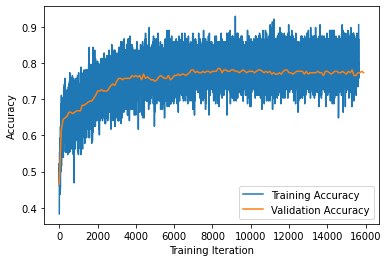

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()